In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import shutil

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from tqdm import tqdm
import logging
from skimage.io import imread
from torchviz import make_dot

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from torch.autograd import Variable
from torch.optim import *
from scipy.io import loadmat, savemat
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, ConcatDataset, DataLoader, SubsetRandomSampler
import torchio as tio
from torch.utils.tensorboard import SummaryWriter

import matplotlib.cm as cm
import matplotlib.animation as animation
#import plotly.graph_objects as go
#import plotly.io as pio
#pio.renderers.default = "notebook"
import math

from utils.dataset_utils import *
from utils.classifier_utils import *
from utils.neural_networks import *

logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format='%(asctime)s - %(message)s', datefmt="%Y-%m-%d %H:%M:%S")

In [2]:
info = {}
info["ext"] = "mat"
#info["ext"] = "nii"
dir_path = "../RSNA-BTC-Datasets/train_"+info["ext"]
test_dir_path = "../RSNA-BTC-Datasets/test_"+info["ext"]
tumor_only_dir_path = "../RSNA-BTC-Datasets/ec_train_"+info["ext"]
tumor_only_test_dir_path = "../RSNA-BTC-Datasets/ec_test_"+info["ext"]
no_tumor_dir_path = "../RSNA-BTC-Datasets/no_tumor_train_"+info["ext"]
ext_test_1_dir_path = "../RSNA-BTC-Datasets/brats18_"+info["ext"]
ext_test_0_dir_path = "../RSNA-BTC-Datasets/OpenNeuroDS000221_ss_"+info["ext"]
new_dir_path = "../RSNA-BTC-Datasets/UPENN-GBM_"+info["ext"]

In [201]:
"""
import os
# assign directory
full_0 = os.listdir(dir_path+"/KLF/0")
filtered_0 = os.listdir(tumor_only_dir_path+"/KLF/0")
full_0.sort()
filtered_0.sort()
print(full_0)
print(filtered_0)
negative_0 = list(set(full_0)-set(filtered_0))
negative_0.sort()
print(negative_0)


# iterate over files in
# that directory
for filename in os.listdir(dir_path+"/KLF/0"):
    if filename in negative_0:
        original_path = os.path.join(dir_path+"/KLF/0", filename)
        dest_path = os.path.join("../RSNA-BTC-Datasets/no_tumor_train_"+info["ext"]+"/KLF/0",filename)
        shutil.copy(original_path, dest_path)
"""

['00009_KLF.mat', '00017_KLF.mat', '00018_KLF.mat', '00019_KLF.mat', '00021_KLF.mat', '00022_KLF.mat', '00024_KLF.mat', '00030_KLF.mat', '00032_KLF.mat', '00036_KLF.mat', '00044_KLF.mat', '00045_KLF.mat', '00049_KLF.mat', '00053_KLF.mat', '00061_KLF.mat', '00064_KLF.mat', '00072_KLF.mat', '00081_KLF.mat', '00084_KLF.mat', '00088_KLF.mat', '00090_KLF.mat', '00095_KLF.mat', '00097_KLF.mat', '00099_KLF.mat', '00102_KLF.mat', '00104_KLF.mat', '00110_KLF.mat', '00111_KLF.mat', '00112_KLF.mat', '00113_KLF.mat', '00116_KLF.mat', '00121_KLF.mat', '00122_KLF.mat', '00123_KLF.mat', '00124_KLF.mat', '00130_KLF.mat', '00133_KLF.mat', '00142_KLF.mat', '00149_KLF.mat', '00150_KLF.mat', '00151_KLF.mat', '00154_KLF.mat', '00157_KLF.mat', '00158_KLF.mat', '00162_KLF.mat', '00165_KLF.mat', '00167_KLF.mat', '00169_KLF.mat', '00170_KLF.mat', '00172_KLF.mat', '00176_KLF.mat', '00183_KLF.mat', '00184_KLF.mat', '00191_KLF.mat', '00192_KLF.mat', '00193_KLF.mat', '00194_KLF.mat', '00195_KLF.mat', '00201_KLF.ma

In [7]:
chosen_net  = "sim" #3du, sim, alt
if chosen_net == "alt":
    info["dims"] = 2 #3,2
    info["batch_size"] = 1#8,4,1
    sel_slices = 1 #None,1
else:
    info["dims"] = 3 #3,2
    info["batch_size"] = 4#8,4,1
    sel_slices = None #None,1
info["mri_types"] = ["KLF"] #["KLF"] ["FLAIR"] ["T1w"] ["FLAIR", "T2w"]
info["is_depth_wise"] = True
info["is_transformed"] = False
transform = None
info["output_size"] = 1
info["is_multistep"] = True
info["lr"] = 0.0001
info["is_adam"] = True
info["momentum"] = 0.9
info["is_10_fold"] = False
info["val_total_ratio"] = 0.2
info["is_internal_dataset"] = True
# Train and Val Origin:
# - m: Competition training or validation set
# - M: Competition training and validation set
# - f: Competition (tumor only) training or validation set
# - F: Competition (tumor only) training and validation set
# - t: External training or validation set
# - n: UPENN (tumor only) training or validation set
# - N: UPENN (tumor only) training and validation set
# - fn: Competition (tumor only) + UPENN (tumor only) training or validation
# - FN: Competition (tumor only) + UPENN (tumor only) training and validation
info["train_origin"] = "m"
info["val_origin"] = "m"
size = len(info["mri_types"])

"""
chosen_net  = "alt" #3du
info["dims"] = 2
info["mri_types"] = ["KLF"]
info["batch_size"] = 1#8
info["is_depth_wise"] = True
info["is_transformed"] = False
transform = None
info["output_size"] = 1
info["is_multistep"] = True
info["lr"] = 0.0005
info["is_adam"] = True
info["momentum"] = 0.9
info["is_10_fold"] = False
info["val_total_ratio"] = 0.2
info["is_internal_dataset"] = True
size = len(info["mri_types"])
sel_slices = 1
"""

"""
chosen_net  = "eff" #3du
info["dims"] = 3
info["mri_types"] = ["FLAIR"]
info["batch_size"] = 4#8
info["is_depth_wise"] = False
info["is_transformed"] = False
transform = None
info["output_size"] = 1
info["is_multistep"] = True
info["lr"] = 0.0005
info["is_adam"] = True
info["momentum"] = 0.9
info["is_10_fold"] = False
info["val_total_ratio"] = 0.1
info["is_internal_dataset"] = True
size = len(info["mri_types"])
sel_slices = None
"""
print(info)

{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': True, 'is_transformed': False, 'output_size': 1, 'is_multistep': True, 'lr': 0.0001, 'is_adam': True, 'momentum': 0.9, 'is_10_fold': False, 'val_total_ratio': 0.2, 'is_internal_dataset': True, 'train_origin': 'm', 'val_origin': 'm'}


In [3]:
def generate_datasets(types):
    data_packs = {}
    for t in types:
        print("Type: "+t)
        # Competition Train + Val + Test
        m_dataset_0 = Dataset(dir_path, [t], list_classes=["0"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

        logging.info("Train/Val datasets size: {}".format(len(m_dataset_0)))

        m_dataset_1 = Dataset(dir_path, [t], list_classes=["1"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

        logging.info("Train/Val datasets size: {}".format(len(m_dataset_1)))

        # External Train + Val + Test
        t_dataset_0 = Dataset(ext_test_0_dir_path, [t], list_classes=["0"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

        logging.info("Train/Val datasets size: {}".format(len(t_dataset_0)))

        t_dataset_1 = Dataset(ext_test_1_dir_path, [t], list_classes=["1"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

        logging.info("Train/Val datasets size: {}".format(len(t_dataset_1)))

        # UPENN Train + Val + Test
        n_dataset_0 = Dataset(new_dir_path, [t], list_classes=["0"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

        logging.info("Train/Val datasets size: {}".format(len(n_dataset_0)))

        n_dataset_1 = Dataset(new_dir_path, [t], list_classes=["1"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

        logging.info("Train/Val datasets size: {}".format(len(n_dataset_1)))
        
        if t == "KLF":
            # Competition (Tumor Only) Train + Val + Test
            f_dataset_0 = Dataset(tumor_only_dir_path, [t], list_classes=["0"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

            logging.info("Train/Val datasets size: {}".format(len(f_dataset_0)))

            f_dataset_1 = Dataset(tumor_only_dir_path, [t], list_classes=["1"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

            logging.info("Train/Val datasets size: {}".format(len(f_dataset_1)))
            
            # Competition (No Tumor) Train + Val + Test
            h_dataset_0 = Dataset(no_tumor_dir_path, [t], list_classes=["0"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

            logging.info("Train/Val datasets size: {}".format(len(h_dataset_0)))
            
            # Competition (Tumor Only) + UPENN Train + Val + Test
            fn_dataset_0 = Dataset().concat_datasets(f_dataset_0, n_dataset_0)
            
            logging.info("Train/Val datasets size: {}".format(len(fn_dataset_0)))
            
            fn_dataset_1 = Dataset().concat_datasets(f_dataset_1, n_dataset_1)
            
            logging.info("Train/Val datasets size: {}".format(len(fn_dataset_1)))
        
        if t == "KLF":
            data_packs[t] = {
                "m_dataset_0": m_dataset_0,
                "m_dataset_1": m_dataset_1,
                "f_dataset_0": f_dataset_0,
                "f_dataset_1": f_dataset_1,
                "h_dataset_0": h_dataset_0,
                "t_dataset_0": t_dataset_0,
                "t_dataset_1": t_dataset_1,
                "n_dataset_0": n_dataset_0,
                "n_dataset_1": n_dataset_1,
                "fn_dataset_0": fn_dataset_0,
                "fn_dataset_1": fn_dataset_1
            }
        else:
            data_packs[t] = {
                "m_dataset_0": m_dataset_0,
                "m_dataset_1": m_dataset_1,
                "t_dataset_0": t_dataset_0,
                "t_dataset_1": t_dataset_1,
                "n_dataset_0": n_dataset_0,
                "n_dataset_1": n_dataset_1
            }
    return data_packs

In [ ]:
packs = generate_datasets(['KLF','FLAIR','T1w'])
print(packs)

In [4]:
import importlib
from utils import dataset_utils
importlib.reload(dataset_utils)

def get_merged_dataset(dataset_0, dataset_1):
    dataset_merged = Dataset().concat_datasets(dataset_0, dataset_1)
    dataset_merged_no_tr = Dataset().concat_datasets(dataset_0, dataset_1, import_transform=False)

    splits = dataset_utils.get_splits(dataset_0, dataset_1, info["val_total_ratio"], info["is_10_fold"], 0.1)
    print(splits)
    return dataset_merged, dataset_merged_no_tr, splits

def get_trainval_loader(dataset_merged, splits):
    g_cpu = torch.Generator()
    train_folds_idx = list(splits[0][0])
    valid_folds_idx = list(splits[0][1])
    #m_test_folds_idx = m_splits[0][2]
    # Test for 
    idxs = train_folds_idx + valid_folds_idx
    print(idxs)
    sampler = SubsetRandomSampler(idxs, g_cpu)
    loader = DataLoader(dataset=dataset_merged, batch_size=info["batch_size"], sampler=sampler, num_workers=2, worker_init_fn=np.random.seed(0))
    return loader

def get_loaders(packs):
    loader_packs = {}
    for t, pack in packs.items():
        print("Type: "+t)
        m_dataset_merged, m_dataset_merged_no_tr, m_splits = get_merged_dataset(pack['m_dataset_0'], pack['m_dataset_1'])
        n_dataset_merged, n_dataset_merged_no_tr, n_splits = get_merged_dataset(pack['n_dataset_0'], pack['n_dataset_1'])
        t_dataset_merged, t_dataset_merged_no_tr, t_splits = get_merged_dataset(pack['t_dataset_0'], pack['t_dataset_1'])
        if t == "KLF":
            f_dataset_merged, f_dataset_merged_no_tr, f_splits = get_merged_dataset(pack['f_dataset_0'], pack['f_dataset_1'])
            h_dataset_merged, h_dataset_merged_no_tr, h_splits = get_merged_dataset(pack['h_dataset_0'], None)
            fn_dataset_merged, fn_dataset_merged_no_tr, fn_splits = get_merged_dataset(pack['fn_dataset_0'], pack['fn_dataset_1'])
        
        m_dataloader = get_all_split_loaders(m_dataset_merged, m_dataset_merged_no_tr, m_splits, info["batch_size"])
        m_trainval_dataloader = [get_trainval_loader(m_dataset_merged, m_splits)]
        m_dataloaders = list(m_dataloader[0]) + m_trainval_dataloader
        logging.info("(M) Train validation test splitted: {} {} {}".format(len(m_splits[0][0]),len(m_splits[0][1]),len(m_splits[0][2])))

        t_dataloader = get_all_split_loaders(t_dataset_merged, t_dataset_merged_no_tr, t_splits, info["batch_size"])
        t_dataloaders = list(t_dataloader[0])
        logging.info("(T) Train validation test splitted: {} {} {}".format(len(t_splits[0][0]),len(t_splits[0][1]),len(t_splits[0][2])))

        n_dataloader = get_all_split_loaders(n_dataset_merged, n_dataset_merged_no_tr, n_splits, info["batch_size"])
        n_trainval_dataloader = [get_trainval_loader(n_dataset_merged, n_splits)]
        n_dataloaders = list(n_dataloader[0]) + n_trainval_dataloader
        logging.info("(N) Train validation test splitted: {} {} {}".format(len(n_splits[0][0]),len(n_splits[0][1]),len(n_splits[0][2])))
        
        if t == "KLF":
            f_dataloader = get_all_split_loaders(f_dataset_merged, f_dataset_merged_no_tr, f_splits, info["batch_size"])
            f_trainval_dataloader = [get_trainval_loader(f_dataset_merged, f_splits)]
            f_dataloaders = list(f_dataloader[0]) + f_trainval_dataloader
            logging.info("(F) Train validation test splitted: {} {} {}".format(len(f_splits[0][0]),len(f_splits[0][1]),len(f_splits[0][2])))
            
            h_dataloader = get_all_split_loaders(h_dataset_merged, h_dataset_merged_no_tr, h_splits, info["batch_size"])
            h_trainval_dataloader = [get_trainval_loader(h_dataset_merged, h_splits)]
            h_dataloaders = list(h_dataloader[0]) + h_trainval_dataloader
            logging.info("(H) Train validation test splitted: {} {} {}".format(len(h_splits[0][0]),len(h_splits[0][1]),len(h_splits[0][2])))

            fn_dataloader = get_all_split_loaders(fn_dataset_merged, fn_dataset_merged_no_tr, fn_splits, info["batch_size"])
            fn_trainval_dataloader = [get_trainval_loader(fn_dataset_merged, fn_splits)]
            fn_dataloaders = list(fn_dataloader[0]) + fn_trainval_dataloader
            logging.info("(FN) Train validation test splitted: {} {} {}".format(len(fn_splits[0][0]),len(fn_splits[0][1]),len(fn_splits[0][2])))
        
        if t == "KLF":
            loader_packs[t] = {
                "m_dataloaders": m_dataloaders,
                "f_dataloaders": f_dataloaders,
                "h_dataloaders": h_dataloaders,
                "n_dataloaders": n_dataloaders,
                "t_dataloaders": t_dataloaders,
                "fn_dataloaders": fn_dataloaders
            }
        else:
            loader_packs[t] = {
                "m_dataloaders": m_dataloaders,
                "n_dataloaders": n_dataloaders,
                "t_dataloaders": t_dataloaders
            }
        
    return loader_packs

In [ ]:
loader_packs = get_loaders(packs)
print(loader_packs)

In [11]:
# Model check
model = try_and_get_model(chosen_net, info["dims"], size, info["is_depth_wise"], info["output_size"])
print(count_parameters(model))
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info("Using CUDA...")

182732
RSNAClassifierSingle3D(
  (part1): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): Conv3d(1, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (2): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), groups=4, bias=False)
      (1): Conv3d(4, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (2): Sequential(
      (0): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), groups=8, bias=False)
      (1): Conv3d(8, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )


In [12]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
#print(loader_packs['KLF']['m_dataloaders'])
selected_type = info["mri_types"][0]
print(selected_type)
m_dataloader = loader_packs[selected_type]['m_dataloaders']#m_dataloaders[0]
# Competition Train
m_train_loader = m_dataloader[0]
# Competition Val
m_val_loader = m_dataloader[1]
# Competition Train + Val
m_train_val_loader = m_dataloader[3]#m_loader
# Competition Test
m_test_loader = m_dataloader[2]

t_dataloader = loader_packs[selected_type]['t_dataloaders']#t_dataloaders[0]
# External Train
t_train_loader = t_dataloader[0]
# External Val
t_val_loader = t_dataloader[1]
# External Test
t_test_loader = t_dataloader[2]

n_dataloader = loader_packs[selected_type]['n_dataloaders']#n_dataloaders[0]
# UPENN Train
n_train_loader = n_dataloader[0]
# UPENN Val
n_val_loader = n_dataloader[1]
# UPENN Train + Val
n_train_val_loader = n_dataloader[3]#n_loader
# UPENN Test
n_test_loader = n_dataloader[2]

if selected_type == "KLF":
    f_dataloader = loader_packs[selected_type]['f_dataloaders']#f_dataloaders[0]
    # Competition (Tumor Only) Train
    f_train_loader = f_dataloader[0]
    # Competition (Tumor Only) Val
    f_val_loader = f_dataloader[1]
    # Competition (Tumor Only) Train + Val
    f_train_val_loader = f_dataloader[3]
    # Competition (Tumor Only) Test
    f_test_loader = f_dataloader[2]
    
    h_dataloader = loader_packs[selected_type]['h_dataloaders']#h_dataloaders[0]
    # Competition (No Tumor) Train
    h_train_loader = h_dataloader[0]
    # Competition (No Tumor) Val
    h_val_loader = h_dataloader[1]
    # Competition (No Tumor) Train + Val
    h_train_val_loader = h_dataloader[3]
    # Competition (No Tumor) Test
    h_test_loader = h_dataloader[2]
    
    fn_dataloader = loader_packs[selected_type]['fn_dataloaders']#fn_dataloaders[0]
    # Competition (Tumor Only) + UPENN Train
    fn_train_loader = fn_dataloader[0]
    # Competition (Tumor Only) + UPENN Val
    fn_val_loader = fn_dataloader[1]
    # Competition (Tumor Only) + UPENN Train + Val
    fn_train_val_loader = fn_dataloader[3]
    # Competition (Tumor Only) + UPENN Test
    fn_test_loader = fn_dataloader[2]

KLF


In [13]:
m_model = try_and_get_model(chosen_net, info["dims"], size, info["is_depth_wise"], info["output_size"])

In [14]:
# Methylation Detector
train_loader = m_train_loader
to = info["train_origin"]
if to == "m":
    train_loader = m_train_loader
elif to == "M":
    train_loader = m_train_val_loader
elif to == "f":
    train_loader = f_train_loader
elif to == "F":
    train_loader = f_train_val_loader
elif to == "h":
    train_loader = h_train_loader
elif to == "n":
    train_loader = n_train_loader
elif to == "N":
    train_loader = n_train_val_loader
elif to == "t":
    train_loader = t_train_loader
elif to == "fn":
    train_loader = fn_train_loader
elif to == "FN":
    train_loader == fn_train_val_loader
    
val_loader = m_val_loader
vo = info["val_origin"]
if vo == "m":
    val_loader = m_val_loader
elif vo == "M":
    val_loader = m_train_val_loader
elif vo == "f":
    val_loader = f_val_loader
elif vo == "F":
    val_loader = f_train_val_loader
elif vo == "h":
    val_loader = h_val_loader
elif vo == "n":
    val_loader = n_val_loader
elif vo == "N":
    val_loader = n_train_val_loader
elif vo == "t":
    val_loader = t_val_loader
elif vo == "fn":
    val_loader = fn_val_loader
elif vo == "FN":
    val_loader == fn_train_val_loader
    
print(to, vo)

m m


{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': True, 'is_transformed': False, 'output_size': 1, 'is_multistep': True, 'lr': 0.0001, 'is_adam': True, 'momentum': 0.9, 'is_10_fold': False, 'val_total_ratio': 0.2, 'is_internal_dataset': True, 'train_origin': 'm', 'val_origin': 'm'}
RSNAClassifierSingle3D(
  (part1): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): Conv3d(1, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (2): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), groups=4, bias=False)
      (1): Conv3d(4, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (2): Seq

  0%|                                                   | 0/150 [00:00<?, ?it/s]

2022-08-05 22:07:20 - EPOCH: 1
2022-08-05 22:07:23 - Train Step 10/107, train_loss: 0.7069
2022-08-05 22:07:26 - Train Step 20/107, train_loss: 0.6915
2022-08-05 22:07:29 - Train Step 30/107, train_loss: 0.6950
2022-08-05 22:07:32 - Train Step 40/107, train_loss: 0.6964
2022-08-05 22:07:35 - Train Step 50/107, train_loss: 0.6941
2022-08-05 22:07:37 - Train Step 60/107, train_loss: 0.6932
2022-08-05 22:07:40 - Train Step 70/107, train_loss: 0.6915
2022-08-05 22:07:43 - Train Step 80/107, train_loss: 0.6940
2022-08-05 22:07:46 - Train Step 90/107, train_loss: 0.6973
2022-08-05 22:07:49 - Train Step 100/107, train_loss: 0.6967
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-05 22:07:53 - Valid Step 5/30, valid_loss: 0.6682
2022-08-05 22:07:54 - Valid Step 10/30, valid_loss: 0.6887
2022-08-05 22:07:56 - Valid Step 15/30, valid_loss: 0.6878
2022-08-05 22:07:57 - Valid Step 20/30, valid_loss: 0.6909
2022-08-05 22:07:59 - Valid Step 25/30, valid_loss: 0.7013
2022-08-05 22:08:00 - Va

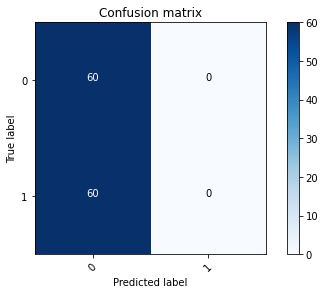

2022-08-05 22:08:01 - [Epoch Train: 1] loss: 0.6951, auc: 0.5152, acc: 0.4930, time: 31.00 s            
2022-08-05 22:08:01 - [Epoch Valid: 1] loss: 0.6988, auc: 0.5211, acc: 0.5000, time: 9.00 s
2022-08-05 22:08:01 - acc improved from 0.0000 to 0.5000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug05_22-07-19/RSNAClassifierSingle3D-DW-SO-KLF-e1-loss0.699-acc0.500-auc0.521.pth'


  1%|▎                                        | 1/150 [00:40<1:41:22, 40.82s/it]

2022-08-05 22:08:01 - EPOCH: 2
2022-08-05 22:08:04 - Train Step 10/107, train_loss: 0.6228
2022-08-05 22:08:07 - Train Step 20/107, train_loss: 0.6149
2022-08-05 22:08:12 - Train Step 30/107, train_loss: 0.6115
2022-08-05 22:08:16 - Train Step 40/107, train_loss: 0.6273
2022-08-05 22:08:18 - Train Step 50/107, train_loss: 0.6289
2022-08-05 22:08:21 - Train Step 60/107, train_loss: 0.6279
2022-08-05 22:08:24 - Train Step 70/107, train_loss: 0.6333
2022-08-05 22:08:27 - Train Step 80/107, train_loss: 0.6370
2022-08-05 22:08:30 - Train Step 90/107, train_loss: 0.6345
2022-08-05 22:08:33 - Train Step 100/107, train_loss: 0.6426
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-05 22:08:36 - Valid Step 5/30, valid_loss: 0.6661
2022-08-05 22:08:38 - Valid Step 10/30, valid_loss: 0.7038
2022-08-05 22:08:39 - Valid Step 15/30, valid_loss: 0.7212
2022-08-05 22:08:41 - Valid Step 20/30, valid_loss: 0.7272
2022-08-05 22:08:42 - Valid Step 25/30, valid_loss: 0.7069
2022-08-05 22:08:43 - Va

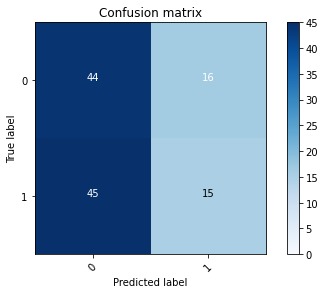

2022-08-05 22:08:44 - [Epoch Train: 2] loss: 0.6436, auc: 0.6987, acc: 0.5704, time: 33.00 s            
2022-08-05 22:08:44 - [Epoch Valid: 2] loss: 0.7000, auc: 0.5653, acc: 0.4917, time: 9.00 s


  1%|▌                                        | 2/150 [01:23<1:43:49, 42.09s/it]

2022-08-05 22:08:44 - EPOCH: 3
2022-08-05 22:08:47 - Train Step 10/107, train_loss: 0.6219
2022-08-05 22:08:49 - Train Step 20/107, train_loss: 0.6129
2022-08-05 22:08:52 - Train Step 30/107, train_loss: 0.5852
2022-08-05 22:08:55 - Train Step 40/107, train_loss: 0.5820
2022-08-05 22:08:58 - Train Step 50/107, train_loss: 0.5696
2022-08-05 22:09:01 - Train Step 60/107, train_loss: 0.5790
2022-08-05 22:09:04 - Train Step 70/107, train_loss: 0.5847
2022-08-05 22:09:06 - Train Step 80/107, train_loss: 0.5843
2022-08-05 22:09:09 - Train Step 90/107, train_loss: 0.5813
2022-08-05 22:09:12 - Train Step 100/107, train_loss: 0.5767
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-05 22:09:16 - Valid Step 5/30, valid_loss: 0.6302
2022-08-05 22:09:17 - Valid Step 10/30, valid_loss: 0.6990
2022-08-05 22:09:19 - Valid Step 15/30, valid_loss: 0.6929
2022-08-05 22:09:20 - Valid Step 20/30, valid_loss: 0.6823
2022-08-05 22:09:22 - Valid Step 25/30, valid_loss: 0.6876
2022-08-05 22:09:23 - Va

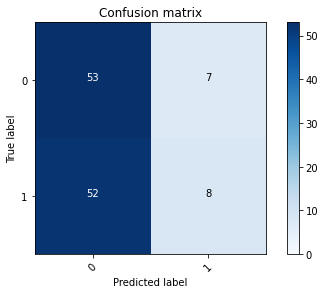

2022-08-05 22:09:23 - [Epoch Train: 3] loss: 0.5726, auc: 0.8374, acc: 0.6502, time: 30.00 s            
2022-08-05 22:09:23 - [Epoch Valid: 3] loss: 0.7087, auc: 0.5431, acc: 0.5083, time: 9.00 s
2022-08-05 22:09:23 - acc improved from 0.5000 to 0.5083. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug05_22-07-19/RSNAClassifierSingle3D-DW-SO-KLF-e3-loss0.709-acc0.508-auc0.543.pth'


  2%|▊                                        | 3/150 [02:03<1:40:20, 40.95s/it]

2022-08-05 22:09:23 - EPOCH: 4
2022-08-05 22:09:26 - Train Step 10/107, train_loss: 0.4636
2022-08-05 22:09:29 - Train Step 20/107, train_loss: 0.4631
2022-08-05 22:09:32 - Train Step 30/107, train_loss: 0.4610
2022-08-05 22:09:35 - Train Step 40/107, train_loss: 0.4783
2022-08-05 22:09:38 - Train Step 50/107, train_loss: 0.4687
2022-08-05 22:09:40 - Train Step 60/107, train_loss: 0.4762
2022-08-05 22:09:43 - Train Step 70/107, train_loss: 0.4759
2022-08-05 22:09:46 - Train Step 80/107, train_loss: 0.4766
2022-08-05 22:09:49 - Train Step 90/107, train_loss: 0.4727
2022-08-05 22:09:51 - Train Step 100/107, train_loss: 0.4728
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-05 22:09:55 - Valid Step 5/30, valid_loss: 0.5940
2022-08-05 22:09:56 - Valid Step 10/30, valid_loss: 0.6529
2022-08-05 22:09:58 - Valid Step 15/30, valid_loss: 0.7428
2022-08-05 22:09:59 - Valid Step 20/30, valid_loss: 0.7785
2022-08-05 22:10:01 - Valid Step 25/30, valid_loss: 0.7583
2022-08-05 22:10:02 - Va

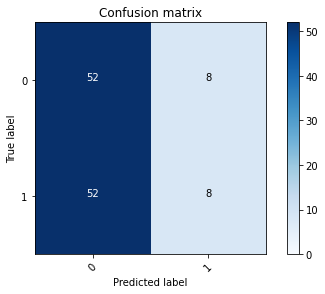

2022-08-05 22:10:03 - [Epoch Train: 4] loss: 0.4697, auc: 0.9195, acc: 0.7582, time: 30.00 s            
2022-08-05 22:10:03 - [Epoch Valid: 4] loss: 0.7662, auc: 0.5253, acc: 0.5000, time: 9.00 s


  3%|█                                        | 4/150 [02:42<1:38:03, 40.30s/it]

2022-08-05 22:10:03 - EPOCH: 5
2022-08-05 22:10:06 - Train Step 10/107, train_loss: 0.4084
2022-08-05 22:10:08 - Train Step 20/107, train_loss: 0.3758
2022-08-05 22:10:11 - Train Step 30/107, train_loss: 0.3812
2022-08-05 22:10:14 - Train Step 40/107, train_loss: 0.3865
2022-08-05 22:10:17 - Train Step 50/107, train_loss: 0.3754
2022-08-05 22:10:19 - Train Step 60/107, train_loss: 0.3734
2022-08-05 22:10:22 - Train Step 70/107, train_loss: 0.3736
2022-08-05 22:10:25 - Train Step 80/107, train_loss: 0.3707
2022-08-05 22:10:27 - Train Step 90/107, train_loss: 0.3644
2022-08-05 22:10:30 - Train Step 100/107, train_loss: 0.3594
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-05 22:10:34 - Valid Step 5/30, valid_loss: 0.5638
2022-08-05 22:10:35 - Valid Step 10/30, valid_loss: 0.6437
2022-08-05 22:10:37 - Valid Step 15/30, valid_loss: 0.6695
2022-08-05 22:10:38 - Valid Step 20/30, valid_loss: 0.7332
2022-08-05 22:10:40 - Valid Step 25/30, valid_loss: 0.7735
2022-08-05 22:10:41 - Va

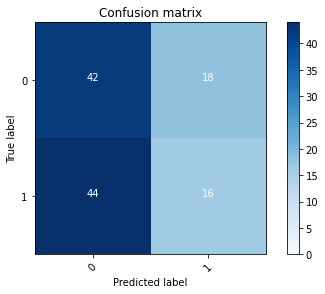

2022-08-05 22:10:41 - [Epoch Train: 5] loss: 0.3593, auc: 0.9674, acc: 0.8286, time: 29.00 s            
2022-08-05 22:10:41 - [Epoch Valid: 5] loss: 0.7988, auc: 0.5406, acc: 0.4833, time: 9.00 s


  3%|█▎                                       | 5/150 [03:21<1:36:05, 39.76s/it]

2022-08-05 22:10:41 - EPOCH: 6
2022-08-05 22:10:44 - Train Step 10/107, train_loss: 0.3147
2022-08-05 22:10:47 - Train Step 20/107, train_loss: 0.2789
2022-08-05 22:10:50 - Train Step 30/107, train_loss: 0.2585
2022-08-05 22:10:53 - Train Step 40/107, train_loss: 0.2594
2022-08-05 22:10:56 - Train Step 50/107, train_loss: 0.2509
2022-08-05 22:10:58 - Train Step 60/107, train_loss: 0.2504
2022-08-05 22:11:01 - Train Step 70/107, train_loss: 0.2429
2022-08-05 22:11:04 - Train Step 80/107, train_loss: 0.2347
2022-08-05 22:11:07 - Train Step 90/107, train_loss: 0.2351
2022-08-05 22:11:10 - Train Step 100/107, train_loss: 0.2345
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-05 22:11:13 - Valid Step 5/30, valid_loss: 0.9086
2022-08-05 22:11:15 - Valid Step 10/30, valid_loss: 0.9568
2022-08-05 22:11:16 - Valid Step 15/30, valid_loss: 0.9755
2022-08-05 22:11:17 - Valid Step 20/30, valid_loss: 0.9721
2022-08-05 22:11:19 - Valid Step 25/30, valid_loss: 0.8959
2022-08-05 22:11:20 - Va

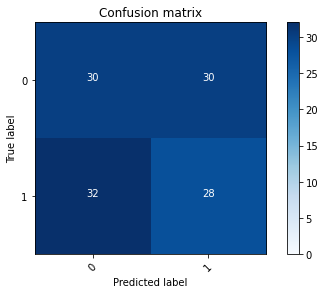

2022-08-05 22:11:21 - [Epoch Train: 6] loss: 0.2332, auc: 0.9940, acc: 0.9155, time: 30.00 s            
2022-08-05 22:11:21 - [Epoch Valid: 6] loss: 0.8868, auc: 0.5558, acc: 0.4833, time: 9.00 s


  4%|█▋                                       | 6/150 [04:00<1:35:06, 39.63s/it]

2022-08-05 22:11:21 - EPOCH: 7
2022-08-05 22:11:24 - Train Step 10/107, train_loss: 0.1564
2022-08-05 22:11:27 - Train Step 20/107, train_loss: 0.1554
2022-08-05 22:11:29 - Train Step 30/107, train_loss: 0.1578
2022-08-05 22:11:32 - Train Step 40/107, train_loss: 0.1546
2022-08-05 22:11:35 - Train Step 50/107, train_loss: 0.1511
2022-08-05 22:11:37 - Train Step 60/107, train_loss: 0.1547
2022-08-05 22:11:40 - Train Step 70/107, train_loss: 0.1522
2022-08-05 22:11:43 - Train Step 80/107, train_loss: 0.1497
2022-08-05 22:11:46 - Train Step 90/107, train_loss: 0.1508
2022-08-05 22:11:48 - Train Step 100/107, train_loss: 0.1485
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-05 22:11:52 - Valid Step 5/30, valid_loss: 0.7705
2022-08-05 22:11:53 - Valid Step 10/30, valid_loss: 0.8836
2022-08-05 22:11:55 - Valid Step 15/30, valid_loss: 1.0428
2022-08-05 22:11:56 - Valid Step 20/30, valid_loss: 1.0767
2022-08-05 22:11:58 - Valid Step 25/30, valid_loss: 1.1033
2022-08-05 22:11:59 - Va

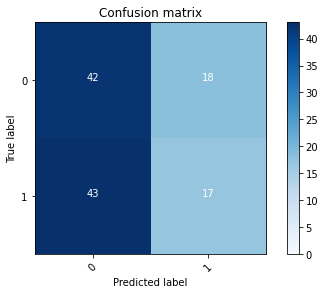

2022-08-05 22:11:59 - [Epoch Train: 7] loss: 0.1516, auc: 0.9978, acc: 0.9624, time: 29.00 s            
2022-08-05 22:11:59 - [Epoch Valid: 7] loss: 1.0014, auc: 0.5456, acc: 0.4917, time: 9.00 s


  5%|█▉                                       | 7/150 [04:39<1:33:36, 39.28s/it]

2022-08-05 22:11:59 - EPOCH: 8
2022-08-05 22:12:02 - Train Step 10/107, train_loss: 0.0876
2022-08-05 22:12:05 - Train Step 20/107, train_loss: 0.0907
2022-08-05 22:12:08 - Train Step 30/107, train_loss: 0.0862
2022-08-05 22:12:11 - Train Step 40/107, train_loss: 0.0915
2022-08-05 22:12:13 - Train Step 50/107, train_loss: 0.0856
2022-08-05 22:12:16 - Train Step 60/107, train_loss: 0.0879
2022-08-05 22:12:19 - Train Step 70/107, train_loss: 0.0887
2022-08-05 22:12:22 - Train Step 80/107, train_loss: 0.0891
2022-08-05 22:12:25 - Train Step 90/107, train_loss: 0.0918
2022-08-05 22:12:28 - Train Step 100/107, train_loss: 0.0923
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-05 22:12:31 - Valid Step 5/30, valid_loss: 0.9631
2022-08-05 22:12:33 - Valid Step 10/30, valid_loss: 1.0567
2022-08-05 22:12:34 - Valid Step 15/30, valid_loss: 0.9769
2022-08-05 22:12:36 - Valid Step 20/30, valid_loss: 1.0293
2022-08-05 22:12:37 - Valid Step 25/30, valid_loss: 1.0009
2022-08-05 22:12:38 - Va

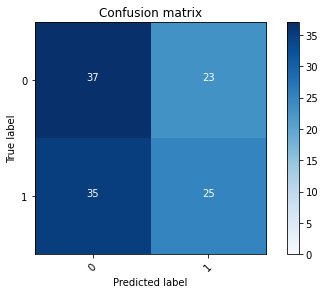

2022-08-05 22:12:39 - [Epoch Train: 8] loss: 0.0896, auc: 0.9999, acc: 0.9859, time: 30.00 s            
2022-08-05 22:12:39 - [Epoch Valid: 8] loss: 1.0388, auc: 0.5725, acc: 0.5167, time: 9.00 s
2022-08-05 22:12:39 - acc improved from 0.5083 to 0.5167. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug05_22-07-19/RSNAClassifierSingle3D-DW-SO-KLF-e8-loss1.039-acc0.517-auc0.572.pth'


  5%|██▏                                      | 8/150 [05:18<1:33:08, 39.36s/it]

2022-08-05 22:12:39 - EPOCH: 9
2022-08-05 22:12:42 - Train Step 10/107, train_loss: 0.0726
2022-08-05 22:12:45 - Train Step 20/107, train_loss: 0.0625
2022-08-05 22:12:47 - Train Step 30/107, train_loss: 0.0593
2022-08-05 22:12:50 - Train Step 40/107, train_loss: 0.0591
2022-08-05 22:12:53 - Train Step 50/107, train_loss: 0.0562
2022-08-05 22:12:56 - Train Step 60/107, train_loss: 0.0552
2022-08-05 22:12:59 - Train Step 70/107, train_loss: 0.0550
2022-08-05 22:13:02 - Train Step 80/107, train_loss: 0.0536
2022-08-05 22:13:04 - Train Step 90/107, train_loss: 0.0520
2022-08-05 22:13:07 - Train Step 100/107, train_loss: 0.0516
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-05 22:13:11 - Valid Step 5/30, valid_loss: 1.0334
2022-08-05 22:13:12 - Valid Step 10/30, valid_loss: 1.2214
2022-08-05 22:13:14 - Valid Step 15/30, valid_loss: 1.1222
2022-08-05 22:13:15 - Valid Step 20/30, valid_loss: 1.1702
2022-08-05 22:13:17 - Valid Step 25/30, valid_loss: 1.2625
2022-08-05 22:13:18 - Va

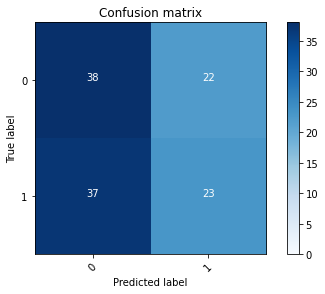

2022-08-05 22:13:18 - [Epoch Train: 9] loss: 0.0510, auc: 1.0000, acc: 0.9977, time: 30.00 s            
2022-08-05 22:13:18 - [Epoch Valid: 9] loss: 1.2489, auc: 0.5633, acc: 0.5083, time: 9.00 s


  6%|██▍                                      | 9/150 [05:58<1:32:38, 39.42s/it]

2022-08-05 22:13:18 - EPOCH: 10
2022-08-05 22:13:21 - Train Step 10/107, train_loss: 0.0278
2022-08-05 22:13:24 - Train Step 20/107, train_loss: 0.0332
2022-08-05 22:13:27 - Train Step 30/107, train_loss: 0.0335
2022-08-05 22:13:30 - Train Step 40/107, train_loss: 0.0334
2022-08-05 22:13:32 - Train Step 50/107, train_loss: 0.0337
2022-08-05 22:13:35 - Train Step 60/107, train_loss: 0.0343
2022-08-05 22:13:38 - Train Step 70/107, train_loss: 0.0336
2022-08-05 22:13:41 - Train Step 80/107, train_loss: 0.0331
2022-08-05 22:13:43 - Train Step 90/107, train_loss: 0.0320
2022-08-05 22:13:46 - Train Step 100/107, train_loss: 0.0330
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:13:50 - Valid Step 5/30, valid_loss: 1.1316
2022-08-05 22:13:51 - Valid Step 10/30, valid_loss: 1.3487
2022-08-05 22:13:53 - Valid Step 15/30, valid_loss: 1.5386
2022-08-05 22:13:54 - Valid Step 20/30, valid_loss: 1.5935
2022-08-05 22:13:56 - Valid Step 25/30, valid_loss: 1.4835
2022-08-05 22:13:57 - V

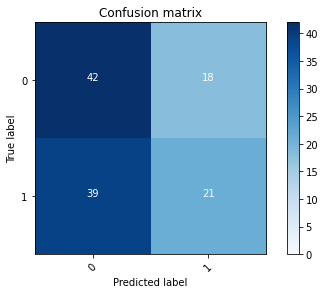

2022-08-05 22:13:57 - [Epoch Train: 10] loss: 0.0331, auc: 1.0000, acc: 1.0000, time: 29.00 s            
2022-08-05 22:13:57 - [Epoch Valid: 10] loss: 1.4415, auc: 0.5667, acc: 0.5250, time: 9.00 s
2022-08-05 22:13:57 - acc improved from 0.5167 to 0.5250. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug05_22-07-19/RSNAClassifierSingle3D-DW-SO-KLF-e10-loss1.441-acc0.525-auc0.567.pth'


  7%|██▋                                     | 10/150 [06:37<1:31:39, 39.28s/it]

2022-08-05 22:13:57 - EPOCH: 11
2022-08-05 22:14:00 - Train Step 10/107, train_loss: 0.0180
2022-08-05 22:14:03 - Train Step 20/107, train_loss: 0.0194
2022-08-05 22:14:06 - Train Step 30/107, train_loss: 0.0208
2022-08-05 22:14:09 - Train Step 40/107, train_loss: 0.0230
2022-08-05 22:14:12 - Train Step 50/107, train_loss: 0.0218
2022-08-05 22:14:14 - Train Step 60/107, train_loss: 0.0201
2022-08-05 22:14:17 - Train Step 70/107, train_loss: 0.0212
2022-08-05 22:14:20 - Train Step 80/107, train_loss: 0.0217
2022-08-05 22:14:23 - Train Step 90/107, train_loss: 0.0219
2022-08-05 22:14:26 - Train Step 100/107, train_loss: 0.0222
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:14:29 - Valid Step 5/30, valid_loss: 1.7027
2022-08-05 22:14:31 - Valid Step 10/30, valid_loss: 1.5568
2022-08-05 22:14:32 - Valid Step 15/30, valid_loss: 1.5789
2022-08-05 22:14:33 - Valid Step 20/30, valid_loss: 1.4788
2022-08-05 22:14:35 - Valid Step 25/30, valid_loss: 1.4701
2022-08-05 22:14:36 - V

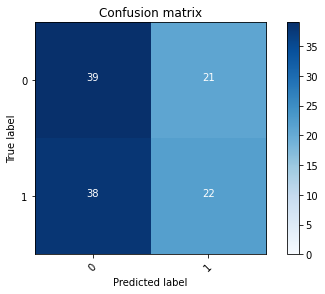

2022-08-05 22:14:37 - [Epoch Train: 11] loss: 0.0223, auc: 1.0000, acc: 1.0000, time: 30.00 s            
2022-08-05 22:14:37 - [Epoch Valid: 11] loss: 1.3169, auc: 0.5739, acc: 0.5083, time: 9.00 s


  7%|██▉                                     | 11/150 [07:16<1:31:00, 39.29s/it]

2022-08-05 22:14:37 - EPOCH: 12
2022-08-05 22:14:40 - Train Step 10/107, train_loss: 0.0191
2022-08-05 22:14:43 - Train Step 20/107, train_loss: 0.0184
2022-08-05 22:14:46 - Train Step 30/107, train_loss: 0.0182
2022-08-05 22:14:49 - Train Step 40/107, train_loss: 0.0178
2022-08-05 22:14:52 - Train Step 50/107, train_loss: 0.0166
2022-08-05 22:14:55 - Train Step 60/107, train_loss: 0.0168
2022-08-05 22:14:58 - Train Step 70/107, train_loss: 0.0166
2022-08-05 22:15:01 - Train Step 80/107, train_loss: 0.0170
2022-08-05 22:15:04 - Train Step 90/107, train_loss: 0.0173
2022-08-05 22:15:07 - Train Step 100/107, train_loss: 0.0168
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:15:11 - Valid Step 5/30, valid_loss: 1.8901
2022-08-05 22:15:12 - Valid Step 10/30, valid_loss: 1.5986
2022-08-05 22:15:14 - Valid Step 15/30, valid_loss: 1.3940
2022-08-05 22:15:15 - Valid Step 20/30, valid_loss: 1.4138
2022-08-05 22:15:17 - Valid Step 25/30, valid_loss: 1.4550
2022-08-05 22:15:18 - V

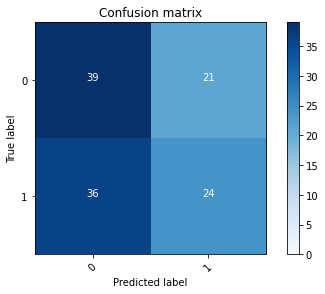

2022-08-05 22:15:19 - [Epoch Train: 12] loss: 0.0168, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-08-05 22:15:19 - [Epoch Valid: 12] loss: 1.4621, auc: 0.5792, acc: 0.5250, time: 9.00 s
2022-08-05 22:15:19 - acc improved from 0.5250 to 0.5250. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug05_22-07-19/RSNAClassifierSingle3D-DW-SO-KLF-e12-loss1.462-acc0.525-auc0.579.pth'


  8%|███▏                                    | 12/150 [07:58<1:32:19, 40.14s/it]

2022-08-05 22:15:19 - EPOCH: 13
2022-08-05 22:15:22 - Train Step 10/107, train_loss: 0.0171
2022-08-05 22:15:25 - Train Step 20/107, train_loss: 0.0129
2022-08-05 22:15:27 - Train Step 30/107, train_loss: 0.0139
2022-08-05 22:15:30 - Train Step 40/107, train_loss: 0.0152
2022-08-05 22:15:33 - Train Step 50/107, train_loss: 0.0157
2022-08-05 22:15:36 - Train Step 60/107, train_loss: 0.0149
2022-08-05 22:15:39 - Train Step 70/107, train_loss: 0.0156
2022-08-05 22:15:42 - Train Step 80/107, train_loss: 0.0149
2022-08-05 22:15:45 - Train Step 90/107, train_loss: 0.0147
2022-08-05 22:15:48 - Train Step 100/107, train_loss: 0.0149
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:15:51 - Valid Step 5/30, valid_loss: 1.0556
2022-08-05 22:15:53 - Valid Step 10/30, valid_loss: 1.5402
2022-08-05 22:15:54 - Valid Step 15/30, valid_loss: 1.4831
2022-08-05 22:15:56 - Valid Step 20/30, valid_loss: 1.4689
2022-08-05 22:15:57 - Valid Step 25/30, valid_loss: 1.3867
2022-08-05 22:15:59 - V

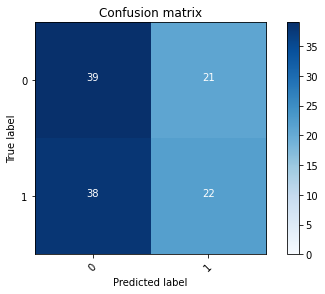

2022-08-05 22:15:59 - [Epoch Train: 13] loss: 0.0148, auc: 1.0000, acc: 1.0000, time: 30.00 s            
2022-08-05 22:15:59 - [Epoch Valid: 13] loss: 1.3842, auc: 0.5772, acc: 0.5083, time: 9.00 s


  9%|███▍                                    | 13/150 [08:39<1:31:41, 40.16s/it]

2022-08-05 22:15:59 - EPOCH: 14
2022-08-05 22:16:02 - Train Step 10/107, train_loss: 0.0115
2022-08-05 22:16:05 - Train Step 20/107, train_loss: 0.0125
2022-08-05 22:16:08 - Train Step 30/107, train_loss: 0.0125
2022-08-05 22:16:11 - Train Step 40/107, train_loss: 0.0126
2022-08-05 22:16:13 - Train Step 50/107, train_loss: 0.0125
2022-08-05 22:16:16 - Train Step 60/107, train_loss: 0.0121
2022-08-05 22:16:19 - Train Step 70/107, train_loss: 0.0123
2022-08-05 22:16:22 - Train Step 80/107, train_loss: 0.0128
2022-08-05 22:16:25 - Train Step 90/107, train_loss: 0.0126
2022-08-05 22:16:28 - Train Step 100/107, train_loss: 0.0124
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:16:31 - Valid Step 5/30, valid_loss: 1.6967
2022-08-05 22:16:33 - Valid Step 10/30, valid_loss: 1.6249
2022-08-05 22:16:35 - Valid Step 15/30, valid_loss: 1.5034
2022-08-05 22:16:36 - Valid Step 20/30, valid_loss: 1.5109
2022-08-05 22:16:38 - Valid Step 25/30, valid_loss: 1.4519
2022-08-05 22:16:39 - V

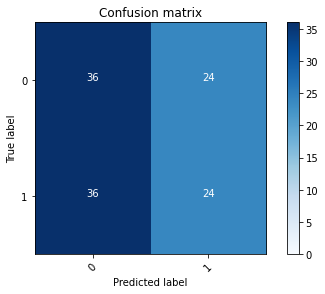

2022-08-05 22:16:39 - [Epoch Train: 14] loss: 0.0122, auc: 1.0000, acc: 1.0000, time: 30.00 s            
2022-08-05 22:16:39 - [Epoch Valid: 14] loss: 1.4769, auc: 0.5803, acc: 0.5000, time: 9.00 s


  9%|███▋                                    | 14/150 [09:19<1:31:05, 40.19s/it]

2022-08-05 22:16:39 - EPOCH: 15
2022-08-05 22:16:42 - Train Step 10/107, train_loss: 0.0125
2022-08-05 22:16:48 - Train Step 20/107, train_loss: 0.0120
2022-08-05 22:16:51 - Train Step 30/107, train_loss: 0.0115
2022-08-05 22:16:53 - Train Step 40/107, train_loss: 0.0111
2022-08-05 22:16:56 - Train Step 50/107, train_loss: 0.0115
2022-08-05 22:16:59 - Train Step 60/107, train_loss: 0.0111
2022-08-05 22:17:02 - Train Step 70/107, train_loss: 0.0108
2022-08-05 22:17:05 - Train Step 80/107, train_loss: 0.0104
2022-08-05 22:17:08 - Train Step 90/107, train_loss: 0.0102
2022-08-05 22:17:10 - Train Step 100/107, train_loss: 0.0103
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:17:14 - Valid Step 5/30, valid_loss: 1.2646
2022-08-05 22:17:16 - Valid Step 10/30, valid_loss: 1.6679
2022-08-05 22:17:18 - Valid Step 15/30, valid_loss: 1.3743
2022-08-05 22:17:19 - Valid Step 20/30, valid_loss: 1.5056
2022-08-05 22:17:21 - Valid Step 25/30, valid_loss: 1.5222
2022-08-05 22:17:22 - V

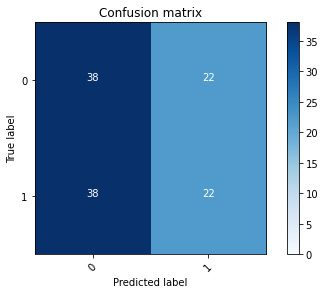

2022-08-05 22:17:22 - [Epoch Train: 15] loss: 0.0101, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-08-05 22:17:22 - [Epoch Valid: 15] loss: 1.5172, auc: 0.5758, acc: 0.5000, time: 9.00 s


 10%|████                                    | 15/150 [10:02<1:32:14, 40.99s/it]

2022-08-05 22:17:22 - EPOCH: 16
2022-08-05 22:17:25 - Train Step 10/107, train_loss: 0.0087
2022-08-05 22:17:28 - Train Step 20/107, train_loss: 0.0077
2022-08-05 22:17:32 - Train Step 30/107, train_loss: 0.0085
2022-08-05 22:17:35 - Train Step 40/107, train_loss: 0.0081
2022-08-05 22:17:38 - Train Step 50/107, train_loss: 0.0081
2022-08-05 22:17:41 - Train Step 60/107, train_loss: 0.0082
2022-08-05 22:17:44 - Train Step 70/107, train_loss: 0.0079
2022-08-05 22:17:47 - Train Step 80/107, train_loss: 0.0080
2022-08-05 22:17:50 - Train Step 90/107, train_loss: 0.0080
2022-08-05 22:17:53 - Train Step 100/107, train_loss: 0.0082
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:17:56 - Valid Step 5/30, valid_loss: 1.6600
2022-08-05 22:17:58 - Valid Step 10/30, valid_loss: 1.3466
2022-08-05 22:17:59 - Valid Step 15/30, valid_loss: 2.0025
2022-08-05 22:18:00 - Valid Step 20/30, valid_loss: 1.6797
2022-08-05 22:18:02 - Valid Step 25/30, valid_loss: 1.6625
2022-08-05 22:18:03 - V

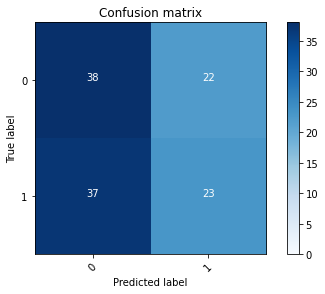

2022-08-05 22:18:03 - [Epoch Train: 16] loss: 0.0082, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-08-05 22:18:03 - [Epoch Valid: 16] loss: 1.5992, auc: 0.5725, acc: 0.5083, time: 8.00 s


 11%|████▎                                   | 16/150 [10:43<1:31:51, 41.13s/it]

2022-08-05 22:18:03 - EPOCH: 17
2022-08-05 22:18:07 - Train Step 10/107, train_loss: 0.0075
2022-08-05 22:18:09 - Train Step 20/107, train_loss: 0.0083
2022-08-05 22:18:12 - Train Step 30/107, train_loss: 0.0075
2022-08-05 22:18:15 - Train Step 40/107, train_loss: 0.0072
2022-08-05 22:18:18 - Train Step 50/107, train_loss: 0.0075
2022-08-05 22:18:21 - Train Step 60/107, train_loss: 0.0073
2022-08-05 22:18:24 - Train Step 70/107, train_loss: 0.0067
2022-08-05 22:18:27 - Train Step 80/107, train_loss: 0.0067
2022-08-05 22:18:30 - Train Step 90/107, train_loss: 0.0065
2022-08-05 22:18:33 - Train Step 100/107, train_loss: 0.0068
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:18:37 - Valid Step 5/30, valid_loss: 1.9084
2022-08-05 22:18:38 - Valid Step 10/30, valid_loss: 1.5451
2022-08-05 22:18:39 - Valid Step 15/30, valid_loss: 1.5251
2022-08-05 22:18:41 - Valid Step 20/30, valid_loss: 1.6177
2022-08-05 22:18:42 - Valid Step 25/30, valid_loss: 1.5930
2022-08-05 22:18:44 - V

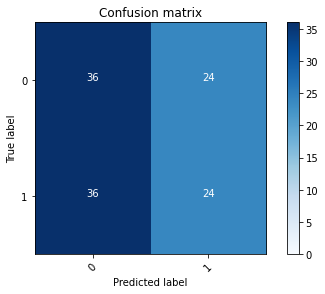

2022-08-05 22:18:44 - [Epoch Train: 17] loss: 0.0068, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-08-05 22:18:44 - [Epoch Valid: 17] loss: 1.6038, auc: 0.5731, acc: 0.5000, time: 9.00 s


 11%|████▌                                   | 17/150 [11:24<1:30:45, 40.95s/it]

2022-08-05 22:18:44 - EPOCH: 18
2022-08-05 22:18:47 - Train Step 10/107, train_loss: 0.0081
2022-08-05 22:18:50 - Train Step 20/107, train_loss: 0.0074
2022-08-05 22:18:53 - Train Step 30/107, train_loss: 0.0070
2022-08-05 22:18:56 - Train Step 40/107, train_loss: 0.0065
2022-08-05 22:18:59 - Train Step 50/107, train_loss: 0.0068
2022-08-05 22:19:02 - Train Step 60/107, train_loss: 0.0072
2022-08-05 22:19:05 - Train Step 70/107, train_loss: 0.0068
2022-08-05 22:19:08 - Train Step 80/107, train_loss: 0.0067
2022-08-05 22:19:11 - Train Step 90/107, train_loss: 0.0065
2022-08-05 22:19:14 - Train Step 100/107, train_loss: 0.0064
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:19:18 - Valid Step 5/30, valid_loss: 0.9894
2022-08-05 22:19:19 - Valid Step 10/30, valid_loss: 1.0716
2022-08-05 22:19:21 - Valid Step 15/30, valid_loss: 1.5128
2022-08-05 22:19:22 - Valid Step 20/30, valid_loss: 1.3680
2022-08-05 22:19:24 - Valid Step 25/30, valid_loss: 1.5408
2022-08-05 22:19:25 - V

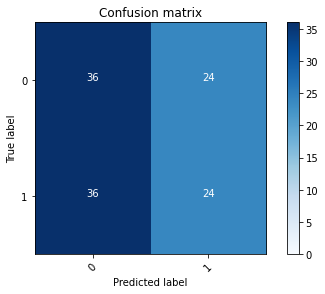

2022-08-05 22:19:26 - [Epoch Train: 18] loss: 0.0062, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-08-05 22:19:26 - [Epoch Valid: 18] loss: 1.6097, auc: 0.5797, acc: 0.5000, time: 9.00 s


 12%|████▊                                   | 18/150 [12:05<1:30:31, 41.15s/it]

2022-08-05 22:19:26 - EPOCH: 19
2022-08-05 22:19:29 - Train Step 10/107, train_loss: 0.0050
2022-08-05 22:19:32 - Train Step 20/107, train_loss: 0.0053
2022-08-05 22:19:35 - Train Step 30/107, train_loss: 0.0056
2022-08-05 22:19:39 - Train Step 40/107, train_loss: 0.0058
2022-08-05 22:19:42 - Train Step 50/107, train_loss: 0.0056
2022-08-05 22:19:45 - Train Step 60/107, train_loss: 0.0057
2022-08-05 22:19:47 - Train Step 70/107, train_loss: 0.0059
2022-08-05 22:19:50 - Train Step 80/107, train_loss: 0.0057
2022-08-05 22:19:53 - Train Step 90/107, train_loss: 0.0054
2022-08-05 22:19:56 - Train Step 100/107, train_loss: 0.0054
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:20:00 - Valid Step 5/30, valid_loss: 1.3905
2022-08-05 22:20:02 - Valid Step 10/30, valid_loss: 1.7294
2022-08-05 22:20:03 - Valid Step 15/30, valid_loss: 1.7015
2022-08-05 22:20:05 - Valid Step 20/30, valid_loss: 1.7444
2022-08-05 22:20:06 - Valid Step 25/30, valid_loss: 1.7045
2022-08-05 22:20:08 - V

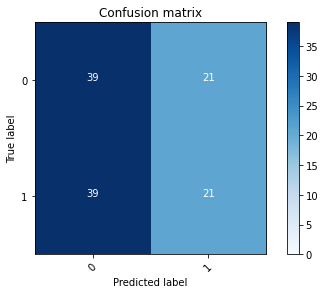

2022-08-05 22:20:08 - [Epoch Train: 19] loss: 0.0054, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-08-05 22:20:08 - [Epoch Valid: 19] loss: 1.6766, auc: 0.5778, acc: 0.5000, time: 9.00 s


 13%|█████                                   | 19/150 [12:48<1:30:36, 41.50s/it]

2022-08-05 22:20:08 - EPOCH: 20
2022-08-05 22:20:11 - Train Step 10/107, train_loss: 0.0057
2022-08-05 22:20:14 - Train Step 20/107, train_loss: 0.0047
2022-08-05 22:20:17 - Train Step 30/107, train_loss: 0.0055
2022-08-05 22:20:20 - Train Step 40/107, train_loss: 0.0057
2022-08-05 22:20:23 - Train Step 50/107, train_loss: 0.0056
2022-08-05 22:20:26 - Train Step 60/107, train_loss: 0.0058
2022-08-05 22:20:29 - Train Step 70/107, train_loss: 0.0054
2022-08-05 22:20:32 - Train Step 80/107, train_loss: 0.0056
2022-08-05 22:20:35 - Train Step 90/107, train_loss: 0.0054
2022-08-05 22:20:38 - Train Step 100/107, train_loss: 0.0054
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:20:42 - Valid Step 5/30, valid_loss: 1.1606
2022-08-05 22:20:44 - Valid Step 10/30, valid_loss: 1.5162
2022-08-05 22:20:45 - Valid Step 15/30, valid_loss: 1.5151
2022-08-05 22:20:47 - Valid Step 20/30, valid_loss: 1.5624
2022-08-05 22:20:49 - Valid Step 25/30, valid_loss: 1.6719
2022-08-05 22:20:50 - V

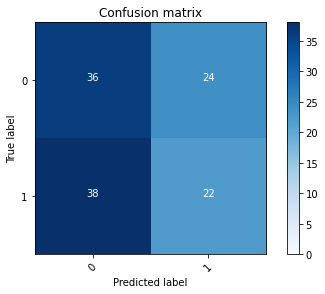

2022-08-05 22:20:50 - [Epoch Train: 20] loss: 0.0054, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-08-05 22:20:50 - [Epoch Valid: 20] loss: 1.6324, auc: 0.5728, acc: 0.4833, time: 9.00 s


 13%|█████▎                                  | 20/150 [13:30<1:30:17, 41.67s/it]

2022-08-05 22:20:50 - EPOCH: 21
2022-08-05 22:20:53 - Train Step 10/107, train_loss: 0.0036
2022-08-05 22:20:56 - Train Step 20/107, train_loss: 0.0032
2022-08-05 22:20:59 - Train Step 30/107, train_loss: 0.0033
2022-08-05 22:21:02 - Train Step 40/107, train_loss: 0.0037
2022-08-05 22:21:05 - Train Step 50/107, train_loss: 0.0039
2022-08-05 22:21:08 - Train Step 60/107, train_loss: 0.0040
2022-08-05 22:21:11 - Train Step 70/107, train_loss: 0.0039
2022-08-05 22:21:14 - Train Step 80/107, train_loss: 0.0040
2022-08-05 22:21:17 - Train Step 90/107, train_loss: 0.0042
2022-08-05 22:21:20 - Train Step 100/107, train_loss: 0.0042
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:21:24 - Valid Step 5/30, valid_loss: 1.2936
2022-08-05 22:21:25 - Valid Step 10/30, valid_loss: 1.0486
2022-08-05 22:21:27 - Valid Step 15/30, valid_loss: 1.5076
2022-08-05 22:21:28 - Valid Step 20/30, valid_loss: 1.8713
2022-08-05 22:21:30 - Valid Step 25/30, valid_loss: 1.8548
2022-08-05 22:21:31 - V

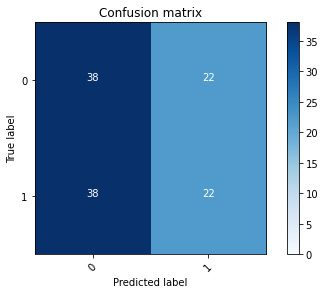

2022-08-05 22:21:31 - [Epoch Train: 21] loss: 0.0042, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-08-05 22:21:31 - [Epoch Valid: 21] loss: 1.8014, auc: 0.5717, acc: 0.5000, time: 9.00 s


 14%|█████▌                                  | 21/150 [14:11<1:29:22, 41.57s/it]

2022-08-05 22:21:31 - EPOCH: 22
2022-08-05 22:21:35 - Train Step 10/107, train_loss: 0.0030
2022-08-05 22:21:38 - Train Step 20/107, train_loss: 0.0031
2022-08-05 22:21:41 - Train Step 30/107, train_loss: 0.0032
2022-08-05 22:21:44 - Train Step 40/107, train_loss: 0.0034
2022-08-05 22:21:46 - Train Step 50/107, train_loss: 0.0033
2022-08-05 22:21:49 - Train Step 60/107, train_loss: 0.0033
2022-08-05 22:21:52 - Train Step 70/107, train_loss: 0.0033
2022-08-05 22:21:55 - Train Step 80/107, train_loss: 0.0032
2022-08-05 22:21:58 - Train Step 90/107, train_loss: 0.0032
2022-08-05 22:22:00 - Train Step 100/107, train_loss: 0.0034
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:22:04 - Valid Step 5/30, valid_loss: 1.2527
2022-08-05 22:22:06 - Valid Step 10/30, valid_loss: 1.6787
2022-08-05 22:22:07 - Valid Step 15/30, valid_loss: 2.0193
2022-08-05 22:22:09 - Valid Step 20/30, valid_loss: 1.8400
2022-08-05 22:22:10 - Valid Step 25/30, valid_loss: 1.7671
2022-08-05 22:22:12 - V

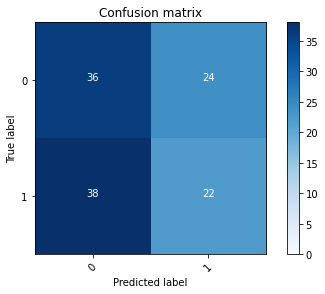

2022-08-05 22:22:12 - [Epoch Train: 22] loss: 0.0037, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-08-05 22:22:12 - [Epoch Valid: 22] loss: 1.7298, auc: 0.5714, acc: 0.4833, time: 9.00 s


 15%|█████▊                                  | 22/150 [14:52<1:28:09, 41.32s/it]

2022-08-05 22:22:12 - EPOCH: 23
2022-08-05 22:22:15 - Train Step 10/107, train_loss: 0.0023
2022-08-05 22:22:19 - Train Step 20/107, train_loss: 0.0027
2022-08-05 22:22:22 - Train Step 30/107, train_loss: 0.0031
2022-08-05 22:22:25 - Train Step 40/107, train_loss: 0.0030
2022-08-05 22:22:29 - Train Step 50/107, train_loss: 0.0030
2022-08-05 22:22:32 - Train Step 60/107, train_loss: 0.0030
2022-08-05 22:22:34 - Train Step 70/107, train_loss: 0.0031
2022-08-05 22:22:37 - Train Step 80/107, train_loss: 0.0031
2022-08-05 22:22:40 - Train Step 90/107, train_loss: 0.0029
2022-08-05 22:22:43 - Train Step 100/107, train_loss: 0.0030
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:22:46 - Valid Step 5/30, valid_loss: 2.0478
2022-08-05 22:22:48 - Valid Step 10/30, valid_loss: 1.9111
2022-08-05 22:22:49 - Valid Step 15/30, valid_loss: 2.0176
2022-08-05 22:22:50 - Valid Step 20/30, valid_loss: 1.8799
2022-08-05 22:22:52 - Valid Step 25/30, valid_loss: 1.9447
2022-08-05 22:22:53 - V

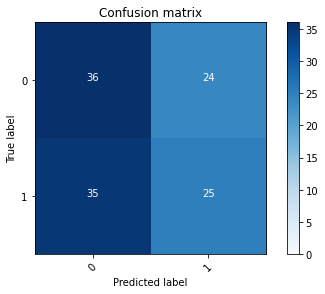

2022-08-05 22:22:53 - [Epoch Train: 23] loss: 0.0030, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-08-05 22:22:53 - [Epoch Valid: 23] loss: 1.8645, auc: 0.5806, acc: 0.5083, time: 8.00 s


 15%|██████▏                                 | 23/150 [15:33<1:27:31, 41.35s/it]

2022-08-05 22:22:53 - EPOCH: 24
2022-08-05 22:22:57 - Train Step 10/107, train_loss: 0.0025
2022-08-05 22:22:59 - Train Step 20/107, train_loss: 0.0024
2022-08-05 22:23:02 - Train Step 30/107, train_loss: 0.0023
2022-08-05 22:23:05 - Train Step 40/107, train_loss: 0.0025
2022-08-05 22:23:08 - Train Step 50/107, train_loss: 0.0029
2022-08-05 22:23:11 - Train Step 60/107, train_loss: 0.0028
2022-08-05 22:23:14 - Train Step 70/107, train_loss: 0.0029
2022-08-05 22:23:17 - Train Step 80/107, train_loss: 0.0029
2022-08-05 22:23:19 - Train Step 90/107, train_loss: 0.0028
2022-08-05 22:23:22 - Train Step 100/107, train_loss: 0.0026
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:23:26 - Valid Step 5/30, valid_loss: 2.6073
2022-08-05 22:23:27 - Valid Step 10/30, valid_loss: 2.5539
2022-08-05 22:23:29 - Valid Step 15/30, valid_loss: 1.9662
2022-08-05 22:23:30 - Valid Step 20/30, valid_loss: 1.9388
2022-08-05 22:23:31 - Valid Step 25/30, valid_loss: 2.0638
2022-08-05 22:23:33 - V

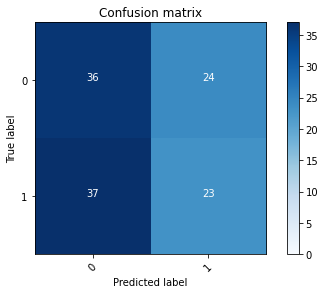

2022-08-05 22:23:33 - [Epoch Train: 24] loss: 0.0026, auc: 1.0000, acc: 1.0000, time: 30.00 s            
2022-08-05 22:23:33 - [Epoch Valid: 24] loss: 1.9528, auc: 0.5744, acc: 0.4917, time: 8.00 s


 16%|██████▍                                 | 24/150 [16:13<1:25:44, 40.83s/it]

2022-08-05 22:23:33 - EPOCH: 25
2022-08-05 22:23:36 - Train Step 10/107, train_loss: 0.0022
2022-08-05 22:23:39 - Train Step 20/107, train_loss: 0.0022
2022-08-05 22:23:42 - Train Step 30/107, train_loss: 0.0026
2022-08-05 22:23:45 - Train Step 40/107, train_loss: 0.0024
2022-08-05 22:23:48 - Train Step 50/107, train_loss: 0.0025
2022-08-05 22:23:50 - Train Step 60/107, train_loss: 0.0027
2022-08-05 22:23:53 - Train Step 70/107, train_loss: 0.0026
2022-08-05 22:23:56 - Train Step 80/107, train_loss: 0.0027
2022-08-05 22:23:59 - Train Step 90/107, train_loss: 0.0026
2022-08-05 22:24:01 - Train Step 100/107, train_loss: 0.0025
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:24:05 - Valid Step 5/30, valid_loss: 1.9108
2022-08-05 22:24:06 - Valid Step 10/30, valid_loss: 1.9982
2022-08-05 22:24:08 - Valid Step 15/30, valid_loss: 1.7594
2022-08-05 22:24:09 - Valid Step 20/30, valid_loss: 1.6376
2022-08-05 22:24:11 - Valid Step 25/30, valid_loss: 1.7180
2022-08-05 22:24:12 - V

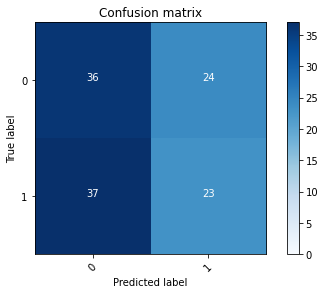

2022-08-05 22:24:12 - [Epoch Train: 25] loss: 0.0025, auc: 1.0000, acc: 1.0000, time: 30.00 s            
2022-08-05 22:24:12 - [Epoch Valid: 25] loss: 1.9357, auc: 0.5731, acc: 0.4917, time: 9.00 s


 17%|██████▋                                 | 25/150 [16:52<1:24:08, 40.39s/it]

2022-08-05 22:24:12 - EPOCH: 26
2022-08-05 22:24:16 - Train Step 10/107, train_loss: 0.0021
2022-08-05 22:24:18 - Train Step 20/107, train_loss: 0.0023
2022-08-05 22:24:21 - Train Step 30/107, train_loss: 0.0023
2022-08-05 22:24:24 - Train Step 40/107, train_loss: 0.0021
2022-08-05 22:24:27 - Train Step 50/107, train_loss: 0.0020
2022-08-05 22:24:30 - Train Step 60/107, train_loss: 0.0019
2022-08-05 22:24:33 - Train Step 70/107, train_loss: 0.0019
2022-08-05 22:24:35 - Train Step 80/107, train_loss: 0.0020
2022-08-05 22:24:38 - Train Step 90/107, train_loss: 0.0020
2022-08-05 22:24:41 - Train Step 100/107, train_loss: 0.0020
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:24:45 - Valid Step 5/30, valid_loss: 1.5607
2022-08-05 22:24:46 - Valid Step 10/30, valid_loss: 2.3026
2022-08-05 22:24:48 - Valid Step 15/30, valid_loss: 2.2770
2022-08-05 22:24:49 - Valid Step 20/30, valid_loss: 1.9590
2022-08-05 22:24:50 - Valid Step 25/30, valid_loss: 1.8916
2022-08-05 22:24:51 - V

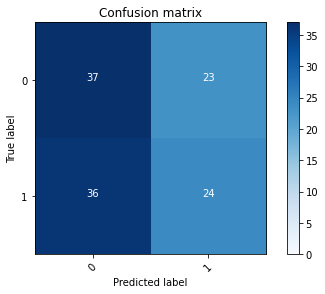

2022-08-05 22:24:52 - [Epoch Train: 26] loss: 0.0020, auc: 1.0000, acc: 1.0000, time: 30.00 s            
2022-08-05 22:24:52 - [Epoch Valid: 26] loss: 1.8803, auc: 0.5806, acc: 0.5083, time: 8.00 s


 17%|██████▉                                 | 26/150 [17:31<1:22:49, 40.07s/it]

2022-08-05 22:24:52 - EPOCH: 27
2022-08-05 22:24:55 - Train Step 10/107, train_loss: 0.0013
2022-08-05 22:24:58 - Train Step 20/107, train_loss: 0.0013
2022-08-05 22:25:01 - Train Step 30/107, train_loss: 0.0018
2022-08-05 22:25:03 - Train Step 40/107, train_loss: 0.0017
2022-08-05 22:25:06 - Train Step 50/107, train_loss: 0.0018
2022-08-05 22:25:09 - Train Step 60/107, train_loss: 0.0020
2022-08-05 22:25:12 - Train Step 70/107, train_loss: 0.0019
2022-08-05 22:25:15 - Train Step 80/107, train_loss: 0.0020
2022-08-05 22:25:18 - Train Step 90/107, train_loss: 0.0020
2022-08-05 22:25:21 - Train Step 100/107, train_loss: 0.0020
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:25:24 - Valid Step 5/30, valid_loss: 2.6524
2022-08-05 22:25:25 - Valid Step 10/30, valid_loss: 2.0702
2022-08-05 22:25:27 - Valid Step 15/30, valid_loss: 2.2450
2022-08-05 22:25:28 - Valid Step 20/30, valid_loss: 2.0458
2022-08-05 22:25:30 - Valid Step 25/30, valid_loss: 1.9207
2022-08-05 22:25:31 - V

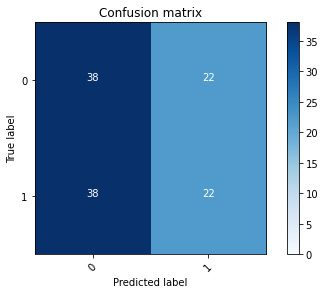

2022-08-05 22:25:31 - [Epoch Train: 27] loss: 0.0020, auc: 1.0000, acc: 1.0000, time: 30.00 s            
2022-08-05 22:25:31 - [Epoch Valid: 27] loss: 1.9439, auc: 0.5758, acc: 0.5000, time: 8.00 s


 18%|███████▏                                | 27/150 [18:11<1:21:42, 39.86s/it]

2022-08-05 22:25:31 - EPOCH: 28
2022-08-05 22:25:34 - Train Step 10/107, train_loss: 0.0030
2022-08-05 22:25:37 - Train Step 20/107, train_loss: 0.0023
2022-08-05 22:25:40 - Train Step 30/107, train_loss: 0.0018
2022-08-05 22:25:42 - Train Step 40/107, train_loss: 0.0017
2022-08-05 22:25:45 - Train Step 50/107, train_loss: 0.0017
2022-08-05 22:25:48 - Train Step 60/107, train_loss: 0.0018
2022-08-05 22:25:50 - Train Step 70/107, train_loss: 0.0017
2022-08-05 22:25:53 - Train Step 80/107, train_loss: 0.0017
2022-08-05 22:25:56 - Train Step 90/107, train_loss: 0.0017
2022-08-05 22:25:58 - Train Step 100/107, train_loss: 0.0018
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:26:02 - Valid Step 5/30, valid_loss: 2.5559
2022-08-05 22:26:03 - Valid Step 10/30, valid_loss: 2.2601
2022-08-05 22:26:05 - Valid Step 15/30, valid_loss: 2.3115
2022-08-05 22:26:06 - Valid Step 20/30, valid_loss: 2.2044
2022-08-05 22:26:07 - Valid Step 25/30, valid_loss: 2.0690
2022-08-05 22:26:09 - V

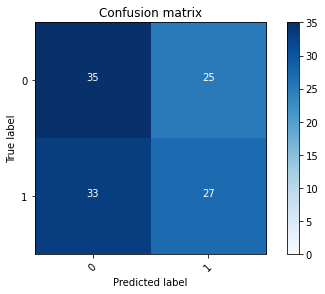

2022-08-05 22:26:09 - [Epoch Train: 28] loss: 0.0018, auc: 1.0000, acc: 1.0000, time: 29.00 s            
2022-08-05 22:26:09 - [Epoch Valid: 28] loss: 2.0407, auc: 0.5717, acc: 0.5167, time: 8.00 s


 19%|███████▍                                | 28/150 [18:49<1:19:54, 39.30s/it]

2022-08-05 22:26:09 - EPOCH: 29
2022-08-05 22:26:12 - Train Step 10/107, train_loss: 0.0011
2022-08-05 22:26:15 - Train Step 20/107, train_loss: 0.0015
2022-08-05 22:26:18 - Train Step 30/107, train_loss: 0.0013
2022-08-05 22:26:21 - Train Step 40/107, train_loss: 0.0014
2022-08-05 22:26:24 - Train Step 50/107, train_loss: 0.0014
2022-08-05 22:26:26 - Train Step 60/107, train_loss: 0.0013
2022-08-05 22:26:29 - Train Step 70/107, train_loss: 0.0014
2022-08-05 22:26:32 - Train Step 80/107, train_loss: 0.0013
2022-08-05 22:26:35 - Train Step 90/107, train_loss: 0.0013
2022-08-05 22:26:38 - Train Step 100/107, train_loss: 0.0013
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:26:41 - Valid Step 5/30, valid_loss: 2.0591
2022-08-05 22:26:43 - Valid Step 10/30, valid_loss: 2.0064
2022-08-05 22:26:44 - Valid Step 15/30, valid_loss: 2.0650
2022-08-05 22:26:46 - Valid Step 20/30, valid_loss: 2.3268
2022-08-05 22:26:47 - Valid Step 25/30, valid_loss: 2.2809
2022-08-05 22:26:48 - V

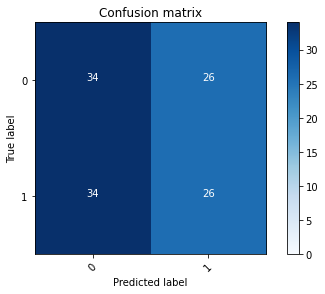

2022-08-05 22:26:49 - [Epoch Train: 29] loss: 0.0013, auc: 1.0000, acc: 1.0000, time: 30.00 s            
2022-08-05 22:26:49 - [Epoch Valid: 29] loss: 2.0830, auc: 0.5793, acc: 0.5000, time: 9.00 s


 19%|███████▋                                | 29/150 [19:28<1:19:24, 39.38s/it]

2022-08-05 22:26:49 - EPOCH: 30
2022-08-05 22:26:52 - Train Step 10/107, train_loss: 0.0016
2022-08-05 22:26:55 - Train Step 20/107, train_loss: 0.0022
2022-08-05 22:26:57 - Train Step 30/107, train_loss: 0.0018
2022-08-05 22:27:00 - Train Step 40/107, train_loss: 0.0016
2022-08-05 22:27:03 - Train Step 50/107, train_loss: 0.0016
2022-08-05 22:27:06 - Train Step 60/107, train_loss: 0.0015
2022-08-05 22:27:08 - Train Step 70/107, train_loss: 0.0015
2022-08-05 22:27:11 - Train Step 80/107, train_loss: 0.0015
2022-08-05 22:27:14 - Train Step 90/107, train_loss: 0.0014
2022-08-05 22:27:17 - Train Step 100/107, train_loss: 0.0014
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:27:21 - Valid Step 5/30, valid_loss: 2.4560
2022-08-05 22:27:22 - Valid Step 10/30, valid_loss: 2.2610
2022-08-05 22:27:24 - Valid Step 15/30, valid_loss: 2.3853
2022-08-05 22:27:25 - Valid Step 20/30, valid_loss: 2.1001
2022-08-05 22:27:26 - Valid Step 25/30, valid_loss: 2.3490
2022-08-05 22:27:28 - V

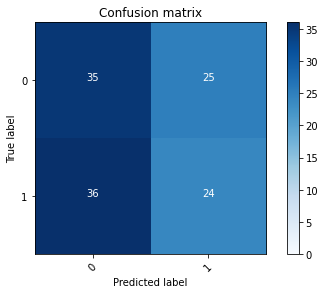

2022-08-05 22:27:28 - [Epoch Train: 30] loss: 0.0014, auc: 1.0000, acc: 1.0000, time: 30.00 s            
2022-08-05 22:27:28 - [Epoch Valid: 30] loss: 2.1614, auc: 0.5751, acc: 0.4917, time: 9.00 s


 20%|████████                                | 30/150 [20:08<1:18:44, 39.37s/it]

2022-08-05 22:27:28 - EPOCH: 31
2022-08-05 22:27:31 - Train Step 10/107, train_loss: 0.0010
2022-08-05 22:27:34 - Train Step 20/107, train_loss: 0.0013
2022-08-05 22:27:37 - Train Step 30/107, train_loss: 0.0014
2022-08-05 22:27:40 - Train Step 40/107, train_loss: 0.0013
2022-08-05 22:27:43 - Train Step 50/107, train_loss: 0.0014
2022-08-05 22:27:46 - Train Step 60/107, train_loss: 0.0013
2022-08-05 22:27:49 - Train Step 70/107, train_loss: 0.0014
2022-08-05 22:27:52 - Train Step 80/107, train_loss: 0.0014
2022-08-05 22:27:55 - Train Step 90/107, train_loss: 0.0014
2022-08-05 22:27:58 - Train Step 100/107, train_loss: 0.0014
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:28:01 - Valid Step 5/30, valid_loss: 1.0853
2022-08-05 22:28:02 - Valid Step 10/30, valid_loss: 2.0504
2022-08-05 22:28:04 - Valid Step 15/30, valid_loss: 2.1531
2022-08-05 22:28:05 - Valid Step 20/30, valid_loss: 2.1103
2022-08-05 22:28:07 - Valid Step 25/30, valid_loss: 2.0234
2022-08-05 22:28:08 - V

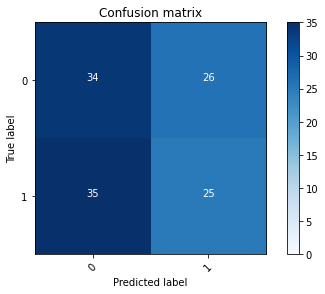

2022-08-05 22:28:08 - [Epoch Train: 31] loss: 0.0015, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-08-05 22:28:08 - [Epoch Valid: 31] loss: 2.0512, auc: 0.5747, acc: 0.4917, time: 8.00 s


 21%|████████▎                               | 31/150 [20:48<1:18:30, 39.58s/it]

2022-08-05 22:28:08 - EPOCH: 32
2022-08-05 22:28:11 - Train Step 10/107, train_loss: 0.0011
2022-08-05 22:28:14 - Train Step 20/107, train_loss: 0.0011
2022-08-05 22:28:17 - Train Step 30/107, train_loss: 0.0013
2022-08-05 22:28:19 - Train Step 40/107, train_loss: 0.0015
2022-08-05 22:28:22 - Train Step 50/107, train_loss: 0.0013
2022-08-05 22:28:25 - Train Step 60/107, train_loss: 0.0012
2022-08-05 22:28:28 - Train Step 70/107, train_loss: 0.0012
2022-08-05 22:28:31 - Train Step 80/107, train_loss: 0.0013
2022-08-05 22:28:33 - Train Step 90/107, train_loss: 0.0013
2022-08-05 22:28:36 - Train Step 100/107, train_loss: 0.0013
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:28:40 - Valid Step 5/30, valid_loss: 2.2064
2022-08-05 22:28:41 - Valid Step 10/30, valid_loss: 1.7533
2022-08-05 22:28:42 - Valid Step 15/30, valid_loss: 1.7542
2022-08-05 22:28:44 - Valid Step 20/30, valid_loss: 1.7883
2022-08-05 22:28:45 - Valid Step 25/30, valid_loss: 1.9272
2022-08-05 22:28:46 - V

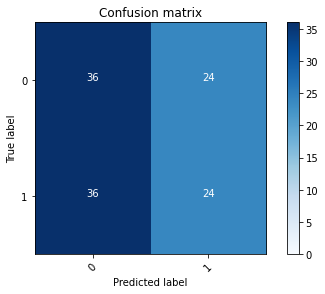

2022-08-05 22:28:46 - [Epoch Train: 32] loss: 0.0013, auc: 1.0000, acc: 1.0000, time: 29.00 s            
2022-08-05 22:28:46 - [Epoch Valid: 32] loss: 1.9886, auc: 0.5756, acc: 0.5000, time: 8.00 s


 21%|████████▌                               | 32/150 [21:26<1:17:06, 39.21s/it]

2022-08-05 22:28:46 - EPOCH: 33
2022-08-05 22:28:50 - Train Step 10/107, train_loss: 0.0008
2022-08-05 22:28:53 - Train Step 20/107, train_loss: 0.0008
2022-08-05 22:28:56 - Train Step 30/107, train_loss: 0.0013
2022-08-05 22:28:59 - Train Step 40/107, train_loss: 0.0012
2022-08-05 22:29:02 - Train Step 50/107, train_loss: 0.0011
2022-08-05 22:29:05 - Train Step 60/107, train_loss: 0.0012
2022-08-05 22:29:08 - Train Step 70/107, train_loss: 0.0011
2022-08-05 22:29:11 - Train Step 80/107, train_loss: 0.0011
2022-08-05 22:29:14 - Train Step 90/107, train_loss: 0.0010
2022-08-05 22:29:17 - Train Step 100/107, train_loss: 0.0011
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:29:21 - Valid Step 5/30, valid_loss: 1.7985
2022-08-05 22:29:22 - Valid Step 10/30, valid_loss: 1.9083
2022-08-05 22:29:23 - Valid Step 15/30, valid_loss: 2.2594
2022-08-05 22:29:24 - Valid Step 20/30, valid_loss: 2.2128
2022-08-05 22:29:26 - Valid Step 25/30, valid_loss: 2.0488
2022-08-05 22:29:27 - V

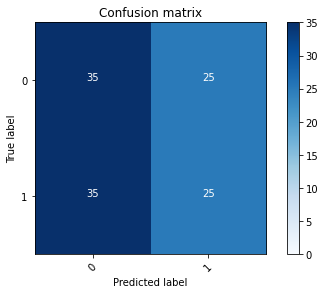

2022-08-05 22:29:27 - [Epoch Train: 33] loss: 0.0010, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-08-05 22:29:27 - [Epoch Valid: 33] loss: 2.0805, auc: 0.5746, acc: 0.5000, time: 8.00 s


 22%|████████▊                               | 33/150 [22:07<1:17:28, 39.73s/it]

2022-08-05 22:29:27 - EPOCH: 34
2022-08-05 22:29:30 - Train Step 10/107, train_loss: 0.0010
2022-08-05 22:29:33 - Train Step 20/107, train_loss: 0.0012
2022-08-05 22:29:36 - Train Step 30/107, train_loss: 0.0010
2022-08-05 22:29:39 - Train Step 40/107, train_loss: 0.0009
2022-08-05 22:29:41 - Train Step 50/107, train_loss: 0.0009
2022-08-05 22:29:44 - Train Step 60/107, train_loss: 0.0010
2022-08-05 22:29:47 - Train Step 70/107, train_loss: 0.0010
2022-08-05 22:29:49 - Train Step 80/107, train_loss: 0.0010
2022-08-05 22:29:52 - Train Step 90/107, train_loss: 0.0010
2022-08-05 22:29:55 - Train Step 100/107, train_loss: 0.0009
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:29:58 - Valid Step 5/30, valid_loss: 2.5996
2022-08-05 22:29:59 - Valid Step 10/30, valid_loss: 1.7978
2022-08-05 22:30:01 - Valid Step 15/30, valid_loss: 2.0785
2022-08-05 22:30:02 - Valid Step 20/30, valid_loss: 2.2425
2022-08-05 22:30:04 - Valid Step 25/30, valid_loss: 2.1802
2022-08-05 22:30:05 - V

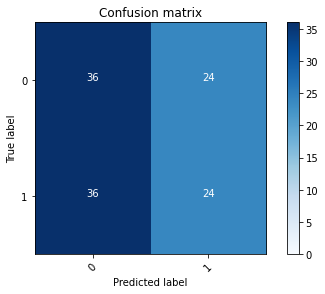

2022-08-05 22:30:05 - [Epoch Train: 34] loss: 0.0010, auc: 1.0000, acc: 1.0000, time: 29.00 s            
2022-08-05 22:30:05 - [Epoch Valid: 34] loss: 2.1035, auc: 0.5749, acc: 0.5000, time: 8.00 s


 23%|█████████                               | 34/150 [22:45<1:15:33, 39.09s/it]

2022-08-05 22:30:05 - EPOCH: 35
2022-08-05 22:30:08 - Train Step 10/107, train_loss: 0.0007
2022-08-05 22:30:11 - Train Step 20/107, train_loss: 0.0008
2022-08-05 22:30:14 - Train Step 30/107, train_loss: 0.0010
2022-08-05 22:30:17 - Train Step 40/107, train_loss: 0.0009
2022-08-05 22:30:20 - Train Step 50/107, train_loss: 0.0008
2022-08-05 22:30:22 - Train Step 60/107, train_loss: 0.0009
2022-08-05 22:30:25 - Train Step 70/107, train_loss: 0.0008
2022-08-05 22:30:28 - Train Step 80/107, train_loss: 0.0008
2022-08-05 22:30:31 - Train Step 90/107, train_loss: 0.0008
2022-08-05 22:30:34 - Train Step 100/107, train_loss: 0.0008
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:30:37 - Valid Step 5/30, valid_loss: 2.4587
2022-08-05 22:30:39 - Valid Step 10/30, valid_loss: 2.1117
2022-08-05 22:30:40 - Valid Step 15/30, valid_loss: 2.0337
2022-08-05 22:30:41 - Valid Step 20/30, valid_loss: 2.2436
2022-08-05 22:30:43 - Valid Step 25/30, valid_loss: 2.1266
2022-08-05 22:30:44 - V

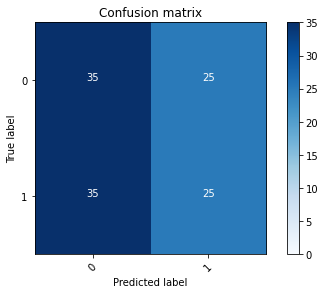

2022-08-05 22:30:44 - [Epoch Train: 35] loss: 0.0009, auc: 1.0000, acc: 1.0000, time: 30.00 s            
2022-08-05 22:30:44 - [Epoch Valid: 35] loss: 2.1347, auc: 0.5768, acc: 0.5000, time: 8.00 s


 23%|█████████▎                              | 35/150 [23:24<1:15:01, 39.15s/it]

2022-08-05 22:30:44 - EPOCH: 36
2022-08-05 22:30:47 - Train Step 10/107, train_loss: 0.0009
2022-08-05 22:30:50 - Train Step 20/107, train_loss: 0.0008
2022-08-05 22:30:53 - Train Step 30/107, train_loss: 0.0008
2022-08-05 22:30:55 - Train Step 40/107, train_loss: 0.0008
2022-08-05 22:30:58 - Train Step 50/107, train_loss: 0.0007
2022-08-05 22:31:00 - Train Step 60/107, train_loss: 0.0007
2022-08-05 22:31:03 - Train Step 70/107, train_loss: 0.0006
2022-08-05 22:31:06 - Train Step 80/107, train_loss: 0.0006
2022-08-05 22:31:08 - Train Step 90/107, train_loss: 0.0006
2022-08-05 22:31:11 - Train Step 100/107, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:31:15 - Valid Step 5/30, valid_loss: 2.0045
2022-08-05 22:31:16 - Valid Step 10/30, valid_loss: 2.3044
2022-08-05 22:31:17 - Valid Step 15/30, valid_loss: 2.4637
2022-08-05 22:31:19 - Valid Step 20/30, valid_loss: 2.3863
2022-08-05 22:31:20 - Valid Step 25/30, valid_loss: 2.3917
2022-08-05 22:31:21 - V

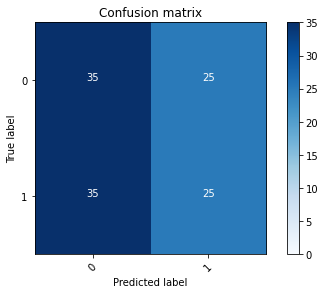

2022-08-05 22:31:22 - [Epoch Train: 36] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 28.00 s            
2022-08-05 22:31:22 - [Epoch Valid: 36] loss: 2.3291, auc: 0.5779, acc: 0.5000, time: 8.00 s


 24%|█████████▌                              | 36/150 [24:01<1:13:21, 38.61s/it]

2022-08-05 22:31:22 - EPOCH: 37
2022-08-05 22:31:25 - Train Step 10/107, train_loss: 0.0007
2022-08-05 22:31:28 - Train Step 20/107, train_loss: 0.0007
2022-08-05 22:31:31 - Train Step 30/107, train_loss: 0.0007
2022-08-05 22:31:33 - Train Step 40/107, train_loss: 0.0007
2022-08-05 22:31:36 - Train Step 50/107, train_loss: 0.0006
2022-08-05 22:31:39 - Train Step 60/107, train_loss: 0.0006
2022-08-05 22:31:42 - Train Step 70/107, train_loss: 0.0007
2022-08-05 22:31:44 - Train Step 80/107, train_loss: 0.0007
2022-08-05 22:31:47 - Train Step 90/107, train_loss: 0.0007
2022-08-05 22:31:50 - Train Step 100/107, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:31:53 - Valid Step 5/30, valid_loss: 1.0330
2022-08-05 22:31:55 - Valid Step 10/30, valid_loss: 1.7006
2022-08-05 22:31:56 - Valid Step 15/30, valid_loss: 1.9576
2022-08-05 22:31:58 - Valid Step 20/30, valid_loss: 1.9754
2022-08-05 22:31:59 - Valid Step 25/30, valid_loss: 2.3221
2022-08-05 22:32:00 - V

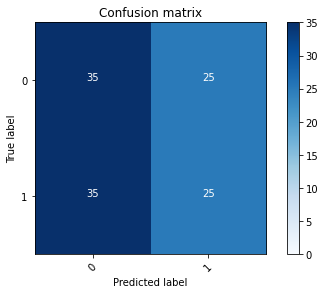

2022-08-05 22:32:01 - [Epoch Train: 37] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 29.00 s            
2022-08-05 22:32:01 - [Epoch Valid: 37] loss: 2.1898, auc: 0.5751, acc: 0.5000, time: 9.00 s


 25%|█████████▊                              | 37/150 [24:40<1:12:57, 38.74s/it]

2022-08-05 22:32:01 - EPOCH: 38
2022-08-05 22:32:04 - Train Step 10/107, train_loss: 0.0008
2022-08-05 22:32:07 - Train Step 20/107, train_loss: 0.0007
2022-08-05 22:32:10 - Train Step 30/107, train_loss: 0.0007
2022-08-05 22:32:13 - Train Step 40/107, train_loss: 0.0008
2022-08-05 22:32:16 - Train Step 50/107, train_loss: 0.0007
2022-08-05 22:32:18 - Train Step 60/107, train_loss: 0.0007
2022-08-05 22:32:21 - Train Step 70/107, train_loss: 0.0006
2022-08-05 22:32:24 - Train Step 80/107, train_loss: 0.0007
2022-08-05 22:32:27 - Train Step 90/107, train_loss: 0.0007
2022-08-05 22:32:30 - Train Step 100/107, train_loss: 0.0006
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:32:34 - Valid Step 5/30, valid_loss: 1.5690
2022-08-05 22:32:35 - Valid Step 10/30, valid_loss: 2.3444
2022-08-05 22:32:37 - Valid Step 15/30, valid_loss: 2.9399
2022-08-05 22:32:38 - Valid Step 20/30, valid_loss: 2.5211
2022-08-05 22:32:40 - Valid Step 25/30, valid_loss: 2.4096
2022-08-05 22:32:41 - V

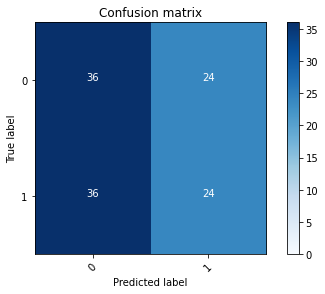

2022-08-05 22:32:42 - [Epoch Train: 38] loss: 0.0006, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-08-05 22:32:42 - [Epoch Valid: 38] loss: 2.2809, auc: 0.5757, acc: 0.5000, time: 9.00 s


 25%|██████████▏                             | 38/150 [25:21<1:13:28, 39.36s/it]

2022-08-05 22:32:42 - EPOCH: 39
2022-08-05 22:32:45 - Train Step 10/107, train_loss: 0.0005
2022-08-05 22:32:47 - Train Step 20/107, train_loss: 0.0005
2022-08-05 22:32:50 - Train Step 30/107, train_loss: 0.0008
2022-08-05 22:32:53 - Train Step 40/107, train_loss: 0.0007
2022-08-05 22:32:55 - Train Step 50/107, train_loss: 0.0007
2022-08-05 22:32:58 - Train Step 60/107, train_loss: 0.0007
2022-08-05 22:33:01 - Train Step 70/107, train_loss: 0.0007
2022-08-05 22:33:04 - Train Step 80/107, train_loss: 0.0007
2022-08-05 22:33:06 - Train Step 90/107, train_loss: 0.0007
2022-08-05 22:33:09 - Train Step 100/107, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:33:13 - Valid Step 5/30, valid_loss: 4.8442
2022-08-05 22:33:14 - Valid Step 10/30, valid_loss: 3.1176
2022-08-05 22:33:16 - Valid Step 15/30, valid_loss: 2.5998
2022-08-05 22:33:17 - Valid Step 20/30, valid_loss: 2.3711
2022-08-05 22:33:18 - Valid Step 25/30, valid_loss: 2.3948
2022-08-05 22:33:19 - V

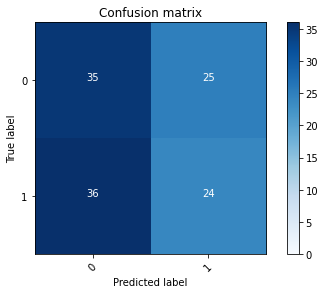

2022-08-05 22:33:20 - [Epoch Train: 39] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 29.00 s            
2022-08-05 22:33:20 - [Epoch Valid: 39] loss: 2.3624, auc: 0.5776, acc: 0.4917, time: 8.00 s


 26%|██████████▍                             | 39/150 [25:59<1:12:12, 39.03s/it]

2022-08-05 22:33:20 - EPOCH: 40
2022-08-05 22:33:23 - Train Step 10/107, train_loss: 0.0009
2022-08-05 22:33:26 - Train Step 20/107, train_loss: 0.0007
2022-08-05 22:33:28 - Train Step 30/107, train_loss: 0.0007
2022-08-05 22:33:31 - Train Step 40/107, train_loss: 0.0006
2022-08-05 22:33:34 - Train Step 50/107, train_loss: 0.0006
2022-08-05 22:33:37 - Train Step 60/107, train_loss: 0.0006
2022-08-05 22:33:40 - Train Step 70/107, train_loss: 0.0006
2022-08-05 22:33:42 - Train Step 80/107, train_loss: 0.0005
2022-08-05 22:33:45 - Train Step 90/107, train_loss: 0.0006
2022-08-05 22:33:48 - Train Step 100/107, train_loss: 0.0006
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:33:52 - Valid Step 5/30, valid_loss: 1.2982
2022-08-05 22:33:53 - Valid Step 10/30, valid_loss: 1.6451
2022-08-05 22:33:55 - Valid Step 15/30, valid_loss: 2.1270
2022-08-05 22:33:56 - Valid Step 20/30, valid_loss: 2.1959
2022-08-05 22:33:58 - Valid Step 25/30, valid_loss: 2.3872
2022-08-05 22:33:59 - V

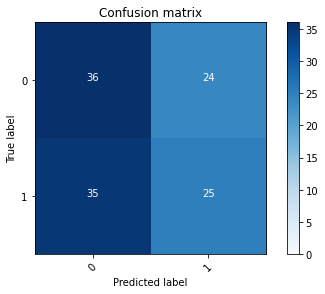

2022-08-05 22:33:59 - [Epoch Train: 40] loss: 0.0006, auc: 1.0000, acc: 1.0000, time: 30.00 s            
2022-08-05 22:33:59 - [Epoch Valid: 40] loss: 2.2576, auc: 0.5743, acc: 0.5083, time: 9.00 s


 27%|██████████▋                             | 40/150 [26:39<1:11:39, 39.09s/it]

2022-08-05 22:33:59 - EPOCH: 41
2022-08-05 22:34:02 - Train Step 10/107, train_loss: 0.0004
2022-08-05 22:34:05 - Train Step 20/107, train_loss: 0.0003
2022-08-05 22:34:08 - Train Step 30/107, train_loss: 0.0004
2022-08-05 22:34:11 - Train Step 40/107, train_loss: 0.0004
2022-08-05 22:34:14 - Train Step 50/107, train_loss: 0.0005
2022-08-05 22:34:17 - Train Step 60/107, train_loss: 0.0005
2022-08-05 22:34:19 - Train Step 70/107, train_loss: 0.0004
2022-08-05 22:34:22 - Train Step 80/107, train_loss: 0.0005
2022-08-05 22:34:25 - Train Step 90/107, train_loss: 0.0004
2022-08-05 22:34:28 - Train Step 100/107, train_loss: 0.0005
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:34:32 - Valid Step 5/30, valid_loss: 2.2939
2022-08-05 22:34:33 - Valid Step 10/30, valid_loss: 2.4895
2022-08-05 22:34:34 - Valid Step 15/30, valid_loss: 2.1216
2022-08-05 22:34:36 - Valid Step 20/30, valid_loss: 2.2764
2022-08-05 22:34:37 - Valid Step 25/30, valid_loss: 2.1697
2022-08-05 22:34:39 - V

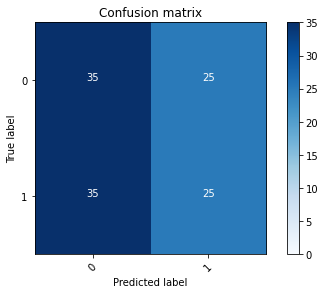

2022-08-05 22:34:39 - [Epoch Train: 41] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 30.00 s            
2022-08-05 22:34:39 - [Epoch Valid: 41] loss: 2.3395, auc: 0.5754, acc: 0.5000, time: 9.00 s


 27%|██████████▉                             | 41/150 [27:19<1:11:28, 39.34s/it]

2022-08-05 22:34:39 - EPOCH: 42
2022-08-05 22:34:42 - Train Step 10/107, train_loss: 0.0004
2022-08-05 22:34:45 - Train Step 20/107, train_loss: 0.0005
2022-08-05 22:34:48 - Train Step 30/107, train_loss: 0.0006
2022-08-05 22:34:51 - Train Step 40/107, train_loss: 0.0005
2022-08-05 22:34:54 - Train Step 50/107, train_loss: 0.0004
2022-08-05 22:34:57 - Train Step 60/107, train_loss: 0.0004
2022-08-05 22:35:00 - Train Step 70/107, train_loss: 0.0004
2022-08-05 22:35:02 - Train Step 80/107, train_loss: 0.0004
2022-08-05 22:35:05 - Train Step 90/107, train_loss: 0.0004
2022-08-05 22:35:08 - Train Step 100/107, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-05 22:35:12 - Valid Step 5/30, valid_loss: 1.6080
2022-08-05 22:35:13 - Valid Step 10/30, valid_loss: 1.4142
2022-08-05 22:35:15 - Valid Step 15/30, valid_loss: 1.8133
2022-08-05 22:35:16 - Valid Step 20/30, valid_loss: 2.1614
2022-08-05 22:35:17 - Valid Step 25/30, valid_loss: 2.1917
2022-08-05 22:35:19 - V

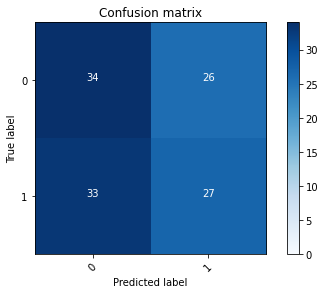

2022-08-05 22:35:19 - [Epoch Train: 42] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 30.00 s            
2022-08-05 22:35:19 - [Epoch Valid: 42] loss: 2.3171, auc: 0.5760, acc: 0.5083, time: 9.00 s
2022-08-05 22:35:19 - 
Valid acc didn't improve last 30 epochs.


 27%|██████████▉                             | 41/150 [27:59<1:14:23, 40.95s/it]


In [15]:
print(info)
m_modelfile = train_mri_type(m_model, device, info, epochs=150, pat=30, 
                       train_loader=train_loader, valid_loader=val_loader)
##m_modelfile = train_mri_type(m_model, device, info, epochs=150, pat=30, 
##                       train_loader=m_train_loader, valid_loader=m_val_loader)

#m_modelfile = train_mri_type(m_model, device, info, epochs=150, pat=30, 
#                       train_loader=n_train_loader, valid_loader=n_val_loader)

In [16]:
print(m_modelfile)

../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug05_22-07-19/RSNAClassifierSingle3D-DW-SO-KLF-e12-loss1.462-acc0.525-auc0.579.pth


In [9]:
"""
folders_list = [
    "RSNAClassifierSingle3D-DW-SO-KLF_Jan27_19-25-03",
    "RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Jul07_17-25-17",
    "RSNAClassifierSingle3D-DW-SO_Jan27_10-46-07",
]
"""

folders_list = [
    #"RSNAClassifierSingle3D-DW-SO-KLF_Jul10_21-39-50", #m
    "RSNAClassifierSingle3D-DW-SO-KLF_Aug05_22-07-19", #m
    "RSNAClassifierSingle3D-DW-SO_Aug03_18-40-51", #m flair
    "RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30", #m t1w
    "RSNAClassifierSingle3D-DW-SO-KLF_Aug05_17-47-49", #n
    "RSNAClassifierSingle3D-DW-SO-KLF_Aug05_18-26-58", #f
    "RSNAClassifierSingle3D-DW-SO-KLF_Aug02_18-42-47", #fn
    "RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Aug02_11-12-02", #m
    "RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Aug05_20-21-59", #n
    "RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Aug02_12-17-49", #f
    "RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Aug02_12-58-14" #fn 
]
"""
choice = 0
model_common_path = "../RSNA-BTC-Datasets/out_models/"
model_folder = model_common_path + folders_list[choice]

model_basefile, info = get_best_model(model_folder)
m_modelfile = model_folder + "/" + model_basefile
transform = None
size = len(info["mri_types"])
sel_slices = 1 if choice == 1 else None
chosen_net = "alt" if choice == 1 else "sim"

#m_modelfile = m_modelfile_3d
print(m_modelfile)
print(info)
"""
print(folders_list)

['RSNAClassifierSingle3D-DW-SO-KLF_Aug05_22-07-19', 'RSNAClassifierSingle3D-DW-SO_Aug03_18-40-51', 'RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30', 'RSNAClassifierSingle3D-DW-SO-KLF_Aug05_17-47-49', 'RSNAClassifierSingle3D-DW-SO-KLF_Aug05_18-26-58', 'RSNAClassifierSingle3D-DW-SO-KLF_Aug02_18-42-47', 'RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Aug02_11-12-02', 'RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Aug05_20-21-59', 'RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Aug02_12-17-49', 'RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Aug02_12-58-14']


In [14]:
def get_metrics(y, y_pred, y_prob, name):
    auc = roc_auc_score(y, y_prob)
    acc = [1 if yy == out else 0 for (yy,out) in zip(y,y_pred)].count(1)/len(y_pred)
    total_0_count = y.count(0)
    total_1_count = y.count(1)
    total_1_pred_count = list(y_pred).count(1)
    true_0 = [1 if yy == out and yy == 0 else 0 for (yy,out) in zip(y,y_pred)].count(1)
    true_1 = [1 if yy == out and yy == 1 else 0 for (yy,out) in zip(y,y_pred)].count(1)
    spec = true_0/total_0_count
    sens = true_1/total_1_count
    if total_1_pred_count != 0:
        prec = true_1/total_1_pred_count
    else:
        prec = 0
    print(f"Prediction AUC: {auc:.4f}")
    print(f"Prediction Accuracy: {acc:.4f}")
    print(f"Prediction Specificity: {spec:.4f}")
    print(f"Prediction Sensitivity: {sens:.4f}")
    print(f"Prediction Precision: {prec:.4f}")
    return pd.DataFrame({"model": [name], "AUC": [auc], "acc": [acc], "spec": [spec], "sens": [sens], "prec": [prec]})

In [7]:
rc = pd.read_csv("RisultatoClassificazione.csv", dtype={"ID": object})
print(rc)
fixed_rc = rc.loc[rc["TUMORE"] == 0]
h_ids = fixed_rc["ID"]
h_preds = fixed_rc["PRED"]
h_probs = fixed_rc["PROB_1"]#[item["PROB_0"] for item in fixed_rc if item["PRED"] == 0 else item["PROB_1"]]

test_rc = fixed_rc.sample(frac=0.2)
h_ids = list(test_rc["ID"])
h_ids = [idx.zfill(5) for idx in h_ids]
h_y = list(np.zeros(len(h_ids)))
h_preds = list(test_rc["PRED"])
h_probs = list(test_rc["PROB_1"])#[item["PROB_0"] for item in fixed_rc if item["PRED"] == 0 else item["PROB_1"]]

print(h_ids)
print(h_y)
print(h_preds)
print(h_probs)

      ID  TUMORE  PRED    PROB_0    PROB_1
0      2       1     0  1.000000  0.000000
1     72       1     1  0.048780  0.951220
2     88       1     1  0.000000  1.000000
3    109       1     0  1.000000  0.000000
4    142       1     0  1.000000  0.000000
..   ...     ...   ...       ...       ...
568  636       0     0  0.846154  0.153846
569  667       0     1  0.000000  1.000000
570  703       0     1  0.000000  1.000000
571  744       0     1  0.000000  1.000000
572  806       0     1  0.000000  1.000000

[573 rows x 5 columns]
['00533', '00540', '00341', '00149', '00418', '00788', '00288', '00645', '00496', '00049', '00339', '00620', '00389', '00378', '00298', '00709', '00555', '00032', '00688', '00575', '00349', '00432', '00241', '00377', '00407']
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
[0.0, 1.0, 0.0, 0.16666666666666

../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug05_22-07-19/RSNAClassifierSingle3D-DW-SO-KLF-e12-loss1.462-acc0.525-auc0.579.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'm', 'val_origin': 'm', 'net': 'RSNAClassifierSingle3D'}
Type: KLF
2022-08-06 10:44:26 - Train/Val datasets size: 270
2022-08-06 10:44:26 - Train/Val datasets size: 303
2022-08-06 10:44:26 - Train/Val datasets size: 231
2022-08-06 10:44:26 - Train/Val datasets size: 285
2022-08-06 10:44:26 - Train/Val datasets size: 170
2022-08-06 10:44:26 - Train/Val datasets size: 121
2022-08-06 10:44:26 - Train/Val datasets size: 129
2022-08-06 10:44:26 - Train/Val datasets size: 273
2022-08-06 10:44:26 - Train/Val datasets size: 141
Length of concatenated

2022-08-06 10:44:26 - (T) Train validation test splitted: 400 114 56
[33, 190, 245, 129, 253, 21, 237, 146, 16, 204, 75, 173, 135, 209, 179, 4, 96, 188, 61, 67, 52, 66, 26, 110, 233, 124, 268, 40, 13, 107, 145, 166, 3, 159, 24, 30, 252, 213, 60, 56, 248, 157, 46, 19, 212, 153, 54, 227, 80, 51, 2, 196, 104, 150, 86, 10, 168, 58, 41, 14, 50, 194, 123, 62, 158, 187, 130, 246, 154, 43, 221, 138, 254, 181, 149, 112, 207, 98, 180, 93, 171, 162, 36, 113, 0, 94, 95, 223, 69, 49, 48, 85, 270, 141, 23, 249, 143, 78, 100, 131, 228, 271, 6, 68, 84, 170, 121, 140, 214, 240, 234, 239, 91, 241, 257, 11, 119, 102, 35, 57, 169, 65, 1, 120, 226, 186, 42, 105, 132, 244, 17, 38, 133, 53, 164, 217, 128, 34, 28, 183, 114, 203, 163, 151, 202, 31, 232, 127, 185, 250, 260, 32, 167, 142, 236, 147, 29, 177, 216, 99, 82, 269, 175, 79, 197, 243, 208, 115, 148, 266, 72, 77, 25, 165, 81, 261, 174, 263, 39, 193, 88, 70, 87, 242, 211, 9, 195, 251, 192, 117, 47, 172, 413, 531, 485, 274, 430, 285, 426, 404, 451, 455, 34

Type: FLAIR
Length of concatenated dataset: 606
Length of concatenated dataset: 606
Train Idx:
[238, 137, 106, 284, 44, 139, 247, 288, 156, 297, 252, 54, 234, 18, 205, 254, 182, 56, 71, 144, 249, 209, 290, 219, 158, 176, 33, 83, 136, 210, 118, 60, 159, 282, 110, 21, 29, 150, 16, 75, 109, 179, 283, 4, 96, 229, 61, 67, 295, 266, 171, 281, 40, 189, 13, 107, 200, 3, 161, 125, 24, 30, 77, 279, 190, 19, 257, 235, 268, 80, 51, 2, 239, 104, 262, 86, 10, 224, 58, 41, 14, 155, 50, 215, 237, 123, 220, 62, 191, 230, 130, 213, 187, 43, 114, 138, 199, 222, 149, 112, 298, 98, 221, 93, 208, 162, 36, 178, 113, 0, 94, 294, 95, 299, 263, 256, 69, 49, 48, 85, 300, 141, 207, 23, 250, 148, 143, 78, 180, 100, 204, 131, 269, 301, 196, 6, 68, 203, 84, 170, 121, 140, 258, 276, 142, 259, 91, 82, 285, 11, 119, 102, 35, 57, 169, 231, 65, 1, 120, 267, 186, 42, 105, 132, 79, 17, 271, 38, 53, 260, 128, 28, 183, 163, 151, 244, 202, 31, 32, 127, 185, 280, 273, 147, 278, 177, 99, 197, 243, 115, 265, 72, 25, 165, 289, 17

2022-08-06 10:44:26 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

2022-08-06 10:44:26 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

Predictions: 35 without tumor, 25 with tumor
Prediction AUC: 0.6744
Prediction Accuracy: 0.6833
Prediction Specificity: 0.7667
Prediction Sensitivity: 0.6000
Prediction Precision: 0.7200
Test set: n (B)
2022-08-06 10:44:31 - Predict: ../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug05_22-07-19/RSNAClassifierSingle3D-DW-SO-KLF-e12-loss1.462-acc0.525-auc0.579.pth 546
Dataset: Labeled Test Set
             BraTS21ID  MGMT_real_value  MGMT_value
9   UPENN-GBM-00093_11                0           1
6   UPENN-GBM-00122_21                0           1
24  UPENN-GBM-00134_21                0           0
52  UPENN-GBM-00139_11                0           1
53  UPENN-GBM-00140_21                0           0
5   UPENN-GBM-00141_11                0           1
1   UPENN-GBM-00302_11                1           0
8   UPENN-GBM-00302_11                1           0
23  UPENN-GBM-00304_11                0           1
10  UPENN-GBM-00316_11                0           1
49  UPENN-GBM-0

2022-08-06 10:44:37 - (T) Train validation test splitted: 400 114 56
[33, 190, 245, 129, 253, 21, 237, 146, 16, 204, 75, 173, 135, 209, 179, 4, 96, 188, 61, 67, 52, 66, 26, 110, 233, 124, 268, 40, 13, 107, 145, 166, 3, 159, 24, 30, 252, 213, 60, 56, 248, 157, 46, 19, 212, 153, 54, 227, 80, 51, 2, 196, 104, 150, 86, 10, 168, 58, 41, 14, 50, 194, 123, 62, 158, 187, 130, 246, 154, 43, 221, 138, 254, 181, 149, 112, 207, 98, 180, 93, 171, 162, 36, 113, 0, 94, 95, 223, 69, 49, 48, 85, 270, 141, 23, 249, 143, 78, 100, 131, 228, 271, 6, 68, 84, 170, 121, 140, 214, 240, 234, 239, 91, 241, 257, 11, 119, 102, 35, 57, 169, 65, 1, 120, 226, 186, 42, 105, 132, 244, 17, 38, 133, 53, 164, 217, 128, 34, 28, 183, 114, 203, 163, 151, 202, 31, 232, 127, 185, 250, 260, 32, 167, 142, 236, 147, 29, 177, 216, 99, 82, 269, 175, 79, 197, 243, 208, 115, 148, 266, 72, 77, 25, 165, 81, 261, 174, 263, 39, 193, 88, 70, 87, 242, 211, 9, 195, 251, 192, 117, 47, 172, 413, 531, 485, 274, 430, 285, 426, 404, 451, 455, 34

Type: FLAIR
Length of concatenated dataset: 606
Length of concatenated dataset: 606
Train Idx:
[238, 137, 106, 284, 44, 139, 247, 288, 156, 297, 252, 54, 234, 18, 205, 254, 182, 56, 71, 144, 249, 209, 290, 219, 158, 176, 33, 83, 136, 210, 118, 60, 159, 282, 110, 21, 29, 150, 16, 75, 109, 179, 283, 4, 96, 229, 61, 67, 295, 266, 171, 281, 40, 189, 13, 107, 200, 3, 161, 125, 24, 30, 77, 279, 190, 19, 257, 235, 268, 80, 51, 2, 239, 104, 262, 86, 10, 224, 58, 41, 14, 155, 50, 215, 237, 123, 220, 62, 191, 230, 130, 213, 187, 43, 114, 138, 199, 222, 149, 112, 298, 98, 221, 93, 208, 162, 36, 178, 113, 0, 94, 294, 95, 299, 263, 256, 69, 49, 48, 85, 300, 141, 207, 23, 250, 148, 143, 78, 180, 100, 204, 131, 269, 301, 196, 6, 68, 203, 84, 170, 121, 140, 258, 276, 142, 259, 91, 82, 285, 11, 119, 102, 35, 57, 169, 231, 65, 1, 120, 267, 186, 42, 105, 132, 79, 17, 271, 38, 53, 260, 128, 28, 183, 163, 151, 244, 202, 31, 32, 127, 185, 280, 273, 147, 278, 177, 99, 197, 243, 115, 265, 72, 25, 165, 289, 17

2022-08-06 10:44:37 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

2022-08-06 10:44:37 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

Predictions: 48 without tumor, 12 with tumor
Prediction AUC: 0.3744
Prediction Accuracy: 0.4667
Prediction Specificity: 0.7667
Prediction Sensitivity: 0.1667
Prediction Precision: 0.4167
Test set: n (B)
2022-08-06 10:44:43 - Predict: ../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_18-40-51/RSNAClassifierSingle3D-DW-SO-e42-loss1.143-acc0.750-auc0.760.pth 340
Dataset: Labeled Test Set
             BraTS21ID  MGMT_real_value  MGMT_value
18  UPENN-GBM-00131_11                1           1
27  UPENN-GBM-00133_11                0           0
0   UPENN-GBM-00136_11                0           0
12  UPENN-GBM-00143_11                0           0
28  UPENN-GBM-00148_21                0           0
9   UPENN-GBM-00260_11                1           1
5   UPENN-GBM-00263_11                1           0
32  UPENN-GBM-00302_11                1           1
6   UPENN-GBM-00350_11                1           1
13  UPENN-GBM-00354_11                0           1
3   UPENN-GBM-00363_11 

2022-08-06 10:44:47 - (T) Train validation test splitted: 400 114 56
[33, 190, 245, 129, 253, 21, 237, 146, 16, 204, 75, 173, 135, 209, 179, 4, 96, 188, 61, 67, 52, 66, 26, 110, 233, 124, 268, 40, 13, 107, 145, 166, 3, 159, 24, 30, 252, 213, 60, 56, 248, 157, 46, 19, 212, 153, 54, 227, 80, 51, 2, 196, 104, 150, 86, 10, 168, 58, 41, 14, 50, 194, 123, 62, 158, 187, 130, 246, 154, 43, 221, 138, 254, 181, 149, 112, 207, 98, 180, 93, 171, 162, 36, 113, 0, 94, 95, 223, 69, 49, 48, 85, 270, 141, 23, 249, 143, 78, 100, 131, 228, 271, 6, 68, 84, 170, 121, 140, 214, 240, 234, 239, 91, 241, 257, 11, 119, 102, 35, 57, 169, 65, 1, 120, 226, 186, 42, 105, 132, 244, 17, 38, 133, 53, 164, 217, 128, 34, 28, 183, 114, 203, 163, 151, 202, 31, 232, 127, 185, 250, 260, 32, 167, 142, 236, 147, 29, 177, 216, 99, 82, 269, 175, 79, 197, 243, 208, 115, 148, 266, 72, 77, 25, 165, 81, 261, 174, 263, 39, 193, 88, 70, 87, 242, 211, 9, 195, 251, 192, 117, 47, 172, 413, 531, 485, 274, 430, 285, 426, 404, 451, 455, 34

Type: FLAIR
Length of concatenated dataset: 606
Length of concatenated dataset: 606
Train Idx:
[238, 137, 106, 284, 44, 139, 247, 288, 156, 297, 252, 54, 234, 18, 205, 254, 182, 56, 71, 144, 249, 209, 290, 219, 158, 176, 33, 83, 136, 210, 118, 60, 159, 282, 110, 21, 29, 150, 16, 75, 109, 179, 283, 4, 96, 229, 61, 67, 295, 266, 171, 281, 40, 189, 13, 107, 200, 3, 161, 125, 24, 30, 77, 279, 190, 19, 257, 235, 268, 80, 51, 2, 239, 104, 262, 86, 10, 224, 58, 41, 14, 155, 50, 215, 237, 123, 220, 62, 191, 230, 130, 213, 187, 43, 114, 138, 199, 222, 149, 112, 298, 98, 221, 93, 208, 162, 36, 178, 113, 0, 94, 294, 95, 299, 263, 256, 69, 49, 48, 85, 300, 141, 207, 23, 250, 148, 143, 78, 180, 100, 204, 131, 269, 301, 196, 6, 68, 203, 84, 170, 121, 140, 258, 276, 142, 259, 91, 82, 285, 11, 119, 102, 35, 57, 169, 231, 65, 1, 120, 267, 186, 42, 105, 132, 79, 17, 271, 38, 53, 260, 128, 28, 183, 163, 151, 244, 202, 31, 32, 127, 185, 280, 273, 147, 278, 177, 99, 197, 243, 115, 265, 72, 25, 165, 289, 17

2022-08-06 10:44:47 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

2022-08-06 10:44:47 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

Prob:
[array([0.39712963], dtype=float32), array([0.3914341], dtype=float32), array([0.43703276], dtype=float32), array([0.8190378], dtype=float32), array([0.10396442], dtype=float32), array([0.25746828], dtype=float32), array([0.12925991], dtype=float32), array([0.2042029], dtype=float32), array([0.42282018], dtype=float32), array([0.7306867], dtype=float32), array([0.0510505], dtype=float32), array([0.31638327], dtype=float32), array([0.06558501], dtype=float32), array([0.15813759], dtype=float32), array([0.8459114], dtype=float32), array([0.27189958], dtype=float32), array([0.42074278], dtype=float32), array([0.05319233], dtype=float32), array([0.35430396], dtype=float32), array([0.24112119], dtype=float32), array([0.03813113], dtype=float32), array([0.2906988], dtype=float32), array([0.16062905], dtype=float32), array([0.02295735], dtype=float32), array([0.64211416], dtype=float32), array([0.00400143], dtype=float32), array([0.36367965], dtype=float32), array([0.18112954], dtype=fl

2022-08-06 10:44:58 - (T) Train validation test splitted: 400 114 56
[33, 190, 245, 129, 253, 21, 237, 146, 16, 204, 75, 173, 135, 209, 179, 4, 96, 188, 61, 67, 52, 66, 26, 110, 233, 124, 268, 40, 13, 107, 145, 166, 3, 159, 24, 30, 252, 213, 60, 56, 248, 157, 46, 19, 212, 153, 54, 227, 80, 51, 2, 196, 104, 150, 86, 10, 168, 58, 41, 14, 50, 194, 123, 62, 158, 187, 130, 246, 154, 43, 221, 138, 254, 181, 149, 112, 207, 98, 180, 93, 171, 162, 36, 113, 0, 94, 95, 223, 69, 49, 48, 85, 270, 141, 23, 249, 143, 78, 100, 131, 228, 271, 6, 68, 84, 170, 121, 140, 214, 240, 234, 239, 91, 241, 257, 11, 119, 102, 35, 57, 169, 65, 1, 120, 226, 186, 42, 105, 132, 244, 17, 38, 133, 53, 164, 217, 128, 34, 28, 183, 114, 203, 163, 151, 202, 31, 232, 127, 185, 250, 260, 32, 167, 142, 236, 147, 29, 177, 216, 99, 82, 269, 175, 79, 197, 243, 208, 115, 148, 266, 72, 77, 25, 165, 81, 261, 174, 263, 39, 193, 88, 70, 87, 242, 211, 9, 195, 251, 192, 117, 47, 172, 413, 531, 485, 274, 430, 285, 426, 404, 451, 455, 34

Type: FLAIR
Length of concatenated dataset: 606
Length of concatenated dataset: 606
Train Idx:
[238, 137, 106, 284, 44, 139, 247, 288, 156, 297, 252, 54, 234, 18, 205, 254, 182, 56, 71, 144, 249, 209, 290, 219, 158, 176, 33, 83, 136, 210, 118, 60, 159, 282, 110, 21, 29, 150, 16, 75, 109, 179, 283, 4, 96, 229, 61, 67, 295, 266, 171, 281, 40, 189, 13, 107, 200, 3, 161, 125, 24, 30, 77, 279, 190, 19, 257, 235, 268, 80, 51, 2, 239, 104, 262, 86, 10, 224, 58, 41, 14, 155, 50, 215, 237, 123, 220, 62, 191, 230, 130, 213, 187, 43, 114, 138, 199, 222, 149, 112, 298, 98, 221, 93, 208, 162, 36, 178, 113, 0, 94, 294, 95, 299, 263, 256, 69, 49, 48, 85, 300, 141, 207, 23, 250, 148, 143, 78, 180, 100, 204, 131, 269, 301, 196, 6, 68, 203, 84, 170, 121, 140, 258, 276, 142, 259, 91, 82, 285, 11, 119, 102, 35, 57, 169, 231, 65, 1, 120, 267, 186, 42, 105, 132, 79, 17, 271, 38, 53, 260, 128, 28, 183, 163, 151, 244, 202, 31, 32, 127, 185, 280, 273, 147, 278, 177, 99, 197, 243, 115, 265, 72, 25, 165, 289, 17

2022-08-06 10:44:58 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

2022-08-06 10:44:58 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

Predictions: 40 without tumor, 20 with tumor
Prediction AUC: 0.5667
Prediction Accuracy: 0.5000
Prediction Specificity: 0.6667
Prediction Sensitivity: 0.3333
Prediction Precision: 0.5000
Test set: n (B)
2022-08-06 10:45:03 - Predict: ../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug05_17-47-49/RSNAClassifierSingle3D-DW-SO-KLF-e6-loss0.449-acc0.852-auc0.902.pth 546
Dataset: Labeled Test Set
             BraTS21ID  MGMT_real_value  MGMT_value
9   UPENN-GBM-00093_11                0           0
43  UPENN-GBM-00115_11                1           1
6   UPENN-GBM-00122_21                0           0
2   UPENN-GBM-00129_11                0           0
25  UPENN-GBM-00130_21                1           1
14  UPENN-GBM-00133_11                0           0
24  UPENN-GBM-00134_21                0           0
53  UPENN-GBM-00140_21                0           0
0   UPENN-GBM-00269_11                1           1
8   UPENN-GBM-00302_11                1           0
23  UPENN-GBM-00

2022-08-06 10:45:08 - (T) Train validation test splitted: 400 114 56
[33, 190, 245, 129, 253, 21, 237, 146, 16, 204, 75, 173, 135, 209, 179, 4, 96, 188, 61, 67, 52, 66, 26, 110, 233, 124, 268, 40, 13, 107, 145, 166, 3, 159, 24, 30, 252, 213, 60, 56, 248, 157, 46, 19, 212, 153, 54, 227, 80, 51, 2, 196, 104, 150, 86, 10, 168, 58, 41, 14, 50, 194, 123, 62, 158, 187, 130, 246, 154, 43, 221, 138, 254, 181, 149, 112, 207, 98, 180, 93, 171, 162, 36, 113, 0, 94, 95, 223, 69, 49, 48, 85, 270, 141, 23, 249, 143, 78, 100, 131, 228, 271, 6, 68, 84, 170, 121, 140, 214, 240, 234, 239, 91, 241, 257, 11, 119, 102, 35, 57, 169, 65, 1, 120, 226, 186, 42, 105, 132, 244, 17, 38, 133, 53, 164, 217, 128, 34, 28, 183, 114, 203, 163, 151, 202, 31, 232, 127, 185, 250, 260, 32, 167, 142, 236, 147, 29, 177, 216, 99, 82, 269, 175, 79, 197, 243, 208, 115, 148, 266, 72, 77, 25, 165, 81, 261, 174, 263, 39, 193, 88, 70, 87, 242, 211, 9, 195, 251, 192, 117, 47, 172, 413, 531, 485, 274, 430, 285, 426, 404, 451, 455, 34

Type: FLAIR
Length of concatenated dataset: 606
Length of concatenated dataset: 606
Train Idx:
[238, 137, 106, 284, 44, 139, 247, 288, 156, 297, 252, 54, 234, 18, 205, 254, 182, 56, 71, 144, 249, 209, 290, 219, 158, 176, 33, 83, 136, 210, 118, 60, 159, 282, 110, 21, 29, 150, 16, 75, 109, 179, 283, 4, 96, 229, 61, 67, 295, 266, 171, 281, 40, 189, 13, 107, 200, 3, 161, 125, 24, 30, 77, 279, 190, 19, 257, 235, 268, 80, 51, 2, 239, 104, 262, 86, 10, 224, 58, 41, 14, 155, 50, 215, 237, 123, 220, 62, 191, 230, 130, 213, 187, 43, 114, 138, 199, 222, 149, 112, 298, 98, 221, 93, 208, 162, 36, 178, 113, 0, 94, 294, 95, 299, 263, 256, 69, 49, 48, 85, 300, 141, 207, 23, 250, 148, 143, 78, 180, 100, 204, 131, 269, 301, 196, 6, 68, 203, 84, 170, 121, 140, 258, 276, 142, 259, 91, 82, 285, 11, 119, 102, 35, 57, 169, 231, 65, 1, 120, 267, 186, 42, 105, 132, 79, 17, 271, 38, 53, 260, 128, 28, 183, 163, 151, 244, 202, 31, 32, 127, 185, 280, 273, 147, 278, 177, 99, 197, 243, 115, 265, 72, 25, 165, 289, 17

2022-08-06 10:45:08 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

2022-08-06 10:45:08 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

Prob:
[array([0.00518321], dtype=float32), array([0.9999838], dtype=float32), array([8.876609e-06], dtype=float32), array([0.20512293], dtype=float32), array([0.49142253], dtype=float32), array([0.00010678], dtype=float32), array([0.00011721], dtype=float32), array([0.16730039], dtype=float32), array([0.99631363], dtype=float32), array([1.33445e-05], dtype=float32), array([0.00011167], dtype=float32), array([0.99999976], dtype=float32), array([8.6423347e-07], dtype=float32), array([5.0114404e-06], dtype=float32), array([0.00077222], dtype=float32), array([0.12643513], dtype=float32), array([0.8034477], dtype=float32), array([0.00012132], dtype=float32), array([1.092604e-05], dtype=float32), array([0.00445874], dtype=float32), array([0.00052506], dtype=float32), array([0.9999753], dtype=float32), array([0.9999963], dtype=float32), array([7.157228e-05], dtype=float32), array([0.99999344], dtype=float32), array([0.41975436], dtype=float32), array([0.01098815], dtype=float32), array([0.000

/home/salvatorecapuozzo/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/home/salvatorecapuozzo/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:546: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_score = check_array(y_score, ensure_2d=False)


Dataset: Labeled Test Set
             BraTS21ID  MGMT_real_value  MGMT_value
42  UPENN-GBM-00088_11                0           0
9   UPENN-GBM-00093_11                0           1
46  UPENN-GBM-00095_11                1           1
30  UPENN-GBM-00098_11                1           1
27  UPENN-GBM-00122_21                0           0
6   UPENN-GBM-00122_21                0           0
37  UPENN-GBM-00131_11                1           1
24  UPENN-GBM-00134_21                0           0
12  UPENN-GBM-00134_21                0           0
53  UPENN-GBM-00140_21                0           0
5   UPENN-GBM-00140_21                0           0
2   UPENN-GBM-00151_11                0           1
8   UPENN-GBM-00302_11                1           1
31  UPENN-GBM-00304_11                0           1
23  UPENN-GBM-00304_11                0           1
49  UPENN-GBM-00344_11                1           1
35  UPENN-GBM-00358_11                1           0
26  UPENN-GBM-00360_11                

2022-08-06 10:45:17 - (T) Train validation test splitted: 400 114 56
[33, 190, 245, 129, 253, 21, 237, 146, 16, 204, 75, 173, 135, 209, 179, 4, 96, 188, 61, 67, 52, 66, 26, 110, 233, 124, 268, 40, 13, 107, 145, 166, 3, 159, 24, 30, 252, 213, 60, 56, 248, 157, 46, 19, 212, 153, 54, 227, 80, 51, 2, 196, 104, 150, 86, 10, 168, 58, 41, 14, 50, 194, 123, 62, 158, 187, 130, 246, 154, 43, 221, 138, 254, 181, 149, 112, 207, 98, 180, 93, 171, 162, 36, 113, 0, 94, 95, 223, 69, 49, 48, 85, 270, 141, 23, 249, 143, 78, 100, 131, 228, 271, 6, 68, 84, 170, 121, 140, 214, 240, 234, 239, 91, 241, 257, 11, 119, 102, 35, 57, 169, 65, 1, 120, 226, 186, 42, 105, 132, 244, 17, 38, 133, 53, 164, 217, 128, 34, 28, 183, 114, 203, 163, 151, 202, 31, 232, 127, 185, 250, 260, 32, 167, 142, 236, 147, 29, 177, 216, 99, 82, 269, 175, 79, 197, 243, 208, 115, 148, 266, 72, 77, 25, 165, 81, 261, 174, 263, 39, 193, 88, 70, 87, 242, 211, 9, 195, 251, 192, 117, 47, 172, 413, 531, 485, 274, 430, 285, 426, 404, 451, 455, 34

Type: FLAIR
Length of concatenated dataset: 606
Length of concatenated dataset: 606
Train Idx:
[238, 137, 106, 284, 44, 139, 247, 288, 156, 297, 252, 54, 234, 18, 205, 254, 182, 56, 71, 144, 249, 209, 290, 219, 158, 176, 33, 83, 136, 210, 118, 60, 159, 282, 110, 21, 29, 150, 16, 75, 109, 179, 283, 4, 96, 229, 61, 67, 295, 266, 171, 281, 40, 189, 13, 107, 200, 3, 161, 125, 24, 30, 77, 279, 190, 19, 257, 235, 268, 80, 51, 2, 239, 104, 262, 86, 10, 224, 58, 41, 14, 155, 50, 215, 237, 123, 220, 62, 191, 230, 130, 213, 187, 43, 114, 138, 199, 222, 149, 112, 298, 98, 221, 93, 208, 162, 36, 178, 113, 0, 94, 294, 95, 299, 263, 256, 69, 49, 48, 85, 300, 141, 207, 23, 250, 148, 143, 78, 180, 100, 204, 131, 269, 301, 196, 6, 68, 203, 84, 170, 121, 140, 258, 276, 142, 259, 91, 82, 285, 11, 119, 102, 35, 57, 169, 231, 65, 1, 120, 267, 186, 42, 105, 132, 79, 17, 271, 38, 53, 260, 128, 28, 183, 163, 151, 244, 202, 31, 32, 127, 185, 280, 273, 147, 278, 177, 99, 197, 243, 115, 265, 72, 25, 165, 289, 17

2022-08-06 10:45:17 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

2022-08-06 10:45:17 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

/home/salvatorecapuozzo/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


Predictions: 24 without tumor, 36 with tumor
Prediction AUC: 0.9178
Prediction Accuracy: 0.8333
Prediction Specificity: 0.7333
Prediction Sensitivity: 0.9333
Prediction Precision: 0.7778
Test set: n (B)
2022-08-06 10:45:23 - Predict: ../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug02_18-42-47/RSNAClassifierSingle3D-DW-SO-KLF-e24-loss1.105-acc0.757-auc0.838.pth 546
Dataset: Labeled Test Set
             BraTS21ID  MGMT_real_value  MGMT_value
9   UPENN-GBM-00093_11                0           0
37  UPENN-GBM-00115_11                1           1
6   UPENN-GBM-00122_21                0           0
24  UPENN-GBM-00134_21                0           0
53  UPENN-GBM-00140_21                0           0
42  UPENN-GBM-00150_11                0           0
30  UPENN-GBM-00263_11                1           1
8   UPENN-GBM-00302_11                1           1
23  UPENN-GBM-00304_11                0           0
31  UPENN-GBM-00312_21                0           0
49  UPENN-GBM-0

2022-08-06 10:45:27 - (T) Train validation test splitted: 400 114 56
[33, 190, 245, 129, 253, 21, 237, 146, 16, 204, 75, 173, 135, 209, 179, 4, 96, 188, 61, 67, 52, 66, 26, 110, 233, 124, 268, 40, 13, 107, 145, 166, 3, 159, 24, 30, 252, 213, 60, 56, 248, 157, 46, 19, 212, 153, 54, 227, 80, 51, 2, 196, 104, 150, 86, 10, 168, 58, 41, 14, 50, 194, 123, 62, 158, 187, 130, 246, 154, 43, 221, 138, 254, 181, 149, 112, 207, 98, 180, 93, 171, 162, 36, 113, 0, 94, 95, 223, 69, 49, 48, 85, 270, 141, 23, 249, 143, 78, 100, 131, 228, 271, 6, 68, 84, 170, 121, 140, 214, 240, 234, 239, 91, 241, 257, 11, 119, 102, 35, 57, 169, 65, 1, 120, 226, 186, 42, 105, 132, 244, 17, 38, 133, 53, 164, 217, 128, 34, 28, 183, 114, 203, 163, 151, 202, 31, 232, 127, 185, 250, 260, 32, 167, 142, 236, 147, 29, 177, 216, 99, 82, 269, 175, 79, 197, 243, 208, 115, 148, 266, 72, 77, 25, 165, 81, 261, 174, 263, 39, 193, 88, 70, 87, 242, 211, 9, 195, 251, 192, 117, 47, 172, 413, 531, 485, 274, 430, 285, 426, 404, 451, 455, 34

Type: FLAIR
Length of concatenated dataset: 606
Length of concatenated dataset: 606
Train Idx:
[238, 137, 106, 284, 44, 139, 247, 288, 156, 297, 252, 54, 234, 18, 205, 254, 182, 56, 71, 144, 249, 209, 290, 219, 158, 176, 33, 83, 136, 210, 118, 60, 159, 282, 110, 21, 29, 150, 16, 75, 109, 179, 283, 4, 96, 229, 61, 67, 295, 266, 171, 281, 40, 189, 13, 107, 200, 3, 161, 125, 24, 30, 77, 279, 190, 19, 257, 235, 268, 80, 51, 2, 239, 104, 262, 86, 10, 224, 58, 41, 14, 155, 50, 215, 237, 123, 220, 62, 191, 230, 130, 213, 187, 43, 114, 138, 199, 222, 149, 112, 298, 98, 221, 93, 208, 162, 36, 178, 113, 0, 94, 294, 95, 299, 263, 256, 69, 49, 48, 85, 300, 141, 207, 23, 250, 148, 143, 78, 180, 100, 204, 131, 269, 301, 196, 6, 68, 203, 84, 170, 121, 140, 258, 276, 142, 259, 91, 82, 285, 11, 119, 102, 35, 57, 169, 231, 65, 1, 120, 267, 186, 42, 105, 132, 79, 17, 271, 38, 53, 260, 128, 28, 183, 163, 151, 244, 202, 31, 32, 127, 185, 280, 273, 147, 278, 177, 99, 197, 243, 115, 265, 72, 25, 165, 289, 17

2022-08-06 10:45:27 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

2022-08-06 10:45:27 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

Prob:
[array([0.8533188], dtype=float32), array([0.4414379], dtype=float32), array([0.6648956], dtype=float32), array([0.51494616], dtype=float32), array([0.6944147], dtype=float32), array([0.7443719], dtype=float32), array([0.8481329], dtype=float32), array([0.8346447], dtype=float32), array([0.57842875], dtype=float32), array([0.75470036], dtype=float32), array([0.59493047], dtype=float32), array([0.16966936], dtype=float32), array([0.3840887], dtype=float32), array([0.6179401], dtype=float32), array([0.6801981], dtype=float32), array([0.54808426], dtype=float32), array([0.61961967], dtype=float32), array([0.28307483], dtype=float32), array([0.3852767], dtype=float32), array([0.25003514], dtype=float32), array([0.6473176], dtype=float32), array([0.42476994], dtype=float32), array([0.5958259], dtype=float32), array([0.52354634], dtype=float32), array([0.90309197], dtype=float32), array([0.3587757], dtype=float32), array([0.66949403], dtype=float32), array([0.24291919], dtype=float32),

Length of concatenated dataset: 340
2022-08-06 10:45:34 - Train/Val datasets size: 340
Length of concatenated dataset: 546
2022-08-06 10:45:34 - Train/Val datasets size: 546
Type: FLAIR
2022-08-06 10:45:34 - Train/Val datasets size: 270
2022-08-06 10:45:34 - Train/Val datasets size: 303
2022-08-06 10:45:34 - Train/Val datasets size: 231
2022-08-06 10:45:34 - Train/Val datasets size: 285
2022-08-06 10:45:34 - Train/Val datasets size: 170
2022-08-06 10:45:34 - Train/Val datasets size: 121
Type: T1w
2022-08-06 10:45:34 - Train/Val datasets size: 270
2022-08-06 10:45:34 - Train/Val datasets size: 303
2022-08-06 10:45:34 - Train/Val datasets size: 231
2022-08-06 10:45:34 - Train/Val datasets size: 285
2022-08-06 10:45:34 - Train/Val datasets size: 170
2022-08-06 10:45:34 - Train/Val datasets size: 121
{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7fc69546a550>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7fc65375d520>, 'f_dataset_0': <utils.dataset_utils.Datas

2022-08-06 10:45:34 - (T) Train validation test splitted: 400 114 56
[33, 190, 245, 129, 253, 21, 237, 146, 16, 204, 75, 173, 135, 209, 179, 4, 96, 188, 61, 67, 52, 66, 26, 110, 233, 124, 268, 40, 13, 107, 145, 166, 3, 159, 24, 30, 252, 213, 60, 56, 248, 157, 46, 19, 212, 153, 54, 227, 80, 51, 2, 196, 104, 150, 86, 10, 168, 58, 41, 14, 50, 194, 123, 62, 158, 187, 130, 246, 154, 43, 221, 138, 254, 181, 149, 112, 207, 98, 180, 93, 171, 162, 36, 113, 0, 94, 95, 223, 69, 49, 48, 85, 270, 141, 23, 249, 143, 78, 100, 131, 228, 271, 6, 68, 84, 170, 121, 140, 214, 240, 234, 239, 91, 241, 257, 11, 119, 102, 35, 57, 169, 65, 1, 120, 226, 186, 42, 105, 132, 244, 17, 38, 133, 53, 164, 217, 128, 34, 28, 183, 114, 203, 163, 151, 202, 31, 232, 127, 185, 250, 260, 32, 167, 142, 236, 147, 29, 177, 216, 99, 82, 269, 175, 79, 197, 243, 208, 115, 148, 266, 72, 77, 25, 165, 81, 261, 174, 263, 39, 193, 88, 70, 87, 242, 211, 9, 195, 251, 192, 117, 47, 172, 413, 531, 485, 274, 430, 285, 426, 404, 451, 455, 34

Type: FLAIR
Length of concatenated dataset: 606
Length of concatenated dataset: 606
Train Idx:
[238, 137, 106, 284, 44, 139, 247, 288, 156, 297, 252, 54, 234, 18, 205, 254, 182, 56, 71, 144, 249, 209, 290, 219, 158, 176, 33, 83, 136, 210, 118, 60, 159, 282, 110, 21, 29, 150, 16, 75, 109, 179, 283, 4, 96, 229, 61, 67, 295, 266, 171, 281, 40, 189, 13, 107, 200, 3, 161, 125, 24, 30, 77, 279, 190, 19, 257, 235, 268, 80, 51, 2, 239, 104, 262, 86, 10, 224, 58, 41, 14, 155, 50, 215, 237, 123, 220, 62, 191, 230, 130, 213, 187, 43, 114, 138, 199, 222, 149, 112, 298, 98, 221, 93, 208, 162, 36, 178, 113, 0, 94, 294, 95, 299, 263, 256, 69, 49, 48, 85, 300, 141, 207, 23, 250, 148, 143, 78, 180, 100, 204, 131, 269, 301, 196, 6, 68, 203, 84, 170, 121, 140, 258, 276, 142, 259, 91, 82, 285, 11, 119, 102, 35, 57, 169, 231, 65, 1, 120, 267, 186, 42, 105, 132, 79, 17, 271, 38, 53, 260, 128, 28, 183, 163, 151, 244, 202, 31, 32, 127, 185, 280, 273, 147, 278, 177, 99, 197, 243, 115, 265, 72, 25, 165, 289, 17

2022-08-06 10:45:34 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

2022-08-06 10:45:34 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

Prob:
[array([0.0198971], dtype=float32), array([0.24830973], dtype=float32), array([0.93274164], dtype=float32), array([0.00675198], dtype=float32), array([0.61417776], dtype=float32), array([0.11990701], dtype=float32), array([0.5824103], dtype=float32), array([0.00211313], dtype=float32), array([0.21665005], dtype=float32), array([0.99836105], dtype=float32), array([6.764211e-06], dtype=float32), array([0.26307097], dtype=float32), array([0.9718855], dtype=float32), array([0.98989046], dtype=float32), array([0.00131103], dtype=float32), array([0.0049685], dtype=float32), array([0.9996613], dtype=float32), array([0.99987626], dtype=float32), array([0.57289684], dtype=float32), array([0.99784493], dtype=float32), array([0.9046516], dtype=float32), array([0.6660055], dtype=float32), array([0.53274786], dtype=float32), array([0.8000808], dtype=float32), array([0.99975735], dtype=float32), array([0.9873006], dtype=float32), array([0.8250991], dtype=float32), array([0.34810612], dtype=flo

2022-08-06 10:45:41 - Train/Val datasets size: 303
2022-08-06 10:45:41 - Train/Val datasets size: 231
2022-08-06 10:45:41 - Train/Val datasets size: 285
2022-08-06 10:45:41 - Train/Val datasets size: 170
2022-08-06 10:45:41 - Train/Val datasets size: 121
2022-08-06 10:45:41 - Train/Val datasets size: 129
2022-08-06 10:45:41 - Train/Val datasets size: 273
2022-08-06 10:45:41 - Train/Val datasets size: 141
Length of concatenated dataset: 340
2022-08-06 10:45:41 - Train/Val datasets size: 340
Length of concatenated dataset: 546
2022-08-06 10:45:41 - Train/Val datasets size: 546
Type: FLAIR
2022-08-06 10:45:41 - Train/Val datasets size: 270
2022-08-06 10:45:41 - Train/Val datasets size: 303
2022-08-06 10:45:41 - Train/Val datasets size: 231
2022-08-06 10:45:41 - Train/Val datasets size: 285
2022-08-06 10:45:41 - Train/Val datasets size: 170
2022-08-06 10:45:41 - Train/Val datasets size: 121
Type: T1w
2022-08-06 10:45:41 - Train/Val datasets size: 270
2022-08-06 10:45:41 - Train/Val dataset

2022-08-06 10:45:41 - (T) Train validation test splitted: 400 114 56
[33, 190, 245, 129, 253, 21, 237, 146, 16, 204, 75, 173, 135, 209, 179, 4, 96, 188, 61, 67, 52, 66, 26, 110, 233, 124, 268, 40, 13, 107, 145, 166, 3, 159, 24, 30, 252, 213, 60, 56, 248, 157, 46, 19, 212, 153, 54, 227, 80, 51, 2, 196, 104, 150, 86, 10, 168, 58, 41, 14, 50, 194, 123, 62, 158, 187, 130, 246, 154, 43, 221, 138, 254, 181, 149, 112, 207, 98, 180, 93, 171, 162, 36, 113, 0, 94, 95, 223, 69, 49, 48, 85, 270, 141, 23, 249, 143, 78, 100, 131, 228, 271, 6, 68, 84, 170, 121, 140, 214, 240, 234, 239, 91, 241, 257, 11, 119, 102, 35, 57, 169, 65, 1, 120, 226, 186, 42, 105, 132, 244, 17, 38, 133, 53, 164, 217, 128, 34, 28, 183, 114, 203, 163, 151, 202, 31, 232, 127, 185, 250, 260, 32, 167, 142, 236, 147, 29, 177, 216, 99, 82, 269, 175, 79, 197, 243, 208, 115, 148, 266, 72, 77, 25, 165, 81, 261, 174, 263, 39, 193, 88, 70, 87, 242, 211, 9, 195, 251, 192, 117, 47, 172, 413, 531, 485, 274, 430, 285, 426, 404, 451, 455, 34

Type: FLAIR
Length of concatenated dataset: 606
Length of concatenated dataset: 606
Train Idx:
[238, 137, 106, 284, 44, 139, 247, 288, 156, 297, 252, 54, 234, 18, 205, 254, 182, 56, 71, 144, 249, 209, 290, 219, 158, 176, 33, 83, 136, 210, 118, 60, 159, 282, 110, 21, 29, 150, 16, 75, 109, 179, 283, 4, 96, 229, 61, 67, 295, 266, 171, 281, 40, 189, 13, 107, 200, 3, 161, 125, 24, 30, 77, 279, 190, 19, 257, 235, 268, 80, 51, 2, 239, 104, 262, 86, 10, 224, 58, 41, 14, 155, 50, 215, 237, 123, 220, 62, 191, 230, 130, 213, 187, 43, 114, 138, 199, 222, 149, 112, 298, 98, 221, 93, 208, 162, 36, 178, 113, 0, 94, 294, 95, 299, 263, 256, 69, 49, 48, 85, 300, 141, 207, 23, 250, 148, 143, 78, 180, 100, 204, 131, 269, 301, 196, 6, 68, 203, 84, 170, 121, 140, 258, 276, 142, 259, 91, 82, 285, 11, 119, 102, 35, 57, 169, 231, 65, 1, 120, 267, 186, 42, 105, 132, 79, 17, 271, 38, 53, 260, 128, 28, 183, 163, 151, 244, 202, 31, 32, 127, 185, 280, 273, 147, 278, 177, 99, 197, 243, 115, 265, 72, 25, 165, 289, 17

2022-08-06 10:45:41 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

2022-08-06 10:45:41 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

Prob:
[array([0.9642223], dtype=float32), array([0.93831843], dtype=float32), array([0.48989126], dtype=float32), array([0.62126845], dtype=float32), array([0.93983203], dtype=float32), array([0.21013436], dtype=float32), array([0.23484898], dtype=float32), array([0.02460635], dtype=float32), array([0.99481755], dtype=float32), array([0.0109434], dtype=float32), array([0.21219863], dtype=float32), array([0.23766455], dtype=float32), array([0.01870711], dtype=float32), array([0.10574725], dtype=float32), array([0.13801026], dtype=float32), array([0.43042815], dtype=float32), array([0.13483284], dtype=float32), array([0.08505524], dtype=float32), array([0.19697407], dtype=float32), array([0.36739436], dtype=float32), array([0.23554605], dtype=float32), array([0.93885845], dtype=float32), array([0.98960996], dtype=float32), array([0.1486025], dtype=float32), array([0.96724486], dtype=float32), array([0.8752479], dtype=float32), array([0.01270448], dtype=float32), array([0.16752522], dtype

/home/salvatorecapuozzo/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/home/salvatorecapuozzo/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:546: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_score = check_array(y_score, ensure_2d=False)


KEY | True VAL | Array of preds VAL | Pred Avg VAL | is correct
Dataset: Labeled Test Set
             BraTS21ID  MGMT_real_value  MGMT_value
12  UPENN-GBM-00022_11                0           0
9   UPENN-GBM-00093_11                0           1
6   UPENN-GBM-00122_21                0           0
25  UPENN-GBM-00128_21                1           1
14  UPENN-GBM-00134_11                0           1
23  UPENN-GBM-00134_21                0           1
2   UPENN-GBM-00140_21                0           1
8   UPENN-GBM-00302_11                1           1
22  UPENN-GBM-00304_11                0           0
46  UPENN-GBM-00344_11                1           1
43  UPENN-GBM-00351_11                1           1
5   UPENN-GBM-00354_11                0           1
34  UPENN-GBM-00358_11                1           0
24  UPENN-GBM-00360_11                1           1
44  UPENN-GBM-00378_11                1           1
18  UPENN-GBM-00392_11                1           1
38  UPENN-GBM-00395_11    

2022-08-06 10:45:48 - (T) Train validation test splitted: 400 114 56
[33, 190, 245, 129, 253, 21, 237, 146, 16, 204, 75, 173, 135, 209, 179, 4, 96, 188, 61, 67, 52, 66, 26, 110, 233, 124, 268, 40, 13, 107, 145, 166, 3, 159, 24, 30, 252, 213, 60, 56, 248, 157, 46, 19, 212, 153, 54, 227, 80, 51, 2, 196, 104, 150, 86, 10, 168, 58, 41, 14, 50, 194, 123, 62, 158, 187, 130, 246, 154, 43, 221, 138, 254, 181, 149, 112, 207, 98, 180, 93, 171, 162, 36, 113, 0, 94, 95, 223, 69, 49, 48, 85, 270, 141, 23, 249, 143, 78, 100, 131, 228, 271, 6, 68, 84, 170, 121, 140, 214, 240, 234, 239, 91, 241, 257, 11, 119, 102, 35, 57, 169, 65, 1, 120, 226, 186, 42, 105, 132, 244, 17, 38, 133, 53, 164, 217, 128, 34, 28, 183, 114, 203, 163, 151, 202, 31, 232, 127, 185, 250, 260, 32, 167, 142, 236, 147, 29, 177, 216, 99, 82, 269, 175, 79, 197, 243, 208, 115, 148, 266, 72, 77, 25, 165, 81, 261, 174, 263, 39, 193, 88, 70, 87, 242, 211, 9, 195, 251, 192, 117, 47, 172, 413, 531, 485, 274, 430, 285, 426, 404, 451, 455, 34

Type: FLAIR
Length of concatenated dataset: 606
Length of concatenated dataset: 606
Train Idx:
[238, 137, 106, 284, 44, 139, 247, 288, 156, 297, 252, 54, 234, 18, 205, 254, 182, 56, 71, 144, 249, 209, 290, 219, 158, 176, 33, 83, 136, 210, 118, 60, 159, 282, 110, 21, 29, 150, 16, 75, 109, 179, 283, 4, 96, 229, 61, 67, 295, 266, 171, 281, 40, 189, 13, 107, 200, 3, 161, 125, 24, 30, 77, 279, 190, 19, 257, 235, 268, 80, 51, 2, 239, 104, 262, 86, 10, 224, 58, 41, 14, 155, 50, 215, 237, 123, 220, 62, 191, 230, 130, 213, 187, 43, 114, 138, 199, 222, 149, 112, 298, 98, 221, 93, 208, 162, 36, 178, 113, 0, 94, 294, 95, 299, 263, 256, 69, 49, 48, 85, 300, 141, 207, 23, 250, 148, 143, 78, 180, 100, 204, 131, 269, 301, 196, 6, 68, 203, 84, 170, 121, 140, 258, 276, 142, 259, 91, 82, 285, 11, 119, 102, 35, 57, 169, 231, 65, 1, 120, 267, 186, 42, 105, 132, 79, 17, 271, 38, 53, 260, 128, 28, 183, 163, 151, 244, 202, 31, 32, 127, 185, 280, 273, 147, 278, 177, 99, 197, 243, 115, 265, 72, 25, 165, 289, 17

2022-08-06 10:45:48 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

2022-08-06 10:45:48 - (T) Train validation test splitted: 400 114 56
[40, 71, 22, 151, 80, 123, 86, 111, 27, 154, 130, 95, 122, 149, 90, 62, 2, 59, 93, 94, 43, 10, 137, 73, 164, 107, 100, 89, 135, 163, 50, 112, 156, 64, 118, 124, 69, 49, 48, 85, 13, 129, 23, 126, 20, 15, 78, 52, 76, 3, 169, 104, 6, 68, 75, 84, 159, 12, 132, 145, 14, 0, 91, 146, 46, 11, 102, 35, 57, 41, 166, 65, 1, 120, 138, 158, 42, 105, 147, 17, 38, 53, 134, 128, 34, 28, 114, 31, 143, 127, 150, 32, 142, 29, 99, 82, 79, 115, 148, 165, 72, 77, 25, 81, 160, 162, 39, 58, 140, 88, 70, 87, 36, 21, 9, 103, 67, 117, 47, 259, 294, 272, 314, 298, 222, 334, 247, 265, 212, 186, 246, 279, 228, 198, 191, 300, 302, 219, 318, 257, 292, 338, 256, 260, 192, 326, 333, 339, 236, 287, 182, 276, 311, 254, 187, 331, 283, 307, 200, 268, 306, 195, 218, 280, 330, 261, 305, 251, 171, 290, 178, 232, 250, 309, 239, 285, 245, 170, 206, 315, 175, 203, 258, 286, 204, 324, 267, 255, 231, 304, 335, 215, 310, 180, 179, 337, 320, 278, 216, 301, 332, 243

KEY | True VAL | Array of preds VAL | Pred Avg VAL | is correct
Dataset: Labeled Test Set
             BraTS21ID  MGMT_real_value  MGMT_value
9   UPENN-GBM-00093_11                0           0
49  UPENN-GBM-00117_11                0           0
6   UPENN-GBM-00122_21                0           0
40  UPENN-GBM-00125_11                0           0
44  UPENN-GBM-00131_11                1           1
23  UPENN-GBM-00134_21                0           0
50  UPENN-GBM-00140_21                0           0
30  UPENN-GBM-00141_11                0           0
17  UPENN-GBM-00146_11                0           0
25  UPENN-GBM-00287_11                1           1
8   UPENN-GBM-00302_11                1           1
22  UPENN-GBM-00304_11                0           0
46  UPENN-GBM-00344_11                1           1
41  UPENN-GBM-00350_11                1           1
20  UPENN-GBM-00358_11                1           1
45  UPENN-GBM-00378_11                1           1
1   UPENN-GBM-00380_11    

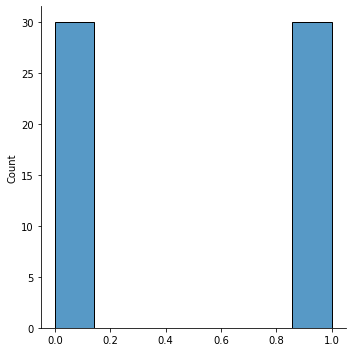

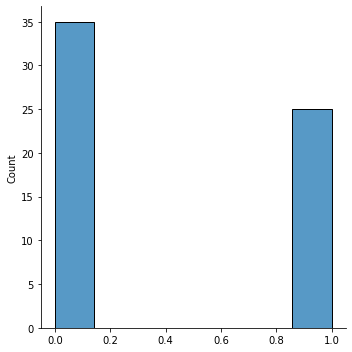

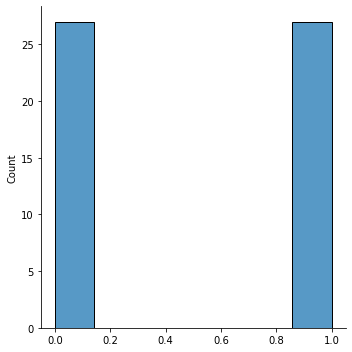

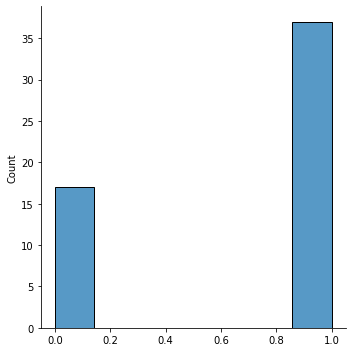

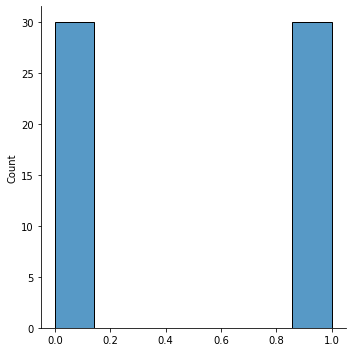

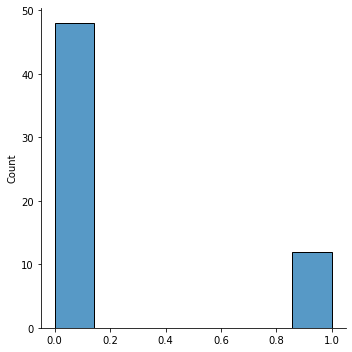

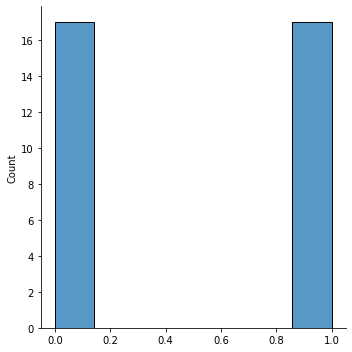

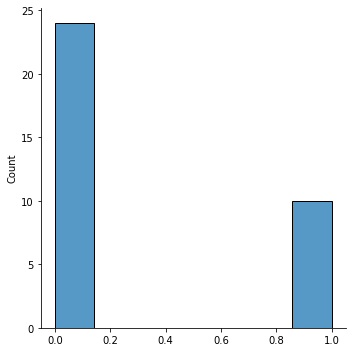

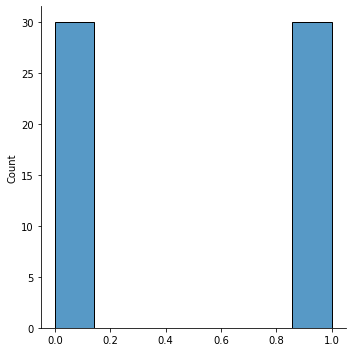

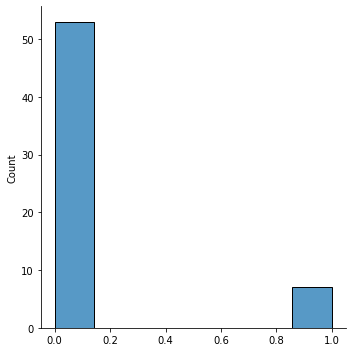

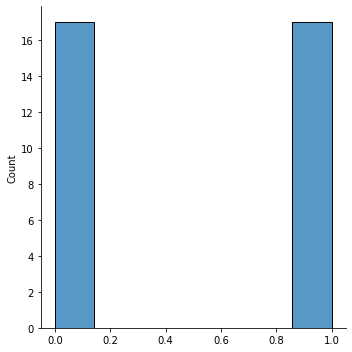

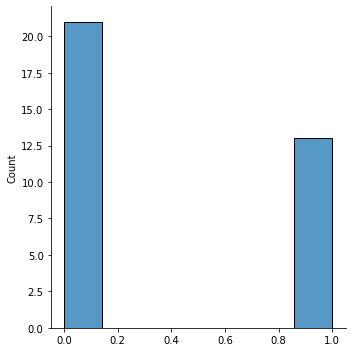

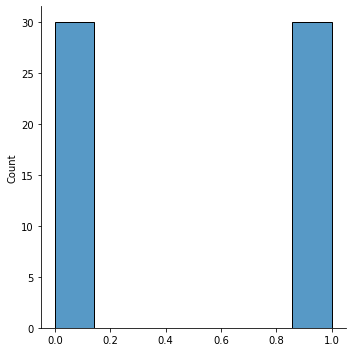

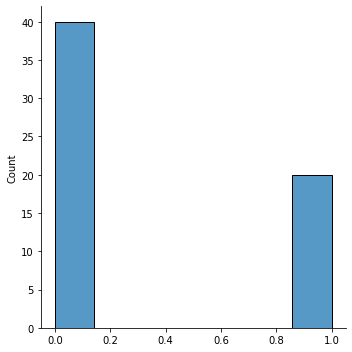

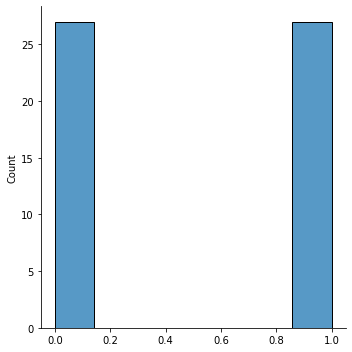

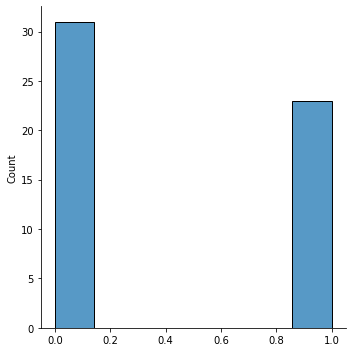

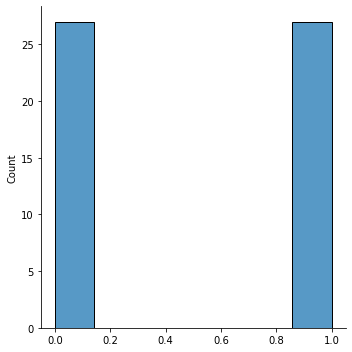

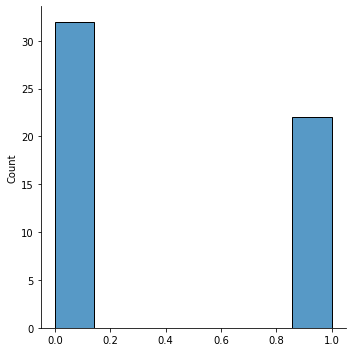

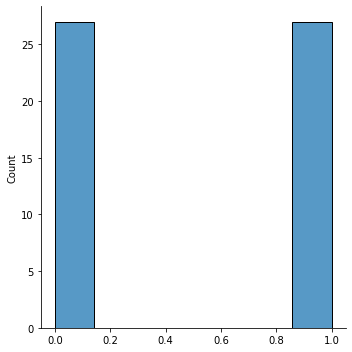

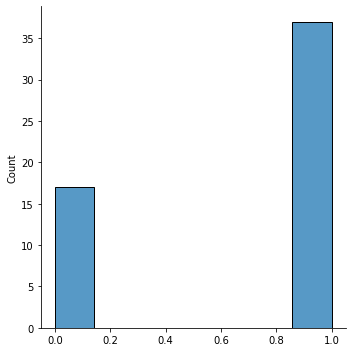

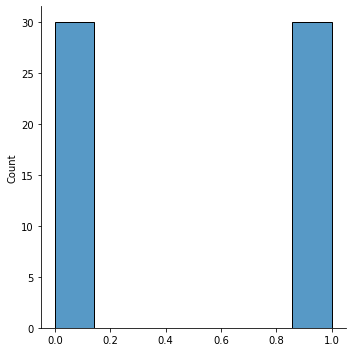

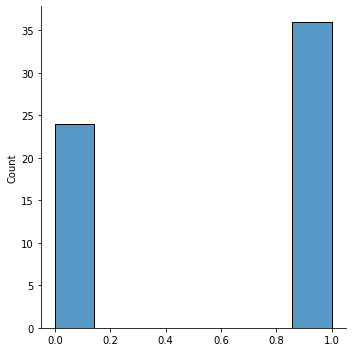

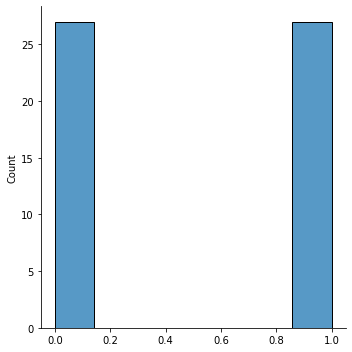

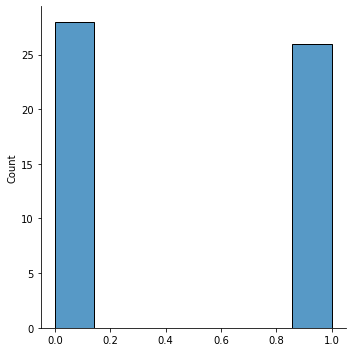

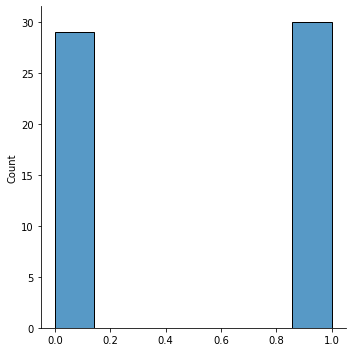

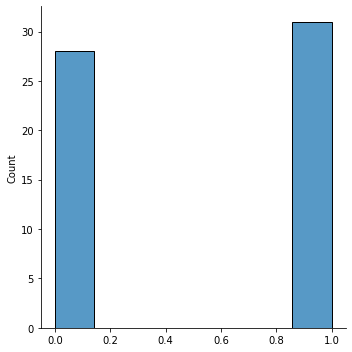

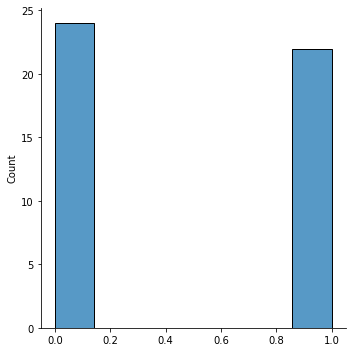

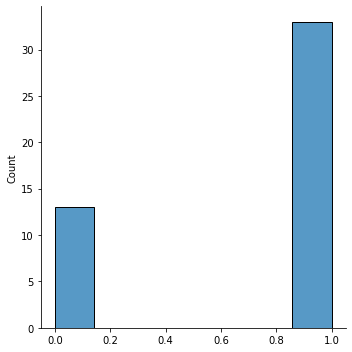

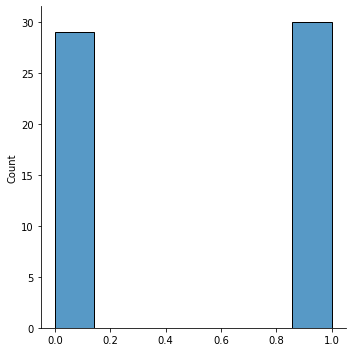

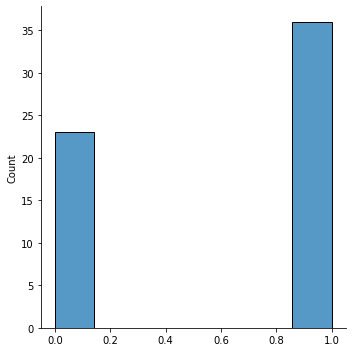

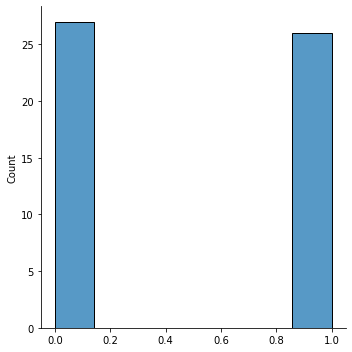

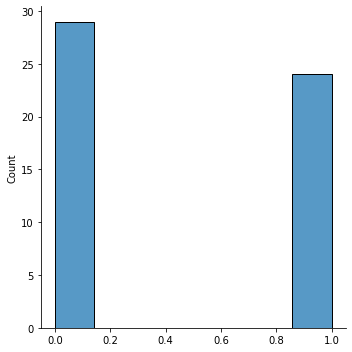

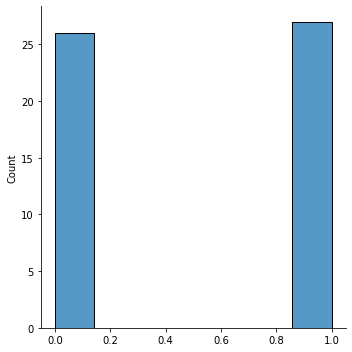

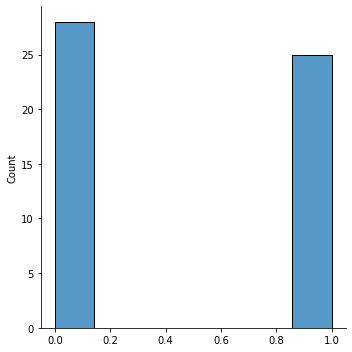

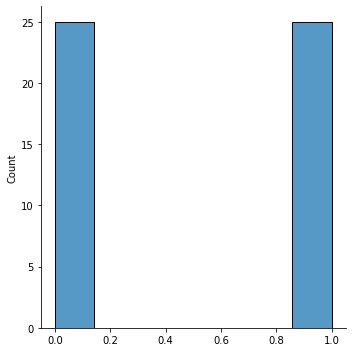

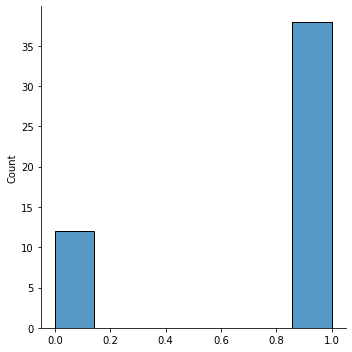

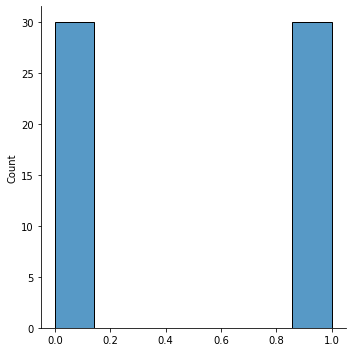

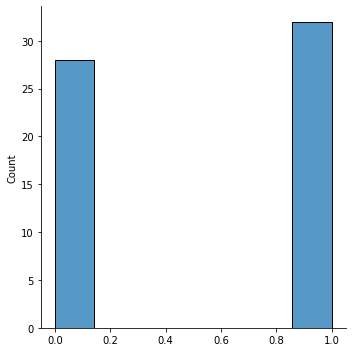

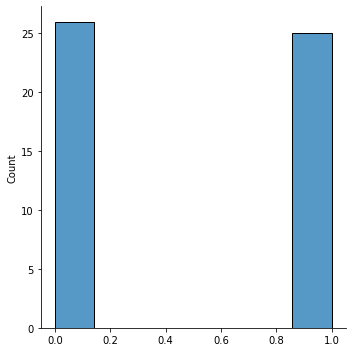

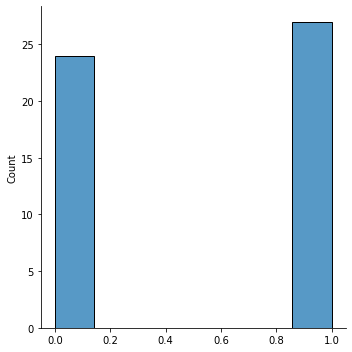

In [19]:
metrics = pd.DataFrame({"model": [], "AUC": [], "acc": [], "spec": [], "sens": [], "prec": []})
for folder in folders_list:
    model_common_path = "../RSNA-BTC-Datasets/out_models/"
    model_folder = model_common_path + folder

    model_basefile, info = get_best_model(model_folder)
    m_modelfile = model_folder + "/" + model_basefile
    transform = None
    size = len(info["mri_types"])
    sel_slices = 1 if info["dims"] == 2 else None
    chosen_net = "alt" if info["dims"] == 2 else "sim"

    #m_modelfile = m_modelfile_3d
    print(m_modelfile)
    print(info)
    
    packs = generate_datasets(['KLF','FLAIR','T1w'])
    print(packs)
    
    loader_packs = get_loaders(packs)
    print(loader_packs)
    
    # Model check
    model = try_and_get_model(chosen_net, info["dims"], size, info["is_depth_wise"], info["output_size"])
    print(count_parameters(model))
    print(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info("Using CUDA...")
    
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    #print(loader_packs['KLF']['m_dataloaders'])
    selected_type = info["mri_types"][0]
    print(selected_type)
    m_dataloader = loader_packs[selected_type]['m_dataloaders']#m_dataloaders[0]
    # Competition Train
    m_train_loader = m_dataloader[0]
    # Competition Val
    m_val_loader = m_dataloader[1]
    # Competition Train + Val
    m_train_val_loader = m_dataloader[3]#m_loader
    # Competition Test
    m_test_loader = m_dataloader[2]

    t_dataloader = loader_packs[selected_type]['t_dataloaders']#t_dataloaders[0]
    # External Train
    t_train_loader = t_dataloader[0]
    # External Val
    t_val_loader = t_dataloader[1]
    # External Test
    t_test_loader = t_dataloader[2]

    n_dataloader = loader_packs[selected_type]['n_dataloaders']#n_dataloaders[0]
    # UPENN Train
    n_train_loader = n_dataloader[0]
    # UPENN Val
    n_val_loader = n_dataloader[1]
    # UPENN Train + Val
    n_train_val_loader = n_dataloader[3]#n_loader
    # UPENN Test
    n_test_loader = n_dataloader[2]

    if selected_type == "KLF":
        f_dataloader = loader_packs[selected_type]['f_dataloaders']#f_dataloaders[0]
        # Competition (Tumor Only) Train
        f_train_loader = f_dataloader[0]
        # Competition (Tumor Only) Val
        f_val_loader = f_dataloader[1]
        # Competition (Tumor Only) Train + Val
        f_train_val_loader = f_dataloader[3]
        # Competition (Tumor Only) Test
        f_test_loader = f_dataloader[2]

        h_dataloader = loader_packs[selected_type]['h_dataloaders']#h_dataloaders[0]
        # Competition (No Tumor) Train
        h_train_loader = h_dataloader[0]
        # Competition (No Tumor) Val
        h_val_loader = h_dataloader[1]
        # Competition (No Tumor) Train + Val
        h_train_val_loader = h_dataloader[3]
        # Competition (No Tumor) Test
        h_test_loader = h_dataloader[2]

        fn_dataloader = loader_packs[selected_type]['fn_dataloaders']#fn_dataloaders[0]
        # Competition (Tumor Only) + UPENN Train
        fn_train_loader = fn_dataloader[0]
        # Competition (Tumor Only) + UPENN Val
        fn_val_loader = fn_dataloader[1]
        # Competition (Tumor Only) + UPENN Train + Val
        fn_train_val_loader = fn_dataloader[3]
        # Competition (Tumor Only) + UPENN Test
        fn_test_loader = fn_dataloader[2]
        
    m_model = try_and_get_model(chosen_net, info["dims"], size, info["is_depth_wise"], info["output_size"])
    
    # Methylation Detector
    train_loader = m_train_loader
    to = info["train_origin"]
    if to == "m":
        train_loader = m_train_loader
    elif to == "M":
        train_loader = m_train_val_loader
    elif to == "f":
        train_loader = f_train_loader
    elif to == "F":
        train_loader = f_train_val_loader
    elif to == "h":
        train_loader = h_train_loader
    elif to == "n":
        train_loader = n_train_loader
    elif to == "N":
        train_loader = n_train_val_loader
    elif to == "t":
        train_loader = t_train_loader
    elif to == "fn":
        train_loader = fn_train_loader
    elif to == "FN":
        train_loader == fn_train_val_loader

    val_loader = m_val_loader
    vo = info["val_origin"]
    if vo == "m":
        val_loader = m_val_loader
    elif vo == "M":
        val_loader = m_train_val_loader
    elif vo == "f":
        val_loader = f_val_loader
    elif vo == "F":
        val_loader = f_train_val_loader
    elif vo == "h":
        val_loader = h_val_loader
    elif vo == "n":
        val_loader = n_val_loader
    elif vo == "N":
        val_loader = n_train_val_loader
    elif vo == "t":
        val_loader = t_val_loader
    elif vo == "fn":
        val_loader = fn_val_loader
    elif vo == "FN":
        val_loader == fn_train_val_loader

    print(to, vo)
    
    print("\nPREDICTIONS:")
    print(folder)
    print(to, vo)
    print("Test set: m (A)")
    if info["train_origin"] == "f":
        test_loader = f_test_loader
        f_test_pred, ids, X, y, y_pred, y_prob = predict(m_model, device, m_modelfile, test_loader, size)
        ids = list(ids) + h_ids
        y = list(y) + h_y
        y_pred = list(y_pred) + h_preds
        y_prob = list(y_prob) + h_probs
        print("Fixed metrics:")
        pd_metrics = get_metrics(y, y_pred, y_prob, f"{folder}_{to}_A")
        
    else:
        test_loader = m_test_loader
        m_test_pred, ids, X, y, y_pred, y_prob = predict(m_model, device, m_modelfile, test_loader, size)
        pd_metrics = get_metrics(y, y_pred, y_prob, f"{folder}_{to}_A")
        
    preddfA = pd.DataFrame({"BraTS21ID": ids, "MGMT_real_value": y, "MGMT_pred_value": y_pred, "MGMT_prob_value": y_prob}) 
    preddfA = preddfA.sort_values(by="BraTS21ID")
    preddfA.to_csv(f"pred_metrics/{folder}_{to}_A.csv", index=False)
    metrics = metrics.append(pd_metrics, ignore_index=True)
    #pd_metrics.to_csv(f"pred_metrics/{folder}_{to}_A_metrics.csv", index=False)
    
    print("Test set: n (B)")
    test_loader = n_test_loader
    n_test_pred, ids, X, y, y_pred, y_prob = predict(m_model, device, m_modelfile, test_loader, size)
    pd_metrics = get_metrics(y, y_pred, y_prob, f"{folder}_{to}_B")
    preddfB = pd.DataFrame({"BraTS21ID": ids, "MGMT_real_value": y, "MGMT_pred_value": y_pred, "MGMT_prob_value": y_prob}) 
    preddfB = preddfB.sort_values(by="BraTS21ID")
    preddfB.to_csv(f"pred_metrics/{folder}_{to}_B.csv", index=False)
    metrics = metrics.append(pd_metrics, ignore_index=True)
    
    print("----------\n")
    
metrics.to_csv(f"pred_metrics/all_metrics.csv", index=False)

{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': True, 'is_transformed': False, 'output_size': 1, 'is_multistep': True, 'lr': 0.0001, 'is_adam': True, 'momentum': 0.9, 'is_10_fold': False, 'val_total_ratio': 0.2, 'is_internal_dataset': True, 'train_origin': 'fn', 'val_origin': 'fn', 'net': 'RSNAClassifierSingle3D'}
RSNAClassifierSingle3D(
  (part1): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): Conv3d(1, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (2): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), groups=4, bias=False)
      (1): Conv3d(4, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

  0%|                                                   | 0/150 [00:00<?, ?it/s]

2022-08-02 18:42:47 - EPOCH: 1
2022-08-02 18:42:51 - Train Step 10/192, train_loss: 0.6979
2022-08-02 18:42:55 - Train Step 20/192, train_loss: 0.7040
2022-08-02 18:42:59 - Train Step 30/192, train_loss: 0.7108
2022-08-02 18:43:03 - Train Step 40/192, train_loss: 0.7046
2022-08-02 18:43:06 - Train Step 50/192, train_loss: 0.7023
2022-08-02 18:43:10 - Train Step 60/192, train_loss: 0.6921
2022-08-02 18:43:14 - Train Step 70/192, train_loss: 0.6970
2022-08-02 18:43:18 - Train Step 80/192, train_loss: 0.6946
2022-08-02 18:43:22 - Train Step 90/192, train_loss: 0.6922
2022-08-02 18:43:26 - Train Step 100/192, train_loss: 0.6937
2022-08-02 18:43:29 - Train Step 110/192, train_loss: 0.6931
2022-08-02 18:43:33 - Train Step 120/192, train_loss: 0.6929
2022-08-02 18:43:37 - Train Step 130/192, train_loss: 0.6863
2022-08-02 18:43:41 - Train Step 140/192, train_loss: 0.6885
2022-08-02 18:43:45 - Train Step 150/192, train_loss: 0.6886
2022-08-02 18:43:48 - Train Step 160/192, train_loss: 0.6880
20

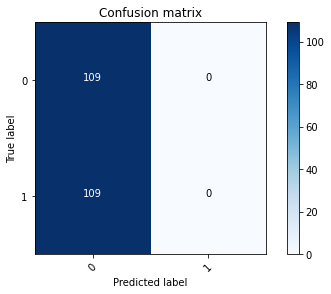

2022-08-02 18:44:22 - [Epoch Train: 1] loss: 0.6826, auc: 0.5797, acc: 0.5392, time: 72.00 s            
2022-08-02 18:44:22 - [Epoch Valid: 1] loss: 0.6770, auc: 0.6889, acc: 0.5000, time: 21.00 s
2022-08-02 18:44:22 - acc improved from 0.0000 to 0.5000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug02_18-42-47/RSNAClassifierSingle3D-DW-SO-KLF-e1-loss0.677-acc0.500-auc0.689.pth'


  1%|▎                                        | 1/150 [01:34<3:54:38, 94.49s/it]

2022-08-02 18:44:22 - EPOCH: 2
2022-08-02 18:44:26 - Train Step 10/192, train_loss: 0.5813
2022-08-02 18:44:31 - Train Step 20/192, train_loss: 0.6288
2022-08-02 18:44:35 - Train Step 30/192, train_loss: 0.6123
2022-08-02 18:44:39 - Train Step 40/192, train_loss: 0.6059
2022-08-02 18:44:43 - Train Step 50/192, train_loss: 0.6121
2022-08-02 18:44:47 - Train Step 60/192, train_loss: 0.6094
2022-08-02 18:44:51 - Train Step 70/192, train_loss: 0.6043
2022-08-02 18:44:55 - Train Step 80/192, train_loss: 0.6000
2022-08-02 18:44:58 - Train Step 90/192, train_loss: 0.6041
2022-08-02 18:45:02 - Train Step 100/192, train_loss: 0.6084
2022-08-02 18:45:06 - Train Step 110/192, train_loss: 0.6046
2022-08-02 18:45:10 - Train Step 120/192, train_loss: 0.6045
2022-08-02 18:45:14 - Train Step 130/192, train_loss: 0.6027
2022-08-02 18:45:18 - Train Step 140/192, train_loss: 0.6037
2022-08-02 18:45:21 - Train Step 150/192, train_loss: 0.6033
2022-08-02 18:45:25 - Train Step 160/192, train_loss: 0.6002
20

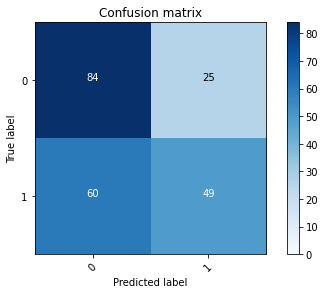

2022-08-02 18:45:59 - [Epoch Train: 2] loss: 0.5961, auc: 0.7853, acc: 0.6305, time: 74.00 s            
2022-08-02 18:45:59 - [Epoch Valid: 2] loss: 0.6526, auc: 0.6885, acc: 0.6101, time: 22.00 s
2022-08-02 18:45:59 - acc improved from 0.5000 to 0.6101. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug02_18-42-47/RSNAClassifierSingle3D-DW-SO-KLF-e2-loss0.653-acc0.610-auc0.689.pth'


  1%|▌                                        | 2/150 [03:11<3:57:19, 96.21s/it]

2022-08-02 18:45:59 - EPOCH: 3
2022-08-02 18:46:03 - Train Step 10/192, train_loss: 0.5175
2022-08-02 18:46:07 - Train Step 20/192, train_loss: 0.5015
2022-08-02 18:46:11 - Train Step 30/192, train_loss: 0.4804
2022-08-02 18:46:15 - Train Step 40/192, train_loss: 0.4764
2022-08-02 18:46:19 - Train Step 50/192, train_loss: 0.4712
2022-08-02 18:46:23 - Train Step 60/192, train_loss: 0.4619
2022-08-02 18:46:27 - Train Step 70/192, train_loss: 0.4671
2022-08-02 18:46:30 - Train Step 80/192, train_loss: 0.4627
2022-08-02 18:46:34 - Train Step 90/192, train_loss: 0.4659
2022-08-02 18:46:38 - Train Step 100/192, train_loss: 0.4638
2022-08-02 18:46:42 - Train Step 110/192, train_loss: 0.4627
2022-08-02 18:46:46 - Train Step 120/192, train_loss: 0.4611
2022-08-02 18:46:50 - Train Step 130/192, train_loss: 0.4636
2022-08-02 18:46:53 - Train Step 140/192, train_loss: 0.4659
2022-08-02 18:46:57 - Train Step 150/192, train_loss: 0.4586
2022-08-02 18:47:01 - Train Step 160/192, train_loss: 0.4573
20

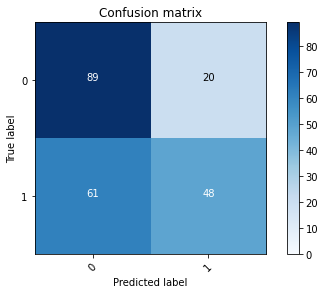

2022-08-02 18:47:35 - [Epoch Train: 3] loss: 0.4557, auc: 0.9184, acc: 0.7663, time: 74.00 s            
2022-08-02 18:47:35 - [Epoch Valid: 3] loss: 0.5872, auc: 0.7541, acc: 0.6284, time: 22.00 s
2022-08-02 18:47:35 - acc improved from 0.6101 to 0.6284. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug02_18-42-47/RSNAClassifierSingle3D-DW-SO-KLF-e3-loss0.587-acc0.628-auc0.754.pth'


  2%|▊                                        | 3/150 [04:48<3:55:52, 96.28s/it]

2022-08-02 18:47:35 - EPOCH: 4
2022-08-02 18:47:40 - Train Step 10/192, train_loss: 0.3346
2022-08-02 18:47:43 - Train Step 20/192, train_loss: 0.3746
2022-08-02 18:47:47 - Train Step 30/192, train_loss: 0.3597
2022-08-02 18:47:51 - Train Step 40/192, train_loss: 0.3475
2022-08-02 18:47:55 - Train Step 50/192, train_loss: 0.3329
2022-08-02 18:47:59 - Train Step 60/192, train_loss: 0.3369
2022-08-02 18:48:03 - Train Step 70/192, train_loss: 0.3309
2022-08-02 18:48:07 - Train Step 80/192, train_loss: 0.3311
2022-08-02 18:48:11 - Train Step 90/192, train_loss: 0.3199
2022-08-02 18:48:14 - Train Step 100/192, train_loss: 0.3213
2022-08-02 18:48:18 - Train Step 110/192, train_loss: 0.3185
2022-08-02 18:48:22 - Train Step 120/192, train_loss: 0.3103
2022-08-02 18:48:27 - Train Step 130/192, train_loss: 0.3059
2022-08-02 18:48:31 - Train Step 140/192, train_loss: 0.3018
2022-08-02 18:48:35 - Train Step 150/192, train_loss: 0.3009
2022-08-02 18:48:40 - Train Step 160/192, train_loss: 0.3010
20

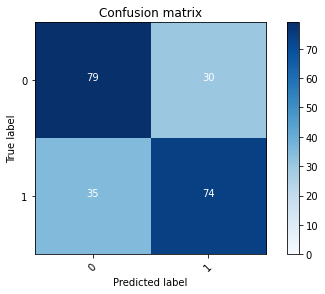

2022-08-02 18:49:21 - [Epoch Train: 4] loss: 0.2977, auc: 0.9731, acc: 0.8890, time: 77.00 s            
2022-08-02 18:49:21 - [Epoch Valid: 4] loss: 0.5827, auc: 0.7810, acc: 0.7018, time: 27.00 s
2022-08-02 18:49:21 - acc improved from 0.6284 to 0.7018. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug02_18-42-47/RSNAClassifierSingle3D-DW-SO-KLF-e4-loss0.583-acc0.702-auc0.781.pth'


  3%|█                                        | 4/150 [06:33<4:02:59, 99.86s/it]

2022-08-02 18:49:21 - EPOCH: 5
2022-08-02 18:49:26 - Train Step 10/192, train_loss: 0.1632
2022-08-02 18:49:30 - Train Step 20/192, train_loss: 0.1831
2022-08-02 18:49:35 - Train Step 30/192, train_loss: 0.1807
2022-08-02 18:49:39 - Train Step 40/192, train_loss: 0.1874
2022-08-02 18:49:44 - Train Step 50/192, train_loss: 0.2071
2022-08-02 18:49:48 - Train Step 60/192, train_loss: 0.2020
2022-08-02 18:49:52 - Train Step 70/192, train_loss: 0.1974
2022-08-02 18:49:57 - Train Step 80/192, train_loss: 0.1974
2022-08-02 18:50:01 - Train Step 90/192, train_loss: 0.1953
2022-08-02 18:50:05 - Train Step 100/192, train_loss: 0.1917
2022-08-02 18:50:08 - Train Step 110/192, train_loss: 0.1852
2022-08-02 18:50:12 - Train Step 120/192, train_loss: 0.1879
2022-08-02 18:50:16 - Train Step 130/192, train_loss: 0.1829
2022-08-02 18:50:20 - Train Step 140/192, train_loss: 0.1814
2022-08-02 18:50:24 - Train Step 150/192, train_loss: 0.1767
2022-08-02 18:50:28 - Train Step 160/192, train_loss: 0.1735
20

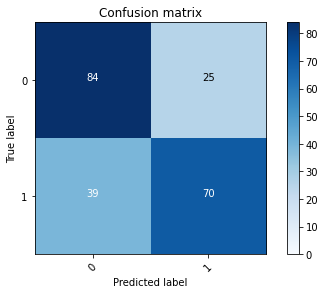

2022-08-02 18:51:06 - [Epoch Train: 5] loss: 0.1699, auc: 0.9926, acc: 0.9439, time: 79.00 s            
2022-08-02 18:51:06 - [Epoch Valid: 5] loss: 0.6154, auc: 0.7967, acc: 0.7064, time: 25.00 s
2022-08-02 18:51:06 - acc improved from 0.7018 to 0.7064. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug02_18-42-47/RSNAClassifierSingle3D-DW-SO-KLF-e5-loss0.615-acc0.706-auc0.797.pth'


  3%|█▎                                      | 5/150 [08:18<4:05:44, 101.69s/it]

2022-08-02 18:51:06 - EPOCH: 6
2022-08-02 18:51:10 - Train Step 10/192, train_loss: 0.0813
2022-08-02 18:51:15 - Train Step 20/192, train_loss: 0.0864
2022-08-02 18:51:19 - Train Step 30/192, train_loss: 0.0964
2022-08-02 18:51:24 - Train Step 40/192, train_loss: 0.0882
2022-08-02 18:51:28 - Train Step 50/192, train_loss: 0.0899
2022-08-02 18:51:33 - Train Step 60/192, train_loss: 0.0906
2022-08-02 18:51:37 - Train Step 70/192, train_loss: 0.0962
2022-08-02 18:51:41 - Train Step 80/192, train_loss: 0.0983
2022-08-02 18:51:46 - Train Step 90/192, train_loss: 0.0957
2022-08-02 18:51:50 - Train Step 100/192, train_loss: 0.0938
2022-08-02 18:51:55 - Train Step 110/192, train_loss: 0.0927
2022-08-02 18:51:59 - Train Step 120/192, train_loss: 0.0899
2022-08-02 18:52:04 - Train Step 130/192, train_loss: 0.0879
2022-08-02 18:52:08 - Train Step 140/192, train_loss: 0.0853
2022-08-02 18:52:13 - Train Step 150/192, train_loss: 0.0840
2022-08-02 18:52:17 - Train Step 160/192, train_loss: 0.0838
20

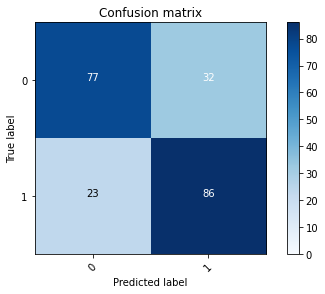

2022-08-02 18:52:56 - [Epoch Train: 6] loss: 0.0845, auc: 0.9994, acc: 0.9869, time: 85.00 s            
2022-08-02 18:52:56 - [Epoch Valid: 6] loss: 0.6667, auc: 0.8073, acc: 0.7477, time: 24.00 s
2022-08-02 18:52:56 - acc improved from 0.7064 to 0.7477. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug02_18-42-47/RSNAClassifierSingle3D-DW-SO-KLF-e6-loss0.667-acc0.748-auc0.807.pth'


  4%|█▌                                      | 6/150 [10:08<4:11:00, 104.58s/it]

2022-08-02 18:52:56 - EPOCH: 7
2022-08-02 18:53:00 - Train Step 10/192, train_loss: 0.0369
2022-08-02 18:53:05 - Train Step 20/192, train_loss: 0.0457
2022-08-02 18:53:09 - Train Step 30/192, train_loss: 0.0421
2022-08-02 18:53:14 - Train Step 40/192, train_loss: 0.0389
2022-08-02 18:53:18 - Train Step 50/192, train_loss: 0.0427
2022-08-02 18:53:23 - Train Step 60/192, train_loss: 0.0444
2022-08-02 18:53:28 - Train Step 70/192, train_loss: 0.0443
2022-08-02 18:53:33 - Train Step 80/192, train_loss: 0.0429
2022-08-02 18:53:37 - Train Step 90/192, train_loss: 0.0425
2022-08-02 18:53:42 - Train Step 100/192, train_loss: 0.0430
2022-08-02 18:53:47 - Train Step 110/192, train_loss: 0.0418
2022-08-02 18:53:51 - Train Step 120/192, train_loss: 0.0426
2022-08-02 18:53:55 - Train Step 130/192, train_loss: 0.0417
2022-08-02 18:54:00 - Train Step 140/192, train_loss: 0.0419
2022-08-02 18:54:04 - Train Step 150/192, train_loss: 0.0427
2022-08-02 18:54:09 - Train Step 160/192, train_loss: 0.0442
20

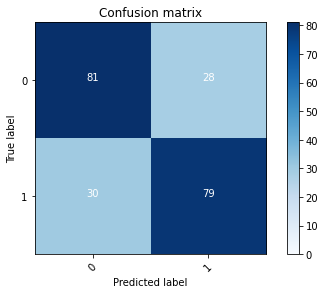

2022-08-02 18:54:47 - [Epoch Train: 7] loss: 0.0429, auc: 1.0000, acc: 0.9948, time: 86.00 s            
2022-08-02 18:54:47 - [Epoch Valid: 7] loss: 0.7005, auc: 0.8184, acc: 0.7339, time: 24.00 s


  5%|█▊                                      | 7/150 [11:59<4:14:10, 106.65s/it]

2022-08-02 18:54:47 - EPOCH: 8
2022-08-02 18:54:52 - Train Step 10/192, train_loss: 0.0315
2022-08-02 18:54:56 - Train Step 20/192, train_loss: 0.0284
2022-08-02 18:55:01 - Train Step 30/192, train_loss: 0.0244
2022-08-02 18:55:05 - Train Step 40/192, train_loss: 0.0236
2022-08-02 18:55:10 - Train Step 50/192, train_loss: 0.0273
2022-08-02 18:55:14 - Train Step 60/192, train_loss: 0.0272
2022-08-02 18:55:19 - Train Step 70/192, train_loss: 0.0263
2022-08-02 18:55:23 - Train Step 80/192, train_loss: 0.0282
2022-08-02 18:55:27 - Train Step 90/192, train_loss: 0.0286
2022-08-02 18:55:31 - Train Step 100/192, train_loss: 0.0271
2022-08-02 18:55:35 - Train Step 110/192, train_loss: 0.0269
2022-08-02 18:55:40 - Train Step 120/192, train_loss: 0.0259
2022-08-02 18:55:45 - Train Step 130/192, train_loss: 0.0252
2022-08-02 18:55:50 - Train Step 140/192, train_loss: 0.0250
2022-08-02 18:55:54 - Train Step 150/192, train_loss: 0.0246
2022-08-02 18:55:58 - Train Step 160/192, train_loss: 0.0254
20

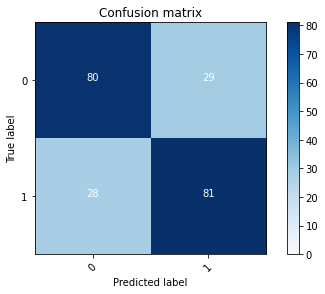

2022-08-02 18:56:38 - [Epoch Train: 8] loss: 0.0244, auc: 1.0000, acc: 0.9974, time: 85.00 s            
2022-08-02 18:56:38 - [Epoch Valid: 8] loss: 0.7475, auc: 0.8283, acc: 0.7385, time: 25.00 s


  5%|██▏                                     | 8/150 [13:51<4:16:10, 108.24s/it]

2022-08-02 18:56:38 - EPOCH: 9
2022-08-02 18:56:43 - Train Step 10/192, train_loss: 0.0120
2022-08-02 18:56:47 - Train Step 20/192, train_loss: 0.0135
2022-08-02 18:56:51 - Train Step 30/192, train_loss: 0.0145
2022-08-02 18:56:55 - Train Step 40/192, train_loss: 0.0129
2022-08-02 18:56:59 - Train Step 50/192, train_loss: 0.0128
2022-08-02 18:57:03 - Train Step 60/192, train_loss: 0.0140
2022-08-02 18:57:07 - Train Step 70/192, train_loss: 0.0133
2022-08-02 18:57:11 - Train Step 80/192, train_loss: 0.0146
2022-08-02 18:57:15 - Train Step 90/192, train_loss: 0.0142
2022-08-02 18:57:19 - Train Step 100/192, train_loss: 0.0137
2022-08-02 18:57:23 - Train Step 110/192, train_loss: 0.0134
2022-08-02 18:57:27 - Train Step 120/192, train_loss: 0.0140
2022-08-02 18:57:31 - Train Step 130/192, train_loss: 0.0141
2022-08-02 18:57:35 - Train Step 140/192, train_loss: 0.0149
2022-08-02 18:57:39 - Train Step 150/192, train_loss: 0.0148
2022-08-02 18:57:44 - Train Step 160/192, train_loss: 0.0156
20

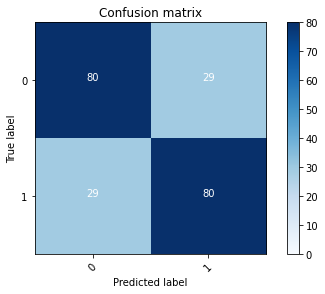

2022-08-02 18:58:15 - [Epoch Train: 9] loss: 0.0152, auc: 1.0000, acc: 0.9987, time: 77.00 s            
2022-08-02 18:58:15 - [Epoch Valid: 9] loss: 0.7933, auc: 0.8260, acc: 0.7339, time: 18.00 s


  6%|██▍                                     | 9/150 [15:27<4:05:37, 104.52s/it]

2022-08-02 18:58:15 - EPOCH: 10
2022-08-02 18:58:18 - Train Step 10/192, train_loss: 0.0109
2022-08-02 18:58:21 - Train Step 20/192, train_loss: 0.0132
2022-08-02 18:58:25 - Train Step 30/192, train_loss: 0.0113
2022-08-02 18:58:28 - Train Step 40/192, train_loss: 0.0111
2022-08-02 18:58:31 - Train Step 50/192, train_loss: 0.0126
2022-08-02 18:58:34 - Train Step 60/192, train_loss: 0.0126
2022-08-02 18:58:37 - Train Step 70/192, train_loss: 0.0116
2022-08-02 18:58:40 - Train Step 80/192, train_loss: 0.0111
2022-08-02 18:58:43 - Train Step 90/192, train_loss: 0.0110
2022-08-02 18:58:47 - Train Step 100/192, train_loss: 0.0108
2022-08-02 18:58:50 - Train Step 110/192, train_loss: 0.0104
2022-08-02 18:58:53 - Train Step 120/192, train_loss: 0.0104
2022-08-02 18:58:56 - Train Step 130/192, train_loss: 0.0103
2022-08-02 18:58:59 - Train Step 140/192, train_loss: 0.0101
2022-08-02 18:59:02 - Train Step 150/192, train_loss: 0.0100
2022-08-02 18:59:05 - Train Step 160/192, train_loss: 0.0098
2

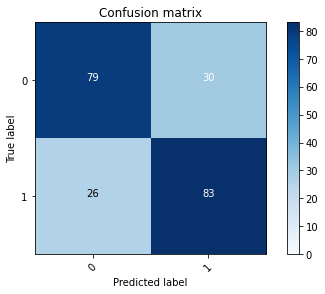

2022-08-02 18:59:33 - [Epoch Train: 10] loss: 0.0097, auc: 1.0000, acc: 0.9987, time: 60.00 s            
2022-08-02 18:59:33 - [Epoch Valid: 10] loss: 0.8346, auc: 0.8256, acc: 0.7431, time: 17.00 s


  7%|██▋                                     | 10/150 [16:45<3:44:44, 96.32s/it]

2022-08-02 18:59:33 - EPOCH: 11
2022-08-02 18:59:36 - Train Step 10/192, train_loss: 0.0067
2022-08-02 18:59:39 - Train Step 20/192, train_loss: 0.0062
2022-08-02 18:59:43 - Train Step 30/192, train_loss: 0.0057
2022-08-02 18:59:46 - Train Step 40/192, train_loss: 0.0056
2022-08-02 18:59:49 - Train Step 50/192, train_loss: 0.0059
2022-08-02 18:59:52 - Train Step 60/192, train_loss: 0.0057
2022-08-02 18:59:55 - Train Step 70/192, train_loss: 0.0062
2022-08-02 18:59:58 - Train Step 80/192, train_loss: 0.0059
2022-08-02 19:00:01 - Train Step 90/192, train_loss: 0.0059
2022-08-02 19:00:04 - Train Step 100/192, train_loss: 0.0056
2022-08-02 19:00:07 - Train Step 110/192, train_loss: 0.0056
2022-08-02 19:00:11 - Train Step 120/192, train_loss: 0.0059
2022-08-02 19:00:14 - Train Step 130/192, train_loss: 0.0063
2022-08-02 19:00:17 - Train Step 140/192, train_loss: 0.0062
2022-08-02 19:00:20 - Train Step 150/192, train_loss: 0.0063
2022-08-02 19:00:23 - Train Step 160/192, train_loss: 0.0062
2

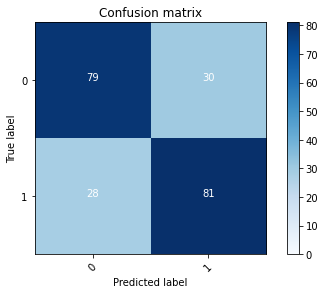

2022-08-02 19:00:51 - [Epoch Train: 11] loss: 0.0066, auc: 1.0000, acc: 1.0000, time: 60.00 s            
2022-08-02 19:00:51 - [Epoch Valid: 11] loss: 0.8504, auc: 0.8265, acc: 0.7339, time: 17.00 s


  7%|██▉                                     | 11/150 [18:03<3:30:19, 90.78s/it]

2022-08-02 19:00:51 - EPOCH: 12
2022-08-02 19:00:54 - Train Step 10/192, train_loss: 0.0061
2022-08-02 19:00:57 - Train Step 20/192, train_loss: 0.0049
2022-08-02 19:01:01 - Train Step 30/192, train_loss: 0.0054
2022-08-02 19:01:04 - Train Step 40/192, train_loss: 0.0051
2022-08-02 19:01:07 - Train Step 50/192, train_loss: 0.0057
2022-08-02 19:01:10 - Train Step 60/192, train_loss: 0.0054
2022-08-02 19:01:13 - Train Step 70/192, train_loss: 0.0063
2022-08-02 19:01:16 - Train Step 80/192, train_loss: 0.0060
2022-08-02 19:01:19 - Train Step 90/192, train_loss: 0.0060
2022-08-02 19:01:23 - Train Step 100/192, train_loss: 0.0059
2022-08-02 19:01:26 - Train Step 110/192, train_loss: 0.0057
2022-08-02 19:01:29 - Train Step 120/192, train_loss: 0.0057
2022-08-02 19:01:32 - Train Step 130/192, train_loss: 0.0056
2022-08-02 19:01:35 - Train Step 140/192, train_loss: 0.0056
2022-08-02 19:01:38 - Train Step 150/192, train_loss: 0.0055
2022-08-02 19:01:42 - Train Step 160/192, train_loss: 0.0053
2

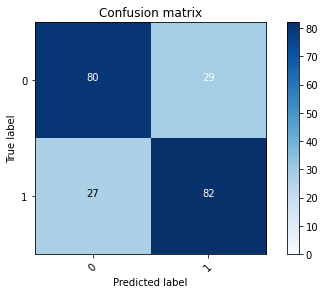

2022-08-02 19:02:09 - [Epoch Train: 12] loss: 0.0052, auc: 1.0000, acc: 1.0000, time: 60.00 s            
2022-08-02 19:02:09 - [Epoch Valid: 12] loss: 0.9588, auc: 0.8307, acc: 0.7431, time: 17.00 s


  8%|███▏                                    | 12/150 [19:21<3:19:57, 86.94s/it]

2022-08-02 19:02:09 - EPOCH: 13
2022-08-02 19:02:13 - Train Step 10/192, train_loss: 0.0042
2022-08-02 19:02:16 - Train Step 20/192, train_loss: 0.0044
2022-08-02 19:02:19 - Train Step 30/192, train_loss: 0.0046
2022-08-02 19:02:22 - Train Step 40/192, train_loss: 0.0056
2022-08-02 19:02:25 - Train Step 50/192, train_loss: 0.0053
2022-08-02 19:02:28 - Train Step 60/192, train_loss: 0.0051
2022-08-02 19:02:31 - Train Step 70/192, train_loss: 0.0059
2022-08-02 19:02:35 - Train Step 80/192, train_loss: 0.0056
2022-08-02 19:02:38 - Train Step 90/192, train_loss: 0.0053
2022-08-02 19:02:41 - Train Step 100/192, train_loss: 0.0061
2022-08-02 19:02:44 - Train Step 110/192, train_loss: 0.0060
2022-08-02 19:02:47 - Train Step 120/192, train_loss: 0.0060
2022-08-02 19:02:50 - Train Step 130/192, train_loss: 0.0058
2022-08-02 19:02:53 - Train Step 140/192, train_loss: 0.0055
2022-08-02 19:02:56 - Train Step 150/192, train_loss: 0.0059
2022-08-02 19:03:00 - Train Step 160/192, train_loss: 0.0058
2

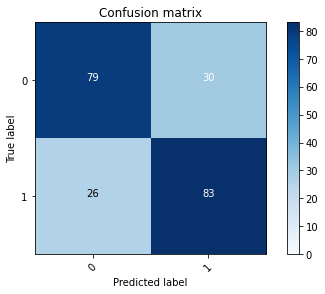

2022-08-02 19:03:27 - [Epoch Train: 13] loss: 0.0057, auc: 1.0000, acc: 1.0000, time: 60.00 s            
2022-08-02 19:03:27 - [Epoch Valid: 13] loss: 0.9665, auc: 0.8280, acc: 0.7431, time: 18.00 s


  9%|███▍                                    | 13/150 [20:40<3:12:22, 84.25s/it]

2022-08-02 19:03:27 - EPOCH: 14
2022-08-02 19:03:31 - Train Step 10/192, train_loss: 0.0032
2022-08-02 19:03:34 - Train Step 20/192, train_loss: 0.0046
2022-08-02 19:03:37 - Train Step 30/192, train_loss: 0.0040
2022-08-02 19:03:40 - Train Step 40/192, train_loss: 0.0038
2022-08-02 19:03:43 - Train Step 50/192, train_loss: 0.0035
2022-08-02 19:03:46 - Train Step 60/192, train_loss: 0.0035
2022-08-02 19:03:50 - Train Step 70/192, train_loss: 0.0036
2022-08-02 19:03:53 - Train Step 80/192, train_loss: 0.0037
2022-08-02 19:03:56 - Train Step 90/192, train_loss: 0.0039
2022-08-02 19:03:59 - Train Step 100/192, train_loss: 0.0038
2022-08-02 19:04:02 - Train Step 110/192, train_loss: 0.0038
2022-08-02 19:04:05 - Train Step 120/192, train_loss: 0.0036
2022-08-02 19:04:08 - Train Step 130/192, train_loss: 0.0037
2022-08-02 19:04:11 - Train Step 140/192, train_loss: 0.0047
2022-08-02 19:04:14 - Train Step 150/192, train_loss: 0.0048
2022-08-02 19:04:17 - Train Step 160/192, train_loss: 0.0047
2

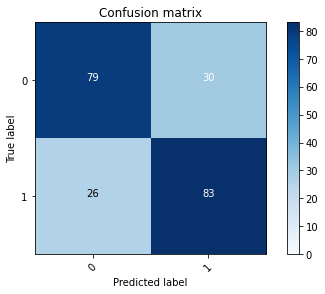

2022-08-02 19:04:45 - [Epoch Train: 14] loss: 0.0045, auc: 1.0000, acc: 0.9987, time: 59.00 s            
2022-08-02 19:04:45 - [Epoch Valid: 14] loss: 0.9479, auc: 0.8296, acc: 0.7431, time: 17.00 s


  9%|███▋                                    | 14/150 [21:57<3:06:27, 82.26s/it]

2022-08-02 19:04:45 - EPOCH: 15
2022-08-02 19:04:48 - Train Step 10/192, train_loss: 0.0031
2022-08-02 19:04:51 - Train Step 20/192, train_loss: 0.0069
2022-08-02 19:04:55 - Train Step 30/192, train_loss: 0.0057
2022-08-02 19:04:58 - Train Step 40/192, train_loss: 0.0050
2022-08-02 19:05:01 - Train Step 50/192, train_loss: 0.0044
2022-08-02 19:05:04 - Train Step 60/192, train_loss: 0.0040
2022-08-02 19:05:07 - Train Step 70/192, train_loss: 0.0040
2022-08-02 19:05:10 - Train Step 80/192, train_loss: 0.0043
2022-08-02 19:05:13 - Train Step 90/192, train_loss: 0.0042
2022-08-02 19:05:16 - Train Step 100/192, train_loss: 0.0040
2022-08-02 19:05:20 - Train Step 110/192, train_loss: 0.0040
2022-08-02 19:05:23 - Train Step 120/192, train_loss: 0.0044
2022-08-02 19:05:26 - Train Step 130/192, train_loss: 0.0042
2022-08-02 19:05:29 - Train Step 140/192, train_loss: 0.0042
2022-08-02 19:05:32 - Train Step 150/192, train_loss: 0.0041
2022-08-02 19:05:35 - Train Step 160/192, train_loss: 0.0040
2

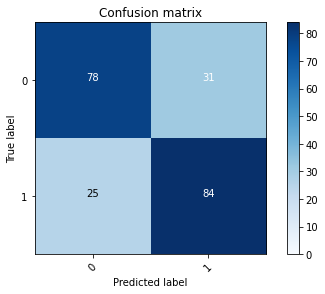

2022-08-02 19:06:02 - [Epoch Train: 15] loss: 0.0039, auc: 1.0000, acc: 1.0000, time: 59.00 s            
2022-08-02 19:06:02 - [Epoch Valid: 15] loss: 0.9710, auc: 0.8269, acc: 0.7431, time: 17.00 s


 10%|████                                    | 15/150 [23:14<3:01:36, 80.72s/it]

2022-08-02 19:06:02 - EPOCH: 16
2022-08-02 19:06:05 - Train Step 10/192, train_loss: 0.0017
2022-08-02 19:06:09 - Train Step 20/192, train_loss: 0.0022
2022-08-02 19:06:12 - Train Step 30/192, train_loss: 0.0021
2022-08-02 19:06:15 - Train Step 40/192, train_loss: 0.0022
2022-08-02 19:06:18 - Train Step 50/192, train_loss: 0.0022
2022-08-02 19:06:21 - Train Step 60/192, train_loss: 0.0023
2022-08-02 19:06:24 - Train Step 70/192, train_loss: 0.0044
2022-08-02 19:06:27 - Train Step 80/192, train_loss: 0.0043
2022-08-02 19:06:30 - Train Step 90/192, train_loss: 0.0043
2022-08-02 19:06:33 - Train Step 100/192, train_loss: 0.0041
2022-08-02 19:06:36 - Train Step 110/192, train_loss: 0.0041
2022-08-02 19:06:39 - Train Step 120/192, train_loss: 0.0040
2022-08-02 19:06:43 - Train Step 130/192, train_loss: 0.0039
2022-08-02 19:06:46 - Train Step 140/192, train_loss: 0.0043
2022-08-02 19:06:49 - Train Step 150/192, train_loss: 0.0041
2022-08-02 19:06:52 - Train Step 160/192, train_loss: 0.0041
2

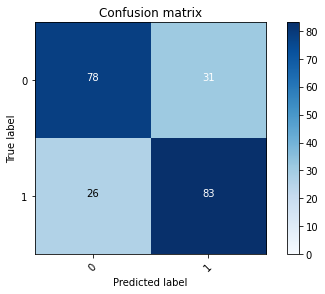

2022-08-02 19:07:20 - [Epoch Train: 16] loss: 0.0038, auc: 1.0000, acc: 0.9987, time: 59.00 s            
2022-08-02 19:07:20 - [Epoch Valid: 16] loss: 0.9851, auc: 0.8303, acc: 0.7385, time: 17.00 s


 11%|████▎                                   | 16/150 [24:32<2:58:16, 79.82s/it]

2022-08-02 19:07:20 - EPOCH: 17
2022-08-02 19:07:23 - Train Step 10/192, train_loss: 0.0025
2022-08-02 19:07:26 - Train Step 20/192, train_loss: 0.0021
2022-08-02 19:07:29 - Train Step 30/192, train_loss: 0.0021
2022-08-02 19:07:33 - Train Step 40/192, train_loss: 0.0021
2022-08-02 19:07:36 - Train Step 50/192, train_loss: 0.0021
2022-08-02 19:07:39 - Train Step 60/192, train_loss: 0.0022
2022-08-02 19:07:42 - Train Step 70/192, train_loss: 0.0021
2022-08-02 19:07:45 - Train Step 80/192, train_loss: 0.0020
2022-08-02 19:07:48 - Train Step 90/192, train_loss: 0.0020
2022-08-02 19:07:51 - Train Step 100/192, train_loss: 0.0024
2022-08-02 19:07:55 - Train Step 110/192, train_loss: 0.0023
2022-08-02 19:07:58 - Train Step 120/192, train_loss: 0.0025
2022-08-02 19:08:01 - Train Step 130/192, train_loss: 0.0027
2022-08-02 19:08:04 - Train Step 140/192, train_loss: 0.0031
2022-08-02 19:08:07 - Train Step 150/192, train_loss: 0.0030
2022-08-02 19:08:10 - Train Step 160/192, train_loss: 0.0030
2

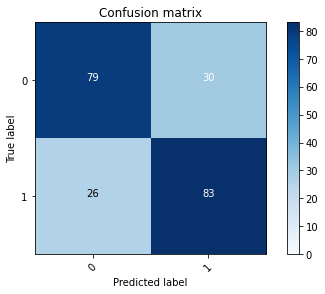

2022-08-02 19:08:38 - [Epoch Train: 17] loss: 0.0029, auc: 1.0000, acc: 1.0000, time: 60.00 s            
2022-08-02 19:08:38 - [Epoch Valid: 17] loss: 1.0190, auc: 0.8343, acc: 0.7431, time: 17.00 s


 11%|████▌                                   | 17/150 [25:50<2:55:38, 79.23s/it]

2022-08-02 19:08:38 - EPOCH: 18
2022-08-02 19:08:41 - Train Step 10/192, train_loss: 0.0031
2022-08-02 19:08:44 - Train Step 20/192, train_loss: 0.0041
2022-08-02 19:08:47 - Train Step 30/192, train_loss: 0.0031
2022-08-02 19:08:50 - Train Step 40/192, train_loss: 0.0030
2022-08-02 19:08:53 - Train Step 50/192, train_loss: 0.0027
2022-08-02 19:08:56 - Train Step 60/192, train_loss: 0.0027
2022-08-02 19:08:59 - Train Step 70/192, train_loss: 0.0025
2022-08-02 19:09:03 - Train Step 80/192, train_loss: 0.0023
2022-08-02 19:09:06 - Train Step 90/192, train_loss: 0.0023
2022-08-02 19:09:09 - Train Step 100/192, train_loss: 0.0022
2022-08-02 19:09:12 - Train Step 110/192, train_loss: 0.0021
2022-08-02 19:09:15 - Train Step 120/192, train_loss: 0.0020
2022-08-02 19:09:18 - Train Step 130/192, train_loss: 0.0019
2022-08-02 19:09:21 - Train Step 140/192, train_loss: 0.0022
2022-08-02 19:09:24 - Train Step 150/192, train_loss: 0.0022
2022-08-02 19:09:27 - Train Step 160/192, train_loss: 0.0022
2

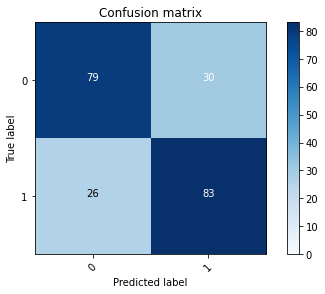

2022-08-02 19:09:55 - [Epoch Train: 18] loss: 0.0022, auc: 1.0000, acc: 1.0000, time: 59.00 s            
2022-08-02 19:09:55 - [Epoch Valid: 18] loss: 1.0450, auc: 0.8363, acc: 0.7431, time: 17.00 s


 12%|████▊                                   | 18/150 [27:07<2:52:56, 78.61s/it]

2022-08-02 19:09:55 - EPOCH: 19
2022-08-02 19:09:58 - Train Step 10/192, train_loss: 0.0023
2022-08-02 19:10:01 - Train Step 20/192, train_loss: 0.0024
2022-08-02 19:10:04 - Train Step 30/192, train_loss: 0.0022
2022-08-02 19:10:07 - Train Step 40/192, train_loss: 0.0023
2022-08-02 19:10:10 - Train Step 50/192, train_loss: 0.0028
2022-08-02 19:10:13 - Train Step 60/192, train_loss: 0.0026
2022-08-02 19:10:16 - Train Step 70/192, train_loss: 0.0025
2022-08-02 19:10:19 - Train Step 80/192, train_loss: 0.0023
2022-08-02 19:10:22 - Train Step 90/192, train_loss: 0.0023
2022-08-02 19:10:25 - Train Step 100/192, train_loss: 0.0022
2022-08-02 19:10:29 - Train Step 110/192, train_loss: 0.0022
2022-08-02 19:10:32 - Train Step 120/192, train_loss: 0.0022
2022-08-02 19:10:35 - Train Step 130/192, train_loss: 0.0021
2022-08-02 19:10:38 - Train Step 140/192, train_loss: 0.0022
2022-08-02 19:10:41 - Train Step 150/192, train_loss: 0.0021
2022-08-02 19:10:44 - Train Step 160/192, train_loss: 0.0021
2

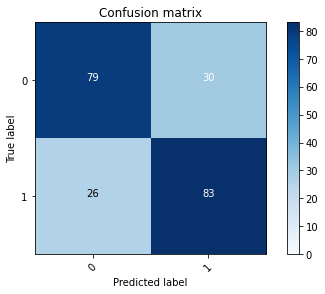

2022-08-02 19:11:11 - [Epoch Train: 19] loss: 0.0021, auc: 1.0000, acc: 1.0000, time: 58.00 s            
2022-08-02 19:11:11 - [Epoch Valid: 19] loss: 0.9847, auc: 0.8289, acc: 0.7431, time: 17.00 s


 13%|█████                                   | 19/150 [28:23<2:49:49, 77.78s/it]

2022-08-02 19:11:11 - EPOCH: 20
2022-08-02 19:11:14 - Train Step 10/192, train_loss: 0.0018
2022-08-02 19:11:17 - Train Step 20/192, train_loss: 0.0020
2022-08-02 19:11:20 - Train Step 30/192, train_loss: 0.0020
2022-08-02 19:11:23 - Train Step 40/192, train_loss: 0.0020
2022-08-02 19:11:26 - Train Step 50/192, train_loss: 0.0017
2022-08-02 19:11:30 - Train Step 60/192, train_loss: 0.0017
2022-08-02 19:11:33 - Train Step 70/192, train_loss: 0.0016
2022-08-02 19:11:36 - Train Step 80/192, train_loss: 0.0016
2022-08-02 19:11:39 - Train Step 90/192, train_loss: 0.0015
2022-08-02 19:11:42 - Train Step 100/192, train_loss: 0.0015
2022-08-02 19:11:45 - Train Step 110/192, train_loss: 0.0015
2022-08-02 19:11:48 - Train Step 120/192, train_loss: 0.0015
2022-08-02 19:11:51 - Train Step 130/192, train_loss: 0.0016
2022-08-02 19:11:54 - Train Step 140/192, train_loss: 0.0017
2022-08-02 19:11:57 - Train Step 150/192, train_loss: 0.0017
2022-08-02 19:12:00 - Train Step 160/192, train_loss: 0.0017
2

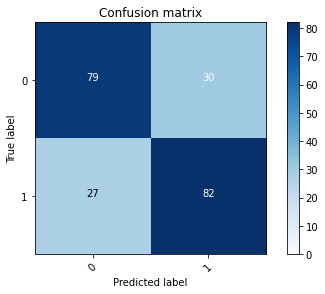

2022-08-02 19:12:28 - [Epoch Train: 20] loss: 0.0016, auc: 1.0000, acc: 1.0000, time: 59.00 s            
2022-08-02 19:12:28 - [Epoch Valid: 20] loss: 1.0455, auc: 0.8366, acc: 0.7385, time: 17.00 s


 13%|█████▎                                  | 20/150 [29:40<2:48:03, 77.56s/it]

2022-08-02 19:12:28 - EPOCH: 21
2022-08-02 19:12:31 - Train Step 10/192, train_loss: 0.0009
2022-08-02 19:12:34 - Train Step 20/192, train_loss: 0.0011
2022-08-02 19:12:37 - Train Step 30/192, train_loss: 0.0011
2022-08-02 19:12:40 - Train Step 40/192, train_loss: 0.0011
2022-08-02 19:12:44 - Train Step 50/192, train_loss: 0.0011
2022-08-02 19:12:47 - Train Step 60/192, train_loss: 0.0011
2022-08-02 19:12:50 - Train Step 70/192, train_loss: 0.0010
2022-08-02 19:12:53 - Train Step 80/192, train_loss: 0.0010
2022-08-02 19:12:56 - Train Step 90/192, train_loss: 0.0012
2022-08-02 19:12:59 - Train Step 100/192, train_loss: 0.0012
2022-08-02 19:13:02 - Train Step 110/192, train_loss: 0.0012
2022-08-02 19:13:05 - Train Step 120/192, train_loss: 0.0012
2022-08-02 19:13:08 - Train Step 130/192, train_loss: 0.0012
2022-08-02 19:13:12 - Train Step 140/192, train_loss: 0.0012
2022-08-02 19:13:15 - Train Step 150/192, train_loss: 0.0012
2022-08-02 19:13:18 - Train Step 160/192, train_loss: 0.0013
2

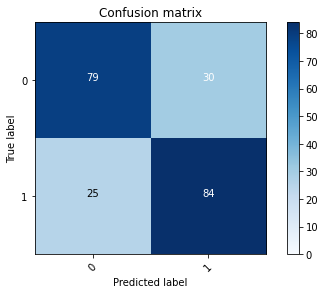

2022-08-02 19:13:45 - [Epoch Train: 21] loss: 0.0014, auc: 1.0000, acc: 1.0000, time: 59.00 s            
2022-08-02 19:13:45 - [Epoch Valid: 21] loss: 1.0667, auc: 0.8339, acc: 0.7477, time: 17.00 s
2022-08-02 19:13:45 - acc improved from 0.7477 to 0.7477. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug02_18-42-47/RSNAClassifierSingle3D-DW-SO-KLF-e21-loss1.067-acc0.748-auc0.834.pth'


 14%|█████▌                                  | 21/150 [30:57<2:46:26, 77.42s/it]

2022-08-02 19:13:45 - EPOCH: 22
2022-08-02 19:13:48 - Train Step 10/192, train_loss: 0.0009
2022-08-02 19:13:51 - Train Step 20/192, train_loss: 0.0011
2022-08-02 19:13:54 - Train Step 30/192, train_loss: 0.0014
2022-08-02 19:13:58 - Train Step 40/192, train_loss: 0.0013
2022-08-02 19:14:01 - Train Step 50/192, train_loss: 0.0012
2022-08-02 19:14:04 - Train Step 60/192, train_loss: 0.0012
2022-08-02 19:14:07 - Train Step 70/192, train_loss: 0.0012
2022-08-02 19:14:10 - Train Step 80/192, train_loss: 0.0012
2022-08-02 19:14:13 - Train Step 90/192, train_loss: 0.0011
2022-08-02 19:14:16 - Train Step 100/192, train_loss: 0.0011
2022-08-02 19:14:19 - Train Step 110/192, train_loss: 0.0011
2022-08-02 19:14:22 - Train Step 120/192, train_loss: 0.0011
2022-08-02 19:14:26 - Train Step 130/192, train_loss: 0.0012
2022-08-02 19:14:29 - Train Step 140/192, train_loss: 0.0012
2022-08-02 19:14:32 - Train Step 150/192, train_loss: 0.0012
2022-08-02 19:14:35 - Train Step 160/192, train_loss: 0.0011
2

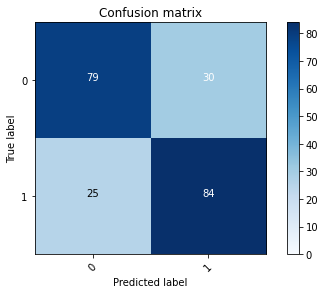

2022-08-02 19:15:02 - [Epoch Train: 22] loss: 0.0011, auc: 1.0000, acc: 1.0000, time: 59.00 s            
2022-08-02 19:15:02 - [Epoch Valid: 22] loss: 1.1882, auc: 0.8356, acc: 0.7477, time: 17.00 s
2022-08-02 19:15:02 - acc improved from 0.7477 to 0.7477. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug02_18-42-47/RSNAClassifierSingle3D-DW-SO-KLF-e22-loss1.188-acc0.748-auc0.836.pth'


 15%|█████▊                                  | 22/150 [32:14<2:44:58, 77.33s/it]

2022-08-02 19:15:02 - EPOCH: 23
2022-08-02 19:15:06 - Train Step 10/192, train_loss: 0.0006
2022-08-02 19:15:09 - Train Step 20/192, train_loss: 0.0006
2022-08-02 19:15:12 - Train Step 30/192, train_loss: 0.0006
2022-08-02 19:15:15 - Train Step 40/192, train_loss: 0.0010
2022-08-02 19:15:18 - Train Step 50/192, train_loss: 0.0010
2022-08-02 19:15:21 - Train Step 60/192, train_loss: 0.0010
2022-08-02 19:15:24 - Train Step 70/192, train_loss: 0.0011
2022-08-02 19:15:27 - Train Step 80/192, train_loss: 0.0014
2022-08-02 19:15:30 - Train Step 90/192, train_loss: 0.0013
2022-08-02 19:15:33 - Train Step 100/192, train_loss: 0.0012
2022-08-02 19:15:36 - Train Step 110/192, train_loss: 0.0012
2022-08-02 19:15:39 - Train Step 120/192, train_loss: 0.0013
2022-08-02 19:15:43 - Train Step 130/192, train_loss: 0.0012
2022-08-02 19:15:46 - Train Step 140/192, train_loss: 0.0012
2022-08-02 19:15:49 - Train Step 150/192, train_loss: 0.0012
2022-08-02 19:15:52 - Train Step 160/192, train_loss: 0.0012
2

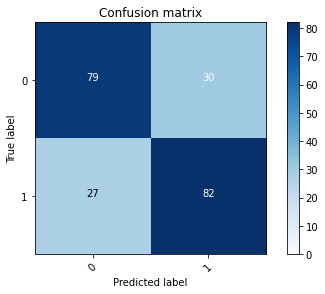

2022-08-02 19:16:19 - [Epoch Train: 23] loss: 0.0011, auc: 1.0000, acc: 1.0000, time: 59.00 s            
2022-08-02 19:16:19 - [Epoch Valid: 23] loss: 1.1168, auc: 0.8371, acc: 0.7385, time: 17.00 s


 15%|██████▏                                 | 23/150 [33:31<2:43:24, 77.20s/it]

2022-08-02 19:16:19 - EPOCH: 24
2022-08-02 19:16:22 - Train Step 10/192, train_loss: 0.0016
2022-08-02 19:16:25 - Train Step 20/192, train_loss: 0.0011
2022-08-02 19:16:28 - Train Step 30/192, train_loss: 0.0009
2022-08-02 19:16:31 - Train Step 40/192, train_loss: 0.0012
2022-08-02 19:16:35 - Train Step 50/192, train_loss: 0.0011
2022-08-02 19:16:38 - Train Step 60/192, train_loss: 0.0010
2022-08-02 19:16:41 - Train Step 70/192, train_loss: 0.0010
2022-08-02 19:16:44 - Train Step 80/192, train_loss: 0.0012
2022-08-02 19:16:47 - Train Step 90/192, train_loss: 0.0012
2022-08-02 19:16:50 - Train Step 100/192, train_loss: 0.0012
2022-08-02 19:16:53 - Train Step 110/192, train_loss: 0.0011
2022-08-02 19:16:56 - Train Step 120/192, train_loss: 0.0011
2022-08-02 19:16:59 - Train Step 130/192, train_loss: 0.0011
2022-08-02 19:17:02 - Train Step 140/192, train_loss: 0.0011
2022-08-02 19:17:06 - Train Step 150/192, train_loss: 0.0010
2022-08-02 19:17:09 - Train Step 160/192, train_loss: 0.0010
2

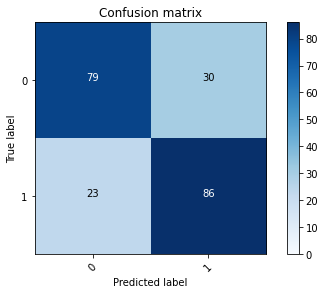

2022-08-02 19:17:35 - [Epoch Train: 24] loss: 0.0010, auc: 1.0000, acc: 1.0000, time: 59.00 s            
2022-08-02 19:17:35 - [Epoch Valid: 24] loss: 1.1048, auc: 0.8384, acc: 0.7569, time: 17.00 s
2022-08-02 19:17:35 - acc improved from 0.7477 to 0.7569. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug02_18-42-47/RSNAClassifierSingle3D-DW-SO-KLF-e24-loss1.105-acc0.757-auc0.838.pth'


 16%|██████▍                                 | 24/150 [34:48<2:41:47, 77.04s/it]

2022-08-02 19:17:35 - EPOCH: 25
2022-08-02 19:17:39 - Train Step 10/192, train_loss: 0.0003
2022-08-02 19:17:42 - Train Step 20/192, train_loss: 0.0006
2022-08-02 19:17:45 - Train Step 30/192, train_loss: 0.0007
2022-08-02 19:17:48 - Train Step 40/192, train_loss: 0.0009
2022-08-02 19:17:52 - Train Step 50/192, train_loss: 0.0008
2022-08-02 19:17:55 - Train Step 60/192, train_loss: 0.0007
2022-08-02 19:17:58 - Train Step 70/192, train_loss: 0.0007
2022-08-02 19:18:01 - Train Step 80/192, train_loss: 0.0009
2022-08-02 19:18:05 - Train Step 90/192, train_loss: 0.0010
2022-08-02 19:18:08 - Train Step 100/192, train_loss: 0.0010
2022-08-02 19:18:11 - Train Step 110/192, train_loss: 0.0010
2022-08-02 19:18:14 - Train Step 120/192, train_loss: 0.0010
2022-08-02 19:18:17 - Train Step 130/192, train_loss: 0.0010
2022-08-02 19:18:20 - Train Step 140/192, train_loss: 0.0010
2022-08-02 19:18:23 - Train Step 150/192, train_loss: 0.0009
2022-08-02 19:18:27 - Train Step 160/192, train_loss: 0.0009
2

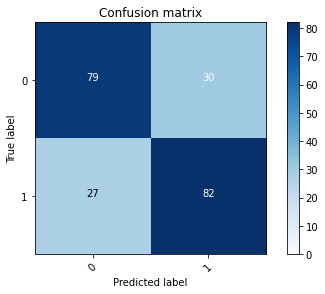

2022-08-02 19:18:54 - [Epoch Train: 25] loss: 0.0009, auc: 1.0000, acc: 1.0000, time: 61.00 s            
2022-08-02 19:18:54 - [Epoch Valid: 25] loss: 1.1258, auc: 0.8372, acc: 0.7385, time: 17.00 s


 17%|██████▋                                 | 25/150 [36:07<2:41:38, 77.59s/it]

2022-08-02 19:18:54 - EPOCH: 26
2022-08-02 19:18:58 - Train Step 10/192, train_loss: 0.0040
2022-08-02 19:19:01 - Train Step 20/192, train_loss: 0.0024
2022-08-02 19:19:04 - Train Step 30/192, train_loss: 0.0020
2022-08-02 19:19:07 - Train Step 40/192, train_loss: 0.0016
2022-08-02 19:19:10 - Train Step 50/192, train_loss: 0.0013
2022-08-02 19:19:13 - Train Step 60/192, train_loss: 0.0012
2022-08-02 19:19:16 - Train Step 70/192, train_loss: 0.0011
2022-08-02 19:19:19 - Train Step 80/192, train_loss: 0.0011
2022-08-02 19:19:22 - Train Step 90/192, train_loss: 0.0011
2022-08-02 19:19:25 - Train Step 100/192, train_loss: 0.0010
2022-08-02 19:19:29 - Train Step 110/192, train_loss: 0.0010
2022-08-02 19:19:32 - Train Step 120/192, train_loss: 0.0010
2022-08-02 19:19:35 - Train Step 130/192, train_loss: 0.0009
2022-08-02 19:19:38 - Train Step 140/192, train_loss: 0.0010
2022-08-02 19:19:41 - Train Step 150/192, train_loss: 0.0010
2022-08-02 19:19:44 - Train Step 160/192, train_loss: 0.0009
2

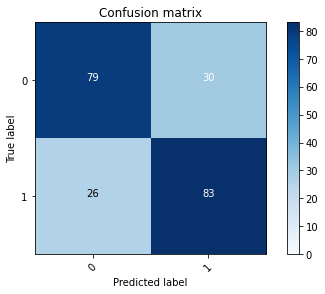

2022-08-02 19:20:11 - [Epoch Train: 26] loss: 0.0008, auc: 1.0000, acc: 1.0000, time: 59.00 s            
2022-08-02 19:20:11 - [Epoch Valid: 26] loss: 1.2724, auc: 0.8395, acc: 0.7431, time: 17.00 s


 17%|██████▉                                 | 26/150 [37:24<2:39:58, 77.41s/it]

2022-08-02 19:20:11 - EPOCH: 27
2022-08-02 19:20:15 - Train Step 10/192, train_loss: 0.0004
2022-08-02 19:20:18 - Train Step 20/192, train_loss: 0.0004
2022-08-02 19:20:21 - Train Step 30/192, train_loss: 0.0005
2022-08-02 19:20:24 - Train Step 40/192, train_loss: 0.0005
2022-08-02 19:20:27 - Train Step 50/192, train_loss: 0.0005
2022-08-02 19:20:30 - Train Step 60/192, train_loss: 0.0005
2022-08-02 19:20:33 - Train Step 70/192, train_loss: 0.0005
2022-08-02 19:20:36 - Train Step 80/192, train_loss: 0.0005
2022-08-02 19:20:39 - Train Step 90/192, train_loss: 0.0005
2022-08-02 19:20:42 - Train Step 100/192, train_loss: 0.0005
2022-08-02 19:20:45 - Train Step 110/192, train_loss: 0.0005
2022-08-02 19:20:48 - Train Step 120/192, train_loss: 0.0004
2022-08-02 19:20:51 - Train Step 130/192, train_loss: 0.0005
2022-08-02 19:20:54 - Train Step 140/192, train_loss: 0.0005
2022-08-02 19:20:57 - Train Step 150/192, train_loss: 0.0005
2022-08-02 19:21:01 - Train Step 160/192, train_loss: 0.0005
2

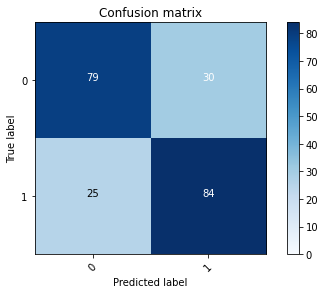

2022-08-02 19:21:27 - [Epoch Train: 27] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 58.00 s            
2022-08-02 19:21:27 - [Epoch Valid: 27] loss: 1.1737, auc: 0.8396, acc: 0.7477, time: 17.00 s


 18%|███████▏                                | 27/150 [38:40<2:37:56, 77.04s/it]

2022-08-02 19:21:27 - EPOCH: 28
2022-08-02 19:21:31 - Train Step 10/192, train_loss: 0.0004
2022-08-02 19:21:34 - Train Step 20/192, train_loss: 0.0003
2022-08-02 19:21:37 - Train Step 30/192, train_loss: 0.0004
2022-08-02 19:21:40 - Train Step 40/192, train_loss: 0.0004
2022-08-02 19:21:43 - Train Step 50/192, train_loss: 0.0005
2022-08-02 19:21:46 - Train Step 60/192, train_loss: 0.0007
2022-08-02 19:21:50 - Train Step 70/192, train_loss: 0.0007
2022-08-02 19:21:53 - Train Step 80/192, train_loss: 0.0007
2022-08-02 19:21:56 - Train Step 90/192, train_loss: 0.0006
2022-08-02 19:21:59 - Train Step 100/192, train_loss: 0.0006
2022-08-02 19:22:02 - Train Step 110/192, train_loss: 0.0006
2022-08-02 19:22:05 - Train Step 120/192, train_loss: 0.0006
2022-08-02 19:22:08 - Train Step 130/192, train_loss: 0.0006
2022-08-02 19:22:12 - Train Step 140/192, train_loss: 0.0006
2022-08-02 19:22:15 - Train Step 150/192, train_loss: 0.0006
2022-08-02 19:22:18 - Train Step 160/192, train_loss: 0.0005
2

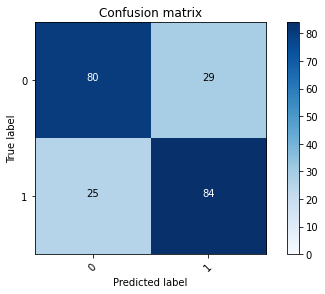

2022-08-02 19:22:44 - [Epoch Train: 28] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 60.00 s            
2022-08-02 19:22:44 - [Epoch Valid: 28] loss: 1.1754, auc: 0.8402, acc: 0.7523, time: 16.00 s


 19%|███████▍                                | 28/150 [39:57<2:36:35, 77.01s/it]

2022-08-02 19:22:44 - EPOCH: 29
2022-08-02 19:22:48 - Train Step 10/192, train_loss: 0.0021
2022-08-02 19:22:50 - Train Step 20/192, train_loss: 0.0012
2022-08-02 19:22:53 - Train Step 30/192, train_loss: 0.0010
2022-08-02 19:22:56 - Train Step 40/192, train_loss: 0.0010
2022-08-02 19:22:59 - Train Step 50/192, train_loss: 0.0008
2022-08-02 19:23:02 - Train Step 60/192, train_loss: 0.0008
2022-08-02 19:23:05 - Train Step 70/192, train_loss: 0.0007
2022-08-02 19:23:08 - Train Step 80/192, train_loss: 0.0006
2022-08-02 19:23:10 - Train Step 90/192, train_loss: 0.0006
2022-08-02 19:23:13 - Train Step 100/192, train_loss: 0.0006
2022-08-02 19:23:16 - Train Step 110/192, train_loss: 0.0006
2022-08-02 19:23:19 - Train Step 120/192, train_loss: 0.0006
2022-08-02 19:23:22 - Train Step 130/192, train_loss: 0.0006
2022-08-02 19:23:25 - Train Step 140/192, train_loss: 0.0006
2022-08-02 19:23:27 - Train Step 150/192, train_loss: 0.0006
2022-08-02 19:23:30 - Train Step 160/192, train_loss: 0.0005
2

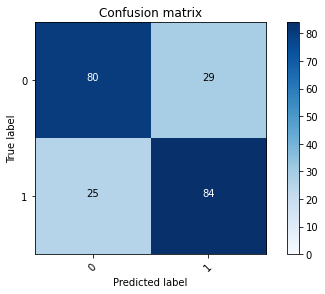

2022-08-02 19:23:55 - [Epoch Train: 29] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 19:23:55 - [Epoch Valid: 29] loss: 1.1894, auc: 0.8397, acc: 0.7523, time: 16.00 s


 19%|███████▋                                | 29/150 [41:08<2:31:38, 75.20s/it]

2022-08-02 19:23:55 - EPOCH: 30
2022-08-02 19:23:58 - Train Step 10/192, train_loss: 0.0007
2022-08-02 19:24:02 - Train Step 20/192, train_loss: 0.0005
2022-08-02 19:24:05 - Train Step 30/192, train_loss: 0.0005
2022-08-02 19:24:07 - Train Step 40/192, train_loss: 0.0004
2022-08-02 19:24:10 - Train Step 50/192, train_loss: 0.0004
2022-08-02 19:24:13 - Train Step 60/192, train_loss: 0.0004
2022-08-02 19:24:16 - Train Step 70/192, train_loss: 0.0003
2022-08-02 19:24:19 - Train Step 80/192, train_loss: 0.0003
2022-08-02 19:24:22 - Train Step 90/192, train_loss: 0.0004
2022-08-02 19:24:24 - Train Step 100/192, train_loss: 0.0004
2022-08-02 19:24:27 - Train Step 110/192, train_loss: 0.0004
2022-08-02 19:24:30 - Train Step 120/192, train_loss: 0.0004
2022-08-02 19:24:33 - Train Step 130/192, train_loss: 0.0004
2022-08-02 19:24:36 - Train Step 140/192, train_loss: 0.0004
2022-08-02 19:24:39 - Train Step 150/192, train_loss: 0.0004
2022-08-02 19:24:42 - Train Step 160/192, train_loss: 0.0004
2

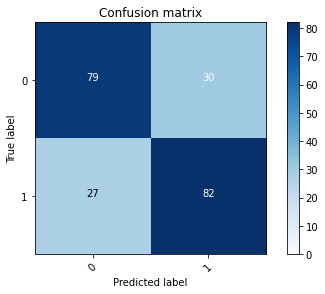

2022-08-02 19:25:07 - [Epoch Train: 30] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 19:25:07 - [Epoch Valid: 30] loss: 1.3140, auc: 0.8394, acc: 0.7385, time: 16.00 s


 20%|████████                                | 30/150 [42:19<2:28:19, 74.17s/it]

2022-08-02 19:25:07 - EPOCH: 31
2022-08-02 19:25:10 - Train Step 10/192, train_loss: 0.0005
2022-08-02 19:25:13 - Train Step 20/192, train_loss: 0.0004
2022-08-02 19:25:16 - Train Step 30/192, train_loss: 0.0004
2022-08-02 19:25:19 - Train Step 40/192, train_loss: 0.0005
2022-08-02 19:25:22 - Train Step 50/192, train_loss: 0.0005
2022-08-02 19:25:25 - Train Step 60/192, train_loss: 0.0005
2022-08-02 19:25:28 - Train Step 70/192, train_loss: 0.0005
2022-08-02 19:25:30 - Train Step 80/192, train_loss: 0.0005
2022-08-02 19:25:33 - Train Step 90/192, train_loss: 0.0004
2022-08-02 19:25:36 - Train Step 100/192, train_loss: 0.0004
2022-08-02 19:25:39 - Train Step 110/192, train_loss: 0.0004
2022-08-02 19:25:42 - Train Step 120/192, train_loss: 0.0004
2022-08-02 19:25:44 - Train Step 130/192, train_loss: 0.0004
2022-08-02 19:25:47 - Train Step 140/192, train_loss: 0.0004
2022-08-02 19:25:50 - Train Step 150/192, train_loss: 0.0004
2022-08-02 19:25:53 - Train Step 160/192, train_loss: 0.0004
2

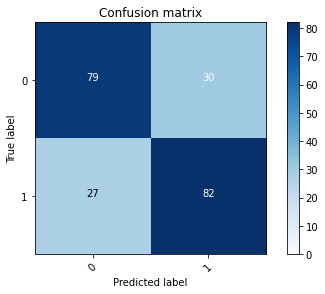

2022-08-02 19:26:18 - [Epoch Train: 31] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 19:26:18 - [Epoch Valid: 31] loss: 1.2612, auc: 0.8383, acc: 0.7385, time: 16.00 s


 21%|████████▎                               | 31/150 [43:30<2:24:58, 73.10s/it]

2022-08-02 19:26:18 - EPOCH: 32
2022-08-02 19:26:21 - Train Step 10/192, train_loss: 0.0002
2022-08-02 19:26:24 - Train Step 20/192, train_loss: 0.0002
2022-08-02 19:26:27 - Train Step 30/192, train_loss: 0.0003
2022-08-02 19:26:30 - Train Step 40/192, train_loss: 0.0002
2022-08-02 19:26:33 - Train Step 50/192, train_loss: 0.0002
2022-08-02 19:26:35 - Train Step 60/192, train_loss: 0.0002
2022-08-02 19:26:38 - Train Step 70/192, train_loss: 0.0003
2022-08-02 19:26:41 - Train Step 80/192, train_loss: 0.0002
2022-08-02 19:26:44 - Train Step 90/192, train_loss: 0.0002
2022-08-02 19:26:47 - Train Step 100/192, train_loss: 0.0003
2022-08-02 19:26:50 - Train Step 110/192, train_loss: 0.0003
2022-08-02 19:26:53 - Train Step 120/192, train_loss: 0.0003
2022-08-02 19:26:56 - Train Step 130/192, train_loss: 0.0003
2022-08-02 19:26:59 - Train Step 140/192, train_loss: 0.0003
2022-08-02 19:27:01 - Train Step 150/192, train_loss: 0.0003
2022-08-02 19:27:04 - Train Step 160/192, train_loss: 0.0003
2

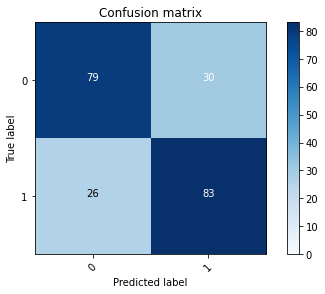

2022-08-02 19:27:29 - [Epoch Train: 32] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 19:27:29 - [Epoch Valid: 32] loss: 1.3291, auc: 0.8395, acc: 0.7431, time: 16.00 s


 21%|████████▌                               | 32/150 [44:42<2:22:56, 72.68s/it]

2022-08-02 19:27:29 - EPOCH: 33
2022-08-02 19:27:33 - Train Step 10/192, train_loss: 0.0002
2022-08-02 19:27:35 - Train Step 20/192, train_loss: 0.0002
2022-08-02 19:27:38 - Train Step 30/192, train_loss: 0.0002
2022-08-02 19:27:41 - Train Step 40/192, train_loss: 0.0002
2022-08-02 19:27:44 - Train Step 50/192, train_loss: 0.0002
2022-08-02 19:27:47 - Train Step 60/192, train_loss: 0.0002
2022-08-02 19:27:50 - Train Step 70/192, train_loss: 0.0002
2022-08-02 19:27:53 - Train Step 80/192, train_loss: 0.0002
2022-08-02 19:27:55 - Train Step 90/192, train_loss: 0.0002
2022-08-02 19:27:58 - Train Step 100/192, train_loss: 0.0002
2022-08-02 19:28:01 - Train Step 110/192, train_loss: 0.0002
2022-08-02 19:28:04 - Train Step 120/192, train_loss: 0.0003
2022-08-02 19:28:07 - Train Step 130/192, train_loss: 0.0003
2022-08-02 19:28:10 - Train Step 140/192, train_loss: 0.0003
2022-08-02 19:28:13 - Train Step 150/192, train_loss: 0.0003
2022-08-02 19:28:15 - Train Step 160/192, train_loss: 0.0003
2

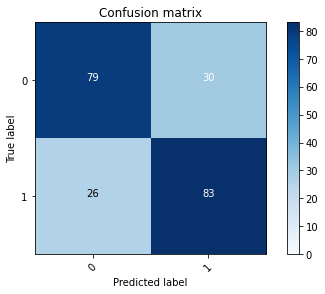

2022-08-02 19:28:41 - [Epoch Train: 33] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 19:28:41 - [Epoch Valid: 33] loss: 1.3465, auc: 0.8397, acc: 0.7431, time: 16.00 s


 22%|████████▊                               | 33/150 [45:53<2:21:01, 72.32s/it]

2022-08-02 19:28:41 - EPOCH: 34
2022-08-02 19:28:44 - Train Step 10/192, train_loss: 0.0002
2022-08-02 19:28:47 - Train Step 20/192, train_loss: 0.0002
2022-08-02 19:28:50 - Train Step 30/192, train_loss: 0.0003
2022-08-02 19:28:53 - Train Step 40/192, train_loss: 0.0002
2022-08-02 19:28:56 - Train Step 50/192, train_loss: 0.0003
2022-08-02 19:28:58 - Train Step 60/192, train_loss: 0.0002
2022-08-02 19:29:01 - Train Step 70/192, train_loss: 0.0002
2022-08-02 19:29:04 - Train Step 80/192, train_loss: 0.0002
2022-08-02 19:29:07 - Train Step 90/192, train_loss: 0.0003
2022-08-02 19:29:10 - Train Step 100/192, train_loss: 0.0003
2022-08-02 19:29:13 - Train Step 110/192, train_loss: 0.0003
2022-08-02 19:29:15 - Train Step 120/192, train_loss: 0.0003
2022-08-02 19:29:18 - Train Step 130/192, train_loss: 0.0002
2022-08-02 19:29:21 - Train Step 140/192, train_loss: 0.0002
2022-08-02 19:29:24 - Train Step 150/192, train_loss: 0.0002
2022-08-02 19:29:27 - Train Step 160/192, train_loss: 0.0002
2

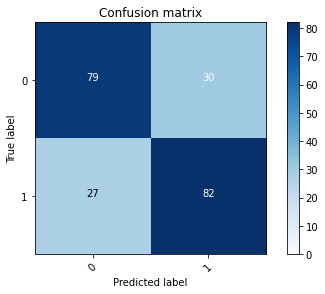

2022-08-02 19:29:52 - [Epoch Train: 34] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 19:29:52 - [Epoch Valid: 34] loss: 1.4034, auc: 0.8429, acc: 0.7385, time: 16.00 s


 23%|█████████                               | 34/150 [47:04<2:18:58, 71.89s/it]

2022-08-02 19:29:52 - EPOCH: 35
2022-08-02 19:29:55 - Train Step 10/192, train_loss: 0.0002
2022-08-02 19:29:58 - Train Step 20/192, train_loss: 0.0002
2022-08-02 19:30:01 - Train Step 30/192, train_loss: 0.0002
2022-08-02 19:30:03 - Train Step 40/192, train_loss: 0.0002
2022-08-02 19:30:06 - Train Step 50/192, train_loss: 0.0002
2022-08-02 19:30:09 - Train Step 60/192, train_loss: 0.0002
2022-08-02 19:30:12 - Train Step 70/192, train_loss: 0.0002
2022-08-02 19:30:15 - Train Step 80/192, train_loss: 0.0002
2022-08-02 19:30:18 - Train Step 90/192, train_loss: 0.0002
2022-08-02 19:30:21 - Train Step 100/192, train_loss: 0.0002
2022-08-02 19:30:24 - Train Step 110/192, train_loss: 0.0002
2022-08-02 19:30:26 - Train Step 120/192, train_loss: 0.0002
2022-08-02 19:30:29 - Train Step 130/192, train_loss: 0.0002
2022-08-02 19:30:32 - Train Step 140/192, train_loss: 0.0002
2022-08-02 19:30:35 - Train Step 150/192, train_loss: 0.0002
2022-08-02 19:30:38 - Train Step 160/192, train_loss: 0.0002
2

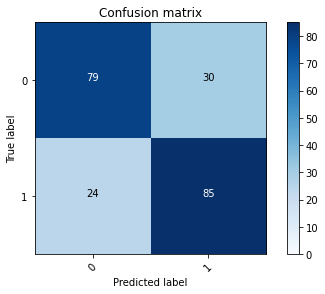

2022-08-02 19:31:03 - [Epoch Train: 35] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 19:31:03 - [Epoch Valid: 35] loss: 1.3910, auc: 0.8393, acc: 0.7523, time: 16.00 s


 23%|█████████▎                              | 35/150 [48:15<2:17:13, 71.59s/it]

2022-08-02 19:31:03 - EPOCH: 36
2022-08-02 19:31:06 - Train Step 10/192, train_loss: 0.0004
2022-08-02 19:31:09 - Train Step 20/192, train_loss: 0.0003
2022-08-02 19:31:11 - Train Step 30/192, train_loss: 0.0003
2022-08-02 19:31:14 - Train Step 40/192, train_loss: 0.0003
2022-08-02 19:31:17 - Train Step 50/192, train_loss: 0.0002
2022-08-02 19:31:20 - Train Step 60/192, train_loss: 0.0002
2022-08-02 19:31:23 - Train Step 70/192, train_loss: 0.0003
2022-08-02 19:31:26 - Train Step 80/192, train_loss: 0.0002
2022-08-02 19:31:29 - Train Step 90/192, train_loss: 0.0002
2022-08-02 19:31:32 - Train Step 100/192, train_loss: 0.0002
2022-08-02 19:31:35 - Train Step 110/192, train_loss: 0.0002
2022-08-02 19:31:37 - Train Step 120/192, train_loss: 0.0003
2022-08-02 19:31:40 - Train Step 130/192, train_loss: 0.0003
2022-08-02 19:31:43 - Train Step 140/192, train_loss: 0.0003
2022-08-02 19:31:46 - Train Step 150/192, train_loss: 0.0003
2022-08-02 19:31:49 - Train Step 160/192, train_loss: 0.0003
2

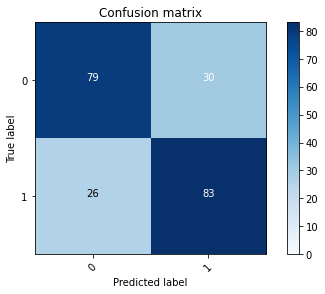

2022-08-02 19:32:14 - [Epoch Train: 36] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 19:32:14 - [Epoch Valid: 36] loss: 1.4845, auc: 0.8440, acc: 0.7431, time: 16.00 s


 24%|█████████▌                              | 36/150 [49:26<2:15:52, 71.51s/it]

2022-08-02 19:32:14 - EPOCH: 37
2022-08-02 19:32:17 - Train Step 10/192, train_loss: 0.0001
2022-08-02 19:32:20 - Train Step 20/192, train_loss: 0.0003
2022-08-02 19:32:23 - Train Step 30/192, train_loss: 0.0002
2022-08-02 19:32:26 - Train Step 40/192, train_loss: 0.0002
2022-08-02 19:32:29 - Train Step 50/192, train_loss: 0.0002
2022-08-02 19:32:32 - Train Step 60/192, train_loss: 0.0002
2022-08-02 19:32:35 - Train Step 70/192, train_loss: 0.0002
2022-08-02 19:32:37 - Train Step 80/192, train_loss: 0.0002
2022-08-02 19:32:40 - Train Step 90/192, train_loss: 0.0002
2022-08-02 19:32:43 - Train Step 100/192, train_loss: 0.0002
2022-08-02 19:32:46 - Train Step 110/192, train_loss: 0.0002
2022-08-02 19:32:49 - Train Step 120/192, train_loss: 0.0002
2022-08-02 19:32:52 - Train Step 130/192, train_loss: 0.0002
2022-08-02 19:32:54 - Train Step 140/192, train_loss: 0.0002
2022-08-02 19:32:57 - Train Step 150/192, train_loss: 0.0002
2022-08-02 19:33:00 - Train Step 160/192, train_loss: 0.0002
2

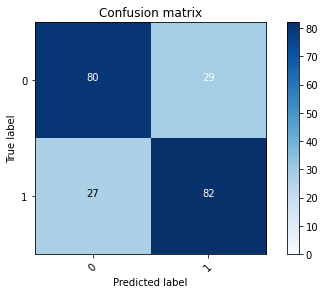

2022-08-02 19:33:26 - [Epoch Train: 37] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 19:33:26 - [Epoch Valid: 37] loss: 1.4060, auc: 0.8424, acc: 0.7431, time: 16.00 s


 25%|█████████▊                              | 37/150 [50:38<2:14:44, 71.54s/it]

2022-08-02 19:33:26 - EPOCH: 38
2022-08-02 19:33:29 - Train Step 10/192, train_loss: 0.0001
2022-08-02 19:33:32 - Train Step 20/192, train_loss: 0.0001
2022-08-02 19:33:35 - Train Step 30/192, train_loss: 0.0001
2022-08-02 19:33:38 - Train Step 40/192, train_loss: 0.0001
2022-08-02 19:33:41 - Train Step 50/192, train_loss: 0.0001
2022-08-02 19:33:44 - Train Step 60/192, train_loss: 0.0001
2022-08-02 19:33:47 - Train Step 70/192, train_loss: 0.0001
2022-08-02 19:33:49 - Train Step 80/192, train_loss: 0.0003
2022-08-02 19:33:52 - Train Step 90/192, train_loss: 0.0002
2022-08-02 19:33:55 - Train Step 100/192, train_loss: 0.0003
2022-08-02 19:33:58 - Train Step 110/192, train_loss: 0.0003
2022-08-02 19:34:01 - Train Step 120/192, train_loss: 0.0008
2022-08-02 19:34:04 - Train Step 130/192, train_loss: 0.0008
2022-08-02 19:34:07 - Train Step 140/192, train_loss: 0.0007
2022-08-02 19:34:10 - Train Step 150/192, train_loss: 0.0008
2022-08-02 19:34:13 - Train Step 160/192, train_loss: 0.0007
2

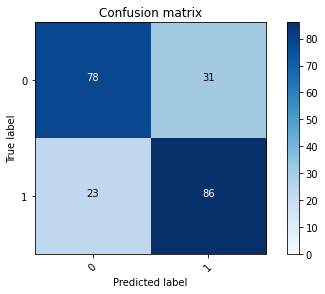

2022-08-02 19:34:38 - [Epoch Train: 38] loss: 0.0006, auc: 1.0000, acc: 1.0000, time: 56.00 s            
2022-08-02 19:34:38 - [Epoch Valid: 38] loss: 1.3973, auc: 0.8320, acc: 0.7523, time: 16.00 s


 25%|██████████▏                             | 38/150 [51:50<2:14:03, 71.82s/it]

2022-08-02 19:34:38 - EPOCH: 39
2022-08-02 19:34:41 - Train Step 10/192, train_loss: 0.0001
2022-08-02 19:34:44 - Train Step 20/192, train_loss: 0.0002
2022-08-02 19:34:47 - Train Step 30/192, train_loss: 0.0002
2022-08-02 19:34:50 - Train Step 40/192, train_loss: 0.0002
2022-08-02 19:34:53 - Train Step 50/192, train_loss: 0.0002
2022-08-02 19:34:56 - Train Step 60/192, train_loss: 0.0002
2022-08-02 19:34:59 - Train Step 70/192, train_loss: 0.0002
2022-08-02 19:35:02 - Train Step 80/192, train_loss: 0.0002
2022-08-02 19:35:05 - Train Step 90/192, train_loss: 0.0002
2022-08-02 19:35:08 - Train Step 100/192, train_loss: 0.0002
2022-08-02 19:35:11 - Train Step 110/192, train_loss: 0.0002
2022-08-02 19:35:14 - Train Step 120/192, train_loss: 0.0002
2022-08-02 19:35:16 - Train Step 130/192, train_loss: 0.0002
2022-08-02 19:35:19 - Train Step 140/192, train_loss: 0.0002
2022-08-02 19:35:22 - Train Step 150/192, train_loss: 0.0002
2022-08-02 19:35:25 - Train Step 160/192, train_loss: 0.0002
2

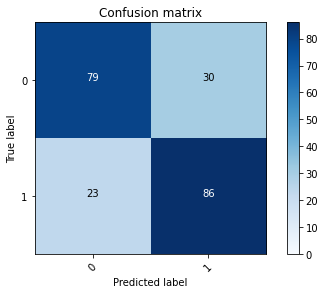

2022-08-02 19:35:50 - [Epoch Train: 39] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 19:35:50 - [Epoch Valid: 39] loss: 1.4755, auc: 0.8360, acc: 0.7569, time: 16.00 s
2022-08-02 19:35:50 - acc improved from 0.7569 to 0.7569. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug02_18-42-47/RSNAClassifierSingle3D-DW-SO-KLF-e39-loss1.475-acc0.757-auc0.836.pth'


 26%|██████████▍                             | 39/150 [53:02<2:12:55, 71.85s/it]

2022-08-02 19:35:50 - EPOCH: 40
2022-08-02 19:35:53 - Train Step 10/192, train_loss: 0.0006
2022-08-02 19:35:56 - Train Step 20/192, train_loss: 0.0003
2022-08-02 19:35:59 - Train Step 30/192, train_loss: 0.0003
2022-08-02 19:36:02 - Train Step 40/192, train_loss: 0.0003
2022-08-02 19:36:05 - Train Step 50/192, train_loss: 0.0003
2022-08-02 19:36:08 - Train Step 60/192, train_loss: 0.0002
2022-08-02 19:36:10 - Train Step 70/192, train_loss: 0.0002
2022-08-02 19:36:13 - Train Step 80/192, train_loss: 0.0002
2022-08-02 19:36:16 - Train Step 90/192, train_loss: 0.0002
2022-08-02 19:36:19 - Train Step 100/192, train_loss: 0.0002
2022-08-02 19:36:22 - Train Step 110/192, train_loss: 0.0002
2022-08-02 19:36:25 - Train Step 120/192, train_loss: 0.0002
2022-08-02 19:36:28 - Train Step 130/192, train_loss: 0.0002
2022-08-02 19:36:30 - Train Step 140/192, train_loss: 0.0002
2022-08-02 19:36:33 - Train Step 150/192, train_loss: 0.0002
2022-08-02 19:36:36 - Train Step 160/192, train_loss: 0.0002
2

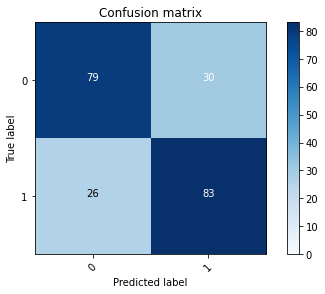

2022-08-02 19:37:01 - [Epoch Train: 40] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 19:37:01 - [Epoch Valid: 40] loss: 1.4494, auc: 0.8421, acc: 0.7431, time: 15.00 s


 27%|██████████▋                             | 40/150 [54:13<2:11:06, 71.51s/it]

2022-08-02 19:37:01 - EPOCH: 41
2022-08-02 19:37:04 - Train Step 10/192, train_loss: 0.0001
2022-08-02 19:37:07 - Train Step 20/192, train_loss: 0.0001
2022-08-02 19:37:10 - Train Step 30/192, train_loss: 0.0001
2022-08-02 19:37:13 - Train Step 40/192, train_loss: 0.0001
2022-08-02 19:37:15 - Train Step 50/192, train_loss: 0.0001
2022-08-02 19:37:18 - Train Step 60/192, train_loss: 0.0001
2022-08-02 19:37:21 - Train Step 70/192, train_loss: 0.0001
2022-08-02 19:37:24 - Train Step 80/192, train_loss: 0.0001
2022-08-02 19:37:27 - Train Step 90/192, train_loss: 0.0001
2022-08-02 19:37:30 - Train Step 100/192, train_loss: 0.0001
2022-08-02 19:37:32 - Train Step 110/192, train_loss: 0.0001
2022-08-02 19:37:35 - Train Step 120/192, train_loss: 0.0001
2022-08-02 19:37:38 - Train Step 130/192, train_loss: 0.0001
2022-08-02 19:37:41 - Train Step 140/192, train_loss: 0.0001
2022-08-02 19:37:44 - Train Step 150/192, train_loss: 0.0001
2022-08-02 19:37:47 - Train Step 160/192, train_loss: 0.0001
2

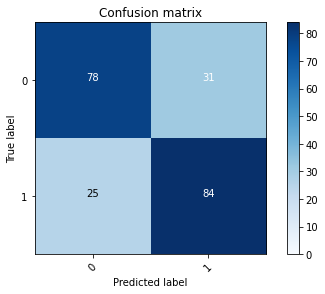

2022-08-02 19:38:11 - [Epoch Train: 41] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 19:38:11 - [Epoch Valid: 41] loss: 1.4362, auc: 0.8408, acc: 0.7431, time: 16.00 s


 27%|██████████▉                             | 41/150 [55:24<2:09:29, 71.28s/it]

2022-08-02 19:38:11 - EPOCH: 42
2022-08-02 19:38:15 - Train Step 10/192, train_loss: 0.0000
2022-08-02 19:38:17 - Train Step 20/192, train_loss: 0.0001
2022-08-02 19:38:20 - Train Step 30/192, train_loss: 0.0001
2022-08-02 19:38:23 - Train Step 40/192, train_loss: 0.0001
2022-08-02 19:38:26 - Train Step 50/192, train_loss: 0.0001
2022-08-02 19:38:29 - Train Step 60/192, train_loss: 0.0001
2022-08-02 19:38:32 - Train Step 70/192, train_loss: 0.0001
2022-08-02 19:38:34 - Train Step 80/192, train_loss: 0.0001
2022-08-02 19:38:37 - Train Step 90/192, train_loss: 0.0001
2022-08-02 19:38:40 - Train Step 100/192, train_loss: 0.0001
2022-08-02 19:38:43 - Train Step 110/192, train_loss: 0.0001
2022-08-02 19:38:46 - Train Step 120/192, train_loss: 0.0001
2022-08-02 19:38:49 - Train Step 130/192, train_loss: 0.0001
2022-08-02 19:38:51 - Train Step 140/192, train_loss: 0.0001
2022-08-02 19:38:54 - Train Step 150/192, train_loss: 0.0001
2022-08-02 19:38:57 - Train Step 160/192, train_loss: 0.0001
2

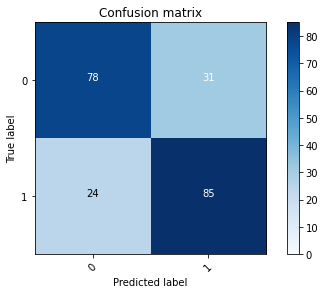

2022-08-02 19:39:22 - [Epoch Train: 42] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 19:39:22 - [Epoch Valid: 42] loss: 1.4697, auc: 0.8415, acc: 0.7477, time: 16.00 s


 28%|███████████▏                            | 42/150 [56:35<2:07:57, 71.09s/it]

2022-08-02 19:39:22 - EPOCH: 43
2022-08-02 19:39:26 - Train Step 10/192, train_loss: 0.0002
2022-08-02 19:39:28 - Train Step 20/192, train_loss: 0.0001
2022-08-02 19:39:31 - Train Step 30/192, train_loss: 0.0001
2022-08-02 19:39:34 - Train Step 40/192, train_loss: 0.0001
2022-08-02 19:39:37 - Train Step 50/192, train_loss: 0.0001
2022-08-02 19:39:40 - Train Step 60/192, train_loss: 0.0001
2022-08-02 19:39:43 - Train Step 70/192, train_loss: 0.0001
2022-08-02 19:39:46 - Train Step 80/192, train_loss: 0.0001
2022-08-02 19:39:49 - Train Step 90/192, train_loss: 0.0001
2022-08-02 19:39:52 - Train Step 100/192, train_loss: 0.0001
2022-08-02 19:39:54 - Train Step 110/192, train_loss: 0.0001
2022-08-02 19:39:57 - Train Step 120/192, train_loss: 0.0001
2022-08-02 19:40:00 - Train Step 130/192, train_loss: 0.0001
2022-08-02 19:40:03 - Train Step 140/192, train_loss: 0.0001
2022-08-02 19:40:06 - Train Step 150/192, train_loss: 0.0001
2022-08-02 19:40:09 - Train Step 160/192, train_loss: 0.0001
2

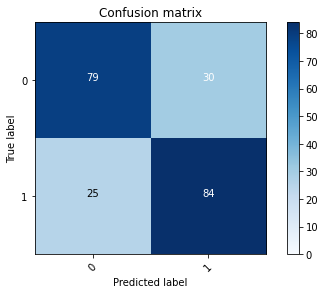

2022-08-02 19:40:34 - [Epoch Train: 43] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 19:40:34 - [Epoch Valid: 43] loss: 1.5317, auc: 0.8439, acc: 0.7477, time: 16.00 s


 29%|███████████▍                            | 43/150 [57:46<2:07:00, 71.22s/it]

2022-08-02 19:40:34 - EPOCH: 44
2022-08-02 19:40:37 - Train Step 10/192, train_loss: 0.0001
2022-08-02 19:40:40 - Train Step 20/192, train_loss: 0.0001
2022-08-02 19:40:43 - Train Step 30/192, train_loss: 0.0001
2022-08-02 19:40:45 - Train Step 40/192, train_loss: 0.0001
2022-08-02 19:40:48 - Train Step 50/192, train_loss: 0.0001
2022-08-02 19:40:51 - Train Step 60/192, train_loss: 0.0001
2022-08-02 19:40:54 - Train Step 70/192, train_loss: 0.0001
2022-08-02 19:40:57 - Train Step 80/192, train_loss: 0.0001
2022-08-02 19:41:00 - Train Step 90/192, train_loss: 0.0001
2022-08-02 19:41:03 - Train Step 100/192, train_loss: 0.0001
2022-08-02 19:41:06 - Train Step 110/192, train_loss: 0.0001
2022-08-02 19:41:08 - Train Step 120/192, train_loss: 0.0001
2022-08-02 19:41:11 - Train Step 130/192, train_loss: 0.0001
2022-08-02 19:41:14 - Train Step 140/192, train_loss: 0.0001
2022-08-02 19:41:17 - Train Step 150/192, train_loss: 0.0001
2022-08-02 19:41:20 - Train Step 160/192, train_loss: 0.0001
2

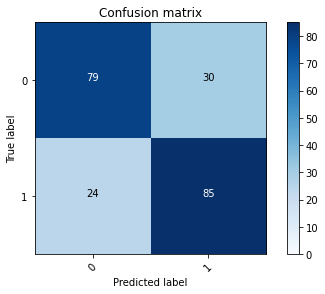

2022-08-02 19:41:44 - [Epoch Train: 44] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 19:41:44 - [Epoch Valid: 44] loss: 1.6365, auc: 0.8424, acc: 0.7523, time: 15.00 s


 29%|███████████▋                            | 44/150 [58:57<2:05:26, 71.00s/it]

2022-08-02 19:41:44 - EPOCH: 45
2022-08-02 19:41:47 - Train Step 10/192, train_loss: 0.0001
2022-08-02 19:41:50 - Train Step 20/192, train_loss: 0.0001
2022-08-02 19:41:53 - Train Step 30/192, train_loss: 0.0001
2022-08-02 19:41:56 - Train Step 40/192, train_loss: 0.0001
2022-08-02 19:41:59 - Train Step 50/192, train_loss: 0.0001
2022-08-02 19:42:02 - Train Step 60/192, train_loss: 0.0001
2022-08-02 19:42:05 - Train Step 70/192, train_loss: 0.0001
2022-08-02 19:42:07 - Train Step 80/192, train_loss: 0.0001
2022-08-02 19:42:10 - Train Step 90/192, train_loss: 0.0001
2022-08-02 19:42:13 - Train Step 100/192, train_loss: 0.0001
2022-08-02 19:42:16 - Train Step 110/192, train_loss: 0.0001
2022-08-02 19:42:19 - Train Step 120/192, train_loss: 0.0001
2022-08-02 19:42:22 - Train Step 130/192, train_loss: 0.0001
2022-08-02 19:42:24 - Train Step 140/192, train_loss: 0.0001
2022-08-02 19:42:27 - Train Step 150/192, train_loss: 0.0001
2022-08-02 19:42:30 - Train Step 160/192, train_loss: 0.0001
2

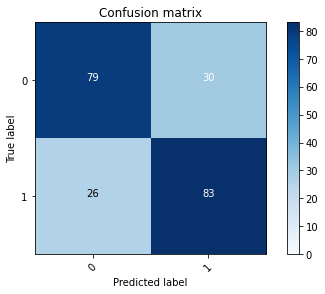

2022-08-02 19:42:56 - [Epoch Train: 45] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 19:42:56 - [Epoch Valid: 45] loss: 1.5123, auc: 0.8490, acc: 0.7431, time: 16.00 s


 30%|███████████▍                          | 45/150 [1:00:08<2:04:30, 71.15s/it]

2022-08-02 19:42:56 - EPOCH: 46
2022-08-02 19:42:59 - Train Step 10/192, train_loss: 0.0000
2022-08-02 19:43:02 - Train Step 20/192, train_loss: 0.0001
2022-08-02 19:43:05 - Train Step 30/192, train_loss: 0.0001
2022-08-02 19:43:07 - Train Step 40/192, train_loss: 0.0000
2022-08-02 19:43:10 - Train Step 50/192, train_loss: 0.0001
2022-08-02 19:43:13 - Train Step 60/192, train_loss: 0.0001
2022-08-02 19:43:16 - Train Step 70/192, train_loss: 0.0000
2022-08-02 19:43:19 - Train Step 80/192, train_loss: 0.0000
2022-08-02 19:43:22 - Train Step 90/192, train_loss: 0.0000
2022-08-02 19:43:25 - Train Step 100/192, train_loss: 0.0000
2022-08-02 19:43:27 - Train Step 110/192, train_loss: 0.0000
2022-08-02 19:43:30 - Train Step 120/192, train_loss: 0.0001
2022-08-02 19:43:33 - Train Step 130/192, train_loss: 0.0001
2022-08-02 19:43:36 - Train Step 140/192, train_loss: 0.0001
2022-08-02 19:43:39 - Train Step 150/192, train_loss: 0.0001
2022-08-02 19:43:42 - Train Step 160/192, train_loss: 0.0001
2

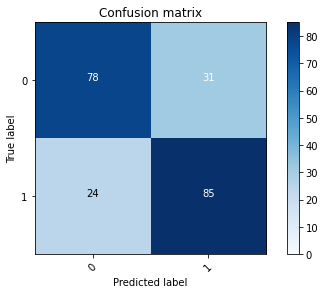

2022-08-02 19:44:06 - [Epoch Train: 46] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 19:44:06 - [Epoch Valid: 46] loss: 1.5393, auc: 0.8412, acc: 0.7477, time: 15.00 s


 31%|███████████▋                          | 46/150 [1:01:19<2:03:09, 71.05s/it]

2022-08-02 19:44:06 - EPOCH: 47
2022-08-02 19:44:09 - Train Step 10/192, train_loss: 0.0001
2022-08-02 19:44:12 - Train Step 20/192, train_loss: 0.0001
2022-08-02 19:44:15 - Train Step 30/192, train_loss: 0.0001
2022-08-02 19:44:18 - Train Step 40/192, train_loss: 0.0001
2022-08-02 19:44:21 - Train Step 50/192, train_loss: 0.0001
2022-08-02 19:44:24 - Train Step 60/192, train_loss: 0.0002
2022-08-02 19:44:27 - Train Step 70/192, train_loss: 0.0001
2022-08-02 19:44:30 - Train Step 80/192, train_loss: 0.0001
2022-08-02 19:44:33 - Train Step 90/192, train_loss: 0.0001
2022-08-02 19:44:36 - Train Step 100/192, train_loss: 0.0001
2022-08-02 19:44:39 - Train Step 110/192, train_loss: 0.0001
2022-08-02 19:44:41 - Train Step 120/192, train_loss: 0.0001
2022-08-02 19:44:44 - Train Step 130/192, train_loss: 0.0001
2022-08-02 19:44:47 - Train Step 140/192, train_loss: 0.0001
2022-08-02 19:44:50 - Train Step 150/192, train_loss: 0.0001
2022-08-02 19:44:53 - Train Step 160/192, train_loss: 0.0001
2

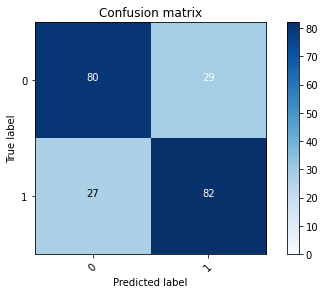

2022-08-02 19:45:18 - [Epoch Train: 47] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 19:45:18 - [Epoch Valid: 47] loss: 1.5740, auc: 0.8459, acc: 0.7431, time: 16.00 s


 31%|███████████▉                          | 47/150 [1:02:30<2:02:03, 71.10s/it]

2022-08-02 19:45:18 - EPOCH: 48
2022-08-02 19:45:21 - Train Step 10/192, train_loss: 0.0000
2022-08-02 19:45:24 - Train Step 20/192, train_loss: 0.0000
2022-08-02 19:45:27 - Train Step 30/192, train_loss: 0.0000
2022-08-02 19:45:29 - Train Step 40/192, train_loss: 0.0000
2022-08-02 19:45:32 - Train Step 50/192, train_loss: 0.0000
2022-08-02 19:45:35 - Train Step 60/192, train_loss: 0.0000
2022-08-02 19:45:38 - Train Step 70/192, train_loss: 0.0000
2022-08-02 19:45:41 - Train Step 80/192, train_loss: 0.0000
2022-08-02 19:45:44 - Train Step 90/192, train_loss: 0.0000
2022-08-02 19:45:47 - Train Step 100/192, train_loss: 0.0000
2022-08-02 19:45:49 - Train Step 110/192, train_loss: 0.0000
2022-08-02 19:45:52 - Train Step 120/192, train_loss: 0.0000
2022-08-02 19:45:55 - Train Step 130/192, train_loss: 0.0000
2022-08-02 19:45:58 - Train Step 140/192, train_loss: 0.0001
2022-08-02 19:46:01 - Train Step 150/192, train_loss: 0.0001
2022-08-02 19:46:04 - Train Step 160/192, train_loss: 0.0000
2

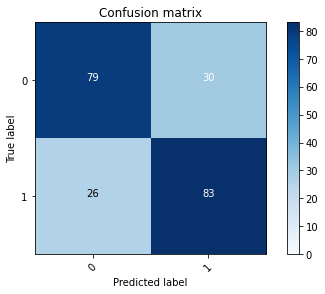

2022-08-02 19:46:29 - [Epoch Train: 48] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 19:46:29 - [Epoch Valid: 48] loss: 1.5786, auc: 0.8424, acc: 0.7431, time: 16.00 s


 32%|████████████▏                         | 48/150 [1:03:41<2:01:02, 71.20s/it]

2022-08-02 19:46:29 - EPOCH: 49
2022-08-02 19:46:32 - Train Step 10/192, train_loss: 0.0000
2022-08-02 19:46:35 - Train Step 20/192, train_loss: 0.0000
2022-08-02 19:46:38 - Train Step 30/192, train_loss: 0.0000
2022-08-02 19:46:40 - Train Step 40/192, train_loss: 0.0000
2022-08-02 19:46:43 - Train Step 50/192, train_loss: 0.0002
2022-08-02 19:46:46 - Train Step 60/192, train_loss: 0.0002
2022-08-02 19:46:49 - Train Step 70/192, train_loss: 0.0002
2022-08-02 19:46:52 - Train Step 80/192, train_loss: 0.0002
2022-08-02 19:46:55 - Train Step 90/192, train_loss: 0.0001
2022-08-02 19:46:58 - Train Step 100/192, train_loss: 0.0001
2022-08-02 19:47:01 - Train Step 110/192, train_loss: 0.0001
2022-08-02 19:47:03 - Train Step 120/192, train_loss: 0.0001
2022-08-02 19:47:06 - Train Step 130/192, train_loss: 0.0001
2022-08-02 19:47:09 - Train Step 140/192, train_loss: 0.0001
2022-08-02 19:47:12 - Train Step 150/192, train_loss: 0.0001
2022-08-02 19:47:14 - Train Step 160/192, train_loss: 0.0001
2

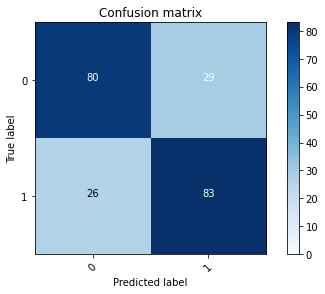

2022-08-02 19:47:39 - [Epoch Train: 49] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 53.00 s            
2022-08-02 19:47:39 - [Epoch Valid: 49] loss: 1.6772, auc: 0.8398, acc: 0.7477, time: 16.00 s


 33%|████████████▍                         | 49/150 [1:04:52<1:59:19, 70.88s/it]

2022-08-02 19:47:39 - EPOCH: 50
2022-08-02 19:47:42 - Train Step 10/192, train_loss: 0.0000
2022-08-02 19:47:45 - Train Step 20/192, train_loss: 0.0000
2022-08-02 19:47:48 - Train Step 30/192, train_loss: 0.0000
2022-08-02 19:47:51 - Train Step 40/192, train_loss: 0.0001
2022-08-02 19:47:54 - Train Step 50/192, train_loss: 0.0001
2022-08-02 19:47:56 - Train Step 60/192, train_loss: 0.0001
2022-08-02 19:47:59 - Train Step 70/192, train_loss: 0.0001
2022-08-02 19:48:02 - Train Step 80/192, train_loss: 0.0001
2022-08-02 19:48:05 - Train Step 90/192, train_loss: 0.0001
2022-08-02 19:48:08 - Train Step 100/192, train_loss: 0.0001
2022-08-02 19:48:11 - Train Step 110/192, train_loss: 0.0001
2022-08-02 19:48:14 - Train Step 120/192, train_loss: 0.0001
2022-08-02 19:48:16 - Train Step 130/192, train_loss: 0.0000
2022-08-02 19:48:19 - Train Step 140/192, train_loss: 0.0000
2022-08-02 19:48:22 - Train Step 150/192, train_loss: 0.0000
2022-08-02 19:48:25 - Train Step 160/192, train_loss: 0.0000
2

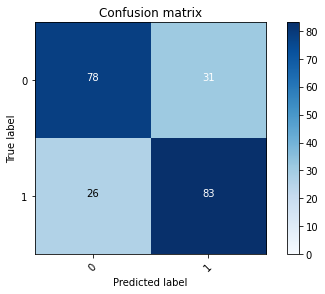

2022-08-02 19:48:51 - [Epoch Train: 50] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 19:48:51 - [Epoch Valid: 50] loss: 1.6713, auc: 0.8411, acc: 0.7385, time: 16.00 s


 33%|████████████▋                         | 50/150 [1:06:03<1:58:23, 71.03s/it]

2022-08-02 19:48:51 - EPOCH: 51
2022-08-02 19:48:54 - Train Step 10/192, train_loss: 0.0000
2022-08-02 19:48:57 - Train Step 20/192, train_loss: 0.0000
2022-08-02 19:48:59 - Train Step 30/192, train_loss: 0.0002
2022-08-02 19:49:02 - Train Step 40/192, train_loss: 0.0001
2022-08-02 19:49:05 - Train Step 50/192, train_loss: 0.0001
2022-08-02 19:49:08 - Train Step 60/192, train_loss: 0.0001
2022-08-02 19:49:11 - Train Step 70/192, train_loss: 0.0001
2022-08-02 19:49:14 - Train Step 80/192, train_loss: 0.0001
2022-08-02 19:49:17 - Train Step 90/192, train_loss: 0.0001
2022-08-02 19:49:20 - Train Step 100/192, train_loss: 0.0001
2022-08-02 19:49:23 - Train Step 110/192, train_loss: 0.0001
2022-08-02 19:49:26 - Train Step 120/192, train_loss: 0.0001
2022-08-02 19:49:29 - Train Step 130/192, train_loss: 0.0001
2022-08-02 19:49:32 - Train Step 140/192, train_loss: 0.0001
2022-08-02 19:49:34 - Train Step 150/192, train_loss: 0.0001
2022-08-02 19:49:37 - Train Step 160/192, train_loss: 0.0001
2

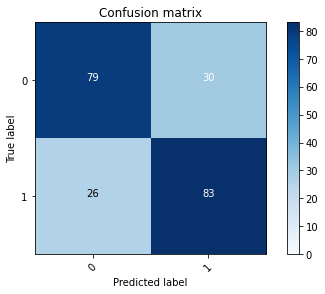

2022-08-02 19:50:02 - [Epoch Train: 51] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 19:50:02 - [Epoch Valid: 51] loss: 1.5804, auc: 0.8418, acc: 0.7431, time: 16.00 s


 34%|████████████▉                         | 51/150 [1:07:15<1:57:35, 71.27s/it]

2022-08-02 19:50:02 - EPOCH: 52
2022-08-02 19:50:05 - Train Step 10/192, train_loss: 0.0000
2022-08-02 19:50:08 - Train Step 20/192, train_loss: 0.0001
2022-08-02 19:50:11 - Train Step 30/192, train_loss: 0.0001
2022-08-02 19:50:14 - Train Step 40/192, train_loss: 0.0000
2022-08-02 19:50:17 - Train Step 50/192, train_loss: 0.0000
2022-08-02 19:50:20 - Train Step 60/192, train_loss: 0.0000
2022-08-02 19:50:23 - Train Step 70/192, train_loss: 0.0000
2022-08-02 19:50:26 - Train Step 80/192, train_loss: 0.0000
2022-08-02 19:50:29 - Train Step 90/192, train_loss: 0.0000
2022-08-02 19:50:31 - Train Step 100/192, train_loss: 0.0000
2022-08-02 19:50:34 - Train Step 110/192, train_loss: 0.0000
2022-08-02 19:50:37 - Train Step 120/192, train_loss: 0.0000
2022-08-02 19:50:40 - Train Step 130/192, train_loss: 0.0000
2022-08-02 19:50:43 - Train Step 140/192, train_loss: 0.0000
2022-08-02 19:50:46 - Train Step 150/192, train_loss: 0.0000
2022-08-02 19:50:48 - Train Step 160/192, train_loss: 0.0000
2

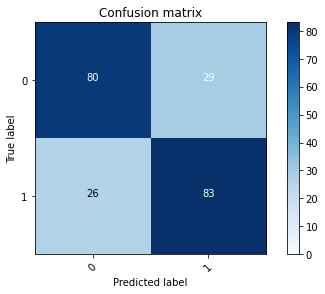

2022-08-02 19:51:14 - [Epoch Train: 52] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 19:51:14 - [Epoch Valid: 52] loss: 1.5546, auc: 0.8462, acc: 0.7477, time: 16.00 s


 35%|█████████████▏                        | 52/150 [1:08:26<1:56:19, 71.22s/it]

2022-08-02 19:51:14 - EPOCH: 53
2022-08-02 19:51:17 - Train Step 10/192, train_loss: 0.0000
2022-08-02 19:51:20 - Train Step 20/192, train_loss: 0.0000
2022-08-02 19:51:23 - Train Step 30/192, train_loss: 0.0001
2022-08-02 19:51:26 - Train Step 40/192, train_loss: 0.0000
2022-08-02 19:51:29 - Train Step 50/192, train_loss: 0.0000
2022-08-02 19:51:32 - Train Step 60/192, train_loss: 0.0000
2022-08-02 19:51:35 - Train Step 70/192, train_loss: 0.0000
2022-08-02 19:51:38 - Train Step 80/192, train_loss: 0.0000
2022-08-02 19:51:41 - Train Step 90/192, train_loss: 0.0000
2022-08-02 19:51:44 - Train Step 100/192, train_loss: 0.0000
2022-08-02 19:51:47 - Train Step 110/192, train_loss: 0.0000
2022-08-02 19:51:50 - Train Step 120/192, train_loss: 0.0000
2022-08-02 19:51:53 - Train Step 130/192, train_loss: 0.0000
2022-08-02 19:51:56 - Train Step 140/192, train_loss: 0.0000
2022-08-02 19:51:58 - Train Step 150/192, train_loss: 0.0000
2022-08-02 19:52:01 - Train Step 160/192, train_loss: 0.0000
2

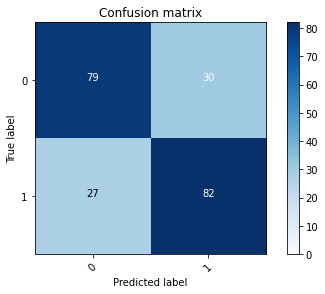

2022-08-02 19:52:26 - [Epoch Train: 53] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 57.00 s            
2022-08-02 19:52:26 - [Epoch Valid: 53] loss: 1.6458, auc: 0.8448, acc: 0.7385, time: 15.00 s


 35%|█████████████▍                        | 53/150 [1:09:39<1:55:58, 71.74s/it]

2022-08-02 19:52:26 - EPOCH: 54
2022-08-02 19:52:30 - Train Step 10/192, train_loss: 0.0001
2022-08-02 19:52:33 - Train Step 20/192, train_loss: 0.0000
2022-08-02 19:52:36 - Train Step 30/192, train_loss: 0.0000
2022-08-02 19:52:38 - Train Step 40/192, train_loss: 0.0000
2022-08-02 19:52:41 - Train Step 50/192, train_loss: 0.0000
2022-08-02 19:52:44 - Train Step 60/192, train_loss: 0.0000
2022-08-02 19:52:47 - Train Step 70/192, train_loss: 0.0000
2022-08-02 19:52:50 - Train Step 80/192, train_loss: 0.0000
2022-08-02 19:52:53 - Train Step 90/192, train_loss: 0.0000
2022-08-02 19:52:56 - Train Step 100/192, train_loss: 0.0000
2022-08-02 19:52:59 - Train Step 110/192, train_loss: 0.0000
2022-08-02 19:53:02 - Train Step 120/192, train_loss: 0.0000
2022-08-02 19:53:04 - Train Step 130/192, train_loss: 0.0000
2022-08-02 19:53:07 - Train Step 140/192, train_loss: 0.0000
2022-08-02 19:53:10 - Train Step 150/192, train_loss: 0.0000
2022-08-02 19:53:13 - Train Step 160/192, train_loss: 0.0000
2

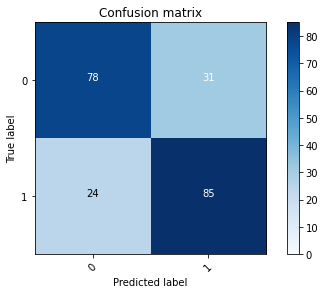

2022-08-02 19:53:38 - [Epoch Train: 54] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 19:53:38 - [Epoch Valid: 54] loss: 1.6809, auc: 0.8444, acc: 0.7477, time: 16.00 s


 36%|█████████████▋                        | 54/150 [1:10:51<1:54:51, 71.78s/it]

2022-08-02 19:53:38 - EPOCH: 55
2022-08-02 19:53:42 - Train Step 10/192, train_loss: 0.0000
2022-08-02 19:53:44 - Train Step 20/192, train_loss: 0.0000
2022-08-02 19:53:47 - Train Step 30/192, train_loss: 0.0000
2022-08-02 19:53:50 - Train Step 40/192, train_loss: 0.0000
2022-08-02 19:53:53 - Train Step 50/192, train_loss: 0.0000
2022-08-02 19:53:56 - Train Step 60/192, train_loss: 0.0000
2022-08-02 19:53:59 - Train Step 70/192, train_loss: 0.0000
2022-08-02 19:54:01 - Train Step 80/192, train_loss: 0.0000
2022-08-02 19:54:04 - Train Step 90/192, train_loss: 0.0000
2022-08-02 19:54:07 - Train Step 100/192, train_loss: 0.0000
2022-08-02 19:54:10 - Train Step 110/192, train_loss: 0.0000
2022-08-02 19:54:13 - Train Step 120/192, train_loss: 0.0000
2022-08-02 19:54:16 - Train Step 130/192, train_loss: 0.0000
2022-08-02 19:54:19 - Train Step 140/192, train_loss: 0.0000
2022-08-02 19:54:21 - Train Step 150/192, train_loss: 0.0000
2022-08-02 19:54:24 - Train Step 160/192, train_loss: 0.0000
2

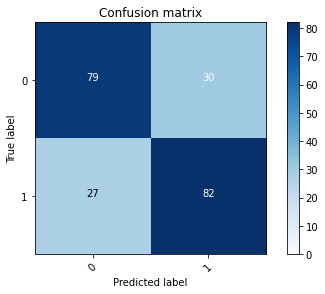

2022-08-02 19:54:49 - [Epoch Train: 55] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 19:54:49 - [Epoch Valid: 55] loss: 1.7003, auc: 0.8460, acc: 0.7385, time: 16.00 s


 37%|█████████████▉                        | 55/150 [1:12:02<1:53:17, 71.55s/it]

2022-08-02 19:54:49 - EPOCH: 56
2022-08-02 19:54:53 - Train Step 10/192, train_loss: 0.0000
2022-08-02 19:54:55 - Train Step 20/192, train_loss: 0.0000
2022-08-02 19:54:58 - Train Step 30/192, train_loss: 0.0000
2022-08-02 19:55:01 - Train Step 40/192, train_loss: 0.0000
2022-08-02 19:55:04 - Train Step 50/192, train_loss: 0.0000
2022-08-02 19:55:07 - Train Step 60/192, train_loss: 0.0000
2022-08-02 19:55:10 - Train Step 70/192, train_loss: 0.0000
2022-08-02 19:55:12 - Train Step 80/192, train_loss: 0.0000
2022-08-02 19:55:15 - Train Step 90/192, train_loss: 0.0000
2022-08-02 19:55:18 - Train Step 100/192, train_loss: 0.0000
2022-08-02 19:55:21 - Train Step 110/192, train_loss: 0.0000
2022-08-02 19:55:24 - Train Step 120/192, train_loss: 0.0000
2022-08-02 19:55:26 - Train Step 130/192, train_loss: 0.0000
2022-08-02 19:55:29 - Train Step 140/192, train_loss: 0.0000
2022-08-02 19:55:32 - Train Step 150/192, train_loss: 0.0000
2022-08-02 19:55:35 - Train Step 160/192, train_loss: 0.0000
2

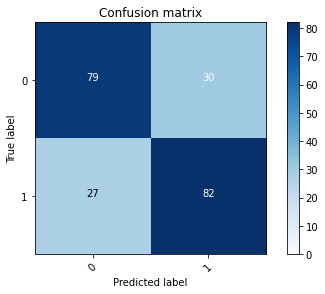

2022-08-02 19:56:00 - [Epoch Train: 56] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 19:56:00 - [Epoch Valid: 56] loss: 1.7020, auc: 0.8421, acc: 0.7385, time: 16.00 s


 37%|██████████████▏                       | 56/150 [1:13:13<1:51:46, 71.34s/it]

2022-08-02 19:56:00 - EPOCH: 57
2022-08-02 19:56:03 - Train Step 10/192, train_loss: 0.0000
2022-08-02 19:56:06 - Train Step 20/192, train_loss: 0.0000
2022-08-02 19:56:09 - Train Step 30/192, train_loss: 0.0000
2022-08-02 19:56:12 - Train Step 40/192, train_loss: 0.0000
2022-08-02 19:56:15 - Train Step 50/192, train_loss: 0.0000
2022-08-02 19:56:18 - Train Step 60/192, train_loss: 0.0000
2022-08-02 19:56:21 - Train Step 70/192, train_loss: 0.0000
2022-08-02 19:56:24 - Train Step 80/192, train_loss: 0.0000
2022-08-02 19:56:27 - Train Step 90/192, train_loss: 0.0000
2022-08-02 19:56:29 - Train Step 100/192, train_loss: 0.0000
2022-08-02 19:56:32 - Train Step 110/192, train_loss: 0.0000
2022-08-02 19:56:35 - Train Step 120/192, train_loss: 0.0000
2022-08-02 19:56:38 - Train Step 130/192, train_loss: 0.0000
2022-08-02 19:56:41 - Train Step 140/192, train_loss: 0.0000
2022-08-02 19:56:44 - Train Step 150/192, train_loss: 0.0000
2022-08-02 19:56:47 - Train Step 160/192, train_loss: 0.0000
2

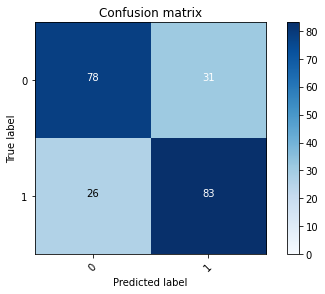

2022-08-02 19:57:12 - [Epoch Train: 57] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 19:57:12 - [Epoch Valid: 57] loss: 1.7027, auc: 0.8475, acc: 0.7385, time: 16.00 s


 38%|██████████████▍                       | 57/150 [1:14:25<1:50:52, 71.53s/it]

2022-08-02 19:57:12 - EPOCH: 58
2022-08-02 19:57:15 - Train Step 10/192, train_loss: 0.0000
2022-08-02 19:57:18 - Train Step 20/192, train_loss: 0.0000
2022-08-02 19:57:21 - Train Step 30/192, train_loss: 0.0000
2022-08-02 19:57:24 - Train Step 40/192, train_loss: 0.0000
2022-08-02 19:57:27 - Train Step 50/192, train_loss: 0.0000
2022-08-02 19:57:29 - Train Step 60/192, train_loss: 0.0000
2022-08-02 19:57:32 - Train Step 70/192, train_loss: 0.0000
2022-08-02 19:57:35 - Train Step 80/192, train_loss: 0.0000
2022-08-02 19:57:38 - Train Step 90/192, train_loss: 0.0000
2022-08-02 19:57:41 - Train Step 100/192, train_loss: 0.0000
2022-08-02 19:57:44 - Train Step 110/192, train_loss: 0.0000
2022-08-02 19:57:46 - Train Step 120/192, train_loss: 0.0000
2022-08-02 19:57:49 - Train Step 130/192, train_loss: 0.0000
2022-08-02 19:57:52 - Train Step 140/192, train_loss: 0.0000
2022-08-02 19:57:55 - Train Step 150/192, train_loss: 0.0000
2022-08-02 19:57:57 - Train Step 160/192, train_loss: 0.0000
2

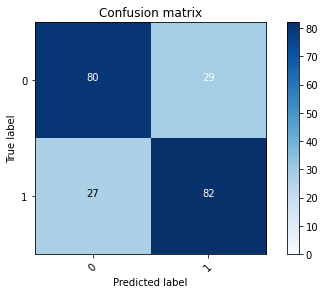

2022-08-02 19:58:22 - [Epoch Train: 58] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 53.00 s            
2022-08-02 19:58:22 - [Epoch Valid: 58] loss: 1.7505, auc: 0.8477, acc: 0.7431, time: 15.00 s


 39%|██████████████▋                       | 58/150 [1:15:34<1:48:54, 71.03s/it]

2022-08-02 19:58:22 - EPOCH: 59
2022-08-02 19:58:25 - Train Step 10/192, train_loss: 0.0000
2022-08-02 19:58:28 - Train Step 20/192, train_loss: 0.0000
2022-08-02 19:58:31 - Train Step 30/192, train_loss: 0.0000
2022-08-02 19:58:34 - Train Step 40/192, train_loss: 0.0000
2022-08-02 19:58:37 - Train Step 50/192, train_loss: 0.0000
2022-08-02 19:58:39 - Train Step 60/192, train_loss: 0.0000
2022-08-02 19:58:42 - Train Step 70/192, train_loss: 0.0000
2022-08-02 19:58:45 - Train Step 80/192, train_loss: 0.0000
2022-08-02 19:58:48 - Train Step 90/192, train_loss: 0.0000
2022-08-02 19:58:51 - Train Step 100/192, train_loss: 0.0000
2022-08-02 19:58:53 - Train Step 110/192, train_loss: 0.0000
2022-08-02 19:58:56 - Train Step 120/192, train_loss: 0.0000
2022-08-02 19:58:59 - Train Step 130/192, train_loss: 0.0000
2022-08-02 19:59:02 - Train Step 140/192, train_loss: 0.0000
2022-08-02 19:59:05 - Train Step 150/192, train_loss: 0.0000
2022-08-02 19:59:07 - Train Step 160/192, train_loss: 0.0000
2

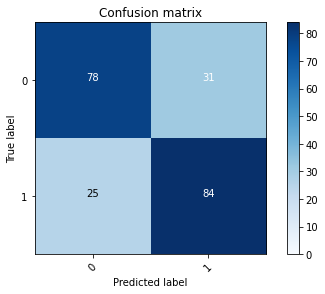

2022-08-02 19:59:33 - [Epoch Train: 59] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 19:59:33 - [Epoch Valid: 59] loss: 1.7344, auc: 0.8469, acc: 0.7431, time: 16.00 s


 39%|██████████████▉                       | 59/150 [1:16:45<1:47:40, 71.00s/it]

2022-08-02 19:59:33 - EPOCH: 60
2022-08-02 19:59:36 - Train Step 10/192, train_loss: 0.0000
2022-08-02 19:59:39 - Train Step 20/192, train_loss: 0.0000
2022-08-02 19:59:42 - Train Step 30/192, train_loss: 0.0000
2022-08-02 19:59:45 - Train Step 40/192, train_loss: 0.0000
2022-08-02 19:59:48 - Train Step 50/192, train_loss: 0.0000
2022-08-02 19:59:51 - Train Step 60/192, train_loss: 0.0000
2022-08-02 19:59:54 - Train Step 70/192, train_loss: 0.0000
2022-08-02 19:59:57 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:00:00 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:00:03 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:00:06 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:00:09 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:00:11 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:00:14 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:00:17 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:00:20 - Train Step 160/192, train_loss: 0.0000
2

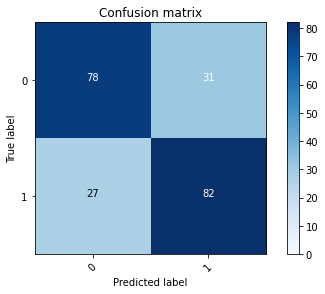

2022-08-02 20:00:45 - [Epoch Train: 60] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 56.00 s            
2022-08-02 20:00:45 - [Epoch Valid: 60] loss: 1.7409, auc: 0.8470, acc: 0.7339, time: 15.00 s


 40%|███████████████▏                      | 60/150 [1:17:58<1:47:04, 71.39s/it]

2022-08-02 20:00:45 - EPOCH: 61
2022-08-02 20:00:48 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:00:51 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:00:54 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:00:57 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:01:00 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:01:03 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:01:05 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:01:08 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:01:11 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:01:14 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:01:17 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:01:20 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:01:22 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:01:25 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:01:28 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:01:31 - Train Step 160/192, train_loss: 0.0000
2

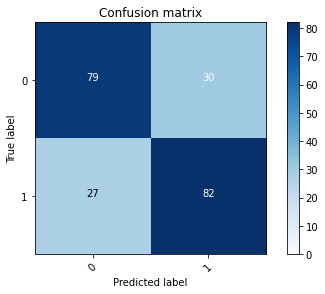

2022-08-02 20:01:55 - [Epoch Train: 61] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:01:55 - [Epoch Valid: 61] loss: 1.8131, auc: 0.8435, acc: 0.7385, time: 15.00 s


 41%|███████████████▍                      | 61/150 [1:19:08<1:45:19, 71.01s/it]

2022-08-02 20:01:55 - EPOCH: 62
2022-08-02 20:01:59 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:02:01 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:02:04 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:02:07 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:02:10 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:02:13 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:02:16 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:02:18 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:02:21 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:02:24 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:02:27 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:02:30 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:02:33 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:02:36 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:02:38 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:02:41 - Train Step 160/192, train_loss: 0.0000
2

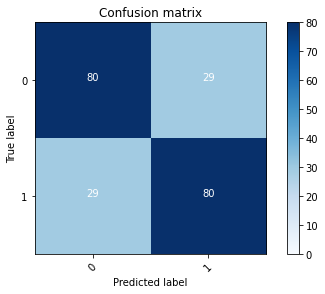

2022-08-02 20:03:06 - [Epoch Train: 62] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:03:06 - [Epoch Valid: 62] loss: 1.7703, auc: 0.8509, acc: 0.7339, time: 16.00 s


 41%|███████████████▋                      | 62/150 [1:20:19<1:44:04, 70.96s/it]

2022-08-02 20:03:06 - EPOCH: 63
2022-08-02 20:03:10 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:03:13 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:03:15 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:03:18 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:03:21 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:03:24 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:03:27 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:03:29 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:03:32 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:03:35 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:03:38 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:03:41 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:03:44 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:03:47 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:03:49 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:03:52 - Train Step 160/192, train_loss: 0.0000
2

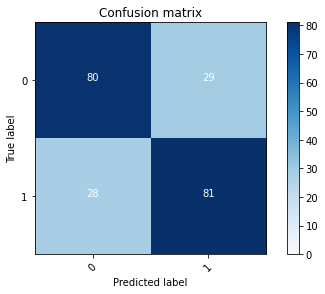

2022-08-02 20:04:18 - [Epoch Train: 63] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 20:04:18 - [Epoch Valid: 63] loss: 1.7516, auc: 0.8519, acc: 0.7385, time: 16.00 s


 42%|███████████████▉                      | 63/150 [1:21:30<1:43:11, 71.16s/it]

2022-08-02 20:04:18 - EPOCH: 64
2022-08-02 20:04:21 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:04:24 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:04:27 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:04:30 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:04:33 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:04:36 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:04:39 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:04:42 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:04:45 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:04:48 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:04:50 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:04:53 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:04:56 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:04:59 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:05:02 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:05:05 - Train Step 160/192, train_loss: 0.0000
2

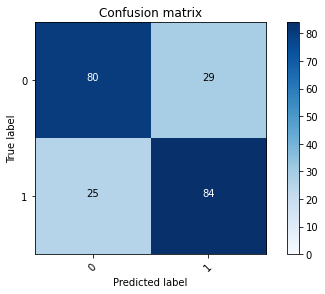

2022-08-02 20:05:30 - [Epoch Train: 64] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 20:05:30 - [Epoch Valid: 64] loss: 1.7380, auc: 0.8532, acc: 0.7523, time: 16.00 s


 43%|████████████████▏                     | 64/150 [1:22:43<1:42:35, 71.57s/it]

2022-08-02 20:05:30 - EPOCH: 65
2022-08-02 20:05:34 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:05:36 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:05:39 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:05:42 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:05:45 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:05:48 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:05:51 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:05:53 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:05:56 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:05:59 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:06:02 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:06:05 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:06:08 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:06:10 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:06:13 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:06:16 - Train Step 160/192, train_loss: 0.0000
2

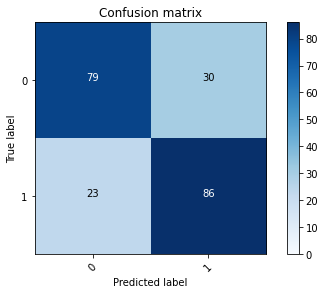

2022-08-02 20:06:41 - [Epoch Train: 65] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:06:41 - [Epoch Valid: 65] loss: 1.8797, auc: 0.8482, acc: 0.7569, time: 16.00 s
2022-08-02 20:06:41 - acc improved from 0.7569 to 0.7569. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug02_18-42-47/RSNAClassifierSingle3D-DW-SO-KLF-e65-loss1.880-acc0.757-auc0.848.pth'


 43%|████████████████▍                     | 65/150 [1:23:53<1:40:54, 71.23s/it]

2022-08-02 20:06:41 - EPOCH: 66
2022-08-02 20:06:44 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:06:47 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:06:50 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:06:52 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:06:55 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:06:58 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:07:01 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:07:04 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:07:06 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:07:09 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:07:12 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:07:15 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:07:18 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:07:20 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:07:23 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:07:26 - Train Step 160/192, train_loss: 0.0000
2

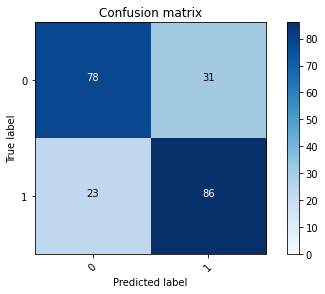

2022-08-02 20:07:51 - [Epoch Train: 66] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:07:51 - [Epoch Valid: 66] loss: 1.9431, auc: 0.8431, acc: 0.7523, time: 16.00 s


 44%|████████████████▋                     | 66/150 [1:25:03<1:39:16, 70.91s/it]

2022-08-02 20:07:51 - EPOCH: 67
2022-08-02 20:07:54 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:07:57 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:08:00 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:08:03 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:08:06 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:08:09 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:08:12 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:08:14 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:08:17 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:08:20 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:08:23 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:08:26 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:08:29 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:08:32 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:08:34 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:08:37 - Train Step 160/192, train_loss: 0.0000
2

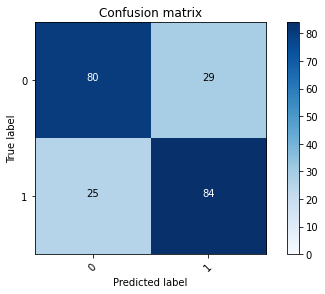

2022-08-02 20:09:03 - [Epoch Train: 67] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 20:09:03 - [Epoch Valid: 67] loss: 1.8774, auc: 0.8496, acc: 0.7523, time: 16.00 s


 45%|████████████████▉                     | 67/150 [1:26:15<1:38:21, 71.10s/it]

2022-08-02 20:09:03 - EPOCH: 68
2022-08-02 20:09:06 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:09:09 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:09:11 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:09:14 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:09:17 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:09:20 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:09:23 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:09:26 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:09:29 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:09:32 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:09:35 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:09:37 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:09:40 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:09:43 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:09:46 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:09:49 - Train Step 160/192, train_loss: 0.0000
2

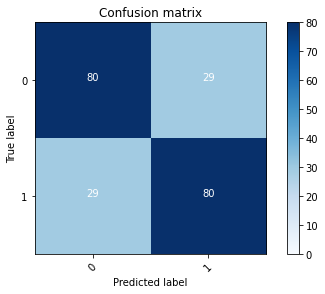

2022-08-02 20:10:14 - [Epoch Train: 68] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 20:10:14 - [Epoch Valid: 68] loss: 1.9871, auc: 0.8495, acc: 0.7339, time: 16.00 s


 45%|█████████████████▏                    | 68/150 [1:27:26<1:37:17, 71.19s/it]

2022-08-02 20:10:14 - EPOCH: 69
2022-08-02 20:10:17 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:10:20 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:10:23 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:10:26 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:10:29 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:10:31 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:10:34 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:10:37 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:10:40 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:10:43 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:10:46 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:10:48 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:10:51 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:10:54 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:10:57 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:11:00 - Train Step 160/192, train_loss: 0.0000
2

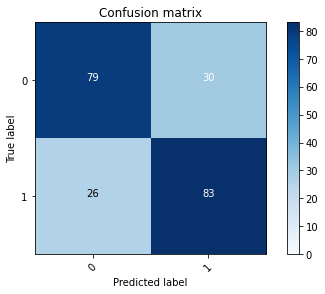

2022-08-02 20:11:25 - [Epoch Train: 69] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:11:25 - [Epoch Valid: 69] loss: 1.7925, auc: 0.8548, acc: 0.7431, time: 16.00 s


 46%|█████████████████▍                    | 69/150 [1:28:37<1:36:03, 71.15s/it]

2022-08-02 20:11:25 - EPOCH: 70
2022-08-02 20:11:28 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:11:31 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:11:34 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:11:37 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:11:40 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:11:42 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:11:45 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:11:48 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:11:51 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:11:54 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:11:57 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:12:00 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:12:02 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:12:05 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:12:08 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:12:11 - Train Step 160/192, train_loss: 0.0000
2

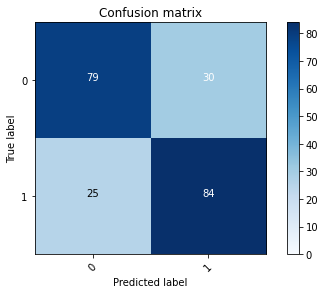

2022-08-02 20:12:36 - [Epoch Train: 70] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 20:12:36 - [Epoch Valid: 70] loss: 1.8329, auc: 0.8523, acc: 0.7477, time: 16.00 s


 47%|█████████████████▋                    | 70/150 [1:29:49<1:34:51, 71.14s/it]

2022-08-02 20:12:36 - EPOCH: 71
2022-08-02 20:12:39 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:12:42 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:12:45 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:12:48 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:12:51 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:12:54 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:12:57 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:12:59 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:13:02 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:13:05 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:13:08 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:13:11 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:13:13 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:13:16 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:13:19 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:13:22 - Train Step 160/192, train_loss: 0.0000
2

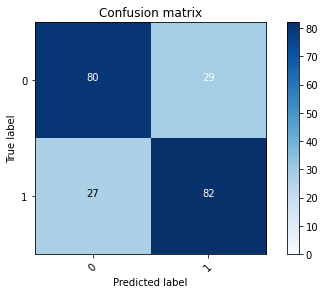

2022-08-02 20:13:47 - [Epoch Train: 71] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:13:47 - [Epoch Valid: 71] loss: 2.0165, auc: 0.8518, acc: 0.7431, time: 16.00 s


 47%|█████████████████▉                    | 71/150 [1:30:59<1:33:34, 71.07s/it]

2022-08-02 20:13:47 - EPOCH: 72
2022-08-02 20:13:50 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:13:53 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:13:56 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:13:59 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:14:02 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:14:05 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:14:08 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:14:10 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:14:13 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:14:16 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:14:19 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:14:22 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:14:25 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:14:28 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:14:31 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:14:33 - Train Step 160/192, train_loss: 0.0000
2

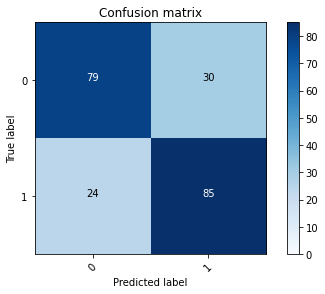

2022-08-02 20:14:58 - [Epoch Train: 72] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 20:14:58 - [Epoch Valid: 72] loss: 1.9051, auc: 0.8503, acc: 0.7523, time: 16.00 s


 48%|██████████████████▏                   | 72/150 [1:32:11<1:32:28, 71.13s/it]

2022-08-02 20:14:58 - EPOCH: 73
2022-08-02 20:15:01 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:15:04 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:15:07 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:15:10 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:15:13 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:15:16 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:15:19 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:15:22 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:15:25 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:15:28 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:15:31 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:15:34 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:15:37 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:15:40 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:15:43 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:15:45 - Train Step 160/192, train_loss: 0.0000
2

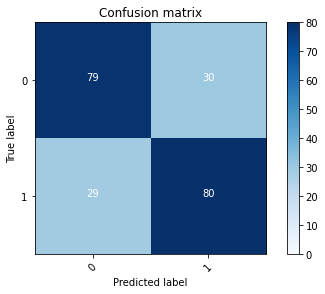

2022-08-02 20:16:11 - [Epoch Train: 73] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 56.00 s            
2022-08-02 20:16:11 - [Epoch Valid: 73] loss: 1.9591, auc: 0.8511, acc: 0.7294, time: 16.00 s


 49%|██████████████████▍                   | 73/150 [1:33:23<1:31:45, 71.50s/it]

2022-08-02 20:16:11 - EPOCH: 74
2022-08-02 20:16:14 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:16:17 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:16:20 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:16:22 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:16:25 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:16:28 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:16:31 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:16:34 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:16:37 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:16:40 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:16:43 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:16:45 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:16:48 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:16:51 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:16:54 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:16:57 - Train Step 160/192, train_loss: 0.0000
2

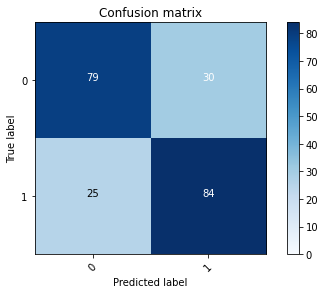

2022-08-02 20:17:22 - [Epoch Train: 74] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:17:22 - [Epoch Valid: 74] loss: 1.8949, auc: 0.8527, acc: 0.7477, time: 16.00 s


 49%|██████████████████▋                   | 74/150 [1:34:34<1:30:23, 71.36s/it]

2022-08-02 20:17:22 - EPOCH: 75
2022-08-02 20:17:25 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:17:28 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:17:31 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:17:34 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:17:36 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:17:39 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:17:42 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:17:45 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:17:48 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:17:50 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:17:53 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:17:56 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:17:59 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:18:01 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:18:04 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:18:07 - Train Step 160/192, train_loss: 0.0000
2

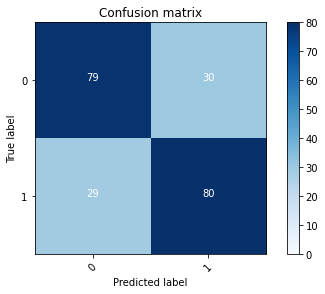

2022-08-02 20:18:32 - [Epoch Train: 75] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:18:32 - [Epoch Valid: 75] loss: 2.0114, auc: 0.8475, acc: 0.7294, time: 15.00 s


 50%|███████████████████                   | 75/150 [1:35:44<1:28:39, 70.92s/it]

2022-08-02 20:18:32 - EPOCH: 76
2022-08-02 20:18:35 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:18:37 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:18:40 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:18:43 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:18:46 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:18:49 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:18:52 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:18:55 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:18:58 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:19:00 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:19:03 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:19:06 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:19:09 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:19:12 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:19:15 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:19:18 - Train Step 160/192, train_loss: 0.0000
2

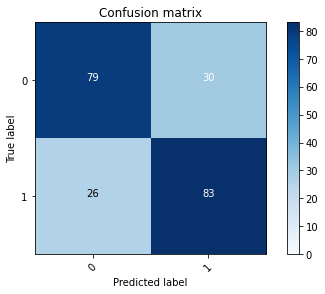

2022-08-02 20:19:42 - [Epoch Train: 76] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:19:42 - [Epoch Valid: 76] loss: 2.0325, auc: 0.8470, acc: 0.7431, time: 15.00 s


 51%|███████████████████▎                  | 76/150 [1:36:55<1:27:21, 70.83s/it]

2022-08-02 20:19:42 - EPOCH: 77
2022-08-02 20:19:45 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:19:48 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:19:51 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:19:54 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:19:56 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:19:59 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:20:02 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:20:05 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:20:07 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:20:10 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:20:13 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:20:16 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:20:19 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:20:21 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:20:24 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:20:27 - Train Step 160/192, train_loss: 0.0000
2

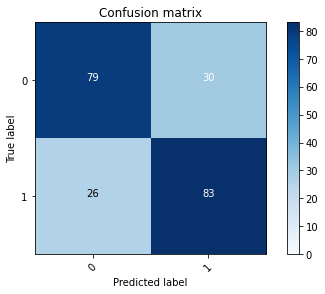

2022-08-02 20:20:52 - [Epoch Train: 77] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 53.00 s            
2022-08-02 20:20:52 - [Epoch Valid: 77] loss: 2.1147, auc: 0.8456, acc: 0.7431, time: 16.00 s


 51%|███████████████████▌                  | 77/150 [1:38:05<1:25:57, 70.65s/it]

2022-08-02 20:20:52 - EPOCH: 78
2022-08-02 20:20:56 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:20:58 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:21:01 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:21:04 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:21:07 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:21:10 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:21:12 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:21:15 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:21:18 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:21:21 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:21:24 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:21:26 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:21:29 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:21:32 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:21:35 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:21:38 - Train Step 160/192, train_loss: 0.0000
2

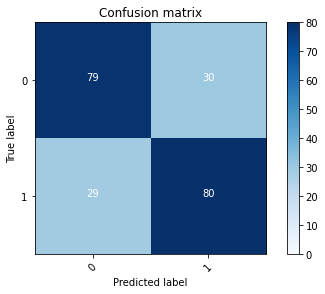

2022-08-02 20:22:03 - [Epoch Train: 78] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 53.00 s            
2022-08-02 20:22:03 - [Epoch Valid: 78] loss: 2.1022, auc: 0.8458, acc: 0.7294, time: 16.00 s


 52%|███████████████████▊                  | 78/150 [1:39:15<1:24:34, 70.48s/it]

2022-08-02 20:22:03 - EPOCH: 79
2022-08-02 20:22:06 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:22:08 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:22:11 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:22:14 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:22:17 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:22:20 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:22:23 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:22:25 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:22:28 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:22:31 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:22:34 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:22:37 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:22:40 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:22:42 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:22:45 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:22:48 - Train Step 160/192, train_loss: 0.0000
2

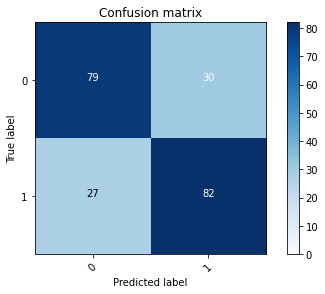

2022-08-02 20:23:13 - [Epoch Train: 79] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:23:13 - [Epoch Valid: 79] loss: 2.1236, auc: 0.8467, acc: 0.7385, time: 16.00 s


 53%|████████████████████                  | 79/150 [1:40:25<1:23:25, 70.50s/it]

2022-08-02 20:23:13 - EPOCH: 80
2022-08-02 20:23:16 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:23:19 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:23:22 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:23:25 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:23:27 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:23:30 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:23:33 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:23:36 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:23:39 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:23:42 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:23:45 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:23:48 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:23:50 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:23:53 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:23:56 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:23:59 - Train Step 160/192, train_loss: 0.0000
2

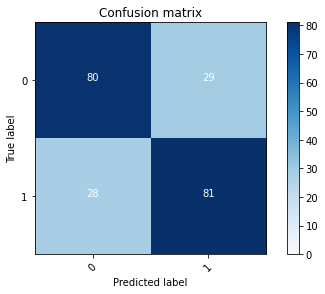

2022-08-02 20:24:24 - [Epoch Train: 80] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:24:24 - [Epoch Valid: 80] loss: 2.2547, auc: 0.8414, acc: 0.7385, time: 15.00 s


 53%|████████████████████▎                 | 80/150 [1:41:36<1:22:19, 70.56s/it]

2022-08-02 20:24:24 - EPOCH: 81
2022-08-02 20:24:27 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:24:30 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:24:32 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:24:35 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:24:38 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:24:41 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:24:44 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:24:46 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:24:49 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:24:52 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:24:55 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:24:58 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:25:00 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:25:03 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:25:06 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:25:09 - Train Step 160/192, train_loss: 0.0000
2

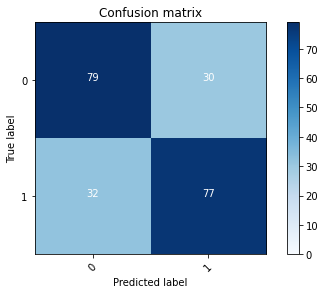

2022-08-02 20:25:34 - [Epoch Train: 81] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 53.00 s            
2022-08-02 20:25:34 - [Epoch Valid: 81] loss: 2.0729, auc: 0.8482, acc: 0.7156, time: 16.00 s


 54%|████████████████████▌                 | 81/150 [1:42:46<1:21:01, 70.46s/it]

2022-08-02 20:25:34 - EPOCH: 82
2022-08-02 20:25:37 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:25:40 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:25:43 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:25:46 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:25:49 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:25:51 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:25:54 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:25:57 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:26:00 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:26:03 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:26:06 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:26:09 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:26:11 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:26:14 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:26:17 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:26:20 - Train Step 160/192, train_loss: 0.0000
2

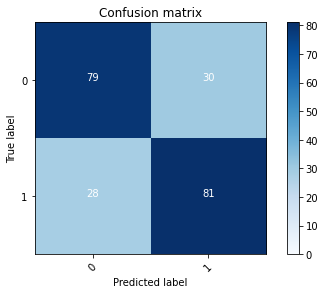

2022-08-02 20:26:45 - [Epoch Train: 82] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:26:45 - [Epoch Valid: 82] loss: 2.1557, auc: 0.8430, acc: 0.7339, time: 16.00 s


 55%|████████████████████▊                 | 82/150 [1:43:57<1:20:00, 70.60s/it]

2022-08-02 20:26:45 - EPOCH: 83
2022-08-02 20:26:48 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:26:51 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:26:54 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:26:57 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:27:00 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:27:03 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:27:05 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:27:08 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:27:11 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:27:14 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:27:17 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:27:20 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:27:22 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:27:25 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:27:28 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:27:31 - Train Step 160/192, train_loss: 0.0000
2

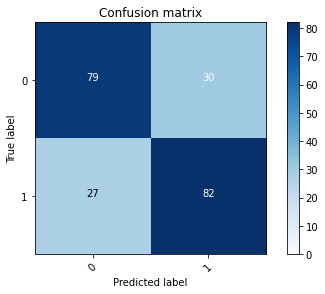

2022-08-02 20:27:55 - [Epoch Train: 83] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:27:55 - [Epoch Valid: 83] loss: 2.2562, auc: 0.8435, acc: 0.7385, time: 16.00 s


 55%|█████████████████████                 | 83/150 [1:45:08<1:18:49, 70.59s/it]

2022-08-02 20:27:55 - EPOCH: 84
2022-08-02 20:27:59 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:28:02 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:28:05 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:28:08 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:28:11 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:28:14 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:28:16 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:28:19 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:28:22 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:28:25 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:28:28 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:28:31 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:28:34 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:28:37 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:28:40 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:28:43 - Train Step 160/192, train_loss: 0.0000
2

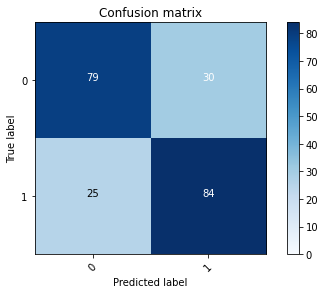

2022-08-02 20:29:08 - [Epoch Train: 84] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 56.00 s            
2022-08-02 20:29:08 - [Epoch Valid: 84] loss: 2.3030, auc: 0.8436, acc: 0.7477, time: 16.00 s


 56%|█████████████████████▎                | 84/150 [1:46:20<1:18:10, 71.06s/it]

2022-08-02 20:29:08 - EPOCH: 85
2022-08-02 20:29:11 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:29:13 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:29:16 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:29:19 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:29:22 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:29:25 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:29:28 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:29:30 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:29:33 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:29:36 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:29:39 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:29:42 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:29:45 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:29:47 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:29:50 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:29:53 - Train Step 160/192, train_loss: 0.0000
2

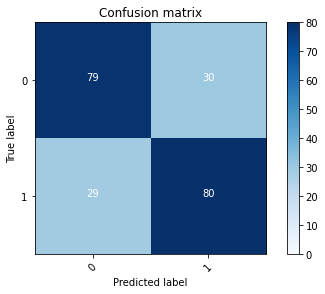

2022-08-02 20:30:18 - [Epoch Train: 85] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:30:18 - [Epoch Valid: 85] loss: 2.3275, auc: 0.8461, acc: 0.7294, time: 16.00 s


 57%|█████████████████████▌                | 85/150 [1:47:31<1:16:49, 70.92s/it]

2022-08-02 20:30:18 - EPOCH: 86
2022-08-02 20:30:21 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:30:24 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:30:27 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:30:30 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:30:33 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:30:36 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:30:39 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:30:42 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:30:44 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:30:47 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:30:50 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:30:53 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:30:56 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:30:59 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:31:02 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:31:04 - Train Step 160/192, train_loss: 0.0000
2

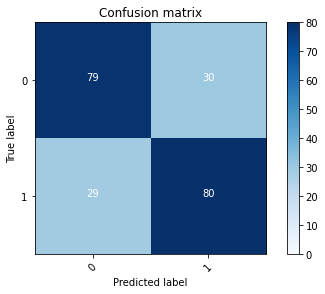

2022-08-02 20:31:29 - [Epoch Train: 86] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 20:31:29 - [Epoch Valid: 86] loss: 2.1324, auc: 0.8426, acc: 0.7294, time: 15.00 s


 57%|█████████████████████▊                | 86/150 [1:48:42<1:15:42, 70.98s/it]

2022-08-02 20:31:29 - EPOCH: 87
2022-08-02 20:31:32 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:31:35 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:31:38 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:31:41 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:31:44 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:31:46 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:31:49 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:31:52 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:31:55 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:31:58 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:32:01 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:32:03 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:32:06 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:32:09 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:32:12 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:32:15 - Train Step 160/192, train_loss: 0.0000
2

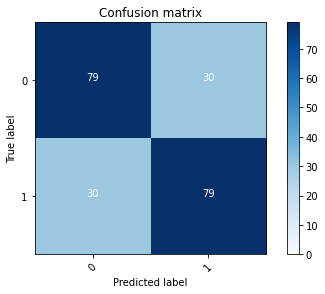

2022-08-02 20:32:39 - [Epoch Train: 87] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:32:39 - [Epoch Valid: 87] loss: 2.2097, auc: 0.8483, acc: 0.7248, time: 15.00 s


 58%|██████████████████████                | 87/150 [1:49:52<1:14:15, 70.73s/it]

2022-08-02 20:32:39 - EPOCH: 88
2022-08-02 20:32:43 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:32:45 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:32:48 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:32:51 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:32:54 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:32:57 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:33:00 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:33:03 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:33:05 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:33:08 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:33:11 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:33:14 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:33:17 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:33:20 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:33:23 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:33:26 - Train Step 160/192, train_loss: 0.0000
2

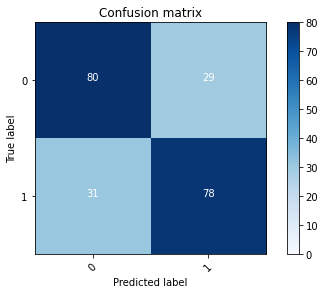

2022-08-02 20:33:51 - [Epoch Train: 88] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:33:51 - [Epoch Valid: 88] loss: 2.4573, auc: 0.8443, acc: 0.7248, time: 16.00 s


 59%|██████████████████████▎               | 88/150 [1:51:03<1:13:18, 70.94s/it]

2022-08-02 20:33:51 - EPOCH: 89
2022-08-02 20:33:54 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:33:57 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:34:00 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:34:03 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:34:06 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:34:09 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:34:12 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:34:15 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:34:17 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:34:20 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:34:23 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:34:26 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:34:29 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:34:32 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:34:35 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:34:37 - Train Step 160/192, train_loss: 0.0000
2

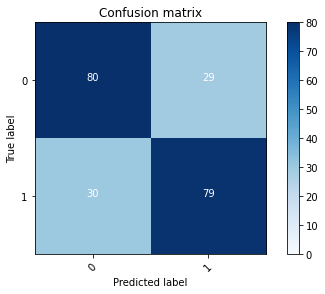

2022-08-02 20:35:02 - [Epoch Train: 89] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 20:35:02 - [Epoch Valid: 89] loss: 2.3771, auc: 0.8450, acc: 0.7294, time: 16.00 s


 59%|██████████████████████▌               | 89/150 [1:52:15<1:12:18, 71.13s/it]

2022-08-02 20:35:02 - EPOCH: 90
2022-08-02 20:35:06 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:35:09 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:35:11 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:35:14 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:35:17 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:35:20 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:35:23 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:35:25 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:35:28 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:35:31 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:35:34 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:35:37 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:35:40 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:35:42 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:35:45 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:35:48 - Train Step 160/192, train_loss: 0.0000
2

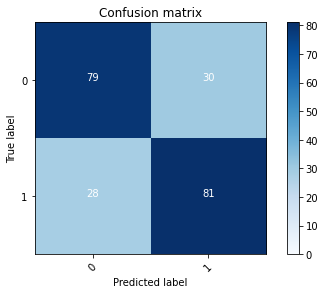

2022-08-02 20:36:13 - [Epoch Train: 90] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:36:13 - [Epoch Valid: 90] loss: 2.2785, auc: 0.8470, acc: 0.7339, time: 16.00 s


 60%|██████████████████████▊               | 90/150 [1:53:26<1:11:02, 71.04s/it]

2022-08-02 20:36:13 - EPOCH: 91
2022-08-02 20:36:16 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:36:19 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:36:22 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:36:25 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:36:28 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:36:31 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:36:34 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:36:37 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:36:40 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:36:42 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:36:45 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:36:48 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:36:51 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:36:54 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:36:57 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:36:59 - Train Step 160/192, train_loss: 0.0000
2

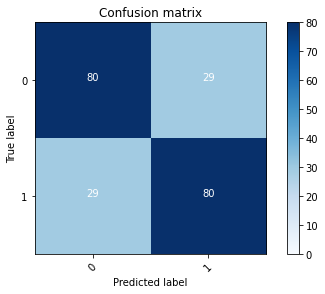

2022-08-02 20:37:25 - [Epoch Train: 91] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:37:25 - [Epoch Valid: 91] loss: 2.4332, auc: 0.8461, acc: 0.7339, time: 16.00 s


 61%|███████████████████████               | 91/150 [1:54:37<1:09:58, 71.15s/it]

2022-08-02 20:37:25 - EPOCH: 92
2022-08-02 20:37:28 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:37:31 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:37:33 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:37:36 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:37:39 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:37:42 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:37:45 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:37:48 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:37:51 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:37:53 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:37:56 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:37:59 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:38:02 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:38:05 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:38:07 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:38:10 - Train Step 160/192, train_loss: 0.0000
2

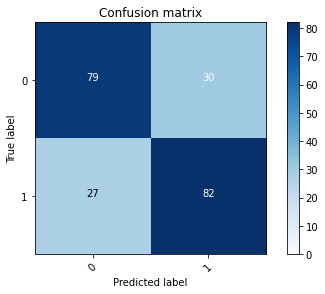

2022-08-02 20:38:35 - [Epoch Train: 92] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:38:35 - [Epoch Valid: 92] loss: 2.3937, auc: 0.8447, acc: 0.7385, time: 15.00 s


 61%|███████████████████████▎              | 92/150 [1:55:47<1:08:26, 70.80s/it]

2022-08-02 20:38:35 - EPOCH: 93
2022-08-02 20:38:38 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:38:41 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:38:43 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:38:46 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:38:49 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:38:52 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:38:55 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:38:58 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:39:01 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:39:04 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:39:06 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:39:09 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:39:12 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:39:15 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:39:18 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:39:20 - Train Step 160/192, train_loss: 0.0000
2

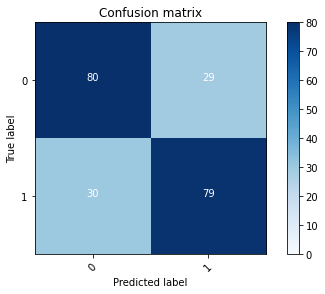

2022-08-02 20:39:45 - [Epoch Train: 93] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 54.00 s            
2022-08-02 20:39:45 - [Epoch Valid: 93] loss: 2.4422, auc: 0.8480, acc: 0.7294, time: 15.00 s


 62%|███████████████████████▌              | 93/150 [1:56:58<1:07:08, 70.68s/it]

2022-08-02 20:39:45 - EPOCH: 94
2022-08-02 20:39:48 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:39:51 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:39:54 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:39:57 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:40:00 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:40:03 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:40:06 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:40:08 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:40:11 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:40:14 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:40:17 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:40:20 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:40:23 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:40:26 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:40:29 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:40:32 - Train Step 160/192, train_loss: 0.0000
2

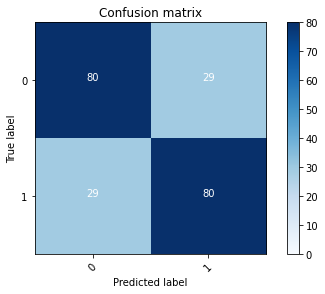

2022-08-02 20:40:56 - [Epoch Train: 94] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 55.00 s            
2022-08-02 20:40:56 - [Epoch Valid: 94] loss: 2.3450, auc: 0.8466, acc: 0.7339, time: 15.00 s


 63%|███████████████████████▊              | 94/150 [1:58:09<1:06:06, 70.84s/it]

2022-08-02 20:40:56 - EPOCH: 95
2022-08-02 20:41:00 - Train Step 10/192, train_loss: 0.0000
2022-08-02 20:41:03 - Train Step 20/192, train_loss: 0.0000
2022-08-02 20:41:05 - Train Step 30/192, train_loss: 0.0000
2022-08-02 20:41:08 - Train Step 40/192, train_loss: 0.0000
2022-08-02 20:41:11 - Train Step 50/192, train_loss: 0.0000
2022-08-02 20:41:14 - Train Step 60/192, train_loss: 0.0000
2022-08-02 20:41:17 - Train Step 70/192, train_loss: 0.0000
2022-08-02 20:41:20 - Train Step 80/192, train_loss: 0.0000
2022-08-02 20:41:23 - Train Step 90/192, train_loss: 0.0000
2022-08-02 20:41:26 - Train Step 100/192, train_loss: 0.0000
2022-08-02 20:41:29 - Train Step 110/192, train_loss: 0.0000
2022-08-02 20:41:32 - Train Step 120/192, train_loss: 0.0000
2022-08-02 20:41:35 - Train Step 130/192, train_loss: 0.0000
2022-08-02 20:41:37 - Train Step 140/192, train_loss: 0.0000
2022-08-02 20:41:40 - Train Step 150/192, train_loss: 0.0000
2022-08-02 20:41:43 - Train Step 160/192, train_loss: 0.0000
2

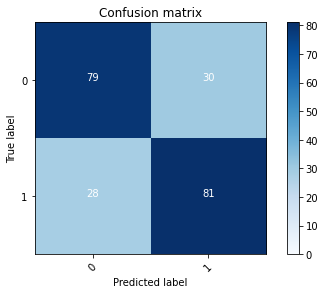

2022-08-02 20:42:09 - [Epoch Train: 95] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 56.00 s            
2022-08-02 20:42:09 - [Epoch Valid: 95] loss: 2.4066, auc: 0.8422, acc: 0.7339, time: 16.00 s
2022-08-02 20:42:09 - 
Valid acc didn't improve last 30 epochs.


 63%|███████████████████████▊              | 94/150 [1:59:21<1:11:06, 76.19s/it]


In [227]:
print(info)
m_modelfile = train_mri_type(m_model, device, info, epochs=150, pat=30, 
                       train_loader=train_loader, valid_loader=val_loader)
##m_modelfile = train_mri_type(m_model, device, info, epochs=150, pat=30, 
##                       train_loader=m_train_loader, valid_loader=m_val_loader)

#m_modelfile = train_mri_type(m_model, device, info, epochs=150, pat=30, 
#                       train_loader=n_train_loader, valid_loader=n_val_loader)

{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['T1w'], 'is_depth_wise': True, 'is_transformed': False, 'output_size': 1, 'is_multistep': True, 'lr': 0.0001, 'is_adam': True, 'momentum': 0.9, 'is_10_fold': False, 'val_total_ratio': 0.2, 'is_internal_dataset': True, 'train_origin': 'n', 'val_origin': 'n', 'net': 'RSNAClassifierSingle3D'}
RSNAClassifierSingle3D(
  (part1): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): Conv3d(1, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (2): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), groups=4, bias=False)
      (1): Conv3d(4, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

  0%|                                                   | 0/150 [00:00<?, ?it/s]

2022-08-03 20:14:30 - EPOCH: 1
2022-08-03 20:14:34 - Train Step 10/60, train_loss: 0.6991
2022-08-03 20:14:38 - Train Step 20/60, train_loss: 0.6901
2022-08-03 20:14:42 - Train Step 30/60, train_loss: 0.6936
2022-08-03 20:14:46 - Train Step 40/60, train_loss: 0.7053
2022-08-03 20:14:50 - Train Step 50/60, train_loss: 0.6990
2022-08-03 20:14:54 - Train Step 60/60, train_loss: 0.6968
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-03 20:14:57 - Valid Step 5/17, valid_loss: 0.7324
2022-08-03 20:14:59 - Valid Step 10/17, valid_loss: 0.7037
2022-08-03 20:15:01 - Valid Step 15/17, valid_loss: 0.6996
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
65  UPENN-GBM-00092_11_T1w                0           0
53  UPENN-GBM-00093_11_T1w                0           0
6   UPENN-GBM-00094_11_T1w                0           0
30  UPENN-GBM-00115_11_T1w                1           0
27  UPENN-GBM-00117_11_T1w                0           0
58  UPENN-GBM-00128_11_T1w         

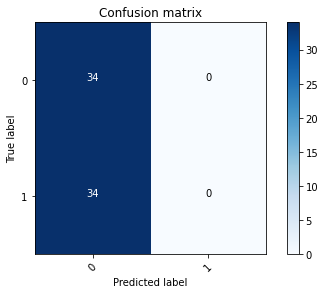

2022-08-03 20:15:02 - [Epoch Train: 1] loss: 0.6968, auc: 0.5359, acc: 0.4874, time: 24.00 s            
2022-08-03 20:15:02 - [Epoch Valid: 1] loss: 0.7011, auc: 0.4663, acc: 0.5000, time: 7.00 s
2022-08-03 20:15:02 - acc improved from 0.0000 to 0.5000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e1-loss0.701-acc0.500-auc0.466.pth'


  1%|▎                                        | 1/150 [00:32<1:20:50, 32.55s/it]

2022-08-03 20:15:02 - EPOCH: 2
2022-08-03 20:15:06 - Train Step 10/60, train_loss: 0.6451
2022-08-03 20:15:10 - Train Step 20/60, train_loss: 0.6486
2022-08-03 20:15:15 - Train Step 30/60, train_loss: 0.6502
2022-08-03 20:15:19 - Train Step 40/60, train_loss: 0.6593
2022-08-03 20:15:24 - Train Step 50/60, train_loss: 0.6541
2022-08-03 20:15:28 - Train Step 60/60, train_loss: 0.6502
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-03 20:15:30 - Valid Step 5/17, valid_loss: 0.6793
2022-08-03 20:15:32 - Valid Step 10/17, valid_loss: 0.6793
2022-08-03 20:15:35 - Valid Step 15/17, valid_loss: 0.6704
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
22  UPENN-GBM-00092_11_T1w                0           0
66  UPENN-GBM-00093_11_T1w                0           0
34  UPENN-GBM-00094_11_T1w                0           0
53  UPENN-GBM-00115_11_T1w                1           0
13  UPENN-GBM-00117_11_T1w                0           0
32  UPENN-GBM-00128_11_T1w         

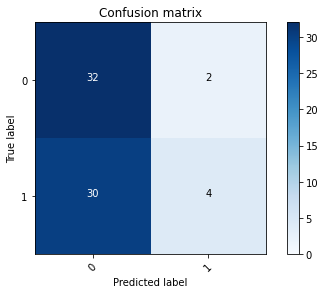

2022-08-03 20:15:36 - [Epoch Train: 2] loss: 0.6502, auc: 0.7182, acc: 0.5210, time: 25.00 s            
2022-08-03 20:15:36 - [Epoch Valid: 2] loss: 0.6771, auc: 0.5995, acc: 0.5294, time: 7.00 s
2022-08-03 20:15:36 - acc improved from 0.5000 to 0.5294. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e2-loss0.677-acc0.529-auc0.599.pth'


  1%|▌                                        | 2/150 [01:06<1:21:55, 33.22s/it]

2022-08-03 20:15:36 - EPOCH: 3
2022-08-03 20:15:40 - Train Step 10/60, train_loss: 0.5680
2022-08-03 20:15:44 - Train Step 20/60, train_loss: 0.5720
2022-08-03 20:15:48 - Train Step 30/60, train_loss: 0.5752
2022-08-03 20:15:52 - Train Step 40/60, train_loss: 0.5726
2022-08-03 20:15:56 - Train Step 50/60, train_loss: 0.5794
2022-08-03 20:15:59 - Train Step 60/60, train_loss: 0.5800
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-03 20:16:02 - Valid Step 5/17, valid_loss: 0.6713
2022-08-03 20:16:04 - Valid Step 10/17, valid_loss: 0.6916
2022-08-03 20:16:06 - Valid Step 15/17, valid_loss: 0.6868
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
33  UPENN-GBM-00092_11_T1w                0           1
39  UPENN-GBM-00093_11_T1w                0           0
20  UPENN-GBM-00094_11_T1w                0           0
66  UPENN-GBM-00115_11_T1w                1           1
34  UPENN-GBM-00117_11_T1w                0           0
11  UPENN-GBM-00128_11_T1w         

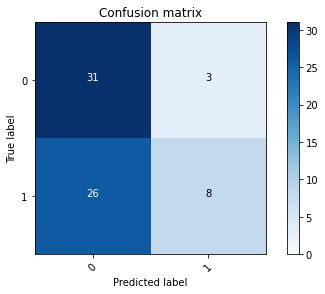

2022-08-03 20:16:07 - [Epoch Train: 3] loss: 0.5800, auc: 0.8816, acc: 0.6218, time: 23.00 s            
2022-08-03 20:16:07 - [Epoch Valid: 3] loss: 0.6696, auc: 0.6254, acc: 0.5735, time: 7.00 s
2022-08-03 20:16:07 - acc improved from 0.5294 to 0.5735. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e3-loss0.670-acc0.574-auc0.625.pth'


  2%|▊                                        | 3/150 [01:37<1:19:04, 32.27s/it]

2022-08-03 20:16:07 - EPOCH: 4
2022-08-03 20:16:11 - Train Step 10/60, train_loss: 0.5663
2022-08-03 20:16:15 - Train Step 20/60, train_loss: 0.5185
2022-08-03 20:16:19 - Train Step 30/60, train_loss: 0.5017
2022-08-03 20:16:23 - Train Step 40/60, train_loss: 0.4896
2022-08-03 20:16:27 - Train Step 50/60, train_loss: 0.4844
2022-08-03 20:16:31 - Train Step 60/60, train_loss: 0.4813
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-03 20:16:34 - Valid Step 5/17, valid_loss: 0.7097
2022-08-03 20:16:35 - Valid Step 10/17, valid_loss: 0.7027
2022-08-03 20:16:38 - Valid Step 15/17, valid_loss: 0.6777
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
44  UPENN-GBM-00092_11_T1w                0           1
54  UPENN-GBM-00093_11_T1w                0           0
53  UPENN-GBM-00094_11_T1w                0           0
41  UPENN-GBM-00115_11_T1w                1           1
40  UPENN-GBM-00117_11_T1w                0           0
12  UPENN-GBM-00128_11_T1w         

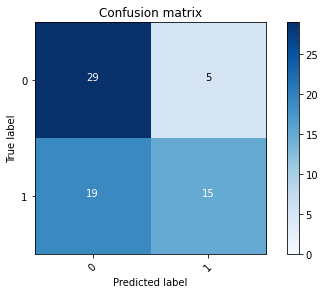

2022-08-03 20:16:39 - [Epoch Train: 4] loss: 0.4813, auc: 0.9636, acc: 0.7437, time: 24.00 s            
2022-08-03 20:16:39 - [Epoch Valid: 4] loss: 0.6615, auc: 0.6522, acc: 0.6471, time: 7.00 s
2022-08-03 20:16:39 - acc improved from 0.5735 to 0.6471. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e4-loss0.662-acc0.647-auc0.652.pth'


  3%|█                                        | 4/150 [02:09<1:18:01, 32.07s/it]

2022-08-03 20:16:39 - EPOCH: 5
2022-08-03 20:16:43 - Train Step 10/60, train_loss: 0.3806
2022-08-03 20:16:47 - Train Step 20/60, train_loss: 0.3892
2022-08-03 20:16:51 - Train Step 30/60, train_loss: 0.3843
2022-08-03 20:16:55 - Train Step 40/60, train_loss: 0.3677
2022-08-03 20:16:59 - Train Step 50/60, train_loss: 0.3669
2022-08-03 20:17:03 - Train Step 60/60, train_loss: 0.3532
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-03 20:17:05 - Valid Step 5/17, valid_loss: 0.6059
2022-08-03 20:17:07 - Valid Step 10/17, valid_loss: 0.6684
2022-08-03 20:17:09 - Valid Step 15/17, valid_loss: 0.6420
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
38  UPENN-GBM-00092_11_T1w                0           1
62  UPENN-GBM-00093_11_T1w                0           0
37  UPENN-GBM-00094_11_T1w                0           0
21  UPENN-GBM-00115_11_T1w                1           1
28  UPENN-GBM-00117_11_T1w                0           0
3   UPENN-GBM-00128_11_T1w         

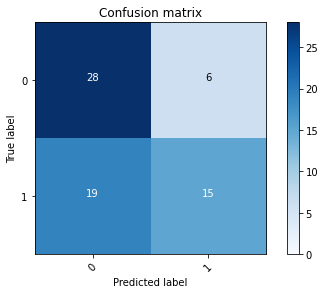

2022-08-03 20:17:10 - [Epoch Train: 5] loss: 0.3532, auc: 0.9902, acc: 0.8697, time: 23.00 s            
2022-08-03 20:17:10 - [Epoch Valid: 5] loss: 0.6544, auc: 0.6843, acc: 0.6324, time: 7.00 s


  3%|█▎                                       | 5/150 [02:40<1:17:01, 31.87s/it]

2022-08-03 20:17:10 - EPOCH: 6
2022-08-03 20:17:15 - Train Step 10/60, train_loss: 0.2734
2022-08-03 20:17:18 - Train Step 20/60, train_loss: 0.2620
2022-08-03 20:17:22 - Train Step 30/60, train_loss: 0.2628
2022-08-03 20:17:26 - Train Step 40/60, train_loss: 0.2545
2022-08-03 20:17:30 - Train Step 50/60, train_loss: 0.2539
2022-08-03 20:17:34 - Train Step 60/60, train_loss: 0.2592
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-03 20:17:37 - Valid Step 5/17, valid_loss: 0.7856
2022-08-03 20:17:38 - Valid Step 10/17, valid_loss: 0.7143
2022-08-03 20:17:40 - Valid Step 15/17, valid_loss: 0.7293
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
35  UPENN-GBM-00092_11_T1w                0           1
55  UPENN-GBM-00093_11_T1w                0           0
28  UPENN-GBM-00094_11_T1w                0           0
60  UPENN-GBM-00115_11_T1w                1           1
14  UPENN-GBM-00117_11_T1w                0           1
1   UPENN-GBM-00128_11_T1w         

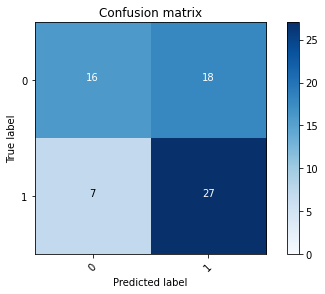

2022-08-03 20:17:41 - [Epoch Train: 6] loss: 0.2592, auc: 0.9933, acc: 0.8992, time: 23.00 s            
2022-08-03 20:17:41 - [Epoch Valid: 6] loss: 0.7788, auc: 0.6713, acc: 0.6324, time: 7.00 s


  4%|█▋                                       | 6/150 [03:11<1:15:56, 31.64s/it]

2022-08-03 20:17:41 - EPOCH: 7
2022-08-03 20:17:46 - Train Step 10/60, train_loss: 0.1808
2022-08-03 20:17:50 - Train Step 20/60, train_loss: 0.1740
2022-08-03 20:17:53 - Train Step 30/60, train_loss: 0.1801
2022-08-03 20:17:57 - Train Step 40/60, train_loss: 0.1736
2022-08-03 20:18:01 - Train Step 50/60, train_loss: 0.1708
2022-08-03 20:18:05 - Train Step 60/60, train_loss: 0.1697
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-03 20:18:07 - Valid Step 5/17, valid_loss: 0.5225
2022-08-03 20:18:09 - Valid Step 10/17, valid_loss: 0.6309
2022-08-03 20:18:11 - Valid Step 15/17, valid_loss: 0.7399
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
53  UPENN-GBM-00092_11_T1w                0           1
17  UPENN-GBM-00093_11_T1w                0           0
65  UPENN-GBM-00094_11_T1w                0           0
7   UPENN-GBM-00115_11_T1w                1           1
36  UPENN-GBM-00117_11_T1w                0           1
39  UPENN-GBM-00128_11_T1w         

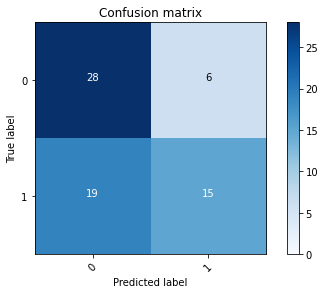

2022-08-03 20:18:12 - [Epoch Train: 7] loss: 0.1697, auc: 1.0000, acc: 0.9790, time: 23.00 s            
2022-08-03 20:18:12 - [Epoch Valid: 7] loss: 0.7137, auc: 0.6799, acc: 0.6324, time: 7.00 s


  5%|█▉                                       | 7/150 [03:42<1:14:40, 31.34s/it]

2022-08-03 20:18:12 - EPOCH: 8
2022-08-03 20:18:16 - Train Step 10/60, train_loss: 0.1016
2022-08-03 20:18:20 - Train Step 20/60, train_loss: 0.0960
2022-08-03 20:18:24 - Train Step 30/60, train_loss: 0.0988
2022-08-03 20:18:28 - Train Step 40/60, train_loss: 0.0947
2022-08-03 20:18:32 - Train Step 50/60, train_loss: 0.0922
2022-08-03 20:18:36 - Train Step 60/60, train_loss: 0.0923
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-03 20:18:38 - Valid Step 5/17, valid_loss: 0.9713
2022-08-03 20:18:40 - Valid Step 10/17, valid_loss: 0.6859
2022-08-03 20:18:42 - Valid Step 15/17, valid_loss: 0.7773
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
24  UPENN-GBM-00092_11_T1w                0           1
12  UPENN-GBM-00093_11_T1w                0           0
43  UPENN-GBM-00094_11_T1w                0           0
56  UPENN-GBM-00115_11_T1w                1           1
64  UPENN-GBM-00117_11_T1w                0           1
59  UPENN-GBM-00128_11_T1w         

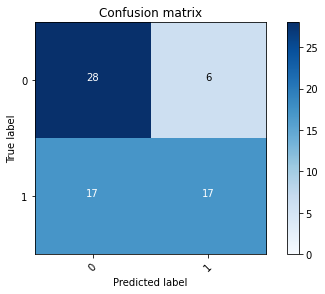

2022-08-03 20:18:43 - [Epoch Train: 8] loss: 0.0923, auc: 1.0000, acc: 0.9916, time: 23.00 s            
2022-08-03 20:18:43 - [Epoch Valid: 8] loss: 0.7800, auc: 0.6955, acc: 0.6618, time: 7.00 s
2022-08-03 20:18:43 - acc improved from 0.6471 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e8-loss0.780-acc0.662-auc0.696.pth'


  5%|██▏                                      | 8/150 [04:13<1:14:05, 31.30s/it]

2022-08-03 20:18:43 - EPOCH: 9
2022-08-03 20:18:48 - Train Step 10/60, train_loss: 0.0806
2022-08-03 20:18:51 - Train Step 20/60, train_loss: 0.0740
2022-08-03 20:18:55 - Train Step 30/60, train_loss: 0.0647
2022-08-03 20:18:59 - Train Step 40/60, train_loss: 0.0632
2022-08-03 20:19:03 - Train Step 50/60, train_loss: 0.0612
2022-08-03 20:19:07 - Train Step 60/60, train_loss: 0.0607
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-03 20:19:10 - Valid Step 5/17, valid_loss: 0.9708
2022-08-03 20:19:11 - Valid Step 10/17, valid_loss: 0.8680
2022-08-03 20:19:14 - Valid Step 15/17, valid_loss: 0.8350
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
45  UPENN-GBM-00092_11_T1w                0           1
7   UPENN-GBM-00093_11_T1w                0           0
24  UPENN-GBM-00094_11_T1w                0           1
47  UPENN-GBM-00115_11_T1w                1           1
63  UPENN-GBM-00117_11_T1w                0           1
4   UPENN-GBM-00128_11_T1w         

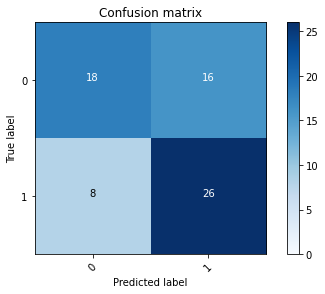

2022-08-03 20:19:15 - [Epoch Train: 9] loss: 0.0607, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:19:15 - [Epoch Valid: 9] loss: 0.8706, auc: 0.6972, acc: 0.6471, time: 7.00 s


  6%|██▍                                      | 9/150 [04:44<1:13:28, 31.26s/it]

2022-08-03 20:19:15 - EPOCH: 10
2022-08-03 20:19:19 - Train Step 10/60, train_loss: 0.0395
2022-08-03 20:19:23 - Train Step 20/60, train_loss: 0.0409
2022-08-03 20:19:27 - Train Step 30/60, train_loss: 0.0394
2022-08-03 20:19:30 - Train Step 40/60, train_loss: 0.0385
2022-08-03 20:19:34 - Train Step 50/60, train_loss: 0.0369
2022-08-03 20:19:38 - Train Step 60/60, train_loss: 0.0364
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:19:41 - Valid Step 5/17, valid_loss: 1.2942
2022-08-03 20:19:43 - Valid Step 10/17, valid_loss: 0.9618
2022-08-03 20:19:45 - Valid Step 15/17, valid_loss: 0.8326
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
15  UPENN-GBM-00092_11_T1w                0           1
18  UPENN-GBM-00093_11_T1w                0           0
23  UPENN-GBM-00094_11_T1w                0           1
49  UPENN-GBM-00115_11_T1w                1           1
36  UPENN-GBM-00117_11_T1w                0           1
64  UPENN-GBM-00128_11_T1w        

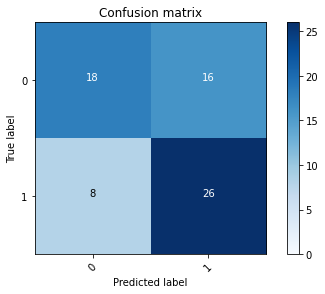

2022-08-03 20:19:46 - [Epoch Train: 10] loss: 0.0364, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:19:46 - [Epoch Valid: 10] loss: 0.8948, auc: 0.7007, acc: 0.6471, time: 7.00 s


  7%|██▋                                     | 10/150 [05:16<1:12:58, 31.27s/it]

2022-08-03 20:19:46 - EPOCH: 11
2022-08-03 20:19:50 - Train Step 10/60, train_loss: 0.0201
2022-08-03 20:19:54 - Train Step 20/60, train_loss: 0.0291
2022-08-03 20:19:58 - Train Step 30/60, train_loss: 0.0295
2022-08-03 20:20:01 - Train Step 40/60, train_loss: 0.0290
2022-08-03 20:20:05 - Train Step 50/60, train_loss: 0.0279
2022-08-03 20:20:09 - Train Step 60/60, train_loss: 0.0270
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:20:12 - Valid Step 5/17, valid_loss: 0.5732
2022-08-03 20:20:13 - Valid Step 10/17, valid_loss: 0.6206
2022-08-03 20:20:16 - Valid Step 15/17, valid_loss: 0.8380
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
29  UPENN-GBM-00092_11_T1w                0           1
15  UPENN-GBM-00093_11_T1w                0           0
63  UPENN-GBM-00094_11_T1w                0           1
7   UPENN-GBM-00115_11_T1w                1           1
0   UPENN-GBM-00117_11_T1w                0           1
14  UPENN-GBM-00128_11_T1w        

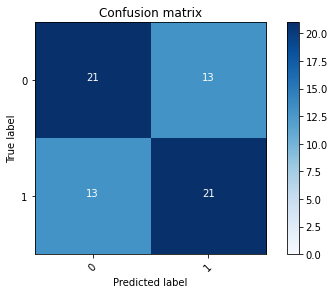

2022-08-03 20:20:17 - [Epoch Train: 11] loss: 0.0270, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:20:17 - [Epoch Valid: 11] loss: 0.8842, auc: 0.7016, acc: 0.6176, time: 7.00 s


  7%|██▉                                     | 11/150 [05:47<1:12:15, 31.19s/it]

2022-08-03 20:20:17 - EPOCH: 12
2022-08-03 20:20:21 - Train Step 10/60, train_loss: 0.0233
2022-08-03 20:20:25 - Train Step 20/60, train_loss: 0.0239
2022-08-03 20:20:29 - Train Step 30/60, train_loss: 0.0239
2022-08-03 20:20:33 - Train Step 40/60, train_loss: 0.0242
2022-08-03 20:20:37 - Train Step 50/60, train_loss: 0.0243
2022-08-03 20:20:41 - Train Step 60/60, train_loss: 0.0237
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:20:44 - Valid Step 5/17, valid_loss: 0.8045
2022-08-03 20:20:46 - Valid Step 10/17, valid_loss: 0.8891
2022-08-03 20:20:48 - Valid Step 15/17, valid_loss: 0.7666
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
50  UPENN-GBM-00092_11_T1w                0           1
27  UPENN-GBM-00093_11_T1w                0           0
19  UPENN-GBM-00094_11_T1w                0           1
47  UPENN-GBM-00115_11_T1w                1           1
36  UPENN-GBM-00117_11_T1w                0           1
18  UPENN-GBM-00128_11_T1w        

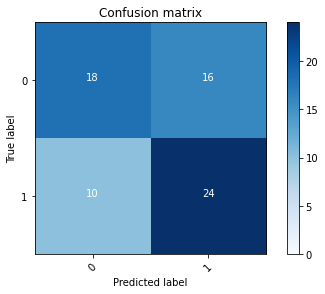

2022-08-03 20:20:49 - [Epoch Train: 12] loss: 0.0237, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 20:20:49 - [Epoch Valid: 12] loss: 0.9334, auc: 0.6981, acc: 0.6176, time: 7.00 s


  8%|███▏                                    | 12/150 [06:19<1:12:23, 31.47s/it]

2022-08-03 20:20:49 - EPOCH: 13
2022-08-03 20:20:53 - Train Step 10/60, train_loss: 0.0169
2022-08-03 20:20:57 - Train Step 20/60, train_loss: 0.0203
2022-08-03 20:21:01 - Train Step 30/60, train_loss: 0.0208
2022-08-03 20:21:05 - Train Step 40/60, train_loss: 0.0201
2022-08-03 20:21:08 - Train Step 50/60, train_loss: 0.0189
2022-08-03 20:21:12 - Train Step 60/60, train_loss: 0.0188
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:21:15 - Valid Step 5/17, valid_loss: 1.1533
2022-08-03 20:21:16 - Valid Step 10/17, valid_loss: 1.0687
2022-08-03 20:21:19 - Valid Step 15/17, valid_loss: 0.9352
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
20  UPENN-GBM-00092_11_T1w                0           1
48  UPENN-GBM-00093_11_T1w                0           0
66  UPENN-GBM-00094_11_T1w                0           1
25  UPENN-GBM-00115_11_T1w                1           1
19  UPENN-GBM-00117_11_T1w                0           1
7   UPENN-GBM-00128_11_T1w        

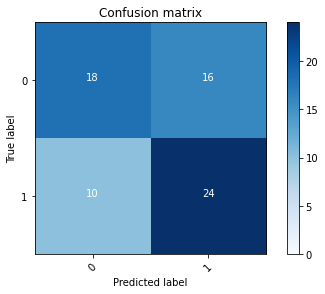

2022-08-03 20:21:20 - [Epoch Train: 13] loss: 0.0188, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:21:20 - [Epoch Valid: 13] loss: 0.9530, auc: 0.6981, acc: 0.6176, time: 7.00 s


  9%|███▍                                    | 13/150 [06:50<1:11:22, 31.26s/it]

2022-08-03 20:21:20 - EPOCH: 14
2022-08-03 20:21:24 - Train Step 10/60, train_loss: 0.0225
2022-08-03 20:21:28 - Train Step 20/60, train_loss: 0.0204
2022-08-03 20:21:32 - Train Step 30/60, train_loss: 0.0195
2022-08-03 20:21:36 - Train Step 40/60, train_loss: 0.0199
2022-08-03 20:21:40 - Train Step 50/60, train_loss: 0.0203
2022-08-03 20:21:43 - Train Step 60/60, train_loss: 0.0200
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:21:46 - Valid Step 5/17, valid_loss: 1.6246
2022-08-03 20:21:48 - Valid Step 10/17, valid_loss: 1.3348
2022-08-03 20:21:50 - Valid Step 15/17, valid_loss: 1.1010
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
24  UPENN-GBM-00092_11_T1w                0           1
16  UPENN-GBM-00093_11_T1w                0           0
54  UPENN-GBM-00094_11_T1w                0           1
64  UPENN-GBM-00115_11_T1w                1           1
49  UPENN-GBM-00117_11_T1w                0           1
52  UPENN-GBM-00128_11_T1w        

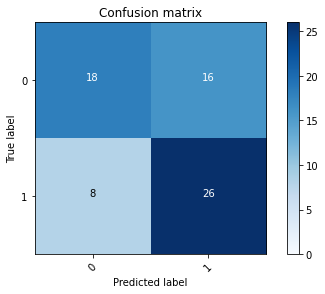

2022-08-03 20:21:51 - [Epoch Train: 14] loss: 0.0200, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:21:51 - [Epoch Valid: 14] loss: 1.0088, auc: 0.7059, acc: 0.6471, time: 7.00 s


  9%|███▋                                    | 14/150 [07:21<1:10:53, 31.27s/it]

2022-08-03 20:21:51 - EPOCH: 15
2022-08-03 20:21:55 - Train Step 10/60, train_loss: 0.0121
2022-08-03 20:21:59 - Train Step 20/60, train_loss: 0.0121
2022-08-03 20:22:03 - Train Step 30/60, train_loss: 0.0139
2022-08-03 20:22:07 - Train Step 40/60, train_loss: 0.0145
2022-08-03 20:22:10 - Train Step 50/60, train_loss: 0.0143
2022-08-03 20:22:14 - Train Step 60/60, train_loss: 0.0144
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:22:17 - Valid Step 5/17, valid_loss: 0.7349
2022-08-03 20:22:18 - Valid Step 10/17, valid_loss: 0.7526
2022-08-03 20:22:21 - Valid Step 15/17, valid_loss: 1.0204
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
18  UPENN-GBM-00092_11_T1w                0           1
14  UPENN-GBM-00093_11_T1w                0           0
58  UPENN-GBM-00094_11_T1w                0           1
55  UPENN-GBM-00115_11_T1w                1           1
48  UPENN-GBM-00117_11_T1w                0           1
35  UPENN-GBM-00128_11_T1w        

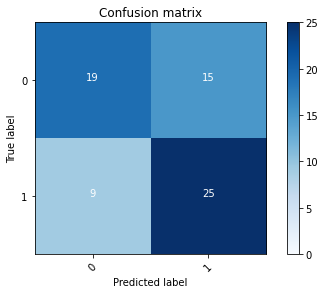

2022-08-03 20:22:22 - [Epoch Train: 15] loss: 0.0144, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:22:22 - [Epoch Valid: 15] loss: 0.9819, auc: 0.7024, acc: 0.6471, time: 7.00 s


 10%|████                                    | 15/150 [07:52<1:09:58, 31.10s/it]

2022-08-03 20:22:22 - EPOCH: 16
2022-08-03 20:22:26 - Train Step 10/60, train_loss: 0.0107
2022-08-03 20:22:30 - Train Step 20/60, train_loss: 0.0114
2022-08-03 20:22:34 - Train Step 30/60, train_loss: 0.0115
2022-08-03 20:22:38 - Train Step 40/60, train_loss: 0.0114
2022-08-03 20:22:41 - Train Step 50/60, train_loss: 0.0115
2022-08-03 20:22:45 - Train Step 60/60, train_loss: 0.0120
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:22:48 - Valid Step 5/17, valid_loss: 1.5342
2022-08-03 20:22:50 - Valid Step 10/17, valid_loss: 1.1058
2022-08-03 20:22:52 - Valid Step 15/17, valid_loss: 1.0558
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
46  UPENN-GBM-00092_11_T1w                0           1
17  UPENN-GBM-00093_11_T1w                0           0
11  UPENN-GBM-00094_11_T1w                0           1
30  UPENN-GBM-00115_11_T1w                1           1
18  UPENN-GBM-00117_11_T1w                0           1
50  UPENN-GBM-00128_11_T1w        

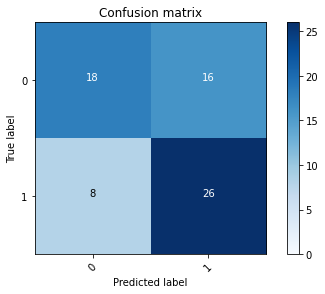

2022-08-03 20:22:53 - [Epoch Train: 16] loss: 0.0120, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:22:53 - [Epoch Valid: 16] loss: 1.0178, auc: 0.7102, acc: 0.6471, time: 7.00 s


 11%|████▎                                   | 16/150 [08:23<1:09:36, 31.17s/it]

2022-08-03 20:22:53 - EPOCH: 17
2022-08-03 20:22:57 - Train Step 10/60, train_loss: 0.0102
2022-08-03 20:23:01 - Train Step 20/60, train_loss: 0.0123
2022-08-03 20:23:05 - Train Step 30/60, train_loss: 0.0118
2022-08-03 20:23:09 - Train Step 40/60, train_loss: 0.0118
2022-08-03 20:23:13 - Train Step 50/60, train_loss: 0.0110
2022-08-03 20:23:17 - Train Step 60/60, train_loss: 0.0108
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:23:19 - Valid Step 5/17, valid_loss: 1.2438
2022-08-03 20:23:21 - Valid Step 10/17, valid_loss: 0.9546
2022-08-03 20:23:23 - Valid Step 15/17, valid_loss: 1.1171
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
17  UPENN-GBM-00092_11_T1w                0           1
48  UPENN-GBM-00093_11_T1w                0           0
47  UPENN-GBM-00094_11_T1w                0           1
52  UPENN-GBM-00115_11_T1w                1           1
3   UPENN-GBM-00117_11_T1w                0           1
59  UPENN-GBM-00128_11_T1w        

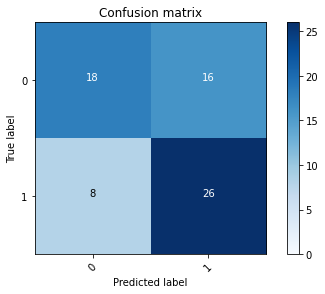

2022-08-03 20:23:24 - [Epoch Train: 17] loss: 0.0108, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:23:24 - [Epoch Valid: 17] loss: 1.0588, auc: 0.7024, acc: 0.6471, time: 7.00 s


 11%|████▌                                   | 17/150 [08:54<1:09:13, 31.23s/it]

2022-08-03 20:23:24 - EPOCH: 18
2022-08-03 20:23:29 - Train Step 10/60, train_loss: 0.0096
2022-08-03 20:23:33 - Train Step 20/60, train_loss: 0.0090
2022-08-03 20:23:37 - Train Step 30/60, train_loss: 0.0090
2022-08-03 20:23:40 - Train Step 40/60, train_loss: 0.0101
2022-08-03 20:23:44 - Train Step 50/60, train_loss: 0.0102
2022-08-03 20:23:48 - Train Step 60/60, train_loss: 0.0105
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:23:51 - Valid Step 5/17, valid_loss: 0.9951
2022-08-03 20:23:52 - Valid Step 10/17, valid_loss: 0.8717
2022-08-03 20:23:55 - Valid Step 15/17, valid_loss: 0.9031
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
3   UPENN-GBM-00092_11_T1w                0           1
51  UPENN-GBM-00093_11_T1w                0           0
42  UPENN-GBM-00094_11_T1w                0           1
10  UPENN-GBM-00115_11_T1w                1           1
13  UPENN-GBM-00117_11_T1w                0           1
36  UPENN-GBM-00128_11_T1w        

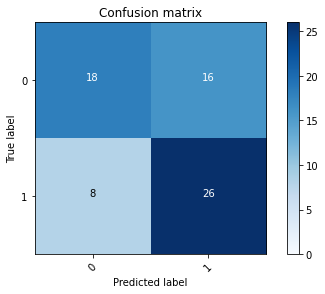

2022-08-03 20:23:55 - [Epoch Train: 18] loss: 0.0105, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:23:55 - [Epoch Valid: 18] loss: 1.0736, auc: 0.7042, acc: 0.6471, time: 7.00 s


 12%|████▊                                   | 18/150 [09:25<1:08:32, 31.15s/it]

2022-08-03 20:23:55 - EPOCH: 19
2022-08-03 20:24:00 - Train Step 10/60, train_loss: 0.0054
2022-08-03 20:24:03 - Train Step 20/60, train_loss: 0.0060
2022-08-03 20:24:07 - Train Step 30/60, train_loss: 0.0061
2022-08-03 20:24:11 - Train Step 40/60, train_loss: 0.0066
2022-08-03 20:24:15 - Train Step 50/60, train_loss: 0.0075
2022-08-03 20:24:18 - Train Step 60/60, train_loss: 0.0079
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:24:21 - Valid Step 5/17, valid_loss: 1.1150
2022-08-03 20:24:23 - Valid Step 10/17, valid_loss: 0.9066
2022-08-03 20:24:25 - Valid Step 15/17, valid_loss: 1.1493
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
25  UPENN-GBM-00092_11_T1w                0           1
59  UPENN-GBM-00093_11_T1w                0           0
55  UPENN-GBM-00094_11_T1w                0           1
33  UPENN-GBM-00115_11_T1w                1           1
7   UPENN-GBM-00117_11_T1w                0           1
62  UPENN-GBM-00128_11_T1w        

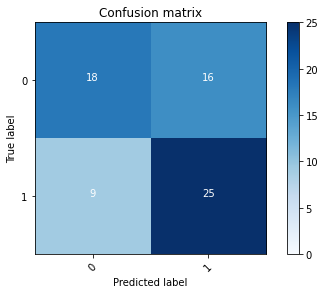

2022-08-03 20:24:26 - [Epoch Train: 19] loss: 0.0079, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:24:26 - [Epoch Valid: 19] loss: 1.0537, auc: 0.7042, acc: 0.6324, time: 7.00 s


 13%|█████                                   | 19/150 [09:56<1:07:49, 31.07s/it]

2022-08-03 20:24:26 - EPOCH: 20
2022-08-03 20:24:31 - Train Step 10/60, train_loss: 0.0088
2022-08-03 20:24:35 - Train Step 20/60, train_loss: 0.0095
2022-08-03 20:24:38 - Train Step 30/60, train_loss: 0.0089
2022-08-03 20:24:42 - Train Step 40/60, train_loss: 0.0083
2022-08-03 20:24:46 - Train Step 50/60, train_loss: 0.0081
2022-08-03 20:24:50 - Train Step 60/60, train_loss: 0.0078
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:24:53 - Valid Step 5/17, valid_loss: 0.7094
2022-08-03 20:24:54 - Valid Step 10/17, valid_loss: 1.2121
2022-08-03 20:24:57 - Valid Step 15/17, valid_loss: 1.1067
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
21  UPENN-GBM-00092_11_T1w                0           1
8   UPENN-GBM-00093_11_T1w                0           0
53  UPENN-GBM-00094_11_T1w                0           1
47  UPENN-GBM-00115_11_T1w                1           1
20  UPENN-GBM-00117_11_T1w                0           1
38  UPENN-GBM-00128_11_T1w        

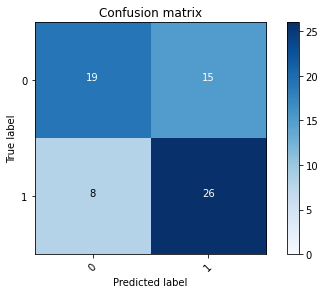

2022-08-03 20:24:58 - [Epoch Train: 20] loss: 0.0078, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 20:24:58 - [Epoch Valid: 20] loss: 1.0905, auc: 0.7042, acc: 0.6618, time: 7.00 s
2022-08-03 20:24:58 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e20-loss1.090-acc0.662-auc0.704.pth'


 13%|█████▎                                  | 20/150 [10:28<1:07:29, 31.15s/it]

2022-08-03 20:24:58 - EPOCH: 21
2022-08-03 20:25:02 - Train Step 10/60, train_loss: 0.0062
2022-08-03 20:25:06 - Train Step 20/60, train_loss: 0.0062
2022-08-03 20:25:09 - Train Step 30/60, train_loss: 0.0059
2022-08-03 20:25:13 - Train Step 40/60, train_loss: 0.0065
2022-08-03 20:25:17 - Train Step 50/60, train_loss: 0.0062
2022-08-03 20:25:20 - Train Step 60/60, train_loss: 0.0064
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:25:23 - Valid Step 5/17, valid_loss: 1.0550
2022-08-03 20:25:25 - Valid Step 10/17, valid_loss: 1.0434
2022-08-03 20:25:27 - Valid Step 15/17, valid_loss: 1.0924
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
39  UPENN-GBM-00092_11_T1w                0           1
21  UPENN-GBM-00093_11_T1w                0           0
4   UPENN-GBM-00094_11_T1w                0           1
15  UPENN-GBM-00115_11_T1w                1           1
57  UPENN-GBM-00117_11_T1w                0           1
53  UPENN-GBM-00128_11_T1w        

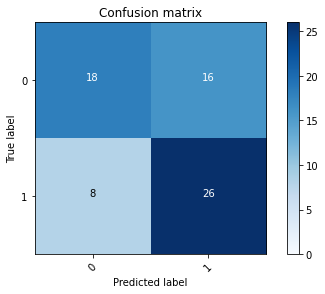

2022-08-03 20:25:28 - [Epoch Train: 21] loss: 0.0064, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:25:28 - [Epoch Valid: 21] loss: 1.1228, auc: 0.7067, acc: 0.6471, time: 7.00 s


 14%|█████▌                                  | 21/150 [10:58<1:06:20, 30.86s/it]

2022-08-03 20:25:28 - EPOCH: 22
2022-08-03 20:25:32 - Train Step 10/60, train_loss: 0.0050
2022-08-03 20:25:36 - Train Step 20/60, train_loss: 0.0056
2022-08-03 20:25:40 - Train Step 30/60, train_loss: 0.0054
2022-08-03 20:25:43 - Train Step 40/60, train_loss: 0.0057
2022-08-03 20:25:47 - Train Step 50/60, train_loss: 0.0060
2022-08-03 20:25:51 - Train Step 60/60, train_loss: 0.0058
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:25:54 - Valid Step 5/17, valid_loss: 1.6748
2022-08-03 20:25:55 - Valid Step 10/17, valid_loss: 1.2312
2022-08-03 20:25:58 - Valid Step 15/17, valid_loss: 1.2520
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
38  UPENN-GBM-00092_11_T1w                0           1
11  UPENN-GBM-00093_11_T1w                0           0
62  UPENN-GBM-00094_11_T1w                0           1
44  UPENN-GBM-00115_11_T1w                1           1
5   UPENN-GBM-00117_11_T1w                0           1
14  UPENN-GBM-00128_11_T1w        

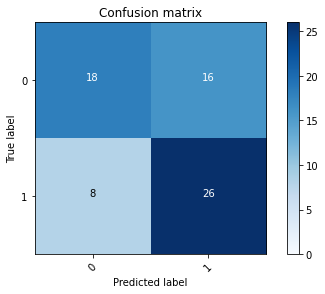

2022-08-03 20:25:59 - [Epoch Train: 22] loss: 0.0058, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:25:59 - [Epoch Valid: 22] loss: 1.1471, auc: 0.7024, acc: 0.6471, time: 7.00 s


 15%|█████▊                                  | 22/150 [11:28<1:05:45, 30.83s/it]

2022-08-03 20:25:59 - EPOCH: 23
2022-08-03 20:26:03 - Train Step 10/60, train_loss: 0.0051
2022-08-03 20:26:07 - Train Step 20/60, train_loss: 0.0048
2022-08-03 20:26:11 - Train Step 30/60, train_loss: 0.0047
2022-08-03 20:26:14 - Train Step 40/60, train_loss: 0.0046
2022-08-03 20:26:18 - Train Step 50/60, train_loss: 0.0048
2022-08-03 20:26:22 - Train Step 60/60, train_loss: 0.0068
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:26:25 - Valid Step 5/17, valid_loss: 0.9440
2022-08-03 20:26:27 - Valid Step 10/17, valid_loss: 1.1585
2022-08-03 20:26:29 - Valid Step 15/17, valid_loss: 1.2590
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
59  UPENN-GBM-00092_11_T1w                0           1
12  UPENN-GBM-00093_11_T1w                0           0
20  UPENN-GBM-00094_11_T1w                0           1
34  UPENN-GBM-00115_11_T1w                1           1
31  UPENN-GBM-00117_11_T1w                0           1
65  UPENN-GBM-00128_11_T1w        

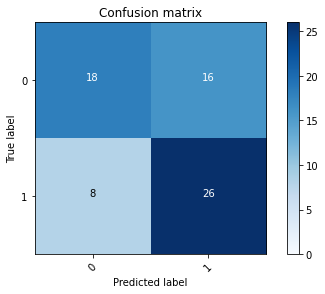

2022-08-03 20:26:30 - [Epoch Train: 23] loss: 0.0068, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:26:30 - [Epoch Valid: 23] loss: 1.1559, auc: 0.7137, acc: 0.6471, time: 7.00 s


 15%|██████▏                                 | 23/150 [12:00<1:05:37, 31.00s/it]

2022-08-03 20:26:30 - EPOCH: 24
2022-08-03 20:26:34 - Train Step 10/60, train_loss: 0.0077
2022-08-03 20:26:38 - Train Step 20/60, train_loss: 0.0071
2022-08-03 20:26:42 - Train Step 30/60, train_loss: 0.0064
2022-08-03 20:26:46 - Train Step 40/60, train_loss: 0.0059
2022-08-03 20:26:50 - Train Step 50/60, train_loss: 0.0057
2022-08-03 20:26:53 - Train Step 60/60, train_loss: 0.0057
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:26:56 - Valid Step 5/17, valid_loss: 1.4701
2022-08-03 20:26:58 - Valid Step 10/17, valid_loss: 0.9763
2022-08-03 20:27:00 - Valid Step 15/17, valid_loss: 1.2061
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
0   UPENN-GBM-00092_11_T1w                0           1
25  UPENN-GBM-00093_11_T1w                0           0
65  UPENN-GBM-00094_11_T1w                0           1
44  UPENN-GBM-00115_11_T1w                1           1
41  UPENN-GBM-00117_11_T1w                0           1
63  UPENN-GBM-00128_11_T1w        

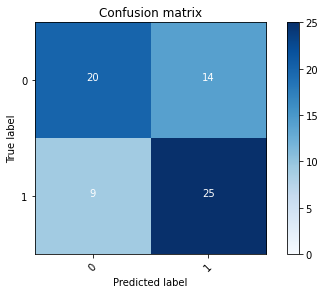

2022-08-03 20:27:01 - [Epoch Train: 24] loss: 0.0057, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:27:01 - [Epoch Valid: 24] loss: 1.1284, auc: 0.7085, acc: 0.6618, time: 7.00 s
2022-08-03 20:27:01 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e24-loss1.128-acc0.662-auc0.708.pth'


 16%|██████▍                                 | 24/150 [12:31<1:05:04, 30.98s/it]

2022-08-03 20:27:01 - EPOCH: 25
2022-08-03 20:27:05 - Train Step 10/60, train_loss: 0.0038
2022-08-03 20:27:09 - Train Step 20/60, train_loss: 0.0037
2022-08-03 20:27:13 - Train Step 30/60, train_loss: 0.0042
2022-08-03 20:27:17 - Train Step 40/60, train_loss: 0.0044
2022-08-03 20:27:21 - Train Step 50/60, train_loss: 0.0042
2022-08-03 20:27:25 - Train Step 60/60, train_loss: 0.0047
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:27:27 - Valid Step 5/17, valid_loss: 1.1555
2022-08-03 20:27:29 - Valid Step 10/17, valid_loss: 1.2654
2022-08-03 20:27:31 - Valid Step 15/17, valid_loss: 1.1452
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
37  UPENN-GBM-00092_11_T1w                0           1
6   UPENN-GBM-00093_11_T1w                0           0
19  UPENN-GBM-00094_11_T1w                0           1
35  UPENN-GBM-00115_11_T1w                1           1
28  UPENN-GBM-00117_11_T1w                0           1
55  UPENN-GBM-00128_11_T1w        

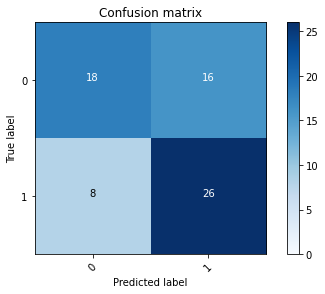

2022-08-03 20:27:32 - [Epoch Train: 25] loss: 0.0047, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:27:32 - [Epoch Valid: 25] loss: 1.1716, auc: 0.7067, acc: 0.6471, time: 7.00 s


 17%|██████▋                                 | 25/150 [13:02<1:04:48, 31.11s/it]

2022-08-03 20:27:32 - EPOCH: 26
2022-08-03 20:27:37 - Train Step 10/60, train_loss: 0.0042
2022-08-03 20:27:40 - Train Step 20/60, train_loss: 0.0037
2022-08-03 20:27:44 - Train Step 30/60, train_loss: 0.0035
2022-08-03 20:27:48 - Train Step 40/60, train_loss: 0.0034
2022-08-03 20:27:52 - Train Step 50/60, train_loss: 0.0037
2022-08-03 20:27:55 - Train Step 60/60, train_loss: 0.0035
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:27:58 - Valid Step 5/17, valid_loss: 2.1345
2022-08-03 20:28:00 - Valid Step 10/17, valid_loss: 1.4626
2022-08-03 20:28:02 - Valid Step 15/17, valid_loss: 1.3006
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
49  UPENN-GBM-00092_11_T1w                0           1
31  UPENN-GBM-00093_11_T1w                0           0
11  UPENN-GBM-00094_11_T1w                0           1
15  UPENN-GBM-00115_11_T1w                1           1
37  UPENN-GBM-00117_11_T1w                0           1
28  UPENN-GBM-00128_11_T1w        

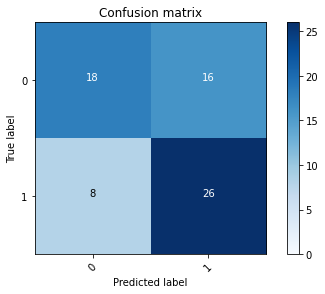

2022-08-03 20:28:03 - [Epoch Train: 26] loss: 0.0035, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:28:03 - [Epoch Valid: 26] loss: 1.2495, auc: 0.7059, acc: 0.6471, time: 7.00 s


 17%|██████▉                                 | 26/150 [13:33<1:04:08, 31.04s/it]

2022-08-03 20:28:03 - EPOCH: 27
2022-08-03 20:28:07 - Train Step 10/60, train_loss: 0.0034
2022-08-03 20:28:11 - Train Step 20/60, train_loss: 0.0035
2022-08-03 20:28:15 - Train Step 30/60, train_loss: 0.0033
2022-08-03 20:28:19 - Train Step 40/60, train_loss: 0.0033
2022-08-03 20:28:23 - Train Step 50/60, train_loss: 0.0033
2022-08-03 20:28:27 - Train Step 60/60, train_loss: 0.0033
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:28:30 - Valid Step 5/17, valid_loss: 1.1005
2022-08-03 20:28:32 - Valid Step 10/17, valid_loss: 1.2172
2022-08-03 20:28:34 - Valid Step 15/17, valid_loss: 1.1974
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
42  UPENN-GBM-00092_11_T1w                0           1
31  UPENN-GBM-00093_11_T1w                0           0
4   UPENN-GBM-00094_11_T1w                0           1
19  UPENN-GBM-00115_11_T1w                1           1
13  UPENN-GBM-00117_11_T1w                0           1
21  UPENN-GBM-00128_11_T1w        

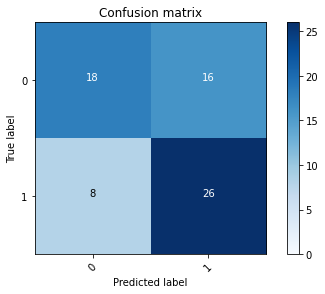

2022-08-03 20:28:35 - [Epoch Train: 27] loss: 0.0033, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 20:28:35 - [Epoch Valid: 27] loss: 1.2459, auc: 0.7085, acc: 0.6471, time: 7.00 s


 18%|███████▏                                | 27/150 [14:05<1:04:04, 31.26s/it]

2022-08-03 20:28:35 - EPOCH: 28
2022-08-03 20:28:39 - Train Step 10/60, train_loss: 0.0028
2022-08-03 20:28:43 - Train Step 20/60, train_loss: 0.0031
2022-08-03 20:28:47 - Train Step 30/60, train_loss: 0.0032
2022-08-03 20:28:51 - Train Step 40/60, train_loss: 0.0031
2022-08-03 20:28:55 - Train Step 50/60, train_loss: 0.0031
2022-08-03 20:28:58 - Train Step 60/60, train_loss: 0.0030
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:29:01 - Valid Step 5/17, valid_loss: 1.9015
2022-08-03 20:29:03 - Valid Step 10/17, valid_loss: 1.4116
2022-08-03 20:29:05 - Valid Step 15/17, valid_loss: 1.2234
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
55  UPENN-GBM-00092_11_T1w                0           1
44  UPENN-GBM-00093_11_T1w                0           0
14  UPENN-GBM-00094_11_T1w                0           1
4   UPENN-GBM-00115_11_T1w                1           1
22  UPENN-GBM-00117_11_T1w                0           1
50  UPENN-GBM-00128_11_T1w        

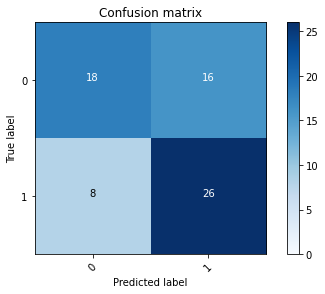

2022-08-03 20:29:06 - [Epoch Train: 28] loss: 0.0030, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:29:06 - [Epoch Valid: 28] loss: 1.2253, auc: 0.7076, acc: 0.6471, time: 7.00 s


 19%|███████▍                                | 28/150 [14:36<1:03:36, 31.29s/it]

2022-08-03 20:29:06 - EPOCH: 29
2022-08-03 20:29:11 - Train Step 10/60, train_loss: 0.0043
2022-08-03 20:29:14 - Train Step 20/60, train_loss: 0.0040
2022-08-03 20:29:18 - Train Step 30/60, train_loss: 0.0036
2022-08-03 20:29:22 - Train Step 40/60, train_loss: 0.0034
2022-08-03 20:29:26 - Train Step 50/60, train_loss: 0.0032
2022-08-03 20:29:30 - Train Step 60/60, train_loss: 0.0031
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:29:33 - Valid Step 5/17, valid_loss: 0.6749
2022-08-03 20:29:35 - Valid Step 10/17, valid_loss: 1.0832
2022-08-03 20:29:37 - Valid Step 15/17, valid_loss: 1.3356
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
14  UPENN-GBM-00092_11_T1w                0           1
6   UPENN-GBM-00093_11_T1w                0           0
19  UPENN-GBM-00094_11_T1w                0           1
27  UPENN-GBM-00115_11_T1w                1           1
34  UPENN-GBM-00117_11_T1w                0           1
41  UPENN-GBM-00128_11_T1w        

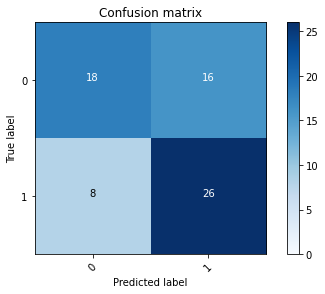

2022-08-03 20:29:38 - [Epoch Train: 29] loss: 0.0031, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:29:38 - [Epoch Valid: 29] loss: 1.2765, auc: 0.7093, acc: 0.6471, time: 7.00 s


 19%|███████▋                                | 29/150 [15:08<1:03:15, 31.37s/it]

2022-08-03 20:29:38 - EPOCH: 30
2022-08-03 20:29:42 - Train Step 10/60, train_loss: 0.0020
2022-08-03 20:29:46 - Train Step 20/60, train_loss: 0.0021
2022-08-03 20:29:50 - Train Step 30/60, train_loss: 0.0022
2022-08-03 20:29:54 - Train Step 40/60, train_loss: 0.0023
2022-08-03 20:29:57 - Train Step 50/60, train_loss: 0.0024
2022-08-03 20:30:01 - Train Step 60/60, train_loss: 0.0026
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:30:04 - Valid Step 5/17, valid_loss: 1.5741
2022-08-03 20:30:05 - Valid Step 10/17, valid_loss: 1.5394
2022-08-03 20:30:08 - Valid Step 15/17, valid_loss: 1.3131
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
50  UPENN-GBM-00092_11_T1w                0           1
5   UPENN-GBM-00093_11_T1w                0           0
37  UPENN-GBM-00094_11_T1w                0           1
21  UPENN-GBM-00115_11_T1w                1           1
7   UPENN-GBM-00117_11_T1w                0           1
38  UPENN-GBM-00128_11_T1w        

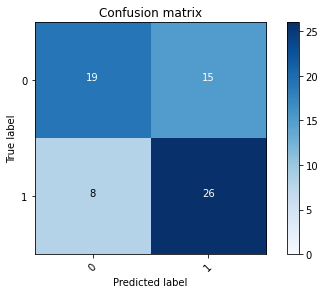

2022-08-03 20:30:09 - [Epoch Train: 30] loss: 0.0026, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:30:09 - [Epoch Valid: 30] loss: 1.2340, auc: 0.7076, acc: 0.6618, time: 7.00 s
2022-08-03 20:30:09 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e30-loss1.234-acc0.662-auc0.708.pth'


 20%|████████                                | 30/150 [15:39<1:02:22, 31.19s/it]

2022-08-03 20:30:09 - EPOCH: 31
2022-08-03 20:30:13 - Train Step 10/60, train_loss: 0.0015
2022-08-03 20:30:17 - Train Step 20/60, train_loss: 0.0017
2022-08-03 20:30:21 - Train Step 30/60, train_loss: 0.0019
2022-08-03 20:30:25 - Train Step 40/60, train_loss: 0.0018
2022-08-03 20:30:29 - Train Step 50/60, train_loss: 0.0019
2022-08-03 20:30:32 - Train Step 60/60, train_loss: 0.0019
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:30:35 - Valid Step 5/17, valid_loss: 1.5487
2022-08-03 20:30:37 - Valid Step 10/17, valid_loss: 1.4582
2022-08-03 20:30:39 - Valid Step 15/17, valid_loss: 1.2219
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
6   UPENN-GBM-00092_11_T1w                0           1
1   UPENN-GBM-00093_11_T1w                0           0
26  UPENN-GBM-00094_11_T1w                0           1
28  UPENN-GBM-00115_11_T1w                1           1
14  UPENN-GBM-00117_11_T1w                0           1
49  UPENN-GBM-00128_11_T1w        

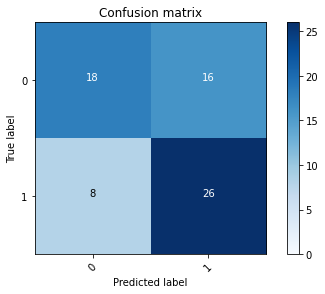

2022-08-03 20:30:40 - [Epoch Train: 31] loss: 0.0019, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:30:40 - [Epoch Valid: 31] loss: 1.2847, auc: 0.7102, acc: 0.6471, time: 7.00 s


 21%|████████▎                               | 31/150 [16:10<1:01:57, 31.24s/it]

2022-08-03 20:30:40 - EPOCH: 32
2022-08-03 20:30:44 - Train Step 10/60, train_loss: 0.0022
2022-08-03 20:30:49 - Train Step 20/60, train_loss: 0.0023
2022-08-03 20:30:53 - Train Step 30/60, train_loss: 0.0021
2022-08-03 20:30:56 - Train Step 40/60, train_loss: 0.0023
2022-08-03 20:31:00 - Train Step 50/60, train_loss: 0.0022
2022-08-03 20:31:04 - Train Step 60/60, train_loss: 0.0022
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:31:06 - Valid Step 5/17, valid_loss: 1.9048
2022-08-03 20:31:08 - Valid Step 10/17, valid_loss: 1.5076
2022-08-03 20:31:10 - Valid Step 15/17, valid_loss: 1.3133
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
53  UPENN-GBM-00092_11_T1w                0           1
25  UPENN-GBM-00093_11_T1w                0           0
26  UPENN-GBM-00094_11_T1w                0           1
5   UPENN-GBM-00115_11_T1w                1           1
56  UPENN-GBM-00117_11_T1w                0           1
34  UPENN-GBM-00128_11_T1w        

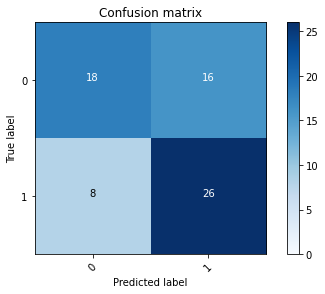

2022-08-03 20:31:11 - [Epoch Train: 32] loss: 0.0022, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 20:31:11 - [Epoch Valid: 32] loss: 1.3237, auc: 0.7128, acc: 0.6471, time: 7.00 s


 21%|████████▌                               | 32/150 [16:41<1:01:07, 31.08s/it]

2022-08-03 20:31:11 - EPOCH: 33
2022-08-03 20:31:15 - Train Step 10/60, train_loss: 0.0015
2022-08-03 20:31:18 - Train Step 20/60, train_loss: 0.0019
2022-08-03 20:31:22 - Train Step 30/60, train_loss: 0.0018
2022-08-03 20:31:25 - Train Step 40/60, train_loss: 0.0019
2022-08-03 20:31:29 - Train Step 50/60, train_loss: 0.0018
2022-08-03 20:31:32 - Train Step 60/60, train_loss: 0.0019
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:31:35 - Valid Step 5/17, valid_loss: 1.7511
2022-08-03 20:31:36 - Valid Step 10/17, valid_loss: 1.4340
2022-08-03 20:31:39 - Valid Step 15/17, valid_loss: 1.4155
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
16  UPENN-GBM-00092_11_T1w                0           1
1   UPENN-GBM-00093_11_T1w                0           0
6   UPENN-GBM-00094_11_T1w                0           1
24  UPENN-GBM-00115_11_T1w                1           1
18  UPENN-GBM-00117_11_T1w                0           1
8   UPENN-GBM-00128_11_T1w        

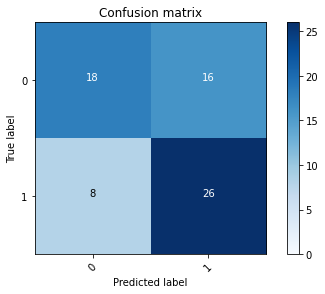

2022-08-03 20:31:39 - [Epoch Train: 33] loss: 0.0019, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:31:39 - [Epoch Valid: 33] loss: 1.3231, auc: 0.7137, acc: 0.6471, time: 6.00 s


 22%|█████████▏                                | 33/150 [17:09<59:12, 30.37s/it]

2022-08-03 20:31:39 - EPOCH: 34
2022-08-03 20:31:43 - Train Step 10/60, train_loss: 0.0013
2022-08-03 20:31:47 - Train Step 20/60, train_loss: 0.0016
2022-08-03 20:31:51 - Train Step 30/60, train_loss: 0.0017
2022-08-03 20:31:54 - Train Step 40/60, train_loss: 0.0017
2022-08-03 20:31:58 - Train Step 50/60, train_loss: 0.0018
2022-08-03 20:32:02 - Train Step 60/60, train_loss: 0.0018
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:32:04 - Valid Step 5/17, valid_loss: 1.3128
2022-08-03 20:32:06 - Valid Step 10/17, valid_loss: 1.1321
2022-08-03 20:32:08 - Valid Step 15/17, valid_loss: 1.3733
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
22  UPENN-GBM-00092_11_T1w                0           1
43  UPENN-GBM-00093_11_T1w                0           0
36  UPENN-GBM-00094_11_T1w                0           1
21  UPENN-GBM-00115_11_T1w                1           1
67  UPENN-GBM-00117_11_T1w                0           1
63  UPENN-GBM-00128_11_T1w        

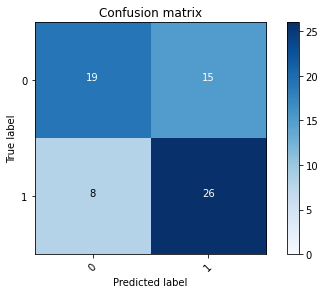

2022-08-03 20:32:09 - [Epoch Train: 34] loss: 0.0018, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:32:09 - [Epoch Valid: 34] loss: 1.2744, auc: 0.7128, acc: 0.6618, time: 6.00 s
2022-08-03 20:32:09 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e34-loss1.274-acc0.662-auc0.713.pth'


 23%|█████████▌                                | 34/150 [17:39<58:02, 30.02s/it]

2022-08-03 20:32:09 - EPOCH: 35
2022-08-03 20:32:13 - Train Step 10/60, train_loss: 0.0019
2022-08-03 20:32:16 - Train Step 20/60, train_loss: 0.0015
2022-08-03 20:32:20 - Train Step 30/60, train_loss: 0.0015
2022-08-03 20:32:24 - Train Step 40/60, train_loss: 0.0015
2022-08-03 20:32:27 - Train Step 50/60, train_loss: 0.0014
2022-08-03 20:32:31 - Train Step 60/60, train_loss: 0.0014
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:32:33 - Valid Step 5/17, valid_loss: 1.0639
2022-08-03 20:32:35 - Valid Step 10/17, valid_loss: 1.5909
2022-08-03 20:32:37 - Valid Step 15/17, valid_loss: 1.1698
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
35  UPENN-GBM-00092_11_T1w                0           1
57  UPENN-GBM-00093_11_T1w                0           0
18  UPENN-GBM-00094_11_T1w                0           1
40  UPENN-GBM-00115_11_T1w                1           1
10  UPENN-GBM-00117_11_T1w                0           1
8   UPENN-GBM-00128_11_T1w        

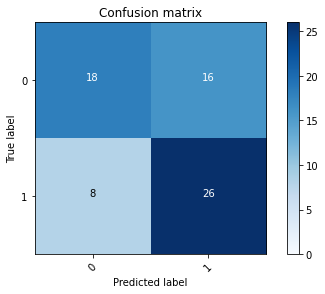

2022-08-03 20:32:38 - [Epoch Train: 35] loss: 0.0014, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:32:38 - [Epoch Valid: 35] loss: 1.3477, auc: 0.7145, acc: 0.6471, time: 6.00 s


 23%|█████████▊                                | 35/150 [18:08<57:10, 29.83s/it]

2022-08-03 20:32:38 - EPOCH: 36
2022-08-03 20:32:42 - Train Step 10/60, train_loss: 0.0015
2022-08-03 20:32:46 - Train Step 20/60, train_loss: 0.0018
2022-08-03 20:32:49 - Train Step 30/60, train_loss: 0.0015
2022-08-03 20:32:53 - Train Step 40/60, train_loss: 0.0014
2022-08-03 20:32:57 - Train Step 50/60, train_loss: 0.0014
2022-08-03 20:33:00 - Train Step 60/60, train_loss: 0.0017
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:33:03 - Valid Step 5/17, valid_loss: 0.8002
2022-08-03 20:33:04 - Valid Step 10/17, valid_loss: 0.8470
2022-08-03 20:33:06 - Valid Step 15/17, valid_loss: 1.4913
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
10  UPENN-GBM-00092_11_T1w                0           1
2   UPENN-GBM-00093_11_T1w                0           0
59  UPENN-GBM-00094_11_T1w                0           1
44  UPENN-GBM-00115_11_T1w                1           1
11  UPENN-GBM-00117_11_T1w                0           1
23  UPENN-GBM-00128_11_T1w        

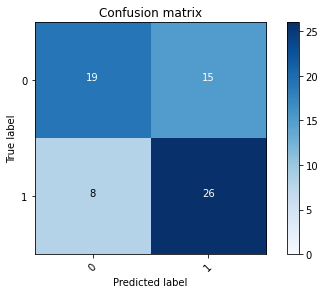

2022-08-03 20:33:07 - [Epoch Train: 36] loss: 0.0017, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:33:07 - [Epoch Valid: 36] loss: 1.3236, auc: 0.7111, acc: 0.6618, time: 6.00 s
2022-08-03 20:33:07 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e36-loss1.324-acc0.662-auc0.711.pth'


 24%|██████████                                | 36/150 [18:37<56:20, 29.66s/it]

2022-08-03 20:33:07 - EPOCH: 37
2022-08-03 20:33:11 - Train Step 10/60, train_loss: 0.0016
2022-08-03 20:33:15 - Train Step 20/60, train_loss: 0.0014
2022-08-03 20:33:18 - Train Step 30/60, train_loss: 0.0013
2022-08-03 20:33:22 - Train Step 40/60, train_loss: 0.0013
2022-08-03 20:33:26 - Train Step 50/60, train_loss: 0.0013
2022-08-03 20:33:29 - Train Step 60/60, train_loss: 0.0013
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:33:32 - Valid Step 5/17, valid_loss: 1.4136
2022-08-03 20:33:33 - Valid Step 10/17, valid_loss: 1.6581
2022-08-03 20:33:36 - Valid Step 15/17, valid_loss: 1.4353
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
38  UPENN-GBM-00092_11_T1w                0           1
19  UPENN-GBM-00093_11_T1w                0           0
32  UPENN-GBM-00094_11_T1w                0           1
29  UPENN-GBM-00115_11_T1w                1           1
41  UPENN-GBM-00117_11_T1w                0           1
42  UPENN-GBM-00128_11_T1w        

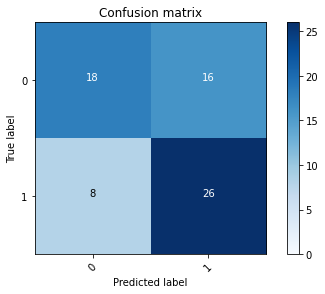

2022-08-03 20:33:37 - [Epoch Train: 37] loss: 0.0013, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:33:37 - [Epoch Valid: 37] loss: 1.3486, auc: 0.7111, acc: 0.6471, time: 7.00 s


 25%|██████████▎                               | 37/150 [19:06<55:38, 29.55s/it]

2022-08-03 20:33:37 - EPOCH: 38
2022-08-03 20:33:40 - Train Step 10/60, train_loss: 0.0013
2022-08-03 20:33:44 - Train Step 20/60, train_loss: 0.0013
2022-08-03 20:33:47 - Train Step 30/60, train_loss: 0.0012
2022-08-03 20:33:51 - Train Step 40/60, train_loss: 0.0012
2022-08-03 20:33:54 - Train Step 50/60, train_loss: 0.0014
2022-08-03 20:33:57 - Train Step 60/60, train_loss: 0.0014
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:34:00 - Valid Step 5/17, valid_loss: 0.7438
2022-08-03 20:34:01 - Valid Step 10/17, valid_loss: 1.2940
2022-08-03 20:34:04 - Valid Step 15/17, valid_loss: 1.3127
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
65  UPENN-GBM-00092_11_T1w                0           1
60  UPENN-GBM-00093_11_T1w                0           0
64  UPENN-GBM-00094_11_T1w                0           1
38  UPENN-GBM-00115_11_T1w                1           1
57  UPENN-GBM-00117_11_T1w                0           1
34  UPENN-GBM-00128_11_T1w        

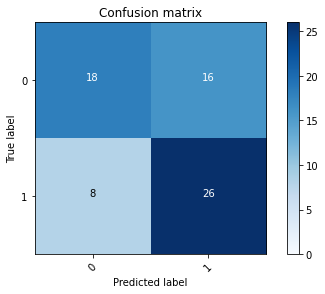

2022-08-03 20:34:04 - [Epoch Train: 38] loss: 0.0014, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:34:04 - [Epoch Valid: 38] loss: 1.3613, auc: 0.7093, acc: 0.6471, time: 6.00 s


 25%|██████████▋                               | 38/150 [19:34<54:16, 29.07s/it]

2022-08-03 20:34:04 - EPOCH: 39
2022-08-03 20:34:08 - Train Step 10/60, train_loss: 0.0011
2022-08-03 20:34:12 - Train Step 20/60, train_loss: 0.0012
2022-08-03 20:34:15 - Train Step 30/60, train_loss: 0.0012
2022-08-03 20:34:19 - Train Step 40/60, train_loss: 0.0012
2022-08-03 20:34:22 - Train Step 50/60, train_loss: 0.0012
2022-08-03 20:34:26 - Train Step 60/60, train_loss: 0.0012
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:34:28 - Valid Step 5/17, valid_loss: 1.2987
2022-08-03 20:34:30 - Valid Step 10/17, valid_loss: 1.5783
2022-08-03 20:34:32 - Valid Step 15/17, valid_loss: 1.3811
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
11  UPENN-GBM-00092_11_T1w                0           1
28  UPENN-GBM-00093_11_T1w                0           0
12  UPENN-GBM-00094_11_T1w                0           1
9   UPENN-GBM-00115_11_T1w                1           1
15  UPENN-GBM-00117_11_T1w                0           1
24  UPENN-GBM-00128_11_T1w        

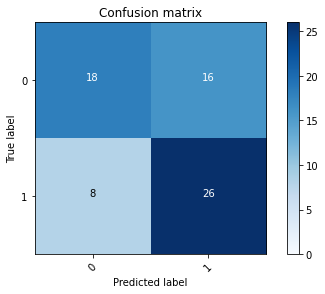

2022-08-03 20:34:33 - [Epoch Train: 39] loss: 0.0012, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:34:33 - [Epoch Valid: 39] loss: 1.4112, auc: 0.7085, acc: 0.6471, time: 6.00 s


 26%|██████████▉                               | 39/150 [20:03<53:26, 28.89s/it]

2022-08-03 20:34:33 - EPOCH: 40
2022-08-03 20:34:37 - Train Step 10/60, train_loss: 0.0016
2022-08-03 20:34:40 - Train Step 20/60, train_loss: 0.0013
2022-08-03 20:34:44 - Train Step 30/60, train_loss: 0.0012
2022-08-03 20:34:48 - Train Step 40/60, train_loss: 0.0013
2022-08-03 20:34:51 - Train Step 50/60, train_loss: 0.0012
2022-08-03 20:34:55 - Train Step 60/60, train_loss: 0.0012
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:34:57 - Valid Step 5/17, valid_loss: 1.7440
2022-08-03 20:34:59 - Valid Step 10/17, valid_loss: 1.5356
2022-08-03 20:35:01 - Valid Step 15/17, valid_loss: 1.3423
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
13  UPENN-GBM-00092_11_T1w                0           1
19  UPENN-GBM-00093_11_T1w                0           0
16  UPENN-GBM-00094_11_T1w                0           1
61  UPENN-GBM-00115_11_T1w                1           1
14  UPENN-GBM-00117_11_T1w                0           1
22  UPENN-GBM-00128_11_T1w        

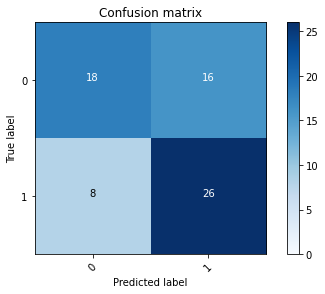

2022-08-03 20:35:02 - [Epoch Train: 40] loss: 0.0012, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:35:02 - [Epoch Valid: 40] loss: 1.3408, auc: 0.7128, acc: 0.6471, time: 7.00 s


 27%|███████████▏                              | 40/150 [20:32<53:13, 29.03s/it]

2022-08-03 20:35:02 - EPOCH: 41
2022-08-03 20:35:06 - Train Step 10/60, train_loss: 0.0008
2022-08-03 20:35:10 - Train Step 20/60, train_loss: 0.0009
2022-08-03 20:35:14 - Train Step 30/60, train_loss: 0.0010
2022-08-03 20:35:17 - Train Step 40/60, train_loss: 0.0010
2022-08-03 20:35:21 - Train Step 50/60, train_loss: 0.0010
2022-08-03 20:35:24 - Train Step 60/60, train_loss: 0.0011
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:35:27 - Valid Step 5/17, valid_loss: 1.3160
2022-08-03 20:35:28 - Valid Step 10/17, valid_loss: 1.6875
2022-08-03 20:35:31 - Valid Step 15/17, valid_loss: 1.4096
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
21  UPENN-GBM-00092_11_T1w                0           1
51  UPENN-GBM-00093_11_T1w                0           0
22  UPENN-GBM-00094_11_T1w                0           1
14  UPENN-GBM-00115_11_T1w                1           1
50  UPENN-GBM-00117_11_T1w                0           1
48  UPENN-GBM-00128_11_T1w        

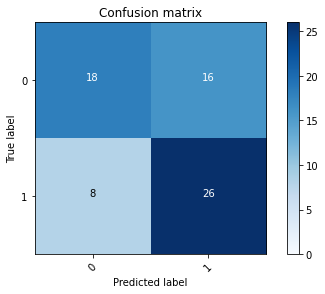

2022-08-03 20:35:31 - [Epoch Train: 41] loss: 0.0011, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:35:31 - [Epoch Valid: 41] loss: 1.3939, auc: 0.7067, acc: 0.6471, time: 6.00 s


 27%|███████████▍                              | 41/150 [21:01<52:43, 29.03s/it]

2022-08-03 20:35:31 - EPOCH: 42
2022-08-03 20:35:35 - Train Step 10/60, train_loss: 0.0011
2022-08-03 20:35:39 - Train Step 20/60, train_loss: 0.0009
2022-08-03 20:35:43 - Train Step 30/60, train_loss: 0.0008
2022-08-03 20:35:46 - Train Step 40/60, train_loss: 0.0008
2022-08-03 20:35:50 - Train Step 50/60, train_loss: 0.0008
2022-08-03 20:35:53 - Train Step 60/60, train_loss: 0.0008
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:35:56 - Valid Step 5/17, valid_loss: 2.1700
2022-08-03 20:35:58 - Valid Step 10/17, valid_loss: 1.6436
2022-08-03 20:36:00 - Valid Step 15/17, valid_loss: 1.3979
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
3   UPENN-GBM-00092_11_T1w                0           1
43  UPENN-GBM-00093_11_T1w                0           0
56  UPENN-GBM-00094_11_T1w                0           1
60  UPENN-GBM-00115_11_T1w                1           1
58  UPENN-GBM-00117_11_T1w                0           1
17  UPENN-GBM-00128_11_T1w        

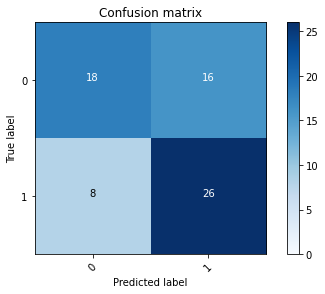

2022-08-03 20:36:01 - [Epoch Train: 42] loss: 0.0008, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:36:01 - [Epoch Valid: 42] loss: 1.3788, auc: 0.7085, acc: 0.6471, time: 7.00 s


 28%|███████████▊                              | 42/150 [21:31<52:25, 29.13s/it]

2022-08-03 20:36:01 - EPOCH: 43
2022-08-03 20:36:05 - Train Step 10/60, train_loss: 0.0011
2022-08-03 20:36:08 - Train Step 20/60, train_loss: 0.0010
2022-08-03 20:36:12 - Train Step 30/60, train_loss: 0.0010
2022-08-03 20:36:15 - Train Step 40/60, train_loss: 0.0009
2022-08-03 20:36:19 - Train Step 50/60, train_loss: 0.0009
2022-08-03 20:36:23 - Train Step 60/60, train_loss: 0.0009
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:36:25 - Valid Step 5/17, valid_loss: 1.8528
2022-08-03 20:36:27 - Valid Step 10/17, valid_loss: 1.4074
2022-08-03 20:36:29 - Valid Step 15/17, valid_loss: 1.3391
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
19  UPENN-GBM-00092_11_T1w                0           1
31  UPENN-GBM-00093_11_T1w                0           0
58  UPENN-GBM-00094_11_T1w                0           1
21  UPENN-GBM-00115_11_T1w                1           1
56  UPENN-GBM-00117_11_T1w                0           1
61  UPENN-GBM-00128_11_T1w        

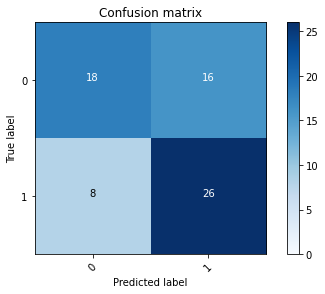

2022-08-03 20:36:30 - [Epoch Train: 43] loss: 0.0009, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:36:30 - [Epoch Valid: 43] loss: 1.4269, auc: 0.7145, acc: 0.6471, time: 7.00 s


 29%|████████████                              | 43/150 [22:00<51:54, 29.11s/it]

2022-08-03 20:36:30 - EPOCH: 44
2022-08-03 20:36:34 - Train Step 10/60, train_loss: 0.0010
2022-08-03 20:36:37 - Train Step 20/60, train_loss: 0.0009
2022-08-03 20:36:41 - Train Step 30/60, train_loss: 0.0010
2022-08-03 20:36:45 - Train Step 40/60, train_loss: 0.0009
2022-08-03 20:36:48 - Train Step 50/60, train_loss: 0.0008
2022-08-03 20:36:52 - Train Step 60/60, train_loss: 0.0008
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:36:54 - Valid Step 5/17, valid_loss: 1.5352
2022-08-03 20:36:56 - Valid Step 10/17, valid_loss: 1.6792
2022-08-03 20:36:58 - Valid Step 15/17, valid_loss: 1.4806
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
29  UPENN-GBM-00092_11_T1w                0           1
55  UPENN-GBM-00093_11_T1w                0           0
65  UPENN-GBM-00094_11_T1w                0           1
5   UPENN-GBM-00115_11_T1w                1           1
13  UPENN-GBM-00117_11_T1w                0           1
15  UPENN-GBM-00128_11_T1w        

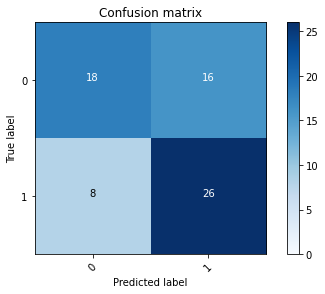

2022-08-03 20:36:59 - [Epoch Train: 44] loss: 0.0008, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:36:59 - [Epoch Valid: 44] loss: 1.4845, auc: 0.7128, acc: 0.6471, time: 6.00 s


 29%|████████████▎                             | 44/150 [22:29<51:23, 29.09s/it]

2022-08-03 20:36:59 - EPOCH: 45
2022-08-03 20:37:03 - Train Step 10/60, train_loss: 0.0007
2022-08-03 20:37:06 - Train Step 20/60, train_loss: 0.0008
2022-08-03 20:37:10 - Train Step 30/60, train_loss: 0.0008
2022-08-03 20:37:13 - Train Step 40/60, train_loss: 0.0008
2022-08-03 20:37:17 - Train Step 50/60, train_loss: 0.0008
2022-08-03 20:37:20 - Train Step 60/60, train_loss: 0.0008
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:37:23 - Valid Step 5/17, valid_loss: 1.1993
2022-08-03 20:37:24 - Valid Step 10/17, valid_loss: 1.6336
2022-08-03 20:37:27 - Valid Step 15/17, valid_loss: 1.2969
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
67  UPENN-GBM-00092_11_T1w                0           1
3   UPENN-GBM-00093_11_T1w                0           0
25  UPENN-GBM-00094_11_T1w                0           1
34  UPENN-GBM-00115_11_T1w                1           1
46  UPENN-GBM-00117_11_T1w                0           1
5   UPENN-GBM-00128_11_T1w        

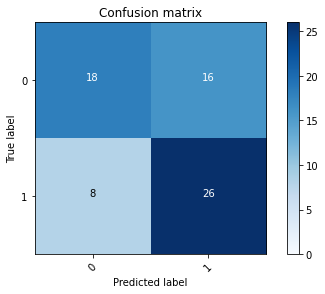

2022-08-03 20:37:27 - [Epoch Train: 45] loss: 0.0008, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:37:27 - [Epoch Valid: 45] loss: 1.4698, auc: 0.7154, acc: 0.6471, time: 7.00 s


 30%|████████████▌                             | 45/150 [22:57<50:42, 28.97s/it]

2022-08-03 20:37:27 - EPOCH: 46
2022-08-03 20:37:31 - Train Step 10/60, train_loss: 0.0007
2022-08-03 20:37:35 - Train Step 20/60, train_loss: 0.0007
2022-08-03 20:37:38 - Train Step 30/60, train_loss: 0.0007
2022-08-03 20:37:42 - Train Step 40/60, train_loss: 0.0007
2022-08-03 20:37:45 - Train Step 50/60, train_loss: 0.0008
2022-08-03 20:37:49 - Train Step 60/60, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:37:51 - Valid Step 5/17, valid_loss: 1.7555
2022-08-03 20:37:53 - Valid Step 10/17, valid_loss: 1.2772
2022-08-03 20:37:55 - Valid Step 15/17, valid_loss: 1.5637
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
10  UPENN-GBM-00092_11_T1w                0           1
27  UPENN-GBM-00093_11_T1w                0           0
29  UPENN-GBM-00094_11_T1w                0           1
46  UPENN-GBM-00115_11_T1w                1           1
44  UPENN-GBM-00117_11_T1w                0           1
59  UPENN-GBM-00128_11_T1w        

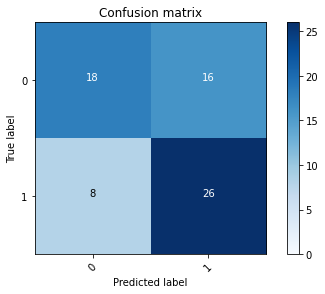

2022-08-03 20:37:56 - [Epoch Train: 46] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:37:56 - [Epoch Valid: 46] loss: 1.4958, auc: 0.7085, acc: 0.6471, time: 6.00 s


 31%|████████████▉                             | 46/150 [23:26<49:48, 28.74s/it]

2022-08-03 20:37:56 - EPOCH: 47
2022-08-03 20:38:00 - Train Step 10/60, train_loss: 0.0012
2022-08-03 20:38:03 - Train Step 20/60, train_loss: 0.0010
2022-08-03 20:38:07 - Train Step 30/60, train_loss: 0.0008
2022-08-03 20:38:10 - Train Step 40/60, train_loss: 0.0007
2022-08-03 20:38:14 - Train Step 50/60, train_loss: 0.0007
2022-08-03 20:38:18 - Train Step 60/60, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:38:20 - Valid Step 5/17, valid_loss: 1.1501
2022-08-03 20:38:22 - Valid Step 10/17, valid_loss: 1.0816
2022-08-03 20:38:24 - Valid Step 15/17, valid_loss: 1.4645
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
4   UPENN-GBM-00092_11_T1w                0           1
25  UPENN-GBM-00093_11_T1w                0           0
11  UPENN-GBM-00094_11_T1w                0           1
53  UPENN-GBM-00115_11_T1w                1           1
65  UPENN-GBM-00117_11_T1w                0           1
21  UPENN-GBM-00128_11_T1w        

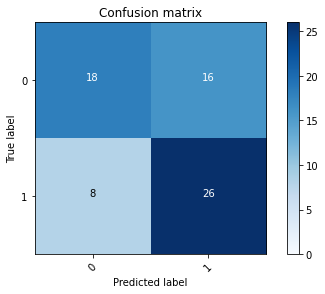

2022-08-03 20:38:25 - [Epoch Train: 47] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:38:25 - [Epoch Valid: 47] loss: 1.5317, auc: 0.7050, acc: 0.6471, time: 7.00 s


 31%|█████████████▏                            | 47/150 [23:55<49:30, 28.84s/it]

2022-08-03 20:38:25 - EPOCH: 48
2022-08-03 20:38:29 - Train Step 10/60, train_loss: 0.0007
2022-08-03 20:38:32 - Train Step 20/60, train_loss: 0.0008
2022-08-03 20:38:36 - Train Step 30/60, train_loss: 0.0008
2022-08-03 20:38:40 - Train Step 40/60, train_loss: 0.0007
2022-08-03 20:38:43 - Train Step 50/60, train_loss: 0.0007
2022-08-03 20:38:47 - Train Step 60/60, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:38:49 - Valid Step 5/17, valid_loss: 2.1633
2022-08-03 20:38:51 - Valid Step 10/17, valid_loss: 1.6252
2022-08-03 20:38:53 - Valid Step 15/17, valid_loss: 1.4572
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
10  UPENN-GBM-00092_11_T1w                0           1
13  UPENN-GBM-00093_11_T1w                0           0
56  UPENN-GBM-00094_11_T1w                0           1
66  UPENN-GBM-00115_11_T1w                1           1
22  UPENN-GBM-00117_11_T1w                0           1
60  UPENN-GBM-00128_11_T1w        

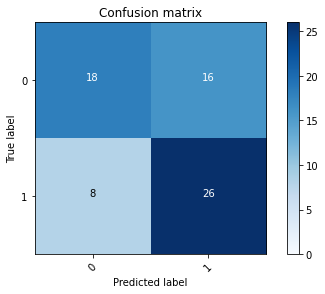

2022-08-03 20:38:54 - [Epoch Train: 48] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:38:54 - [Epoch Valid: 48] loss: 1.4926, auc: 0.7093, acc: 0.6471, time: 6.00 s


 32%|█████████████▍                            | 48/150 [24:24<49:16, 28.99s/it]

2022-08-03 20:38:54 - EPOCH: 49
2022-08-03 20:38:58 - Train Step 10/60, train_loss: 0.0008
2022-08-03 20:39:02 - Train Step 20/60, train_loss: 0.0007
2022-08-03 20:39:05 - Train Step 30/60, train_loss: 0.0007
2022-08-03 20:39:09 - Train Step 40/60, train_loss: 0.0007
2022-08-03 20:39:13 - Train Step 50/60, train_loss: 0.0006
2022-08-03 20:39:16 - Train Step 60/60, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:39:19 - Valid Step 5/17, valid_loss: 1.1980
2022-08-03 20:39:20 - Valid Step 10/17, valid_loss: 1.7963
2022-08-03 20:39:23 - Valid Step 15/17, valid_loss: 1.5651
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
46  UPENN-GBM-00092_11_T1w                0           1
26  UPENN-GBM-00093_11_T1w                0           0
35  UPENN-GBM-00094_11_T1w                0           1
12  UPENN-GBM-00115_11_T1w                1           1
30  UPENN-GBM-00117_11_T1w                0           1
41  UPENN-GBM-00128_11_T1w        

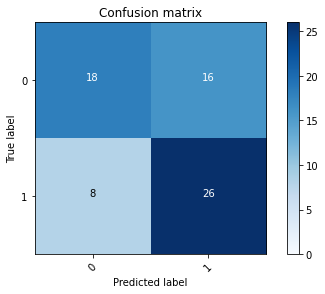

2022-08-03 20:39:23 - [Epoch Train: 49] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:39:23 - [Epoch Valid: 49] loss: 1.5507, auc: 0.7119, acc: 0.6471, time: 7.00 s


 33%|█████████████▋                            | 49/150 [24:53<48:58, 29.09s/it]

2022-08-03 20:39:23 - EPOCH: 50
2022-08-03 20:39:27 - Train Step 10/60, train_loss: 0.0006
2022-08-03 20:39:31 - Train Step 20/60, train_loss: 0.0005
2022-08-03 20:39:34 - Train Step 30/60, train_loss: 0.0005
2022-08-03 20:39:38 - Train Step 40/60, train_loss: 0.0005
2022-08-03 20:39:42 - Train Step 50/60, train_loss: 0.0005
2022-08-03 20:39:45 - Train Step 60/60, train_loss: 0.0006
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:39:48 - Valid Step 5/17, valid_loss: 0.9076
2022-08-03 20:39:49 - Valid Step 10/17, valid_loss: 1.7666
2022-08-03 20:39:51 - Valid Step 15/17, valid_loss: 1.5475
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
19  UPENN-GBM-00092_11_T1w                0           1
5   UPENN-GBM-00093_11_T1w                0           0
41  UPENN-GBM-00094_11_T1w                0           1
44  UPENN-GBM-00115_11_T1w                1           1
22  UPENN-GBM-00117_11_T1w                0           1
61  UPENN-GBM-00128_11_T1w        

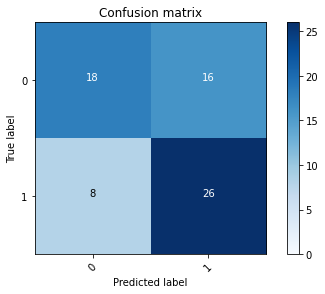

2022-08-03 20:39:52 - [Epoch Train: 50] loss: 0.0006, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:39:52 - [Epoch Valid: 50] loss: 1.5088, auc: 0.7111, acc: 0.6471, time: 6.00 s


 33%|██████████████                            | 50/150 [25:22<48:18, 28.99s/it]

2022-08-03 20:39:52 - EPOCH: 51
2022-08-03 20:39:56 - Train Step 10/60, train_loss: 0.0003
2022-08-03 20:40:00 - Train Step 20/60, train_loss: 0.0005
2022-08-03 20:40:03 - Train Step 30/60, train_loss: 0.0006
2022-08-03 20:40:07 - Train Step 40/60, train_loss: 0.0006
2022-08-03 20:40:11 - Train Step 50/60, train_loss: 0.0006
2022-08-03 20:40:14 - Train Step 60/60, train_loss: 0.0006
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:40:16 - Valid Step 5/17, valid_loss: 1.3643
2022-08-03 20:40:18 - Valid Step 10/17, valid_loss: 1.3514
2022-08-03 20:40:20 - Valid Step 15/17, valid_loss: 1.4564
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
64  UPENN-GBM-00092_11_T1w                0           1
22  UPENN-GBM-00093_11_T1w                0           0
47  UPENN-GBM-00094_11_T1w                0           1
3   UPENN-GBM-00115_11_T1w                1           1
20  UPENN-GBM-00117_11_T1w                0           1
2   UPENN-GBM-00128_11_T1w        

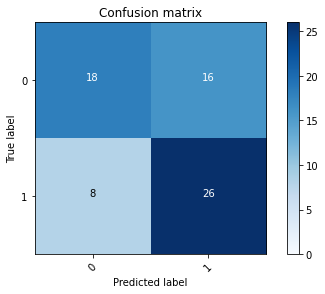

2022-08-03 20:40:21 - [Epoch Train: 51] loss: 0.0006, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:40:21 - [Epoch Valid: 51] loss: 1.4591, auc: 0.7102, acc: 0.6471, time: 7.00 s


 34%|██████████████▎                           | 51/150 [25:51<47:47, 28.97s/it]

2022-08-03 20:40:21 - EPOCH: 52
2022-08-03 20:40:25 - Train Step 10/60, train_loss: 0.0005
2022-08-03 20:40:29 - Train Step 20/60, train_loss: 0.0006
2022-08-03 20:40:32 - Train Step 30/60, train_loss: 0.0005
2022-08-03 20:40:36 - Train Step 40/60, train_loss: 0.0005
2022-08-03 20:40:40 - Train Step 50/60, train_loss: 0.0005
2022-08-03 20:40:44 - Train Step 60/60, train_loss: 0.0005
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:40:46 - Valid Step 5/17, valid_loss: 2.4574
2022-08-03 20:40:47 - Valid Step 10/17, valid_loss: 1.8069
2022-08-03 20:40:50 - Valid Step 15/17, valid_loss: 1.6458
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
44  UPENN-GBM-00092_11_T1w                0           1
50  UPENN-GBM-00093_11_T1w                0           0
38  UPENN-GBM-00094_11_T1w                0           1
35  UPENN-GBM-00115_11_T1w                1           1
6   UPENN-GBM-00117_11_T1w                0           1
19  UPENN-GBM-00128_11_T1w        

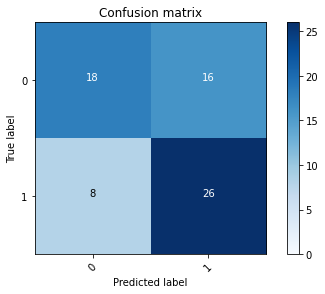

2022-08-03 20:40:50 - [Epoch Train: 52] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:40:50 - [Epoch Valid: 52] loss: 1.5262, auc: 0.7137, acc: 0.6471, time: 6.00 s


 35%|██████████████▌                           | 52/150 [26:20<47:30, 29.08s/it]

2022-08-03 20:40:50 - EPOCH: 53
2022-08-03 20:40:54 - Train Step 10/60, train_loss: 0.0006
2022-08-03 20:40:58 - Train Step 20/60, train_loss: 0.0005
2022-08-03 20:41:02 - Train Step 30/60, train_loss: 0.0005
2022-08-03 20:41:05 - Train Step 40/60, train_loss: 0.0005
2022-08-03 20:41:09 - Train Step 50/60, train_loss: 0.0005
2022-08-03 20:41:12 - Train Step 60/60, train_loss: 0.0005
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:41:15 - Valid Step 5/17, valid_loss: 1.6464
2022-08-03 20:41:16 - Valid Step 10/17, valid_loss: 1.3447
2022-08-03 20:41:19 - Valid Step 15/17, valid_loss: 1.6412
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
38  UPENN-GBM-00092_11_T1w                0           1
36  UPENN-GBM-00093_11_T1w                0           0
51  UPENN-GBM-00094_11_T1w                0           1
35  UPENN-GBM-00115_11_T1w                1           1
43  UPENN-GBM-00117_11_T1w                0           1
64  UPENN-GBM-00128_11_T1w        

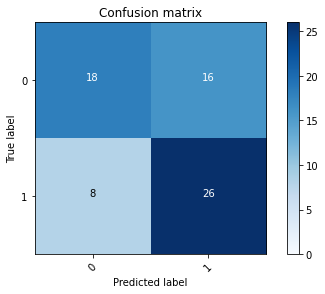

2022-08-03 20:41:19 - [Epoch Train: 53] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:41:19 - [Epoch Valid: 53] loss: 1.5298, auc: 0.7111, acc: 0.6471, time: 7.00 s


 35%|██████████████▊                           | 53/150 [26:49<46:56, 29.03s/it]

2022-08-03 20:41:19 - EPOCH: 54
2022-08-03 20:41:23 - Train Step 10/60, train_loss: 0.0004
2022-08-03 20:41:27 - Train Step 20/60, train_loss: 0.0004
2022-08-03 20:41:31 - Train Step 30/60, train_loss: 0.0004
2022-08-03 20:41:34 - Train Step 40/60, train_loss: 0.0004
2022-08-03 20:41:38 - Train Step 50/60, train_loss: 0.0004
2022-08-03 20:41:41 - Train Step 60/60, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:41:44 - Valid Step 5/17, valid_loss: 2.5930
2022-08-03 20:41:45 - Valid Step 10/17, valid_loss: 1.8335
2022-08-03 20:41:47 - Valid Step 15/17, valid_loss: 1.5815
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
59  UPENN-GBM-00092_11_T1w                0           1
19  UPENN-GBM-00093_11_T1w                0           0
0   UPENN-GBM-00094_11_T1w                0           1
43  UPENN-GBM-00115_11_T1w                1           1
66  UPENN-GBM-00117_11_T1w                0           1
54  UPENN-GBM-00128_11_T1w        

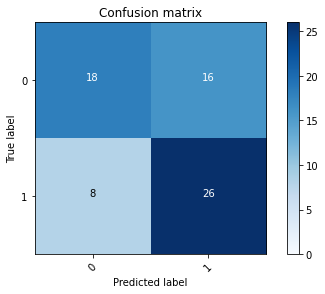

2022-08-03 20:41:48 - [Epoch Train: 54] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:41:48 - [Epoch Valid: 54] loss: 1.5626, auc: 0.7102, acc: 0.6471, time: 6.00 s


 36%|███████████████                           | 54/150 [27:18<46:26, 29.02s/it]

2022-08-03 20:41:48 - EPOCH: 55
2022-08-03 20:41:52 - Train Step 10/60, train_loss: 0.0004
2022-08-03 20:41:56 - Train Step 20/60, train_loss: 0.0005
2022-08-03 20:41:59 - Train Step 30/60, train_loss: 0.0004
2022-08-03 20:42:03 - Train Step 40/60, train_loss: 0.0004
2022-08-03 20:42:07 - Train Step 50/60, train_loss: 0.0004
2022-08-03 20:42:10 - Train Step 60/60, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:42:12 - Valid Step 5/17, valid_loss: 2.1099
2022-08-03 20:42:14 - Valid Step 10/17, valid_loss: 1.7548
2022-08-03 20:42:16 - Valid Step 15/17, valid_loss: 1.6459
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
21  UPENN-GBM-00092_11_T1w                0           1
9   UPENN-GBM-00093_11_T1w                0           0
18  UPENN-GBM-00094_11_T1w                0           1
19  UPENN-GBM-00115_11_T1w                1           1
52  UPENN-GBM-00117_11_T1w                0           1
50  UPENN-GBM-00128_11_T1w        

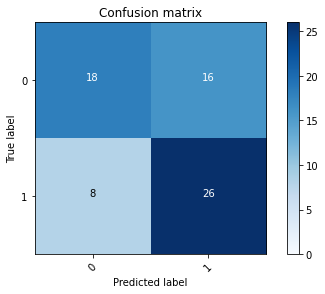

2022-08-03 20:42:17 - [Epoch Train: 55] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:42:17 - [Epoch Valid: 55] loss: 1.6011, auc: 0.7137, acc: 0.6471, time: 7.00 s


 37%|███████████████▍                          | 55/150 [27:47<45:50, 28.95s/it]

2022-08-03 20:42:17 - EPOCH: 56
2022-08-03 20:42:21 - Train Step 10/60, train_loss: 0.0002
2022-08-03 20:42:25 - Train Step 20/60, train_loss: 0.0003
2022-08-03 20:42:28 - Train Step 30/60, train_loss: 0.0003
2022-08-03 20:42:32 - Train Step 40/60, train_loss: 0.0003
2022-08-03 20:42:36 - Train Step 50/60, train_loss: 0.0003
2022-08-03 20:42:39 - Train Step 60/60, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:42:42 - Valid Step 5/17, valid_loss: 1.5627
2022-08-03 20:42:43 - Valid Step 10/17, valid_loss: 1.6411
2022-08-03 20:42:45 - Valid Step 15/17, valid_loss: 1.4423
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
43  UPENN-GBM-00092_11_T1w                0           1
32  UPENN-GBM-00093_11_T1w                0           0
55  UPENN-GBM-00094_11_T1w                0           1
7   UPENN-GBM-00115_11_T1w                1           1
47  UPENN-GBM-00117_11_T1w                0           1
4   UPENN-GBM-00128_11_T1w        

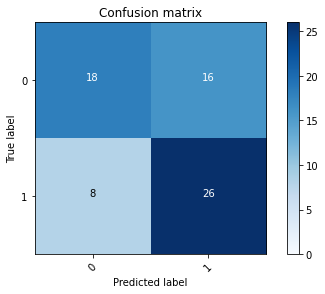

2022-08-03 20:42:46 - [Epoch Train: 56] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:42:46 - [Epoch Valid: 56] loss: 1.5056, auc: 0.7145, acc: 0.6471, time: 6.00 s


 37%|███████████████▋                          | 56/150 [28:16<45:26, 29.01s/it]

2022-08-03 20:42:46 - EPOCH: 57
2022-08-03 20:42:50 - Train Step 10/60, train_loss: 0.0006
2022-08-03 20:42:54 - Train Step 20/60, train_loss: 0.0005
2022-08-03 20:42:58 - Train Step 30/60, train_loss: 0.0004
2022-08-03 20:43:01 - Train Step 40/60, train_loss: 0.0004
2022-08-03 20:43:05 - Train Step 50/60, train_loss: 0.0004
2022-08-03 20:43:08 - Train Step 60/60, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:43:11 - Valid Step 5/17, valid_loss: 2.8677
2022-08-03 20:43:12 - Valid Step 10/17, valid_loss: 2.2053
2022-08-03 20:43:14 - Valid Step 15/17, valid_loss: 1.5935
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
37  UPENN-GBM-00092_11_T1w                0           1
44  UPENN-GBM-00093_11_T1w                0           0
27  UPENN-GBM-00094_11_T1w                0           1
38  UPENN-GBM-00115_11_T1w                1           1
15  UPENN-GBM-00117_11_T1w                0           1
42  UPENN-GBM-00128_11_T1w        

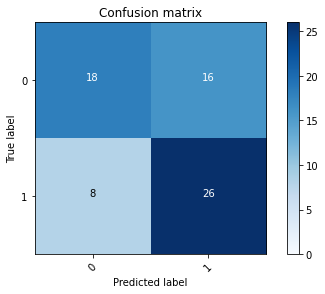

2022-08-03 20:43:15 - [Epoch Train: 57] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:43:15 - [Epoch Valid: 57] loss: 1.5796, auc: 0.7119, acc: 0.6471, time: 6.00 s


 38%|███████████████▉                          | 57/150 [28:45<44:58, 29.01s/it]

2022-08-03 20:43:15 - EPOCH: 58
2022-08-03 20:43:19 - Train Step 10/60, train_loss: 0.0004
2022-08-03 20:43:23 - Train Step 20/60, train_loss: 0.0004
2022-08-03 20:43:26 - Train Step 30/60, train_loss: 0.0004
2022-08-03 20:43:30 - Train Step 40/60, train_loss: 0.0004
2022-08-03 20:43:34 - Train Step 50/60, train_loss: 0.0004
2022-08-03 20:43:37 - Train Step 60/60, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:43:39 - Valid Step 5/17, valid_loss: 1.7518
2022-08-03 20:43:41 - Valid Step 10/17, valid_loss: 1.4943
2022-08-03 20:43:43 - Valid Step 15/17, valid_loss: 1.7562
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
52  UPENN-GBM-00092_11_T1w                0           1
61  UPENN-GBM-00093_11_T1w                0           0
56  UPENN-GBM-00094_11_T1w                0           1
34  UPENN-GBM-00115_11_T1w                1           1
37  UPENN-GBM-00117_11_T1w                0           1
57  UPENN-GBM-00128_11_T1w        

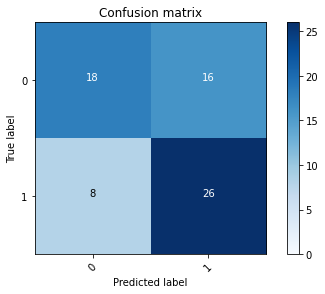

2022-08-03 20:43:44 - [Epoch Train: 58] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:43:44 - [Epoch Valid: 58] loss: 1.6326, auc: 0.7154, acc: 0.6471, time: 7.00 s


 39%|████████████████▏                         | 58/150 [29:14<44:17, 28.89s/it]

2022-08-03 20:43:44 - EPOCH: 59
2022-08-03 20:43:48 - Train Step 10/60, train_loss: 0.0003
2022-08-03 20:43:51 - Train Step 20/60, train_loss: 0.0004
2022-08-03 20:43:55 - Train Step 30/60, train_loss: 0.0004
2022-08-03 20:43:59 - Train Step 40/60, train_loss: 0.0004
2022-08-03 20:44:02 - Train Step 50/60, train_loss: 0.0004
2022-08-03 20:44:06 - Train Step 60/60, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:44:08 - Valid Step 5/17, valid_loss: 0.9556
2022-08-03 20:44:10 - Valid Step 10/17, valid_loss: 1.0967
2022-08-03 20:44:12 - Valid Step 15/17, valid_loss: 1.5809
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
67  UPENN-GBM-00092_11_T1w                0           1
34  UPENN-GBM-00093_11_T1w                0           0
55  UPENN-GBM-00094_11_T1w                0           1
64  UPENN-GBM-00115_11_T1w                1           1
32  UPENN-GBM-00117_11_T1w                0           1
37  UPENN-GBM-00128_11_T1w        

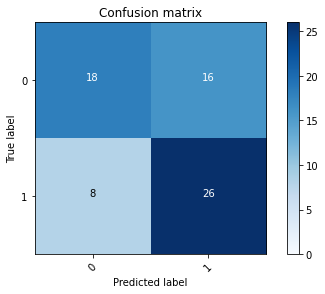

2022-08-03 20:44:13 - [Epoch Train: 59] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:44:13 - [Epoch Valid: 59] loss: 1.5324, auc: 0.7102, acc: 0.6471, time: 7.00 s


 39%|████████████████▌                         | 59/150 [29:43<43:46, 28.86s/it]

2022-08-03 20:44:13 - EPOCH: 60
2022-08-03 20:44:17 - Train Step 10/60, train_loss: 0.0003
2022-08-03 20:44:20 - Train Step 20/60, train_loss: 0.0003
2022-08-03 20:44:24 - Train Step 30/60, train_loss: 0.0003
2022-08-03 20:44:27 - Train Step 40/60, train_loss: 0.0003
2022-08-03 20:44:31 - Train Step 50/60, train_loss: 0.0008
2022-08-03 20:44:35 - Train Step 60/60, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:44:37 - Valid Step 5/17, valid_loss: 1.7254
2022-08-03 20:44:39 - Valid Step 10/17, valid_loss: 1.8260
2022-08-03 20:44:41 - Valid Step 15/17, valid_loss: 1.8469
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
2   UPENN-GBM-00092_11_T1w                0           1
16  UPENN-GBM-00093_11_T1w                0           0
3   UPENN-GBM-00094_11_T1w                0           1
5   UPENN-GBM-00115_11_T1w                1           1
35  UPENN-GBM-00117_11_T1w                0           1
62  UPENN-GBM-00128_11_T1w        

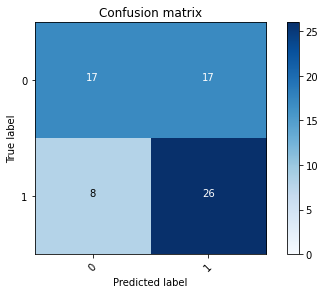

2022-08-03 20:44:42 - [Epoch Train: 60] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:44:42 - [Epoch Valid: 60] loss: 1.6956, auc: 0.7093, acc: 0.6324, time: 6.00 s


 40%|████████████████▊                         | 60/150 [30:12<43:18, 28.88s/it]

2022-08-03 20:44:42 - EPOCH: 61
2022-08-03 20:44:46 - Train Step 10/60, train_loss: 0.0003
2022-08-03 20:44:49 - Train Step 20/60, train_loss: 0.0003
2022-08-03 20:44:53 - Train Step 30/60, train_loss: 0.0003
2022-08-03 20:44:56 - Train Step 40/60, train_loss: 0.0003
2022-08-03 20:45:00 - Train Step 50/60, train_loss: 0.0003
2022-08-03 20:45:04 - Train Step 60/60, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:45:06 - Valid Step 5/17, valid_loss: 1.8479
2022-08-03 20:45:08 - Valid Step 10/17, valid_loss: 1.5323
2022-08-03 20:45:10 - Valid Step 15/17, valid_loss: 1.4966
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
46  UPENN-GBM-00092_11_T1w                0           1
13  UPENN-GBM-00093_11_T1w                0           0
62  UPENN-GBM-00094_11_T1w                0           1
57  UPENN-GBM-00115_11_T1w                1           1
66  UPENN-GBM-00117_11_T1w                0           1
24  UPENN-GBM-00128_11_T1w        

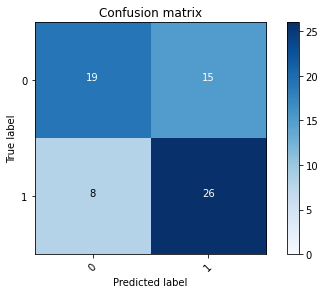

2022-08-03 20:45:11 - [Epoch Train: 61] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:45:11 - [Epoch Valid: 61] loss: 1.6553, auc: 0.7093, acc: 0.6618, time: 6.00 s
2022-08-03 20:45:11 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e61-loss1.655-acc0.662-auc0.709.pth'


 41%|█████████████████                         | 61/150 [30:41<42:57, 28.96s/it]

2022-08-03 20:45:11 - EPOCH: 62
2022-08-03 20:45:15 - Train Step 10/60, train_loss: 0.0003
2022-08-03 20:45:18 - Train Step 20/60, train_loss: 0.0003
2022-08-03 20:45:22 - Train Step 30/60, train_loss: 0.0003
2022-08-03 20:45:26 - Train Step 40/60, train_loss: 0.0003
2022-08-03 20:45:29 - Train Step 50/60, train_loss: 0.0003
2022-08-03 20:45:33 - Train Step 60/60, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:45:35 - Valid Step 5/17, valid_loss: 1.6427
2022-08-03 20:45:37 - Valid Step 10/17, valid_loss: 1.7390
2022-08-03 20:45:39 - Valid Step 15/17, valid_loss: 1.7129
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
34  UPENN-GBM-00092_11_T1w                0           1
63  UPENN-GBM-00093_11_T1w                0           0
54  UPENN-GBM-00094_11_T1w                0           1
2   UPENN-GBM-00115_11_T1w                1           1
1   UPENN-GBM-00117_11_T1w                0           1
31  UPENN-GBM-00128_11_T1w        

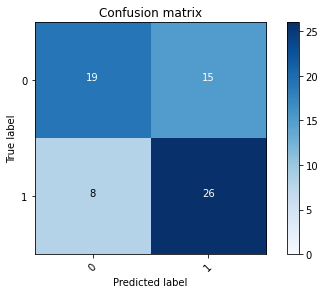

2022-08-03 20:45:40 - [Epoch Train: 62] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:45:40 - [Epoch Valid: 62] loss: 1.6145, auc: 0.7111, acc: 0.6618, time: 6.00 s
2022-08-03 20:45:40 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e62-loss1.614-acc0.662-auc0.711.pth'


 41%|█████████████████▎                        | 62/150 [31:10<42:27, 28.95s/it]

2022-08-03 20:45:40 - EPOCH: 63
2022-08-03 20:45:44 - Train Step 10/60, train_loss: 0.0003
2022-08-03 20:45:47 - Train Step 20/60, train_loss: 0.0003
2022-08-03 20:45:51 - Train Step 30/60, train_loss: 0.0003
2022-08-03 20:45:55 - Train Step 40/60, train_loss: 0.0003
2022-08-03 20:45:58 - Train Step 50/60, train_loss: 0.0003
2022-08-03 20:46:02 - Train Step 60/60, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:46:04 - Valid Step 5/17, valid_loss: 1.4534
2022-08-03 20:46:06 - Valid Step 10/17, valid_loss: 1.7902
2022-08-03 20:46:08 - Valid Step 15/17, valid_loss: 1.6078
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
23  UPENN-GBM-00092_11_T1w                0           1
5   UPENN-GBM-00093_11_T1w                0           0
6   UPENN-GBM-00094_11_T1w                0           1
25  UPENN-GBM-00115_11_T1w                1           1
46  UPENN-GBM-00117_11_T1w                0           1
11  UPENN-GBM-00128_11_T1w        

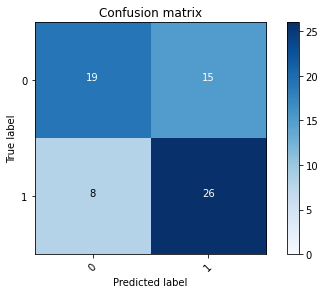

2022-08-03 20:46:09 - [Epoch Train: 63] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:46:09 - [Epoch Valid: 63] loss: 1.6578, auc: 0.7102, acc: 0.6618, time: 7.00 s
2022-08-03 20:46:09 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e63-loss1.658-acc0.662-auc0.710.pth'


 42%|█████████████████▋                        | 63/150 [31:39<42:05, 29.02s/it]

2022-08-03 20:46:09 - EPOCH: 64
2022-08-03 20:46:13 - Train Step 10/60, train_loss: 0.0004
2022-08-03 20:46:16 - Train Step 20/60, train_loss: 0.0004
2022-08-03 20:46:20 - Train Step 30/60, train_loss: 0.0003
2022-08-03 20:46:24 - Train Step 40/60, train_loss: 0.0003
2022-08-03 20:46:27 - Train Step 50/60, train_loss: 0.0003
2022-08-03 20:46:31 - Train Step 60/60, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:46:33 - Valid Step 5/17, valid_loss: 1.0014
2022-08-03 20:46:35 - Valid Step 10/17, valid_loss: 1.6233
2022-08-03 20:46:37 - Valid Step 15/17, valid_loss: 1.5997
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
44  UPENN-GBM-00092_11_T1w                0           1
32  UPENN-GBM-00093_11_T1w                0           0
47  UPENN-GBM-00094_11_T1w                0           1
52  UPENN-GBM-00115_11_T1w                1           1
17  UPENN-GBM-00117_11_T1w                0           1
41  UPENN-GBM-00128_11_T1w        

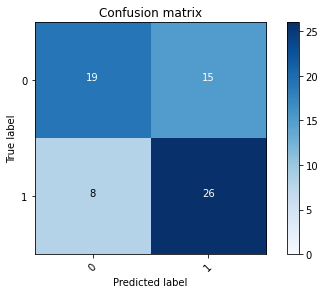

2022-08-03 20:46:38 - [Epoch Train: 64] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:46:38 - [Epoch Valid: 64] loss: 1.6898, auc: 0.7076, acc: 0.6618, time: 7.00 s
2022-08-03 20:46:38 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e64-loss1.690-acc0.662-auc0.708.pth'


 43%|█████████████████▉                        | 64/150 [32:08<41:34, 29.01s/it]

2022-08-03 20:46:38 - EPOCH: 65
2022-08-03 20:46:42 - Train Step 10/60, train_loss: 0.0002
2022-08-03 20:46:46 - Train Step 20/60, train_loss: 0.0003
2022-08-03 20:46:49 - Train Step 30/60, train_loss: 0.0003
2022-08-03 20:46:53 - Train Step 40/60, train_loss: 0.0002
2022-08-03 20:46:57 - Train Step 50/60, train_loss: 0.0003
2022-08-03 20:47:00 - Train Step 60/60, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:47:02 - Valid Step 5/17, valid_loss: 1.4218
2022-08-03 20:47:04 - Valid Step 10/17, valid_loss: 1.8263
2022-08-03 20:47:06 - Valid Step 15/17, valid_loss: 1.6149
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
61  UPENN-GBM-00092_11_T1w                0           1
42  UPENN-GBM-00093_11_T1w                0           0
28  UPENN-GBM-00094_11_T1w                0           1
58  UPENN-GBM-00115_11_T1w                1           1
66  UPENN-GBM-00117_11_T1w                0           1
17  UPENN-GBM-00128_11_T1w        

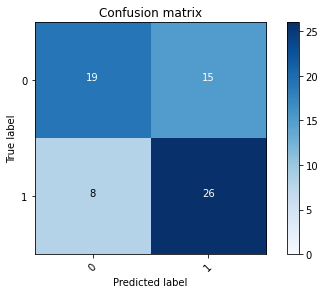

2022-08-03 20:47:07 - [Epoch Train: 65] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:47:07 - [Epoch Valid: 65] loss: 1.6519, auc: 0.7137, acc: 0.6618, time: 6.00 s
2022-08-03 20:47:07 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e65-loss1.652-acc0.662-auc0.714.pth'


 43%|██████████████████▏                       | 65/150 [32:37<41:13, 29.09s/it]

2022-08-03 20:47:07 - EPOCH: 66
2022-08-03 20:47:11 - Train Step 10/60, train_loss: 0.0002
2022-08-03 20:47:15 - Train Step 20/60, train_loss: 0.0002
2022-08-03 20:47:18 - Train Step 30/60, train_loss: 0.0003
2022-08-03 20:47:22 - Train Step 40/60, train_loss: 0.0003
2022-08-03 20:47:26 - Train Step 50/60, train_loss: 0.0003
2022-08-03 20:47:29 - Train Step 60/60, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:47:32 - Valid Step 5/17, valid_loss: 2.1877
2022-08-03 20:47:33 - Valid Step 10/17, valid_loss: 2.3533
2022-08-03 20:47:35 - Valid Step 15/17, valid_loss: 1.7859
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
19  UPENN-GBM-00092_11_T1w                0           1
53  UPENN-GBM-00093_11_T1w                0           0
22  UPENN-GBM-00094_11_T1w                0           1
47  UPENN-GBM-00115_11_T1w                1           1
0   UPENN-GBM-00117_11_T1w                0           1
35  UPENN-GBM-00128_11_T1w        

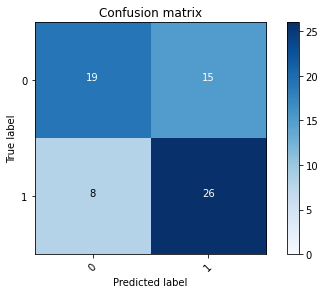

2022-08-03 20:47:36 - [Epoch Train: 66] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:47:36 - [Epoch Valid: 66] loss: 1.6712, auc: 0.7059, acc: 0.6618, time: 6.00 s
2022-08-03 20:47:36 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e66-loss1.671-acc0.662-auc0.706.pth'


 44%|██████████████████▍                       | 66/150 [33:06<40:37, 29.02s/it]

2022-08-03 20:47:36 - EPOCH: 67
2022-08-03 20:47:40 - Train Step 10/60, train_loss: 0.0002
2022-08-03 20:47:44 - Train Step 20/60, train_loss: 0.0002
2022-08-03 20:47:47 - Train Step 30/60, train_loss: 0.0002
2022-08-03 20:47:51 - Train Step 40/60, train_loss: 0.0002
2022-08-03 20:47:55 - Train Step 50/60, train_loss: 0.0002
2022-08-03 20:47:58 - Train Step 60/60, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:48:01 - Valid Step 5/17, valid_loss: 1.6882
2022-08-03 20:48:02 - Valid Step 10/17, valid_loss: 1.5326
2022-08-03 20:48:04 - Valid Step 15/17, valid_loss: 1.4420
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
24  UPENN-GBM-00092_11_T1w                0           1
48  UPENN-GBM-00093_11_T1w                0           0
64  UPENN-GBM-00094_11_T1w                0           1
1   UPENN-GBM-00115_11_T1w                1           1
4   UPENN-GBM-00117_11_T1w                0           1
29  UPENN-GBM-00128_11_T1w        

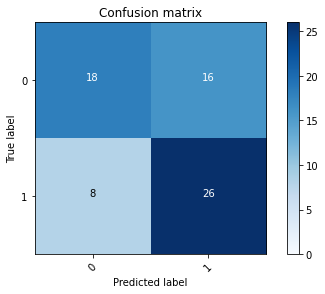

2022-08-03 20:48:05 - [Epoch Train: 67] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:48:05 - [Epoch Valid: 67] loss: 1.6765, auc: 0.7111, acc: 0.6471, time: 6.00 s


 45%|██████████████████▊                       | 67/150 [33:35<40:14, 29.09s/it]

2022-08-03 20:48:05 - EPOCH: 68
2022-08-03 20:48:09 - Train Step 10/60, train_loss: 0.0003
2022-08-03 20:48:13 - Train Step 20/60, train_loss: 0.0003
2022-08-03 20:48:17 - Train Step 30/60, train_loss: 0.0003
2022-08-03 20:48:20 - Train Step 40/60, train_loss: 0.0003
2022-08-03 20:48:24 - Train Step 50/60, train_loss: 0.0003
2022-08-03 20:48:27 - Train Step 60/60, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:48:30 - Valid Step 5/17, valid_loss: 0.9960
2022-08-03 20:48:32 - Valid Step 10/17, valid_loss: 0.8459
2022-08-03 20:48:34 - Valid Step 15/17, valid_loss: 1.5661
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
58  UPENN-GBM-00092_11_T1w                0           1
13  UPENN-GBM-00093_11_T1w                0           0
3   UPENN-GBM-00094_11_T1w                0           1
22  UPENN-GBM-00115_11_T1w                1           1
65  UPENN-GBM-00117_11_T1w                0           1
24  UPENN-GBM-00128_11_T1w        

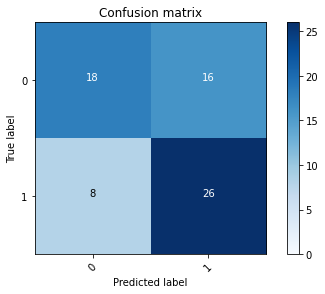

2022-08-03 20:48:35 - [Epoch Train: 68] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:48:35 - [Epoch Valid: 68] loss: 1.7096, auc: 0.7119, acc: 0.6471, time: 7.00 s


 45%|███████████████████                       | 68/150 [34:05<39:52, 29.17s/it]

2022-08-03 20:48:35 - EPOCH: 69
2022-08-03 20:48:39 - Train Step 10/60, train_loss: 0.0002
2022-08-03 20:48:42 - Train Step 20/60, train_loss: 0.0002
2022-08-03 20:48:46 - Train Step 30/60, train_loss: 0.0002
2022-08-03 20:48:50 - Train Step 40/60, train_loss: 0.0002
2022-08-03 20:48:53 - Train Step 50/60, train_loss: 0.0002
2022-08-03 20:48:57 - Train Step 60/60, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:48:59 - Valid Step 5/17, valid_loss: 2.4335
2022-08-03 20:49:01 - Valid Step 10/17, valid_loss: 2.0158
2022-08-03 20:49:03 - Valid Step 15/17, valid_loss: 1.6107
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
42  UPENN-GBM-00092_11_T1w                0           1
65  UPENN-GBM-00093_11_T1w                0           0
66  UPENN-GBM-00094_11_T1w                0           1
57  UPENN-GBM-00115_11_T1w                1           1
11  UPENN-GBM-00117_11_T1w                0           1
8   UPENN-GBM-00128_11_T1w        

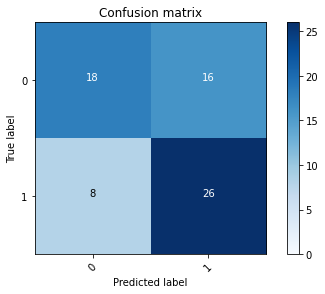

2022-08-03 20:49:04 - [Epoch Train: 69] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:49:04 - [Epoch Valid: 69] loss: 1.6384, auc: 0.7111, acc: 0.6471, time: 6.00 s


 46%|███████████████████▎                      | 69/150 [34:34<39:22, 29.17s/it]

2022-08-03 20:49:04 - EPOCH: 70
2022-08-03 20:49:08 - Train Step 10/60, train_loss: 0.0002
2022-08-03 20:49:11 - Train Step 20/60, train_loss: 0.0002
2022-08-03 20:49:15 - Train Step 30/60, train_loss: 0.0002
2022-08-03 20:49:19 - Train Step 40/60, train_loss: 0.0002
2022-08-03 20:49:22 - Train Step 50/60, train_loss: 0.0002
2022-08-03 20:49:26 - Train Step 60/60, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:49:28 - Valid Step 5/17, valid_loss: 1.3896
2022-08-03 20:49:30 - Valid Step 10/17, valid_loss: 1.3121
2022-08-03 20:49:32 - Valid Step 15/17, valid_loss: 1.5321
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
21  UPENN-GBM-00092_11_T1w                0           1
33  UPENN-GBM-00093_11_T1w                0           0
26  UPENN-GBM-00094_11_T1w                0           1
55  UPENN-GBM-00115_11_T1w                1           1
61  UPENN-GBM-00117_11_T1w                0           1
38  UPENN-GBM-00128_11_T1w        

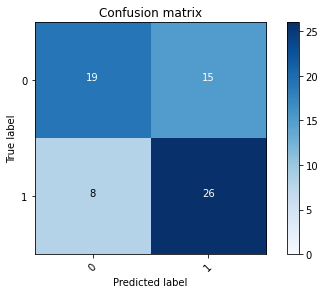

2022-08-03 20:49:33 - [Epoch Train: 70] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:49:33 - [Epoch Valid: 70] loss: 1.6503, auc: 0.7085, acc: 0.6618, time: 6.00 s
2022-08-03 20:49:33 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e70-loss1.650-acc0.662-auc0.708.pth'


 47%|███████████████████▌                      | 70/150 [35:03<38:54, 29.19s/it]

2022-08-03 20:49:33 - EPOCH: 71
2022-08-03 20:49:37 - Train Step 10/60, train_loss: 0.0002
2022-08-03 20:49:41 - Train Step 20/60, train_loss: 0.0002
2022-08-03 20:49:44 - Train Step 30/60, train_loss: 0.0002
2022-08-03 20:49:48 - Train Step 40/60, train_loss: 0.0002
2022-08-03 20:49:52 - Train Step 50/60, train_loss: 0.0002
2022-08-03 20:49:55 - Train Step 60/60, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:49:58 - Valid Step 5/17, valid_loss: 1.9516
2022-08-03 20:49:59 - Valid Step 10/17, valid_loss: 1.5678
2022-08-03 20:50:02 - Valid Step 15/17, valid_loss: 1.8195
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
22  UPENN-GBM-00092_11_T1w                0           1
33  UPENN-GBM-00093_11_T1w                0           0
50  UPENN-GBM-00094_11_T1w                0           1
24  UPENN-GBM-00115_11_T1w                1           1
11  UPENN-GBM-00117_11_T1w                0           1
53  UPENN-GBM-00128_11_T1w        

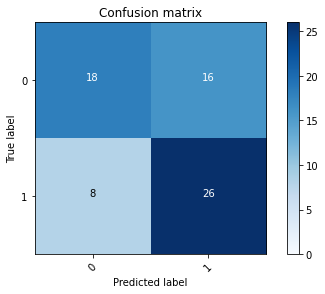

2022-08-03 20:50:02 - [Epoch Train: 71] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:50:02 - [Epoch Valid: 71] loss: 1.7627, auc: 0.7093, acc: 0.6471, time: 6.00 s


 47%|███████████████████▉                      | 71/150 [35:32<38:32, 29.27s/it]

2022-08-03 20:50:02 - EPOCH: 72
2022-08-03 20:50:06 - Train Step 10/60, train_loss: 0.0003
2022-08-03 20:50:10 - Train Step 20/60, train_loss: 0.0002
2022-08-03 20:50:14 - Train Step 30/60, train_loss: 0.0002
2022-08-03 20:50:17 - Train Step 40/60, train_loss: 0.0002
2022-08-03 20:50:21 - Train Step 50/60, train_loss: 0.0002
2022-08-03 20:50:25 - Train Step 60/60, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:50:27 - Valid Step 5/17, valid_loss: 1.4421
2022-08-03 20:50:29 - Valid Step 10/17, valid_loss: 2.2501
2022-08-03 20:50:31 - Valid Step 15/17, valid_loss: 1.8193
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
24  UPENN-GBM-00092_11_T1w                0           1
51  UPENN-GBM-00093_11_T1w                0           0
31  UPENN-GBM-00094_11_T1w                0           1
20  UPENN-GBM-00115_11_T1w                1           1
55  UPENN-GBM-00117_11_T1w                0           1
61  UPENN-GBM-00128_11_T1w        

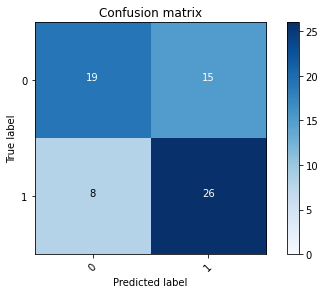

2022-08-03 20:50:32 - [Epoch Train: 72] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:50:32 - [Epoch Valid: 72] loss: 1.6318, auc: 0.7145, acc: 0.6618, time: 7.00 s
2022-08-03 20:50:32 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e72-loss1.632-acc0.662-auc0.715.pth'


 48%|████████████████████▏                     | 72/150 [36:02<38:06, 29.32s/it]

2022-08-03 20:50:32 - EPOCH: 73
2022-08-03 20:50:36 - Train Step 10/60, train_loss: 0.0002
2022-08-03 20:50:40 - Train Step 20/60, train_loss: 0.0002
2022-08-03 20:50:43 - Train Step 30/60, train_loss: 0.0002
2022-08-03 20:50:47 - Train Step 40/60, train_loss: 0.0002
2022-08-03 20:50:51 - Train Step 50/60, train_loss: 0.0002
2022-08-03 20:50:54 - Train Step 60/60, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:50:57 - Valid Step 5/17, valid_loss: 1.3251
2022-08-03 20:50:58 - Valid Step 10/17, valid_loss: 1.3723
2022-08-03 20:51:00 - Valid Step 15/17, valid_loss: 1.7541
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
9   UPENN-GBM-00092_11_T1w                0           1
65  UPENN-GBM-00093_11_T1w                0           0
40  UPENN-GBM-00094_11_T1w                0           1
37  UPENN-GBM-00115_11_T1w                1           1
27  UPENN-GBM-00117_11_T1w                0           1
45  UPENN-GBM-00128_11_T1w        

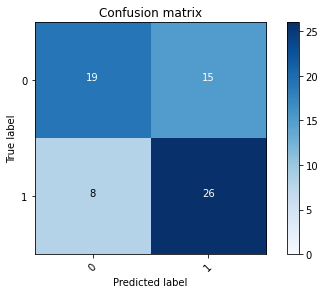

2022-08-03 20:51:01 - [Epoch Train: 73] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:51:01 - [Epoch Valid: 73] loss: 1.6734, auc: 0.7119, acc: 0.6618, time: 6.00 s
2022-08-03 20:51:01 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e73-loss1.673-acc0.662-auc0.712.pth'


 49%|████████████████████▍                     | 73/150 [36:31<37:38, 29.33s/it]

2022-08-03 20:51:01 - EPOCH: 74
2022-08-03 20:51:05 - Train Step 10/60, train_loss: 0.0003
2022-08-03 20:51:09 - Train Step 20/60, train_loss: 0.0002
2022-08-03 20:51:12 - Train Step 30/60, train_loss: 0.0002
2022-08-03 20:51:16 - Train Step 40/60, train_loss: 0.0002
2022-08-03 20:51:20 - Train Step 50/60, train_loss: 0.0002
2022-08-03 20:51:23 - Train Step 60/60, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:51:25 - Valid Step 5/17, valid_loss: 1.5590
2022-08-03 20:51:27 - Valid Step 10/17, valid_loss: 1.7912
2022-08-03 20:51:29 - Valid Step 15/17, valid_loss: 1.7931
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
10  UPENN-GBM-00092_11_T1w                0           1
8   UPENN-GBM-00093_11_T1w                0           0
21  UPENN-GBM-00094_11_T1w                0           1
13  UPENN-GBM-00115_11_T1w                1           1
56  UPENN-GBM-00117_11_T1w                0           1
7   UPENN-GBM-00128_11_T1w        

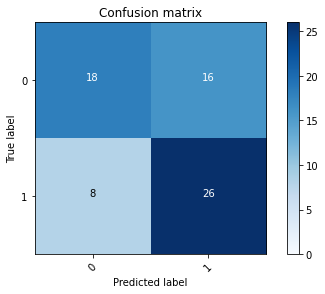

2022-08-03 20:51:30 - [Epoch Train: 74] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:51:30 - [Epoch Valid: 74] loss: 1.7139, auc: 0.7137, acc: 0.6471, time: 6.00 s


 49%|████████████████████▋                     | 74/150 [37:00<36:53, 29.13s/it]

2022-08-03 20:51:30 - EPOCH: 75
2022-08-03 20:51:34 - Train Step 10/60, train_loss: 0.0002
2022-08-03 20:51:38 - Train Step 20/60, train_loss: 0.0002
2022-08-03 20:51:41 - Train Step 30/60, train_loss: 0.0002
2022-08-03 20:51:45 - Train Step 40/60, train_loss: 0.0002
2022-08-03 20:51:48 - Train Step 50/60, train_loss: 0.0002
2022-08-03 20:51:52 - Train Step 60/60, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:51:54 - Valid Step 5/17, valid_loss: 1.4159
2022-08-03 20:51:56 - Valid Step 10/17, valid_loss: 1.3816
2022-08-03 20:51:58 - Valid Step 15/17, valid_loss: 1.7894
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
30  UPENN-GBM-00092_11_T1w                0           1
8   UPENN-GBM-00093_11_T1w                0           0
19  UPENN-GBM-00094_11_T1w                0           1
41  UPENN-GBM-00115_11_T1w                1           1
45  UPENN-GBM-00117_11_T1w                0           1
2   UPENN-GBM-00128_11_T1w        

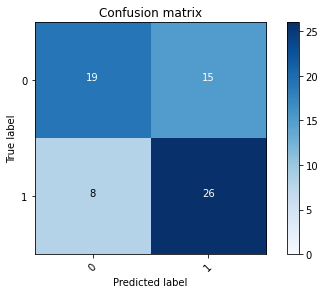

2022-08-03 20:51:59 - [Epoch Train: 75] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:51:59 - [Epoch Valid: 75] loss: 1.6448, auc: 0.7128, acc: 0.6618, time: 7.00 s
2022-08-03 20:51:59 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e75-loss1.645-acc0.662-auc0.713.pth'


 50%|█████████████████████                     | 75/150 [37:29<36:18, 29.04s/it]

2022-08-03 20:51:59 - EPOCH: 76
2022-08-03 20:52:03 - Train Step 10/60, train_loss: 0.0001
2022-08-03 20:52:06 - Train Step 20/60, train_loss: 0.0002
2022-08-03 20:52:10 - Train Step 30/60, train_loss: 0.0002
2022-08-03 20:52:13 - Train Step 40/60, train_loss: 0.0002
2022-08-03 20:52:17 - Train Step 50/60, train_loss: 0.0001
2022-08-03 20:52:20 - Train Step 60/60, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:52:23 - Valid Step 5/17, valid_loss: 2.0993
2022-08-03 20:52:24 - Valid Step 10/17, valid_loss: 2.0611
2022-08-03 20:52:27 - Valid Step 15/17, valid_loss: 1.8980
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
28  UPENN-GBM-00092_11_T1w                0           1
46  UPENN-GBM-00093_11_T1w                0           0
56  UPENN-GBM-00094_11_T1w                0           1
59  UPENN-GBM-00115_11_T1w                1           1
36  UPENN-GBM-00117_11_T1w                0           1
45  UPENN-GBM-00128_11_T1w        

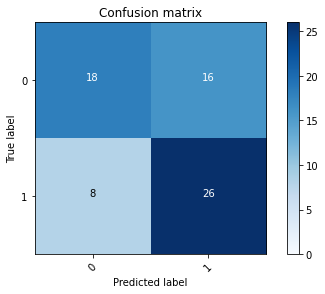

2022-08-03 20:52:27 - [Epoch Train: 76] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:52:27 - [Epoch Valid: 76] loss: 1.7088, auc: 0.7128, acc: 0.6471, time: 7.00 s


 51%|█████████████████████▎                    | 76/150 [37:57<35:40, 28.92s/it]

2022-08-03 20:52:27 - EPOCH: 77
2022-08-03 20:52:31 - Train Step 10/60, train_loss: 0.0002
2022-08-03 20:52:35 - Train Step 20/60, train_loss: 0.0002
2022-08-03 20:52:39 - Train Step 30/60, train_loss: 0.0002
2022-08-03 20:52:43 - Train Step 40/60, train_loss: 0.0002
2022-08-03 20:52:46 - Train Step 50/60, train_loss: 0.0001
2022-08-03 20:52:50 - Train Step 60/60, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:52:52 - Valid Step 5/17, valid_loss: 1.4141
2022-08-03 20:52:54 - Valid Step 10/17, valid_loss: 1.9464
2022-08-03 20:52:56 - Valid Step 15/17, valid_loss: 1.8217
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
1   UPENN-GBM-00092_11_T1w                0           1
14  UPENN-GBM-00093_11_T1w                0           0
39  UPENN-GBM-00094_11_T1w                0           1
53  UPENN-GBM-00115_11_T1w                1           1
46  UPENN-GBM-00117_11_T1w                0           1
52  UPENN-GBM-00128_11_T1w        

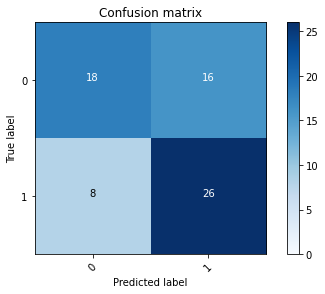

2022-08-03 20:52:57 - [Epoch Train: 77] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:52:57 - [Epoch Valid: 77] loss: 1.7115, auc: 0.7067, acc: 0.6471, time: 6.00 s


 51%|█████████████████████▌                    | 77/150 [38:27<35:21, 29.06s/it]

2022-08-03 20:52:57 - EPOCH: 78
2022-08-03 20:53:01 - Train Step 10/60, train_loss: 0.0001
2022-08-03 20:53:04 - Train Step 20/60, train_loss: 0.0001
2022-08-03 20:53:08 - Train Step 30/60, train_loss: 0.0001
2022-08-03 20:53:11 - Train Step 40/60, train_loss: 0.0001
2022-08-03 20:53:15 - Train Step 50/60, train_loss: 0.0001
2022-08-03 20:53:18 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:53:20 - Valid Step 5/17, valid_loss: 1.4317
2022-08-03 20:53:22 - Valid Step 10/17, valid_loss: 1.2615
2022-08-03 20:53:24 - Valid Step 15/17, valid_loss: 1.6994
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
63  UPENN-GBM-00092_11_T1w                0           1
20  UPENN-GBM-00093_11_T1w                0           0
64  UPENN-GBM-00094_11_T1w                0           1
40  UPENN-GBM-00115_11_T1w                1           1
17  UPENN-GBM-00117_11_T1w                0           1
62  UPENN-GBM-00128_11_T1w        

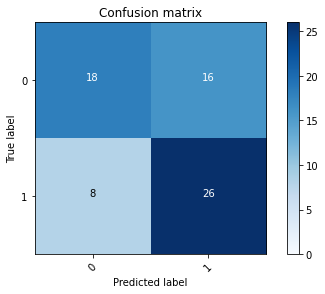

2022-08-03 20:53:25 - [Epoch Train: 78] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:53:25 - [Epoch Valid: 78] loss: 1.7708, auc: 0.7145, acc: 0.6471, time: 7.00 s


 52%|█████████████████████▊                    | 78/150 [38:55<34:36, 28.85s/it]

2022-08-03 20:53:25 - EPOCH: 79
2022-08-03 20:53:29 - Train Step 10/60, train_loss: 0.0002
2022-08-03 20:53:33 - Train Step 20/60, train_loss: 0.0001
2022-08-03 20:53:36 - Train Step 30/60, train_loss: 0.0001
2022-08-03 20:53:40 - Train Step 40/60, train_loss: 0.0001
2022-08-03 20:53:43 - Train Step 50/60, train_loss: 0.0001
2022-08-03 20:53:46 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:53:49 - Valid Step 5/17, valid_loss: 0.7823
2022-08-03 20:53:50 - Valid Step 10/17, valid_loss: 1.2264
2022-08-03 20:53:52 - Valid Step 15/17, valid_loss: 1.8502
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
55  UPENN-GBM-00092_11_T1w                0           1
16  UPENN-GBM-00093_11_T1w                0           0
30  UPENN-GBM-00094_11_T1w                0           1
40  UPENN-GBM-00115_11_T1w                1           1
45  UPENN-GBM-00117_11_T1w                0           1
43  UPENN-GBM-00128_11_T1w        

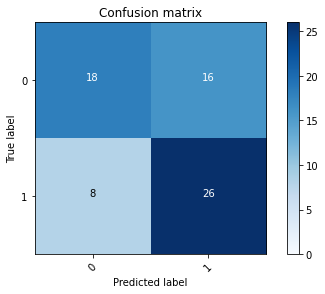

2022-08-03 20:53:53 - [Epoch Train: 79] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:53:53 - [Epoch Valid: 79] loss: 1.7652, auc: 0.7128, acc: 0.6471, time: 6.00 s


 53%|██████████████████████                    | 79/150 [39:23<33:51, 28.61s/it]

2022-08-03 20:53:53 - EPOCH: 80
2022-08-03 20:53:57 - Train Step 10/60, train_loss: 0.0001
2022-08-03 20:54:01 - Train Step 20/60, train_loss: 0.0001
2022-08-03 20:54:04 - Train Step 30/60, train_loss: 0.0001
2022-08-03 20:54:08 - Train Step 40/60, train_loss: 0.0001
2022-08-03 20:54:12 - Train Step 50/60, train_loss: 0.0001
2022-08-03 20:54:15 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:54:18 - Valid Step 5/17, valid_loss: 1.5512
2022-08-03 20:54:19 - Valid Step 10/17, valid_loss: 2.1898
2022-08-03 20:54:21 - Valid Step 15/17, valid_loss: 1.8111
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
40  UPENN-GBM-00092_11_T1w                0           1
4   UPENN-GBM-00093_11_T1w                0           0
56  UPENN-GBM-00094_11_T1w                0           1
32  UPENN-GBM-00115_11_T1w                1           1
30  UPENN-GBM-00117_11_T1w                0           1
10  UPENN-GBM-00128_11_T1w        

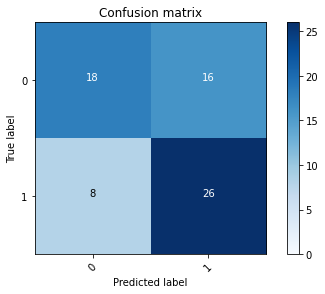

2022-08-03 20:54:22 - [Epoch Train: 80] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:54:22 - [Epoch Valid: 80] loss: 1.7805, auc: 0.7076, acc: 0.6471, time: 6.00 s


 53%|██████████████████████▍                   | 80/150 [39:52<33:30, 28.72s/it]

2022-08-03 20:54:22 - EPOCH: 81
2022-08-03 20:54:26 - Train Step 10/60, train_loss: 0.0001
2022-08-03 20:54:30 - Train Step 20/60, train_loss: 0.0002
2022-08-03 20:54:33 - Train Step 30/60, train_loss: 0.0002
2022-08-03 20:54:37 - Train Step 40/60, train_loss: 0.0002
2022-08-03 20:54:41 - Train Step 50/60, train_loss: 0.0001
2022-08-03 20:54:44 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:54:46 - Valid Step 5/17, valid_loss: 1.3386
2022-08-03 20:54:48 - Valid Step 10/17, valid_loss: 1.2134
2022-08-03 20:54:50 - Valid Step 15/17, valid_loss: 1.5738
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
18  UPENN-GBM-00092_11_T1w                0           1
30  UPENN-GBM-00093_11_T1w                0           0
53  UPENN-GBM-00094_11_T1w                0           1
60  UPENN-GBM-00115_11_T1w                1           1
29  UPENN-GBM-00117_11_T1w                0           1
44  UPENN-GBM-00128_11_T1w        

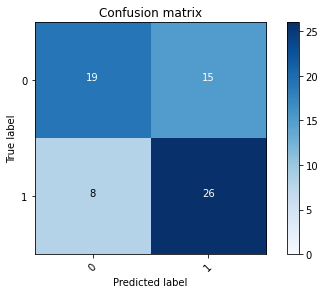

2022-08-03 20:54:51 - [Epoch Train: 81] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:54:51 - [Epoch Valid: 81] loss: 1.7083, auc: 0.7111, acc: 0.6618, time: 6.00 s
2022-08-03 20:54:51 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e81-loss1.708-acc0.662-auc0.711.pth'


 54%|██████████████████████▋                   | 81/150 [40:21<33:02, 28.72s/it]

2022-08-03 20:54:51 - EPOCH: 82
2022-08-03 20:54:55 - Train Step 10/60, train_loss: 0.0002
2022-08-03 20:54:58 - Train Step 20/60, train_loss: 0.0002
2022-08-03 20:55:02 - Train Step 30/60, train_loss: 0.0002
2022-08-03 20:55:05 - Train Step 40/60, train_loss: 0.0002
2022-08-03 20:55:09 - Train Step 50/60, train_loss: 0.0001
2022-08-03 20:55:12 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:55:15 - Valid Step 5/17, valid_loss: 1.6599
2022-08-03 20:55:16 - Valid Step 10/17, valid_loss: 1.8449
2022-08-03 20:55:19 - Valid Step 15/17, valid_loss: 1.7406
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
51  UPENN-GBM-00092_11_T1w                0           1
7   UPENN-GBM-00093_11_T1w                0           0
26  UPENN-GBM-00094_11_T1w                0           1
61  UPENN-GBM-00115_11_T1w                1           1
43  UPENN-GBM-00117_11_T1w                0           1
0   UPENN-GBM-00128_11_T1w        

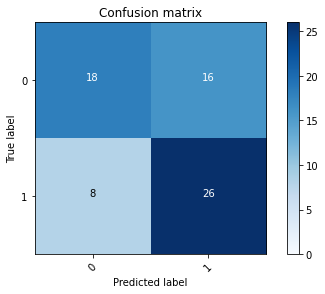

2022-08-03 20:55:20 - [Epoch Train: 82] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:55:20 - [Epoch Valid: 82] loss: 1.7785, auc: 0.7085, acc: 0.6471, time: 7.00 s


 55%|██████████████████████▉                   | 82/150 [40:50<32:35, 28.76s/it]

2022-08-03 20:55:20 - EPOCH: 83
2022-08-03 20:55:24 - Train Step 10/60, train_loss: 0.0001
2022-08-03 20:55:27 - Train Step 20/60, train_loss: 0.0001
2022-08-03 20:55:31 - Train Step 30/60, train_loss: 0.0001
2022-08-03 20:55:35 - Train Step 40/60, train_loss: 0.0001
2022-08-03 20:55:39 - Train Step 50/60, train_loss: 0.0001
2022-08-03 20:55:42 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:55:45 - Valid Step 5/17, valid_loss: 1.9979
2022-08-03 20:55:46 - Valid Step 10/17, valid_loss: 1.6540
2022-08-03 20:55:48 - Valid Step 15/17, valid_loss: 1.7415
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
5   UPENN-GBM-00092_11_T1w                0           1
55  UPENN-GBM-00093_11_T1w                0           0
50  UPENN-GBM-00094_11_T1w                0           1
15  UPENN-GBM-00115_11_T1w                1           1
38  UPENN-GBM-00117_11_T1w                0           1
65  UPENN-GBM-00128_11_T1w        

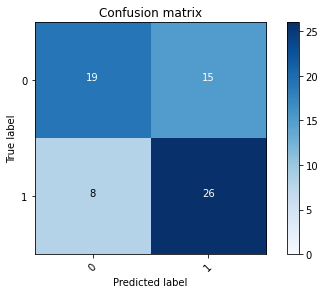

2022-08-03 20:55:49 - [Epoch Train: 83] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:55:49 - [Epoch Valid: 83] loss: 1.6973, auc: 0.7102, acc: 0.6618, time: 6.00 s
2022-08-03 20:55:49 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e83-loss1.697-acc0.662-auc0.710.pth'


 55%|███████████████████████▏                  | 83/150 [41:19<32:17, 28.92s/it]

2022-08-03 20:55:49 - EPOCH: 84
2022-08-03 20:55:53 - Train Step 10/60, train_loss: 0.0001
2022-08-03 20:55:57 - Train Step 20/60, train_loss: 0.0001
2022-08-03 20:56:00 - Train Step 30/60, train_loss: 0.0001
2022-08-03 20:56:04 - Train Step 40/60, train_loss: 0.0001
2022-08-03 20:56:07 - Train Step 50/60, train_loss: 0.0001
2022-08-03 20:56:11 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:56:13 - Valid Step 5/17, valid_loss: 1.2539
2022-08-03 20:56:15 - Valid Step 10/17, valid_loss: 1.4854
2022-08-03 20:56:17 - Valid Step 15/17, valid_loss: 1.9325
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
50  UPENN-GBM-00092_11_T1w                0           1
67  UPENN-GBM-00093_11_T1w                0           0
42  UPENN-GBM-00094_11_T1w                0           1
29  UPENN-GBM-00115_11_T1w                1           1
5   UPENN-GBM-00117_11_T1w                0           1
11  UPENN-GBM-00128_11_T1w        

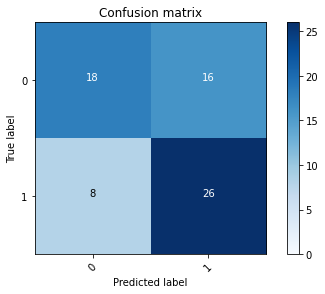

2022-08-03 20:56:18 - [Epoch Train: 84] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:56:18 - [Epoch Valid: 84] loss: 1.8480, auc: 0.7111, acc: 0.6471, time: 6.00 s


 56%|███████████████████████▌                  | 84/150 [41:48<31:48, 28.91s/it]

2022-08-03 20:56:18 - EPOCH: 85
2022-08-03 20:56:22 - Train Step 10/60, train_loss: 0.0001
2022-08-03 20:56:26 - Train Step 20/60, train_loss: 0.0001
2022-08-03 20:56:29 - Train Step 30/60, train_loss: 0.0001
2022-08-03 20:56:33 - Train Step 40/60, train_loss: 0.0001
2022-08-03 20:56:37 - Train Step 50/60, train_loss: 0.0001
2022-08-03 20:56:40 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:56:43 - Valid Step 5/17, valid_loss: 2.6358
2022-08-03 20:56:44 - Valid Step 10/17, valid_loss: 1.9642
2022-08-03 20:56:46 - Valid Step 15/17, valid_loss: 1.9939
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
55  UPENN-GBM-00092_11_T1w                0           1
61  UPENN-GBM-00093_11_T1w                0           0
33  UPENN-GBM-00094_11_T1w                0           1
37  UPENN-GBM-00115_11_T1w                1           1
29  UPENN-GBM-00117_11_T1w                0           1
49  UPENN-GBM-00128_11_T1w        

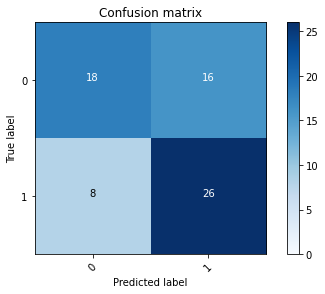

2022-08-03 20:56:47 - [Epoch Train: 85] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:56:47 - [Epoch Valid: 85] loss: 1.8386, auc: 0.7093, acc: 0.6471, time: 6.00 s


 57%|███████████████████████▊                  | 85/150 [42:17<31:29, 29.07s/it]

2022-08-03 20:56:47 - EPOCH: 86
2022-08-03 20:56:51 - Train Step 10/60, train_loss: 0.0003
2022-08-03 20:56:55 - Train Step 20/60, train_loss: 0.0002
2022-08-03 20:56:58 - Train Step 30/60, train_loss: 0.0002
2022-08-03 20:57:02 - Train Step 40/60, train_loss: 0.0002
2022-08-03 20:57:06 - Train Step 50/60, train_loss: 0.0002
2022-08-03 20:57:09 - Train Step 60/60, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:57:12 - Valid Step 5/17, valid_loss: 1.6585
2022-08-03 20:57:13 - Valid Step 10/17, valid_loss: 2.0307
2022-08-03 20:57:15 - Valid Step 15/17, valid_loss: 1.8937
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
30  UPENN-GBM-00092_11_T1w                0           1
22  UPENN-GBM-00093_11_T1w                0           0
18  UPENN-GBM-00094_11_T1w                0           1
1   UPENN-GBM-00115_11_T1w                1           1
53  UPENN-GBM-00117_11_T1w                0           1
41  UPENN-GBM-00128_11_T1w        

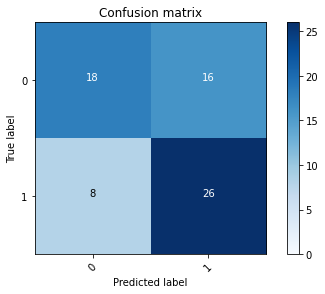

2022-08-03 20:57:16 - [Epoch Train: 86] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:57:16 - [Epoch Valid: 86] loss: 1.8731, auc: 0.7163, acc: 0.6471, time: 7.00 s


 57%|████████████████████████                  | 86/150 [42:46<30:56, 29.02s/it]

2022-08-03 20:57:16 - EPOCH: 87
2022-08-03 20:57:20 - Train Step 10/60, train_loss: 0.0001
2022-08-03 20:57:24 - Train Step 20/60, train_loss: 0.0001
2022-08-03 20:57:28 - Train Step 30/60, train_loss: 0.0001
2022-08-03 20:57:31 - Train Step 40/60, train_loss: 0.0001
2022-08-03 20:57:35 - Train Step 50/60, train_loss: 0.0001
2022-08-03 20:57:38 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:57:41 - Valid Step 5/17, valid_loss: 2.2651
2022-08-03 20:57:42 - Valid Step 10/17, valid_loss: 1.8046
2022-08-03 20:57:44 - Valid Step 15/17, valid_loss: 1.4162
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
62  UPENN-GBM-00092_11_T1w                0           1
66  UPENN-GBM-00093_11_T1w                0           0
53  UPENN-GBM-00094_11_T1w                0           1
38  UPENN-GBM-00115_11_T1w                1           1
4   UPENN-GBM-00117_11_T1w                0           1
51  UPENN-GBM-00128_11_T1w        

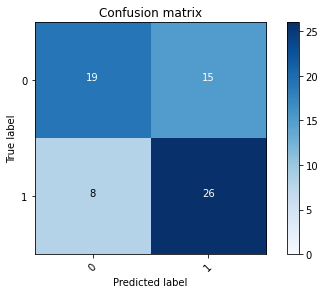

2022-08-03 20:57:45 - [Epoch Train: 87] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:57:45 - [Epoch Valid: 87] loss: 1.7832, auc: 0.7119, acc: 0.6618, time: 6.00 s
2022-08-03 20:57:45 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e87-loss1.783-acc0.662-auc0.712.pth'


 58%|████████████████████████▎                 | 87/150 [43:15<30:27, 29.01s/it]

2022-08-03 20:57:45 - EPOCH: 88
2022-08-03 20:57:49 - Train Step 10/60, train_loss: 0.0001
2022-08-03 20:57:53 - Train Step 20/60, train_loss: 0.0001
2022-08-03 20:57:57 - Train Step 30/60, train_loss: 0.0001
2022-08-03 20:58:00 - Train Step 40/60, train_loss: 0.0001
2022-08-03 20:58:04 - Train Step 50/60, train_loss: 0.0001
2022-08-03 20:58:08 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:58:10 - Valid Step 5/17, valid_loss: 1.9851
2022-08-03 20:58:12 - Valid Step 10/17, valid_loss: 1.6357
2022-08-03 20:58:14 - Valid Step 15/17, valid_loss: 1.8520
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
6   UPENN-GBM-00092_11_T1w                0           1
55  UPENN-GBM-00093_11_T1w                0           0
31  UPENN-GBM-00094_11_T1w                0           1
64  UPENN-GBM-00115_11_T1w                1           1
44  UPENN-GBM-00117_11_T1w                0           1
18  UPENN-GBM-00128_11_T1w        

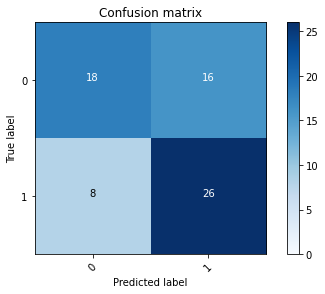

2022-08-03 20:58:15 - [Epoch Train: 88] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:58:15 - [Epoch Valid: 88] loss: 1.8733, auc: 0.7111, acc: 0.6471, time: 7.00 s


 59%|████████████████████████▋                 | 88/150 [43:45<30:07, 29.15s/it]

2022-08-03 20:58:15 - EPOCH: 89
2022-08-03 20:58:19 - Train Step 10/60, train_loss: 0.0001
2022-08-03 20:58:22 - Train Step 20/60, train_loss: 0.0001
2022-08-03 20:58:26 - Train Step 30/60, train_loss: 0.0001
2022-08-03 20:58:30 - Train Step 40/60, train_loss: 0.0001
2022-08-03 20:58:33 - Train Step 50/60, train_loss: 0.0001
2022-08-03 20:58:37 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:58:39 - Valid Step 5/17, valid_loss: 2.7488
2022-08-03 20:58:41 - Valid Step 10/17, valid_loss: 2.2646
2022-08-03 20:58:43 - Valid Step 15/17, valid_loss: 1.7329
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
62  UPENN-GBM-00092_11_T1w                0           1
44  UPENN-GBM-00093_11_T1w                0           0
38  UPENN-GBM-00094_11_T1w                0           1
54  UPENN-GBM-00115_11_T1w                1           1
51  UPENN-GBM-00117_11_T1w                0           1
58  UPENN-GBM-00128_11_T1w        

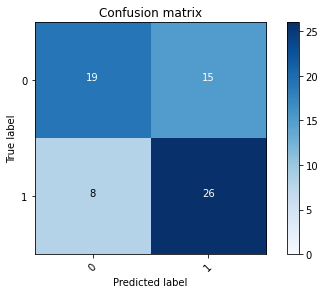

2022-08-03 20:58:44 - [Epoch Train: 89] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:58:44 - [Epoch Valid: 89] loss: 1.8636, auc: 0.7067, acc: 0.6618, time: 7.00 s
2022-08-03 20:58:44 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e89-loss1.864-acc0.662-auc0.707.pth'


 59%|████████████████████████▉                 | 89/150 [44:14<29:40, 29.18s/it]

2022-08-03 20:58:44 - EPOCH: 90
2022-08-03 20:58:48 - Train Step 10/60, train_loss: 0.0001
2022-08-03 20:58:52 - Train Step 20/60, train_loss: 0.0001
2022-08-03 20:58:55 - Train Step 30/60, train_loss: 0.0001
2022-08-03 20:58:59 - Train Step 40/60, train_loss: 0.0001
2022-08-03 20:59:02 - Train Step 50/60, train_loss: 0.0001
2022-08-03 20:59:06 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:59:08 - Valid Step 5/17, valid_loss: 2.6606
2022-08-03 20:59:10 - Valid Step 10/17, valid_loss: 2.2220
2022-08-03 20:59:12 - Valid Step 15/17, valid_loss: 2.1275
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
42  UPENN-GBM-00092_11_T1w                0           1
18  UPENN-GBM-00093_11_T1w                0           0
24  UPENN-GBM-00094_11_T1w                0           1
36  UPENN-GBM-00115_11_T1w                1           1
6   UPENN-GBM-00117_11_T1w                0           1
28  UPENN-GBM-00128_11_T1w        

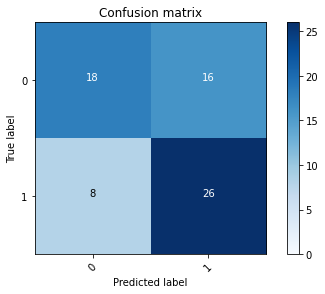

2022-08-03 20:59:13 - [Epoch Train: 90] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 20:59:13 - [Epoch Valid: 90] loss: 1.9336, auc: 0.7067, acc: 0.6471, time: 7.00 s


 60%|█████████████████████████▏                | 90/150 [44:43<29:11, 29.19s/it]

2022-08-03 20:59:13 - EPOCH: 91
2022-08-03 20:59:17 - Train Step 10/60, train_loss: 0.0001
2022-08-03 20:59:21 - Train Step 20/60, train_loss: 0.0001
2022-08-03 20:59:24 - Train Step 30/60, train_loss: 0.0001
2022-08-03 20:59:28 - Train Step 40/60, train_loss: 0.0001
2022-08-03 20:59:32 - Train Step 50/60, train_loss: 0.0001
2022-08-03 20:59:35 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 20:59:37 - Valid Step 5/17, valid_loss: 1.8747
2022-08-03 20:59:39 - Valid Step 10/17, valid_loss: 2.0925
2022-08-03 20:59:41 - Valid Step 15/17, valid_loss: 1.8902
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
29  UPENN-GBM-00092_11_T1w                0           1
17  UPENN-GBM-00093_11_T1w                0           0
66  UPENN-GBM-00094_11_T1w                0           1
43  UPENN-GBM-00115_11_T1w                1           1
27  UPENN-GBM-00117_11_T1w                0           1
10  UPENN-GBM-00128_11_T1w        

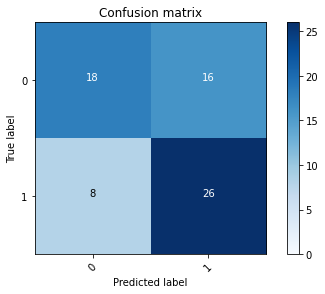

2022-08-03 20:59:42 - [Epoch Train: 91] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 20:59:42 - [Epoch Valid: 91] loss: 1.8845, auc: 0.7076, acc: 0.6471, time: 6.00 s


 61%|█████████████████████████▍                | 91/150 [45:12<28:37, 29.10s/it]

2022-08-03 20:59:42 - EPOCH: 92
2022-08-03 20:59:46 - Train Step 10/60, train_loss: 0.0000
2022-08-03 20:59:50 - Train Step 20/60, train_loss: 0.0001
2022-08-03 20:59:53 - Train Step 30/60, train_loss: 0.0001
2022-08-03 20:59:57 - Train Step 40/60, train_loss: 0.0001
2022-08-03 21:00:01 - Train Step 50/60, train_loss: 0.0001
2022-08-03 21:00:04 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:00:06 - Valid Step 5/17, valid_loss: 1.1247
2022-08-03 21:00:08 - Valid Step 10/17, valid_loss: 1.2723
2022-08-03 21:00:10 - Valid Step 15/17, valid_loss: 1.8295
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
66  UPENN-GBM-00092_11_T1w                0           1
15  UPENN-GBM-00093_11_T1w                0           0
48  UPENN-GBM-00094_11_T1w                0           1
17  UPENN-GBM-00115_11_T1w                1           1
56  UPENN-GBM-00117_11_T1w                0           1
65  UPENN-GBM-00128_11_T1w        

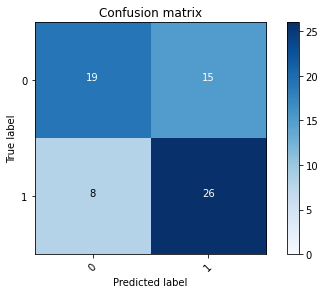

2022-08-03 21:00:11 - [Epoch Train: 92] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 21:00:11 - [Epoch Valid: 92] loss: 1.8461, auc: 0.7085, acc: 0.6618, time: 6.00 s
2022-08-03 21:00:11 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e92-loss1.846-acc0.662-auc0.708.pth'


 61%|█████████████████████████▊                | 92/150 [45:41<28:04, 29.04s/it]

2022-08-03 21:00:11 - EPOCH: 93
2022-08-03 21:00:15 - Train Step 10/60, train_loss: 0.0001
2022-08-03 21:00:19 - Train Step 20/60, train_loss: 0.0001
2022-08-03 21:00:22 - Train Step 30/60, train_loss: 0.0001
2022-08-03 21:00:26 - Train Step 40/60, train_loss: 0.0001
2022-08-03 21:00:29 - Train Step 50/60, train_loss: 0.0001
2022-08-03 21:00:33 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:00:35 - Valid Step 5/17, valid_loss: 2.0551
2022-08-03 21:00:37 - Valid Step 10/17, valid_loss: 2.2855
2022-08-03 21:00:39 - Valid Step 15/17, valid_loss: 1.8233
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
2   UPENN-GBM-00092_11_T1w                0           1
22  UPENN-GBM-00093_11_T1w                0           0
36  UPENN-GBM-00094_11_T1w                0           1
6   UPENN-GBM-00115_11_T1w                1           1
59  UPENN-GBM-00117_11_T1w                0           1
25  UPENN-GBM-00128_11_T1w        

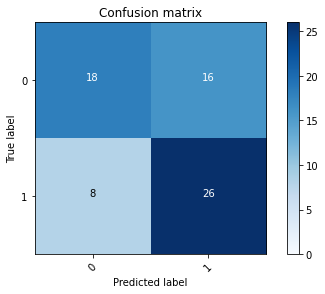

2022-08-03 21:00:40 - [Epoch Train: 93] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 21:00:40 - [Epoch Valid: 93] loss: 1.8341, auc: 0.7076, acc: 0.6471, time: 6.00 s


 62%|██████████████████████████                | 93/150 [46:10<27:33, 29.01s/it]

2022-08-03 21:00:40 - EPOCH: 94
2022-08-03 21:00:44 - Train Step 10/60, train_loss: 0.0001
2022-08-03 21:00:48 - Train Step 20/60, train_loss: 0.0001
2022-08-03 21:00:51 - Train Step 30/60, train_loss: 0.0001
2022-08-03 21:00:55 - Train Step 40/60, train_loss: 0.0001
2022-08-03 21:00:58 - Train Step 50/60, train_loss: 0.0001
2022-08-03 21:01:02 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:01:04 - Valid Step 5/17, valid_loss: 0.8440
2022-08-03 21:01:06 - Valid Step 10/17, valid_loss: 1.8143
2022-08-03 21:01:08 - Valid Step 15/17, valid_loss: 1.8060
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
40  UPENN-GBM-00092_11_T1w                0           1
28  UPENN-GBM-00093_11_T1w                0           0
14  UPENN-GBM-00094_11_T1w                0           1
32  UPENN-GBM-00115_11_T1w                1           1
8   UPENN-GBM-00117_11_T1w                0           1
59  UPENN-GBM-00128_11_T1w        

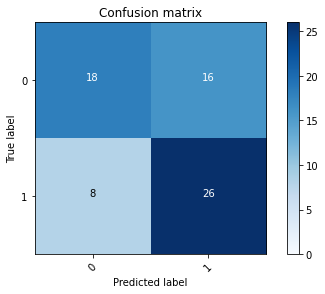

2022-08-03 21:01:09 - [Epoch Train: 94] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 21:01:09 - [Epoch Valid: 94] loss: 1.8415, auc: 0.7102, acc: 0.6471, time: 7.00 s


 63%|██████████████████████████▎               | 94/150 [46:39<27:08, 29.08s/it]

2022-08-03 21:01:09 - EPOCH: 95
2022-08-03 21:01:13 - Train Step 10/60, train_loss: 0.0001
2022-08-03 21:01:17 - Train Step 20/60, train_loss: 0.0001
2022-08-03 21:01:20 - Train Step 30/60, train_loss: 0.0001
2022-08-03 21:01:24 - Train Step 40/60, train_loss: 0.0001
2022-08-03 21:01:27 - Train Step 50/60, train_loss: 0.0001
2022-08-03 21:01:31 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:01:33 - Valid Step 5/17, valid_loss: 1.9170
2022-08-03 21:01:35 - Valid Step 10/17, valid_loss: 1.5214
2022-08-03 21:01:37 - Valid Step 15/17, valid_loss: 1.9261
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
3   UPENN-GBM-00092_11_T1w                0           1
20  UPENN-GBM-00093_11_T1w                0           0
14  UPENN-GBM-00094_11_T1w                0           1
52  UPENN-GBM-00115_11_T1w                1           1
46  UPENN-GBM-00117_11_T1w                0           1
48  UPENN-GBM-00128_11_T1w        

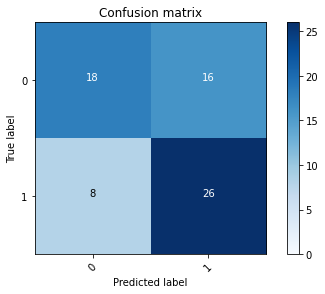

2022-08-03 21:01:38 - [Epoch Train: 95] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 21:01:38 - [Epoch Valid: 95] loss: 1.8548, auc: 0.7154, acc: 0.6471, time: 6.00 s


 63%|██████████████████████████▌               | 95/150 [47:08<26:28, 28.88s/it]

2022-08-03 21:01:38 - EPOCH: 96
2022-08-03 21:01:42 - Train Step 10/60, train_loss: 0.0001
2022-08-03 21:01:45 - Train Step 20/60, train_loss: 0.0001
2022-08-03 21:01:49 - Train Step 30/60, train_loss: 0.0001
2022-08-03 21:01:53 - Train Step 40/60, train_loss: 0.0001
2022-08-03 21:01:56 - Train Step 50/60, train_loss: 0.0001
2022-08-03 21:02:00 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:02:02 - Valid Step 5/17, valid_loss: 1.3656
2022-08-03 21:02:04 - Valid Step 10/17, valid_loss: 2.4064
2022-08-03 21:02:06 - Valid Step 15/17, valid_loss: 1.9898
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
0   UPENN-GBM-00092_11_T1w                0           1
12  UPENN-GBM-00093_11_T1w                0           0
35  UPENN-GBM-00094_11_T1w                0           1
28  UPENN-GBM-00115_11_T1w                1           1
65  UPENN-GBM-00117_11_T1w                0           1
45  UPENN-GBM-00128_11_T1w        

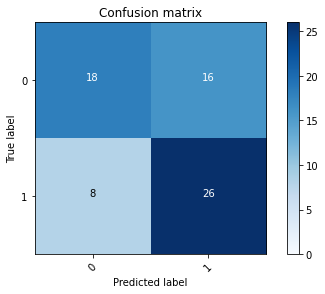

2022-08-03 21:02:07 - [Epoch Train: 96] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 21:02:07 - [Epoch Valid: 96] loss: 1.8877, auc: 0.7076, acc: 0.6471, time: 7.00 s


 64%|██████████████████████████▉               | 96/150 [47:37<26:09, 29.07s/it]

2022-08-03 21:02:07 - EPOCH: 97
2022-08-03 21:02:11 - Train Step 10/60, train_loss: 0.0001
2022-08-03 21:02:15 - Train Step 20/60, train_loss: 0.0001
2022-08-03 21:02:18 - Train Step 30/60, train_loss: 0.0001
2022-08-03 21:02:22 - Train Step 40/60, train_loss: 0.0001
2022-08-03 21:02:26 - Train Step 50/60, train_loss: 0.0001
2022-08-03 21:02:29 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:02:32 - Valid Step 5/17, valid_loss: 1.5271
2022-08-03 21:02:33 - Valid Step 10/17, valid_loss: 1.4625
2022-08-03 21:02:35 - Valid Step 15/17, valid_loss: 1.8463
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
66  UPENN-GBM-00092_11_T1w                0           1
16  UPENN-GBM-00093_11_T1w                0           0
26  UPENN-GBM-00094_11_T1w                0           1
49  UPENN-GBM-00115_11_T1w                1           1
14  UPENN-GBM-00117_11_T1w                0           1
11  UPENN-GBM-00128_11_T1w        

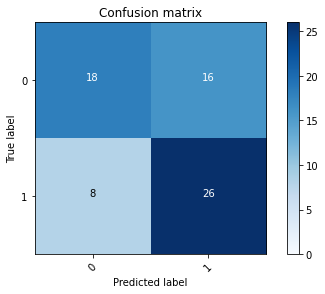

2022-08-03 21:02:36 - [Epoch Train: 97] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 21:02:36 - [Epoch Valid: 97] loss: 1.8726, auc: 0.7119, acc: 0.6471, time: 7.00 s


 65%|███████████████████████████▏              | 97/150 [48:06<25:42, 29.11s/it]

2022-08-03 21:02:36 - EPOCH: 98
2022-08-03 21:02:40 - Train Step 10/60, train_loss: 0.0001
2022-08-03 21:02:44 - Train Step 20/60, train_loss: 0.0001
2022-08-03 21:02:48 - Train Step 30/60, train_loss: 0.0001
2022-08-03 21:02:51 - Train Step 40/60, train_loss: 0.0001
2022-08-03 21:02:55 - Train Step 50/60, train_loss: 0.0001
2022-08-03 21:02:59 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:03:01 - Valid Step 5/17, valid_loss: 1.0552
2022-08-03 21:03:02 - Valid Step 10/17, valid_loss: 1.0964
2022-08-03 21:03:05 - Valid Step 15/17, valid_loss: 1.8261
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
56  UPENN-GBM-00092_11_T1w                0           1
9   UPENN-GBM-00093_11_T1w                0           0
6   UPENN-GBM-00094_11_T1w                0           1
1   UPENN-GBM-00115_11_T1w                1           1
42  UPENN-GBM-00117_11_T1w                0           1
18  UPENN-GBM-00128_11_T1w        

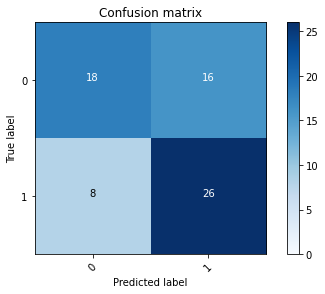

2022-08-03 21:03:05 - [Epoch Train: 98] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 21:03:05 - [Epoch Valid: 98] loss: 1.9572, auc: 0.7067, acc: 0.6471, time: 6.00 s


 65%|███████████████████████████▍              | 98/150 [48:35<25:13, 29.11s/it]

2022-08-03 21:03:05 - EPOCH: 99
2022-08-03 21:03:09 - Train Step 10/60, train_loss: 0.0001
2022-08-03 21:03:13 - Train Step 20/60, train_loss: 0.0001
2022-08-03 21:03:17 - Train Step 30/60, train_loss: 0.0001
2022-08-03 21:03:20 - Train Step 40/60, train_loss: 0.0001
2022-08-03 21:03:24 - Train Step 50/60, train_loss: 0.0001
2022-08-03 21:03:28 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:03:30 - Valid Step 5/17, valid_loss: 2.5553
2022-08-03 21:03:32 - Valid Step 10/17, valid_loss: 1.9106
2022-08-03 21:03:34 - Valid Step 15/17, valid_loss: 1.8578
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
8   UPENN-GBM-00092_11_T1w                0           1
32  UPENN-GBM-00093_11_T1w                0           0
34  UPENN-GBM-00094_11_T1w                0           1
39  UPENN-GBM-00115_11_T1w                1           1
53  UPENN-GBM-00117_11_T1w                0           1
24  UPENN-GBM-00128_11_T1w        

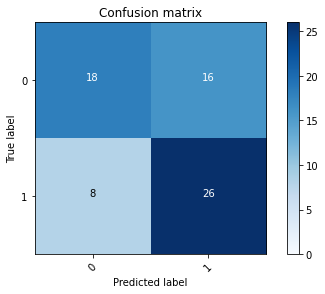

2022-08-03 21:03:35 - [Epoch Train: 99] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 21:03:35 - [Epoch Valid: 99] loss: 1.9366, auc: 0.7093, acc: 0.6471, time: 7.00 s


 66%|███████████████████████████▋              | 99/150 [49:05<24:48, 29.19s/it]

2022-08-03 21:03:35 - EPOCH: 100
2022-08-03 21:03:39 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:03:42 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:03:46 - Train Step 30/60, train_loss: 0.0001
2022-08-03 21:03:50 - Train Step 40/60, train_loss: 0.0001
2022-08-03 21:03:53 - Train Step 50/60, train_loss: 0.0001
2022-08-03 21:03:57 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:03:59 - Valid Step 5/17, valid_loss: 1.7783
2022-08-03 21:04:01 - Valid Step 10/17, valid_loss: 1.9224
2022-08-03 21:04:03 - Valid Step 15/17, valid_loss: 1.9380
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
56  UPENN-GBM-00092_11_T1w                0           1
38  UPENN-GBM-00093_11_T1w                0           0
63  UPENN-GBM-00094_11_T1w                0           1
58  UPENN-GBM-00115_11_T1w                1           1
39  UPENN-GBM-00117_11_T1w                0           1
51  UPENN-GBM-00128_11_T1w       

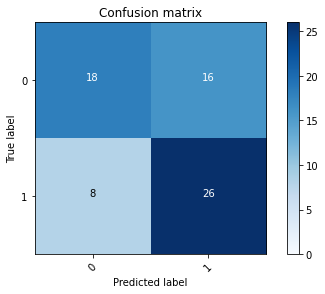

2022-08-03 21:04:04 - [Epoch Train: 100] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 21:04:04 - [Epoch Valid: 100] loss: 1.8855, auc: 0.7089, acc: 0.6471, time: 6.00 s


 67%|███████████████████████████▎             | 100/150 [49:34<24:19, 29.19s/it]

2022-08-03 21:04:04 - EPOCH: 101
2022-08-03 21:04:08 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:04:12 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:04:15 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:04:19 - Train Step 40/60, train_loss: 0.0001
2022-08-03 21:04:23 - Train Step 50/60, train_loss: 0.0001
2022-08-03 21:04:26 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:04:29 - Valid Step 5/17, valid_loss: 2.5140
2022-08-03 21:04:30 - Valid Step 10/17, valid_loss: 2.7971
2022-08-03 21:04:32 - Valid Step 15/17, valid_loss: 2.1873
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
24  UPENN-GBM-00092_11_T1w                0           1
13  UPENN-GBM-00093_11_T1w                0           0
21  UPENN-GBM-00094_11_T1w                0           1
53  UPENN-GBM-00115_11_T1w                1           1
12  UPENN-GBM-00117_11_T1w                0           1
57  UPENN-GBM-00128_11_T1w       

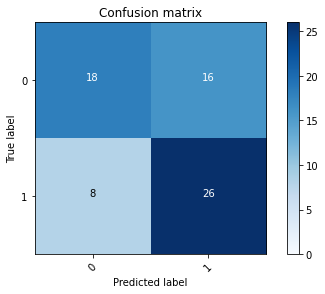

2022-08-03 21:04:33 - [Epoch Train: 101] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 21:04:33 - [Epoch Valid: 101] loss: 1.9583, auc: 0.7050, acc: 0.6471, time: 7.00 s


 67%|███████████████████████████▌             | 101/150 [50:03<23:52, 29.24s/it]

2022-08-03 21:04:33 - EPOCH: 102
2022-08-03 21:04:37 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:04:41 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:04:45 - Train Step 30/60, train_loss: 0.0001
2022-08-03 21:04:48 - Train Step 40/60, train_loss: 0.0001
2022-08-03 21:04:52 - Train Step 50/60, train_loss: 0.0001
2022-08-03 21:04:55 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:04:58 - Valid Step 5/17, valid_loss: 2.1627
2022-08-03 21:04:59 - Valid Step 10/17, valid_loss: 2.3502
2022-08-03 21:05:02 - Valid Step 15/17, valid_loss: 2.0448
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
55  UPENN-GBM-00092_11_T1w                0           1
31  UPENN-GBM-00093_11_T1w                0           0
1   UPENN-GBM-00094_11_T1w                0           1
5   UPENN-GBM-00115_11_T1w                1           1
33  UPENN-GBM-00117_11_T1w                0           1
37  UPENN-GBM-00128_11_T1w       

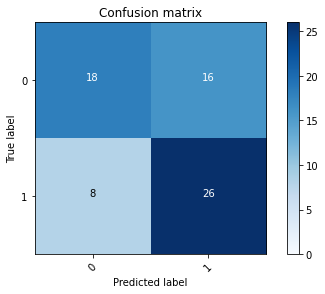

2022-08-03 21:05:02 - [Epoch Train: 102] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 21:05:02 - [Epoch Valid: 102] loss: 1.9530, auc: 0.7141, acc: 0.6471, time: 6.00 s


 68%|███████████████████████████▉             | 102/150 [50:32<23:21, 29.19s/it]

2022-08-03 21:05:02 - EPOCH: 103
2022-08-03 21:05:06 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:05:10 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:05:14 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:05:17 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:05:21 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:05:24 - Train Step 60/60, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:05:26 - Valid Step 5/17, valid_loss: 2.8256
2022-08-03 21:05:28 - Valid Step 10/17, valid_loss: 2.4429
2022-08-03 21:05:30 - Valid Step 15/17, valid_loss: 2.1440
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
45  UPENN-GBM-00092_11_T1w                0           1
4   UPENN-GBM-00093_11_T1w                0           0
37  UPENN-GBM-00094_11_T1w                0           1
2   UPENN-GBM-00115_11_T1w                1           1
14  UPENN-GBM-00117_11_T1w                0           1
58  UPENN-GBM-00128_11_T1w       

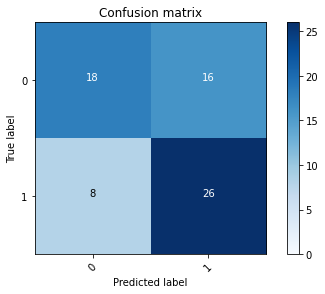

2022-08-03 21:05:31 - [Epoch Train: 103] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 21:05:31 - [Epoch Valid: 103] loss: 1.9851, auc: 0.7093, acc: 0.6471, time: 7.00 s


 69%|████████████████████████████▏            | 103/150 [51:01<22:47, 29.09s/it]

2022-08-03 21:05:31 - EPOCH: 104
2022-08-03 21:05:35 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:05:39 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:05:43 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:05:46 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:05:50 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:05:53 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:05:56 - Valid Step 5/17, valid_loss: 2.6734
2022-08-03 21:05:57 - Valid Step 10/17, valid_loss: 2.7844
2022-08-03 21:05:59 - Valid Step 15/17, valid_loss: 2.2427
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
26  UPENN-GBM-00092_11_T1w                0           1
37  UPENN-GBM-00093_11_T1w                0           0
35  UPENN-GBM-00094_11_T1w                0           1
48  UPENN-GBM-00115_11_T1w                1           1
12  UPENN-GBM-00117_11_T1w                0           1
16  UPENN-GBM-00128_11_T1w       

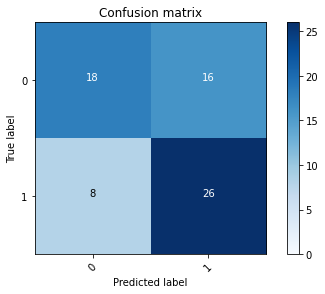

2022-08-03 21:06:00 - [Epoch Train: 104] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 21:06:00 - [Epoch Valid: 104] loss: 1.9908, auc: 0.7042, acc: 0.6471, time: 6.00 s


 69%|████████████████████████████▍            | 104/150 [51:30<22:17, 29.09s/it]

2022-08-03 21:06:00 - EPOCH: 105
2022-08-03 21:06:04 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:06:08 - Train Step 20/60, train_loss: 0.0001
2022-08-03 21:06:12 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:06:15 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:06:19 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:06:22 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:06:25 - Valid Step 5/17, valid_loss: 1.1089
2022-08-03 21:06:27 - Valid Step 10/17, valid_loss: 1.8053
2022-08-03 21:06:29 - Valid Step 15/17, valid_loss: 1.5377
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
24  UPENN-GBM-00092_11_T1w                0           1
55  UPENN-GBM-00093_11_T1w                0           0
9   UPENN-GBM-00094_11_T1w                0           1
16  UPENN-GBM-00115_11_T1w                1           1
66  UPENN-GBM-00117_11_T1w                0           1
14  UPENN-GBM-00128_11_T1w       

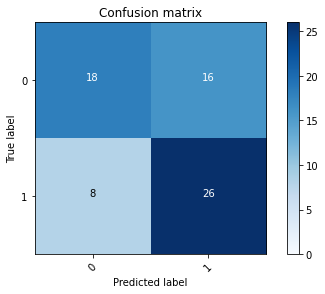

2022-08-03 21:06:30 - [Epoch Train: 105] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 21:06:30 - [Epoch Valid: 105] loss: 1.9532, auc: 0.7115, acc: 0.6471, time: 7.00 s


 70%|████████████████████████████▋            | 105/150 [52:00<21:52, 29.16s/it]

2022-08-03 21:06:30 - EPOCH: 106
2022-08-03 21:06:34 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:06:37 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:06:41 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:06:45 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:06:48 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:06:52 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:06:54 - Valid Step 5/17, valid_loss: 1.3696
2022-08-03 21:06:56 - Valid Step 10/17, valid_loss: 1.7265
2022-08-03 21:06:58 - Valid Step 15/17, valid_loss: 2.0978
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
37  UPENN-GBM-00092_11_T1w                0           1
46  UPENN-GBM-00093_11_T1w                0           0
14  UPENN-GBM-00094_11_T1w                0           1
60  UPENN-GBM-00115_11_T1w                1           1
59  UPENN-GBM-00117_11_T1w                0           1
62  UPENN-GBM-00128_11_T1w       

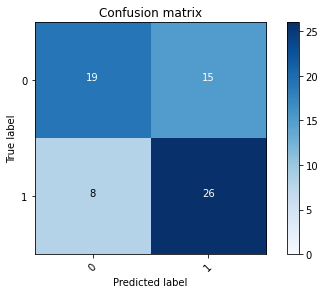

2022-08-03 21:06:59 - [Epoch Train: 106] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 21:06:59 - [Epoch Valid: 106] loss: 1.8967, auc: 0.7137, acc: 0.6618, time: 7.00 s
2022-08-03 21:06:59 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e106-loss1.897-acc0.662-auc0.714.pth'


 71%|████████████████████████████▉            | 106/150 [52:29<21:21, 29.13s/it]

2022-08-03 21:06:59 - EPOCH: 107
2022-08-03 21:07:03 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:07:06 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:07:10 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:07:14 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:07:17 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:07:21 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:07:23 - Valid Step 5/17, valid_loss: 1.5874
2022-08-03 21:07:25 - Valid Step 10/17, valid_loss: 1.9218
2022-08-03 21:07:27 - Valid Step 15/17, valid_loss: 1.8777
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
17  UPENN-GBM-00092_11_T1w                0           1
60  UPENN-GBM-00093_11_T1w                0           0
19  UPENN-GBM-00094_11_T1w                0           1
34  UPENN-GBM-00115_11_T1w                1           1
64  UPENN-GBM-00117_11_T1w                0           1
29  UPENN-GBM-00128_11_T1w       

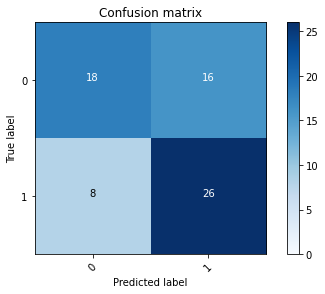

2022-08-03 21:07:28 - [Epoch Train: 107] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 21:07:28 - [Epoch Valid: 107] loss: 1.9670, auc: 0.7085, acc: 0.6471, time: 7.00 s


 71%|█████████████████████████████▏           | 107/150 [52:58<20:55, 29.20s/it]

2022-08-03 21:07:28 - EPOCH: 108
2022-08-03 21:07:32 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:07:36 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:07:40 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:07:43 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:07:47 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:07:50 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:07:53 - Valid Step 5/17, valid_loss: 1.5261
2022-08-03 21:07:55 - Valid Step 10/17, valid_loss: 1.9673
2022-08-03 21:07:57 - Valid Step 15/17, valid_loss: 1.7987
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
48  UPENN-GBM-00092_11_T1w                0           1
42  UPENN-GBM-00093_11_T1w                0           0
27  UPENN-GBM-00094_11_T1w                0           1
58  UPENN-GBM-00115_11_T1w                1           1
20  UPENN-GBM-00117_11_T1w                0           1
65  UPENN-GBM-00128_11_T1w       

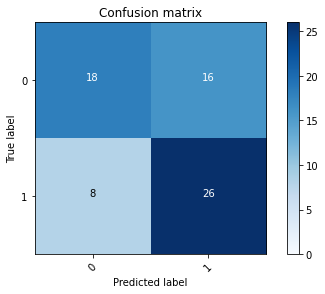

2022-08-03 21:07:58 - [Epoch Train: 108] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-08-03 21:07:58 - [Epoch Valid: 108] loss: 1.9841, auc: 0.7102, acc: 0.6471, time: 7.00 s


 72%|█████████████████████████████▌           | 108/150 [53:28<20:30, 29.29s/it]

2022-08-03 21:07:58 - EPOCH: 109
2022-08-03 21:08:02 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:08:05 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:08:09 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:08:12 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:08:16 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:08:19 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:08:22 - Valid Step 5/17, valid_loss: 2.1647
2022-08-03 21:08:23 - Valid Step 10/17, valid_loss: 1.8541
2022-08-03 21:08:25 - Valid Step 15/17, valid_loss: 1.7413
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
13  UPENN-GBM-00092_11_T1w                0           1
64  UPENN-GBM-00093_11_T1w                0           0
60  UPENN-GBM-00094_11_T1w                0           1
57  UPENN-GBM-00115_11_T1w                1           1
49  UPENN-GBM-00117_11_T1w                0           1
45  UPENN-GBM-00128_11_T1w       

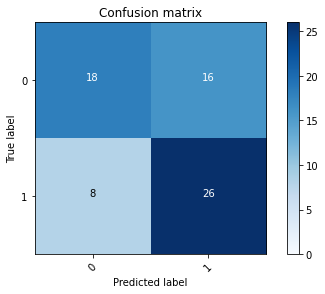

2022-08-03 21:08:26 - [Epoch Train: 109] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-08-03 21:08:26 - [Epoch Valid: 109] loss: 1.8894, auc: 0.7163, acc: 0.6471, time: 6.00 s


 73%|█████████████████████████████▊           | 109/150 [53:56<19:53, 29.11s/it]

2022-08-03 21:08:26 - EPOCH: 110
2022-08-03 21:08:31 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:08:35 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:08:39 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:08:43 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:08:47 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:08:51 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:08:54 - Valid Step 5/17, valid_loss: 3.5502
2022-08-03 21:08:56 - Valid Step 10/17, valid_loss: 2.3009
2022-08-03 21:08:58 - Valid Step 15/17, valid_loss: 1.7848
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
61  UPENN-GBM-00092_11_T1w                0           1
21  UPENN-GBM-00093_11_T1w                0           0
8   UPENN-GBM-00094_11_T1w                0           1
28  UPENN-GBM-00115_11_T1w                1           1
3   UPENN-GBM-00117_11_T1w                0           1
35  UPENN-GBM-00128_11_T1w       

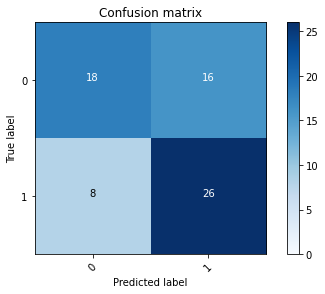

2022-08-03 21:08:59 - [Epoch Train: 110] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:08:59 - [Epoch Valid: 110] loss: 1.9652, auc: 0.7050, acc: 0.6471, time: 7.00 s


 73%|██████████████████████████████           | 110/150 [54:29<20:07, 30.18s/it]

2022-08-03 21:08:59 - EPOCH: 111
2022-08-03 21:09:03 - Train Step 10/60, train_loss: 0.0001
2022-08-03 21:09:07 - Train Step 20/60, train_loss: 0.0001
2022-08-03 21:09:11 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:09:15 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:09:19 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:09:23 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:09:26 - Valid Step 5/17, valid_loss: 2.8307
2022-08-03 21:09:27 - Valid Step 10/17, valid_loss: 2.4884
2022-08-03 21:09:30 - Valid Step 15/17, valid_loss: 1.9258
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
57  UPENN-GBM-00092_11_T1w                0           1
22  UPENN-GBM-00093_11_T1w                0           0
26  UPENN-GBM-00094_11_T1w                0           1
21  UPENN-GBM-00115_11_T1w                1           1
67  UPENN-GBM-00117_11_T1w                0           1
37  UPENN-GBM-00128_11_T1w       

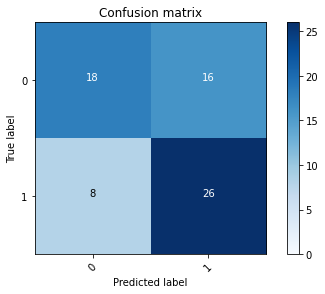

2022-08-03 21:09:31 - [Epoch Train: 111] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:09:31 - [Epoch Valid: 111] loss: 1.9397, auc: 0.7102, acc: 0.6471, time: 7.00 s


 74%|██████████████████████████████▎          | 111/150 [55:01<19:54, 30.62s/it]

2022-08-03 21:09:31 - EPOCH: 112
2022-08-03 21:09:35 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:09:39 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:09:43 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:09:46 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:09:50 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:09:54 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:09:56 - Valid Step 5/17, valid_loss: 2.8313
2022-08-03 21:09:58 - Valid Step 10/17, valid_loss: 2.6748
2022-08-03 21:10:01 - Valid Step 15/17, valid_loss: 2.2660
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
37  UPENN-GBM-00092_11_T1w                0           1
61  UPENN-GBM-00093_11_T1w                0           0
45  UPENN-GBM-00094_11_T1w                0           1
15  UPENN-GBM-00115_11_T1w                1           1
9   UPENN-GBM-00117_11_T1w                0           1
16  UPENN-GBM-00128_11_T1w       

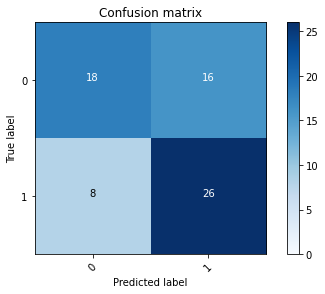

2022-08-03 21:10:02 - [Epoch Train: 112] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:10:02 - [Epoch Valid: 112] loss: 2.0157, auc: 0.7085, acc: 0.6471, time: 7.00 s


 75%|██████████████████████████████▌          | 112/150 [55:32<19:27, 30.73s/it]

2022-08-03 21:10:02 - EPOCH: 113
2022-08-03 21:10:06 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:10:10 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:10:14 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:10:18 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:10:22 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:10:27 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:10:30 - Valid Step 5/17, valid_loss: 2.3873
2022-08-03 21:10:32 - Valid Step 10/17, valid_loss: 2.2435
2022-08-03 21:10:35 - Valid Step 15/17, valid_loss: 2.2853
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
36  UPENN-GBM-00092_11_T1w                0           1
60  UPENN-GBM-00093_11_T1w                0           0
9   UPENN-GBM-00094_11_T1w                0           1
1   UPENN-GBM-00115_11_T1w                1           1
48  UPENN-GBM-00117_11_T1w                0           1
13  UPENN-GBM-00128_11_T1w       

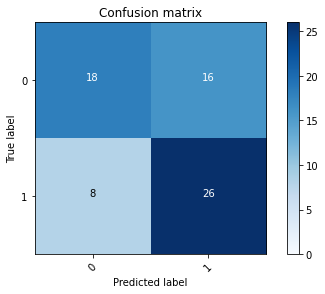

2022-08-03 21:10:35 - [Epoch Train: 113] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 25.00 s            
2022-08-03 21:10:35 - [Epoch Valid: 113] loss: 2.0248, auc: 0.7102, acc: 0.6471, time: 8.00 s


 75%|██████████████████████████████▉          | 113/150 [56:05<19:32, 31.68s/it]

2022-08-03 21:10:35 - EPOCH: 114
2022-08-03 21:10:40 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:10:44 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:10:48 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:10:52 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:10:56 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:11:00 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:11:03 - Valid Step 5/17, valid_loss: 0.7423
2022-08-03 21:11:05 - Valid Step 10/17, valid_loss: 1.4351
2022-08-03 21:11:07 - Valid Step 15/17, valid_loss: 1.8239
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
29  UPENN-GBM-00092_11_T1w                0           1
13  UPENN-GBM-00093_11_T1w                0           0
16  UPENN-GBM-00094_11_T1w                0           1
48  UPENN-GBM-00115_11_T1w                1           1
67  UPENN-GBM-00117_11_T1w                0           1
3   UPENN-GBM-00128_11_T1w       

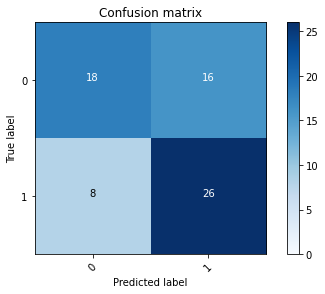

2022-08-03 21:11:08 - [Epoch Train: 114] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:11:08 - [Epoch Valid: 114] loss: 2.0303, auc: 0.7137, acc: 0.6471, time: 8.00 s


 76%|███████████████████████████████▏         | 114/150 [56:38<19:10, 31.96s/it]

2022-08-03 21:11:08 - EPOCH: 115
2022-08-03 21:11:13 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:11:17 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:11:21 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:11:25 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:11:29 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:11:32 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:11:35 - Valid Step 5/17, valid_loss: 2.2641
2022-08-03 21:11:37 - Valid Step 10/17, valid_loss: 1.7925
2022-08-03 21:11:39 - Valid Step 15/17, valid_loss: 2.1102
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
8   UPENN-GBM-00092_11_T1w                0           1
14  UPENN-GBM-00093_11_T1w                0           0
9   UPENN-GBM-00094_11_T1w                0           1
30  UPENN-GBM-00115_11_T1w                1           1
6   UPENN-GBM-00117_11_T1w                0           1
51  UPENN-GBM-00128_11_T1w       

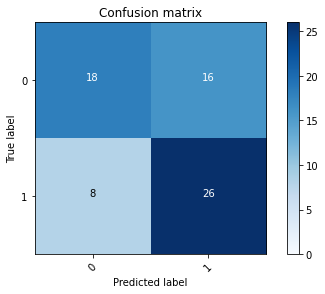

2022-08-03 21:11:40 - [Epoch Train: 115] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:11:40 - [Epoch Valid: 115] loss: 2.0155, auc: 0.7067, acc: 0.6471, time: 7.00 s


 77%|███████████████████████████████▍         | 115/150 [57:10<18:39, 31.99s/it]

2022-08-03 21:11:40 - EPOCH: 116
2022-08-03 21:11:45 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:11:49 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:11:53 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:11:57 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:12:01 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:12:05 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:12:08 - Valid Step 5/17, valid_loss: 2.9349
2022-08-03 21:12:10 - Valid Step 10/17, valid_loss: 2.2408
2022-08-03 21:12:12 - Valid Step 15/17, valid_loss: 1.9954
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
10  UPENN-GBM-00092_11_T1w                0           1
37  UPENN-GBM-00093_11_T1w                0           0
29  UPENN-GBM-00094_11_T1w                0           1
26  UPENN-GBM-00115_11_T1w                1           1
4   UPENN-GBM-00117_11_T1w                0           1
23  UPENN-GBM-00128_11_T1w       

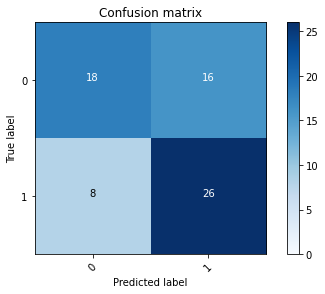

2022-08-03 21:12:13 - [Epoch Train: 116] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:12:13 - [Epoch Valid: 116] loss: 2.0446, auc: 0.7176, acc: 0.6471, time: 7.00 s


 77%|███████████████████████████████▋         | 116/150 [57:43<18:16, 32.25s/it]

2022-08-03 21:12:13 - EPOCH: 117
2022-08-03 21:12:18 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:12:22 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:12:26 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:12:30 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:12:34 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:12:38 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:12:41 - Valid Step 5/17, valid_loss: 3.4275
2022-08-03 21:12:42 - Valid Step 10/17, valid_loss: 2.3256
2022-08-03 21:12:45 - Valid Step 15/17, valid_loss: 2.3564
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
52  UPENN-GBM-00092_11_T1w                0           1
44  UPENN-GBM-00093_11_T1w                0           0
14  UPENN-GBM-00094_11_T1w                0           1
1   UPENN-GBM-00115_11_T1w                1           1
47  UPENN-GBM-00117_11_T1w                0           1
60  UPENN-GBM-00128_11_T1w       

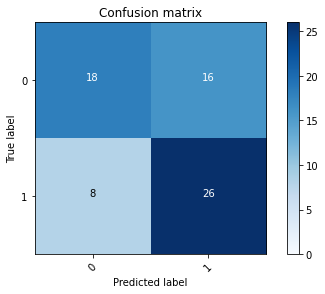

2022-08-03 21:12:46 - [Epoch Train: 117] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:12:46 - [Epoch Valid: 117] loss: 2.0876, auc: 0.7154, acc: 0.6471, time: 7.00 s


 78%|███████████████████████████████▉         | 117/150 [58:16<17:49, 32.42s/it]

2022-08-03 21:12:46 - EPOCH: 118
2022-08-03 21:12:50 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:12:54 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:12:58 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:13:03 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:13:07 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:13:11 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:13:13 - Valid Step 5/17, valid_loss: 1.8206
2022-08-03 21:13:15 - Valid Step 10/17, valid_loss: 1.3462
2022-08-03 21:13:18 - Valid Step 15/17, valid_loss: 1.5062
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
23  UPENN-GBM-00092_11_T1w                0           1
48  UPENN-GBM-00093_11_T1w                0           0
6   UPENN-GBM-00094_11_T1w                0           1
60  UPENN-GBM-00115_11_T1w                1           1
31  UPENN-GBM-00117_11_T1w                0           1
32  UPENN-GBM-00128_11_T1w       

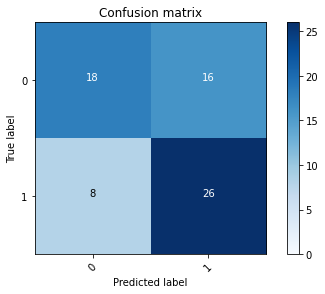

2022-08-03 21:13:19 - [Epoch Train: 118] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:13:19 - [Epoch Valid: 118] loss: 2.0107, auc: 0.7085, acc: 0.6471, time: 8.00 s


 79%|████████████████████████████████▎        | 118/150 [58:49<17:22, 32.57s/it]

2022-08-03 21:13:19 - EPOCH: 119
2022-08-03 21:13:23 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:13:27 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:13:32 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:13:36 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:13:40 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:13:44 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:13:47 - Valid Step 5/17, valid_loss: 0.9511
2022-08-03 21:13:49 - Valid Step 10/17, valid_loss: 1.9922
2022-08-03 21:13:51 - Valid Step 15/17, valid_loss: 2.0007
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
27  UPENN-GBM-00092_11_T1w                0           1
33  UPENN-GBM-00093_11_T1w                0           0
40  UPENN-GBM-00094_11_T1w                0           1
3   UPENN-GBM-00115_11_T1w                1           1
52  UPENN-GBM-00117_11_T1w                0           1
56  UPENN-GBM-00128_11_T1w       

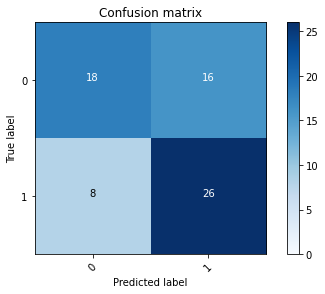

2022-08-03 21:13:52 - [Epoch Train: 119] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 25.00 s            
2022-08-03 21:13:52 - [Epoch Valid: 119] loss: 2.0860, auc: 0.7180, acc: 0.6471, time: 7.00 s


 79%|████████████████████████████████▌        | 119/150 [59:22<16:56, 32.80s/it]

2022-08-03 21:13:52 - EPOCH: 120
2022-08-03 21:13:56 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:14:00 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:14:04 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:14:08 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:14:13 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:14:17 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:14:19 - Valid Step 5/17, valid_loss: 2.6229
2022-08-03 21:14:21 - Valid Step 10/17, valid_loss: 1.8641
2022-08-03 21:14:23 - Valid Step 15/17, valid_loss: 1.7549
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
6   UPENN-GBM-00092_11_T1w                0           1
34  UPENN-GBM-00093_11_T1w                0           0
39  UPENN-GBM-00094_11_T1w                0           1
65  UPENN-GBM-00115_11_T1w                1           1
45  UPENN-GBM-00117_11_T1w                0           1
11  UPENN-GBM-00128_11_T1w       

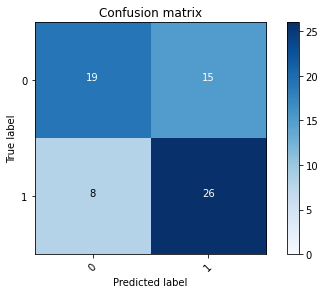

2022-08-03 21:14:24 - [Epoch Train: 120] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:14:24 - [Epoch Valid: 120] loss: 1.9440, auc: 0.7163, acc: 0.6618, time: 7.00 s
2022-08-03 21:14:24 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e120-loss1.944-acc0.662-auc0.716.pth'


 80%|████████████████████████████████▊        | 120/150 [59:54<16:17, 32.58s/it]

2022-08-03 21:14:24 - EPOCH: 121
2022-08-03 21:14:29 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:14:33 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:14:37 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:14:41 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:14:45 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:14:49 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:14:51 - Valid Step 5/17, valid_loss: 0.8553
2022-08-03 21:14:53 - Valid Step 10/17, valid_loss: 1.9705
2022-08-03 21:14:55 - Valid Step 15/17, valid_loss: 2.1594
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
39  UPENN-GBM-00092_11_T1w                0           1
0   UPENN-GBM-00093_11_T1w                0           0
56  UPENN-GBM-00094_11_T1w                0           1
46  UPENN-GBM-00115_11_T1w                1           1
12  UPENN-GBM-00117_11_T1w                0           1
52  UPENN-GBM-00128_11_T1w       

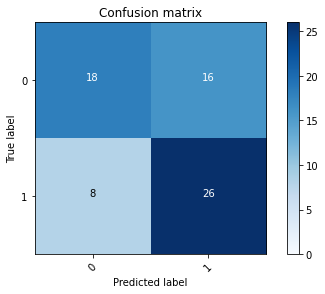

2022-08-03 21:14:56 - [Epoch Train: 121] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:14:56 - [Epoch Valid: 121] loss: 1.9679, auc: 0.7154, acc: 0.6471, time: 7.00 s


 81%|███████████████████████████████▍       | 121/150 [1:00:26<15:39, 32.41s/it]

2022-08-03 21:14:56 - EPOCH: 122
2022-08-03 21:15:01 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:15:05 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:15:08 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:15:12 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:15:16 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:15:20 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:15:23 - Valid Step 5/17, valid_loss: 2.6181
2022-08-03 21:15:24 - Valid Step 10/17, valid_loss: 2.1333
2022-08-03 21:15:27 - Valid Step 15/17, valid_loss: 2.0012
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
6   UPENN-GBM-00092_11_T1w                0           1
32  UPENN-GBM-00093_11_T1w                0           0
17  UPENN-GBM-00094_11_T1w                0           1
61  UPENN-GBM-00115_11_T1w                1           1
62  UPENN-GBM-00117_11_T1w                0           1
50  UPENN-GBM-00128_11_T1w       

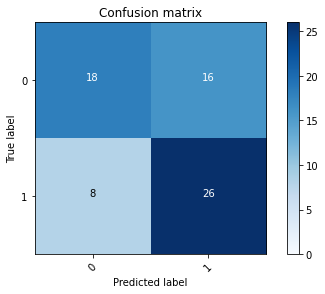

2022-08-03 21:15:28 - [Epoch Train: 122] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:15:28 - [Epoch Valid: 122] loss: 2.0682, auc: 0.7085, acc: 0.6471, time: 7.00 s


 81%|███████████████████████████████▋       | 122/150 [1:00:58<15:00, 32.15s/it]

2022-08-03 21:15:28 - EPOCH: 123
2022-08-03 21:15:32 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:15:36 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:15:40 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:15:44 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:15:48 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:15:52 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:15:54 - Valid Step 5/17, valid_loss: 1.3975
2022-08-03 21:15:56 - Valid Step 10/17, valid_loss: 1.9185
2022-08-03 21:15:58 - Valid Step 15/17, valid_loss: 2.1051
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
23  UPENN-GBM-00092_11_T1w                0           1
21  UPENN-GBM-00093_11_T1w                0           0
48  UPENN-GBM-00094_11_T1w                0           1
50  UPENN-GBM-00115_11_T1w                1           1
24  UPENN-GBM-00117_11_T1w                0           1
34  UPENN-GBM-00128_11_T1w       

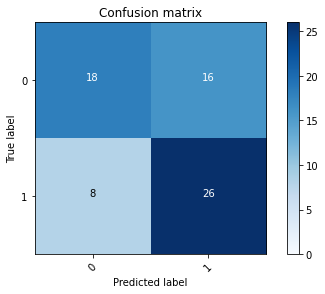

2022-08-03 21:15:59 - [Epoch Train: 123] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:15:59 - [Epoch Valid: 123] loss: 1.9869, auc: 0.7171, acc: 0.6471, time: 7.00 s


 82%|███████████████████████████████▉       | 123/150 [1:01:29<14:22, 31.94s/it]

2022-08-03 21:15:59 - EPOCH: 124
2022-08-03 21:16:04 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:16:07 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:16:11 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:16:15 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:16:19 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:16:23 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:16:26 - Valid Step 5/17, valid_loss: 1.9452
2022-08-03 21:16:27 - Valid Step 10/17, valid_loss: 2.1824
2022-08-03 21:16:30 - Valid Step 15/17, valid_loss: 2.3588
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
54  UPENN-GBM-00092_11_T1w                0           1
36  UPENN-GBM-00093_11_T1w                0           0
37  UPENN-GBM-00094_11_T1w                0           1
13  UPENN-GBM-00115_11_T1w                1           1
40  UPENN-GBM-00117_11_T1w                0           1
23  UPENN-GBM-00128_11_T1w       

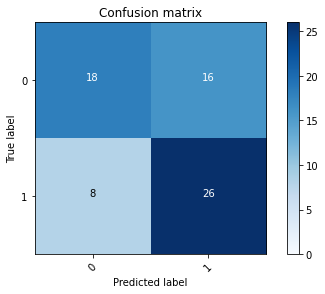

2022-08-03 21:16:31 - [Epoch Train: 124] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:16:31 - [Epoch Valid: 124] loss: 2.1108, auc: 0.7128, acc: 0.6471, time: 7.00 s


 83%|████████████████████████████████▏      | 124/150 [1:02:01<13:47, 31.82s/it]

2022-08-03 21:16:31 - EPOCH: 125
2022-08-03 21:16:35 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:16:39 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:16:43 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:16:47 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:16:51 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:16:55 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:16:58 - Valid Step 5/17, valid_loss: 2.0405
2022-08-03 21:16:59 - Valid Step 10/17, valid_loss: 1.7681
2022-08-03 21:17:02 - Valid Step 15/17, valid_loss: 1.5150
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
25  UPENN-GBM-00092_11_T1w                0           1
49  UPENN-GBM-00093_11_T1w                0           0
57  UPENN-GBM-00094_11_T1w                0           1
28  UPENN-GBM-00115_11_T1w                1           1
61  UPENN-GBM-00117_11_T1w                0           1
29  UPENN-GBM-00128_11_T1w       

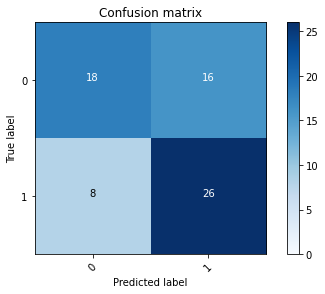

2022-08-03 21:17:03 - [Epoch Train: 125] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:17:03 - [Epoch Valid: 125] loss: 2.0362, auc: 0.7145, acc: 0.6471, time: 7.00 s


 83%|████████████████████████████████▌      | 125/150 [1:02:33<13:17, 31.90s/it]

2022-08-03 21:17:03 - EPOCH: 126
2022-08-03 21:17:07 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:17:11 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:17:15 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:17:19 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:17:22 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:17:26 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:17:29 - Valid Step 5/17, valid_loss: 2.9192
2022-08-03 21:17:31 - Valid Step 10/17, valid_loss: 2.3544
2022-08-03 21:17:33 - Valid Step 15/17, valid_loss: 1.9308
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
50  UPENN-GBM-00092_11_T1w                0           1
3   UPENN-GBM-00093_11_T1w                0           0
23  UPENN-GBM-00094_11_T1w                0           1
34  UPENN-GBM-00115_11_T1w                1           1
45  UPENN-GBM-00117_11_T1w                0           1
40  UPENN-GBM-00128_11_T1w       

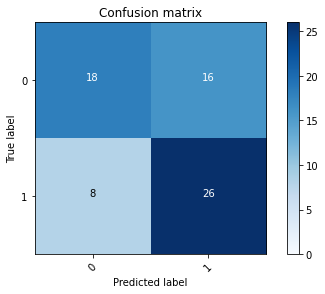

2022-08-03 21:17:34 - [Epoch Train: 126] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:17:34 - [Epoch Valid: 126] loss: 2.0341, auc: 0.7154, acc: 0.6471, time: 7.00 s


 84%|████████████████████████████████▊      | 126/150 [1:03:04<12:39, 31.66s/it]

2022-08-03 21:17:34 - EPOCH: 127
2022-08-03 21:17:38 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:17:42 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:17:46 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:17:50 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:17:54 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:17:58 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:18:01 - Valid Step 5/17, valid_loss: 1.0961
2022-08-03 21:18:02 - Valid Step 10/17, valid_loss: 1.8828
2022-08-03 21:18:05 - Valid Step 15/17, valid_loss: 2.0320
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
49  UPENN-GBM-00092_11_T1w                0           1
43  UPENN-GBM-00093_11_T1w                0           0
12  UPENN-GBM-00094_11_T1w                0           1
45  UPENN-GBM-00115_11_T1w                1           1
57  UPENN-GBM-00117_11_T1w                0           1
6   UPENN-GBM-00128_11_T1w       

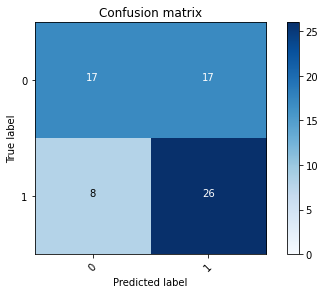

2022-08-03 21:18:06 - [Epoch Train: 127] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:18:06 - [Epoch Valid: 127] loss: 2.0428, auc: 0.7176, acc: 0.6324, time: 7.00 s


 85%|█████████████████████████████████      | 127/150 [1:03:36<12:10, 31.75s/it]

2022-08-03 21:18:06 - EPOCH: 128
2022-08-03 21:18:10 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:18:14 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:18:18 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:18:22 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:18:26 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:18:30 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:18:32 - Valid Step 5/17, valid_loss: 2.7814
2022-08-03 21:18:34 - Valid Step 10/17, valid_loss: 2.3328
2022-08-03 21:18:37 - Valid Step 15/17, valid_loss: 2.0892
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
30  UPENN-GBM-00092_11_T1w                0           1
24  UPENN-GBM-00093_11_T1w                0           0
10  UPENN-GBM-00094_11_T1w                0           1
20  UPENN-GBM-00115_11_T1w                1           1
56  UPENN-GBM-00117_11_T1w                0           1
41  UPENN-GBM-00128_11_T1w       

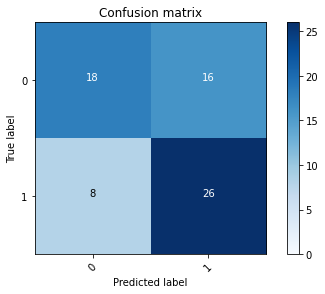

2022-08-03 21:18:38 - [Epoch Train: 128] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:18:38 - [Epoch Valid: 128] loss: 2.1001, auc: 0.7102, acc: 0.6471, time: 7.00 s


 85%|█████████████████████████████████▎     | 128/150 [1:04:07<11:37, 31.72s/it]

2022-08-03 21:18:38 - EPOCH: 129
2022-08-03 21:18:42 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:18:46 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:18:50 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:18:54 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:18:58 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:19:02 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:19:04 - Valid Step 5/17, valid_loss: 2.8527
2022-08-03 21:19:06 - Valid Step 10/17, valid_loss: 2.1744
2022-08-03 21:19:08 - Valid Step 15/17, valid_loss: 2.3195
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
43  UPENN-GBM-00092_11_T1w                0           1
0   UPENN-GBM-00093_11_T1w                0           0
44  UPENN-GBM-00094_11_T1w                0           1
42  UPENN-GBM-00115_11_T1w                1           1
59  UPENN-GBM-00117_11_T1w                0           1
38  UPENN-GBM-00128_11_T1w       

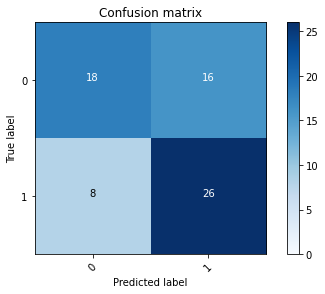

2022-08-03 21:19:09 - [Epoch Train: 129] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:19:09 - [Epoch Valid: 129] loss: 2.1595, auc: 0.7119, acc: 0.6471, time: 7.00 s


 86%|█████████████████████████████████▌     | 129/150 [1:04:39<11:06, 31.74s/it]

2022-08-03 21:19:09 - EPOCH: 130
2022-08-03 21:19:14 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:19:18 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:19:22 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:19:26 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:19:30 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:19:34 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:19:37 - Valid Step 5/17, valid_loss: 2.5131
2022-08-03 21:19:38 - Valid Step 10/17, valid_loss: 2.3445
2022-08-03 21:19:40 - Valid Step 15/17, valid_loss: 1.9709
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
19  UPENN-GBM-00092_11_T1w                0           1
32  UPENN-GBM-00093_11_T1w                0           0
50  UPENN-GBM-00094_11_T1w                0           1
62  UPENN-GBM-00115_11_T1w                1           1
65  UPENN-GBM-00117_11_T1w                0           1
51  UPENN-GBM-00128_11_T1w       

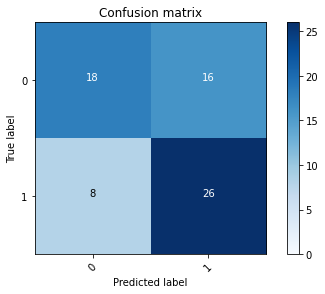

2022-08-03 21:19:41 - [Epoch Train: 130] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:19:41 - [Epoch Valid: 130] loss: 2.1491, auc: 0.7102, acc: 0.6471, time: 7.00 s


 87%|█████████████████████████████████▊     | 130/150 [1:05:11<10:36, 31.83s/it]

2022-08-03 21:19:41 - EPOCH: 131
2022-08-03 21:19:46 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:19:50 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:19:54 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:19:57 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:20:01 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:20:05 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:20:08 - Valid Step 5/17, valid_loss: 1.8434
2022-08-03 21:20:10 - Valid Step 10/17, valid_loss: 2.4024
2022-08-03 21:20:12 - Valid Step 15/17, valid_loss: 1.9500
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
16  UPENN-GBM-00092_11_T1w                0           1
6   UPENN-GBM-00093_11_T1w                0           0
21  UPENN-GBM-00094_11_T1w                0           1
43  UPENN-GBM-00115_11_T1w                1           1
39  UPENN-GBM-00117_11_T1w                0           1
34  UPENN-GBM-00128_11_T1w       

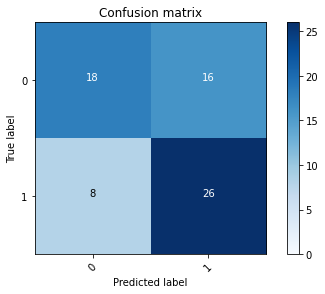

2022-08-03 21:20:13 - [Epoch Train: 131] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:20:13 - [Epoch Valid: 131] loss: 2.1019, auc: 0.7141, acc: 0.6471, time: 7.00 s


 87%|██████████████████████████████████     | 131/150 [1:05:43<10:02, 31.70s/it]

2022-08-03 21:20:13 - EPOCH: 132
2022-08-03 21:20:17 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:20:21 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:20:25 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:20:29 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:20:33 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:20:37 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:20:40 - Valid Step 5/17, valid_loss: 1.9265
2022-08-03 21:20:41 - Valid Step 10/17, valid_loss: 2.3862
2022-08-03 21:20:44 - Valid Step 15/17, valid_loss: 2.1914
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
35  UPENN-GBM-00092_11_T1w                0           1
21  UPENN-GBM-00093_11_T1w                0           0
61  UPENN-GBM-00094_11_T1w                0           1
15  UPENN-GBM-00115_11_T1w                1           1
22  UPENN-GBM-00117_11_T1w                0           1
17  UPENN-GBM-00128_11_T1w       

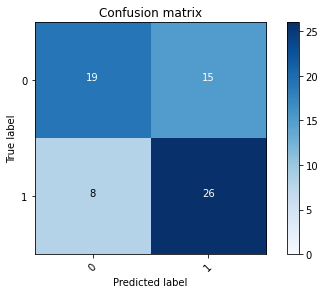

2022-08-03 21:20:45 - [Epoch Train: 132] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:20:45 - [Epoch Valid: 132] loss: 2.0895, auc: 0.7141, acc: 0.6618, time: 7.00 s
2022-08-03 21:20:45 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e132-loss2.089-acc0.662-auc0.714.pth'


 88%|██████████████████████████████████▎    | 132/150 [1:06:15<09:32, 31.83s/it]

2022-08-03 21:20:45 - EPOCH: 133
2022-08-03 21:20:49 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:20:53 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:20:57 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:21:01 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:21:05 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:21:09 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:21:11 - Valid Step 5/17, valid_loss: 3.2577
2022-08-03 21:21:13 - Valid Step 10/17, valid_loss: 2.8432
2022-08-03 21:21:15 - Valid Step 15/17, valid_loss: 2.3041
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
24  UPENN-GBM-00092_11_T1w                0           1
22  UPENN-GBM-00093_11_T1w                0           0
37  UPENN-GBM-00094_11_T1w                0           1
59  UPENN-GBM-00115_11_T1w                1           1
31  UPENN-GBM-00117_11_T1w                0           1
8   UPENN-GBM-00128_11_T1w       

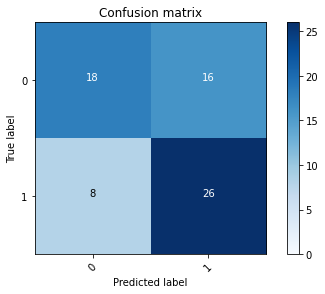

2022-08-03 21:21:16 - [Epoch Train: 133] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:21:16 - [Epoch Valid: 133] loss: 2.1621, auc: 0.7085, acc: 0.6471, time: 7.00 s


 89%|██████████████████████████████████▌    | 133/150 [1:06:46<08:59, 31.73s/it]

2022-08-03 21:21:16 - EPOCH: 134
2022-08-03 21:21:21 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:21:24 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:21:28 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:21:32 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:21:36 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:21:40 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:21:43 - Valid Step 5/17, valid_loss: 1.6923
2022-08-03 21:21:45 - Valid Step 10/17, valid_loss: 1.9504
2022-08-03 21:21:47 - Valid Step 15/17, valid_loss: 2.2394
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
19  UPENN-GBM-00092_11_T1w                0           1
13  UPENN-GBM-00093_11_T1w                0           0
23  UPENN-GBM-00094_11_T1w                0           1
38  UPENN-GBM-00115_11_T1w                1           1
15  UPENN-GBM-00117_11_T1w                0           1
2   UPENN-GBM-00128_11_T1w       

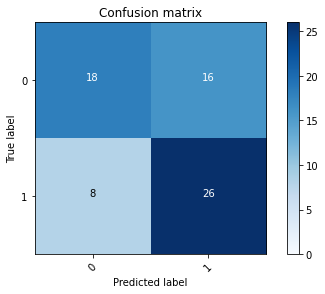

2022-08-03 21:21:48 - [Epoch Train: 134] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:21:48 - [Epoch Valid: 134] loss: 2.0545, auc: 0.7210, acc: 0.6471, time: 7.00 s


 89%|██████████████████████████████████▊    | 134/150 [1:07:18<08:26, 31.69s/it]

2022-08-03 21:21:48 - EPOCH: 135
2022-08-03 21:21:52 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:21:56 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:22:00 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:22:04 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:22:08 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:22:12 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:22:14 - Valid Step 5/17, valid_loss: 2.3588
2022-08-03 21:22:16 - Valid Step 10/17, valid_loss: 1.9378
2022-08-03 21:22:18 - Valid Step 15/17, valid_loss: 2.2623
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
60  UPENN-GBM-00092_11_T1w                0           1
62  UPENN-GBM-00093_11_T1w                0           0
49  UPENN-GBM-00094_11_T1w                0           1
25  UPENN-GBM-00115_11_T1w                1           1
0   UPENN-GBM-00117_11_T1w                0           1
29  UPENN-GBM-00128_11_T1w       

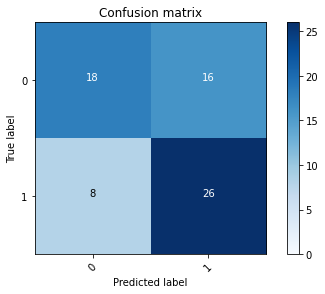

2022-08-03 21:22:19 - [Epoch Train: 135] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:22:19 - [Epoch Valid: 135] loss: 2.1731, auc: 0.7137, acc: 0.6471, time: 7.00 s


 90%|███████████████████████████████████    | 135/150 [1:07:49<07:53, 31.60s/it]

2022-08-03 21:22:19 - EPOCH: 136
2022-08-03 21:22:24 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:22:28 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:22:32 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:22:35 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:22:39 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:22:43 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:22:46 - Valid Step 5/17, valid_loss: 1.5376
2022-08-03 21:22:47 - Valid Step 10/17, valid_loss: 2.2998
2022-08-03 21:22:50 - Valid Step 15/17, valid_loss: 2.0899
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
22  UPENN-GBM-00092_11_T1w                0           1
27  UPENN-GBM-00093_11_T1w                0           0
1   UPENN-GBM-00094_11_T1w                0           1
16  UPENN-GBM-00115_11_T1w                1           1
29  UPENN-GBM-00117_11_T1w                0           1
66  UPENN-GBM-00128_11_T1w       

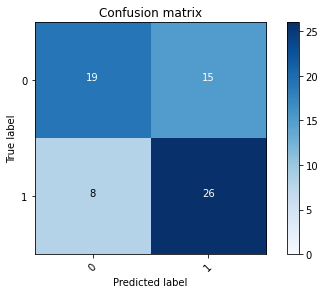

2022-08-03 21:22:51 - [Epoch Train: 136] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:22:51 - [Epoch Valid: 136] loss: 2.0574, auc: 0.7124, acc: 0.6618, time: 7.00 s
2022-08-03 21:22:51 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e136-loss2.057-acc0.662-auc0.712.pth'


 91%|███████████████████████████████████▎   | 136/150 [1:08:21<07:21, 31.55s/it]

2022-08-03 21:22:51 - EPOCH: 137
2022-08-03 21:22:55 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:22:59 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:23:03 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:23:07 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:23:11 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:23:15 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:23:17 - Valid Step 5/17, valid_loss: 1.9145
2022-08-03 21:23:19 - Valid Step 10/17, valid_loss: 1.8461
2022-08-03 21:23:21 - Valid Step 15/17, valid_loss: 2.1601
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
6   UPENN-GBM-00092_11_T1w                0           1
42  UPENN-GBM-00093_11_T1w                0           0
10  UPENN-GBM-00094_11_T1w                0           1
27  UPENN-GBM-00115_11_T1w                1           1
7   UPENN-GBM-00117_11_T1w                0           1
57  UPENN-GBM-00128_11_T1w       

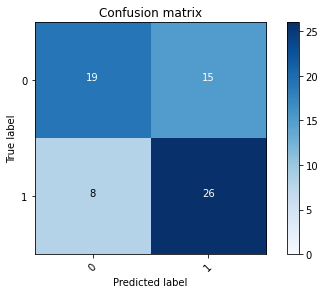

2022-08-03 21:23:22 - [Epoch Train: 137] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:23:22 - [Epoch Valid: 137] loss: 2.1071, auc: 0.7128, acc: 0.6618, time: 7.00 s
2022-08-03 21:23:22 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e137-loss2.107-acc0.662-auc0.713.pth'


 91%|███████████████████████████████████▌   | 137/150 [1:08:52<06:50, 31.58s/it]

2022-08-03 21:23:22 - EPOCH: 138
2022-08-03 21:23:27 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:23:31 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:23:34 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:23:38 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:23:42 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:23:46 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:23:49 - Valid Step 5/17, valid_loss: 2.7099
2022-08-03 21:23:50 - Valid Step 10/17, valid_loss: 2.5668
2022-08-03 21:23:53 - Valid Step 15/17, valid_loss: 2.0617
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
60  UPENN-GBM-00092_11_T1w                0           1
42  UPENN-GBM-00093_11_T1w                0           0
3   UPENN-GBM-00094_11_T1w                0           1
32  UPENN-GBM-00115_11_T1w                1           1
59  UPENN-GBM-00117_11_T1w                0           1
38  UPENN-GBM-00128_11_T1w       

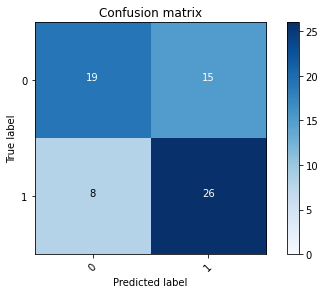

2022-08-03 21:23:54 - [Epoch Train: 138] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:23:54 - [Epoch Valid: 138] loss: 2.0869, auc: 0.7145, acc: 0.6618, time: 7.00 s
2022-08-03 21:23:54 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e138-loss2.087-acc0.662-auc0.715.pth'


 92%|███████████████████████████████████▉   | 138/150 [1:09:24<06:17, 31.45s/it]

2022-08-03 21:23:54 - EPOCH: 139
2022-08-03 21:23:58 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:24:02 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:24:06 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:24:10 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:24:14 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:24:17 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:24:20 - Valid Step 5/17, valid_loss: 1.0764
2022-08-03 21:24:22 - Valid Step 10/17, valid_loss: 1.8644
2022-08-03 21:24:24 - Valid Step 15/17, valid_loss: 2.2755
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
31  UPENN-GBM-00092_11_T1w                0           1
15  UPENN-GBM-00093_11_T1w                0           0
44  UPENN-GBM-00094_11_T1w                0           1
57  UPENN-GBM-00115_11_T1w                1           1
40  UPENN-GBM-00117_11_T1w                0           1
54  UPENN-GBM-00128_11_T1w       

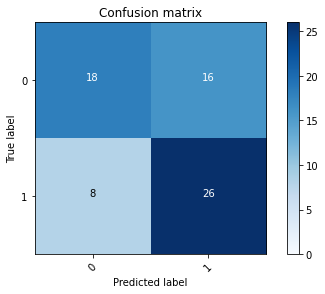

2022-08-03 21:24:25 - [Epoch Train: 139] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:24:25 - [Epoch Valid: 139] loss: 2.2324, auc: 0.7132, acc: 0.6471, time: 7.00 s


 93%|████████████████████████████████████▏  | 139/150 [1:09:55<05:45, 31.43s/it]

2022-08-03 21:24:25 - EPOCH: 140
2022-08-03 21:24:29 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:24:33 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:24:37 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:24:41 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:24:45 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:24:49 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:24:51 - Valid Step 5/17, valid_loss: 1.9504
2022-08-03 21:24:53 - Valid Step 10/17, valid_loss: 2.4013
2022-08-03 21:24:56 - Valid Step 15/17, valid_loss: 2.0311
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
28  UPENN-GBM-00092_11_T1w                0           1
49  UPENN-GBM-00093_11_T1w                0           0
57  UPENN-GBM-00094_11_T1w                0           1
58  UPENN-GBM-00115_11_T1w                1           1
55  UPENN-GBM-00117_11_T1w                0           1
11  UPENN-GBM-00128_11_T1w       

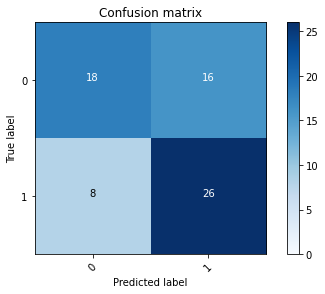

2022-08-03 21:24:57 - [Epoch Train: 140] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:24:57 - [Epoch Valid: 140] loss: 2.1640, auc: 0.7111, acc: 0.6471, time: 7.00 s


 93%|████████████████████████████████████▍  | 140/150 [1:10:27<05:14, 31.48s/it]

2022-08-03 21:24:57 - EPOCH: 141
2022-08-03 21:25:01 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:25:05 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:25:09 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:25:13 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:25:17 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:25:21 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:25:23 - Valid Step 5/17, valid_loss: 2.0131
2022-08-03 21:25:25 - Valid Step 10/17, valid_loss: 1.8430
2022-08-03 21:25:27 - Valid Step 15/17, valid_loss: 2.0511
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
49  UPENN-GBM-00092_11_T1w                0           1
16  UPENN-GBM-00093_11_T1w                0           0
26  UPENN-GBM-00094_11_T1w                0           1
62  UPENN-GBM-00115_11_T1w                1           1
56  UPENN-GBM-00117_11_T1w                0           1
35  UPENN-GBM-00128_11_T1w       

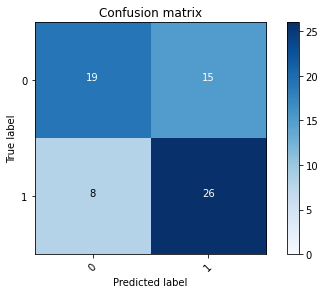

2022-08-03 21:25:28 - [Epoch Train: 141] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:25:28 - [Epoch Valid: 141] loss: 2.0520, auc: 0.7176, acc: 0.6618, time: 7.00 s
2022-08-03 21:25:28 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e141-loss2.052-acc0.662-auc0.718.pth'


 94%|████████████████████████████████████▋  | 141/150 [1:10:58<04:44, 31.60s/it]

2022-08-03 21:25:28 - EPOCH: 142
2022-08-03 21:25:33 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:25:37 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:25:40 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:25:44 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:25:48 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:25:52 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:25:55 - Valid Step 5/17, valid_loss: 1.8879
2022-08-03 21:25:56 - Valid Step 10/17, valid_loss: 1.6826
2022-08-03 21:25:59 - Valid Step 15/17, valid_loss: 2.1396
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
63  UPENN-GBM-00092_11_T1w                0           1
4   UPENN-GBM-00093_11_T1w                0           0
17  UPENN-GBM-00094_11_T1w                0           1
32  UPENN-GBM-00115_11_T1w                1           1
53  UPENN-GBM-00117_11_T1w                0           1
5   UPENN-GBM-00128_11_T1w       

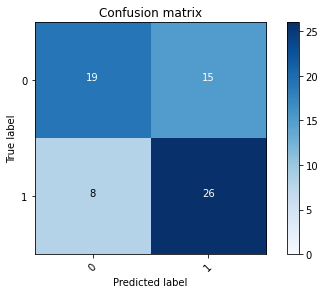

2022-08-03 21:26:00 - [Epoch Train: 142] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:26:00 - [Epoch Valid: 142] loss: 2.1440, auc: 0.7115, acc: 0.6618, time: 7.00 s
2022-08-03 21:26:00 - acc improved from 0.6618 to 0.6618. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e142-loss2.144-acc0.662-auc0.712.pth'


 95%|████████████████████████████████████▉  | 142/150 [1:11:30<04:12, 31.54s/it]

2022-08-03 21:26:00 - EPOCH: 143
2022-08-03 21:26:04 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:26:08 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:26:12 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:26:16 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:26:20 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:26:24 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:26:27 - Valid Step 5/17, valid_loss: 3.2541
2022-08-03 21:26:28 - Valid Step 10/17, valid_loss: 1.9812
2022-08-03 21:26:31 - Valid Step 15/17, valid_loss: 2.1167
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
41  UPENN-GBM-00092_11_T1w                0           1
32  UPENN-GBM-00093_11_T1w                0           0
38  UPENN-GBM-00094_11_T1w                0           1
28  UPENN-GBM-00115_11_T1w                1           1
47  UPENN-GBM-00117_11_T1w                0           1
49  UPENN-GBM-00128_11_T1w       

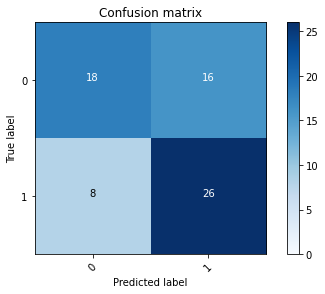

2022-08-03 21:26:32 - [Epoch Train: 143] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:26:32 - [Epoch Valid: 143] loss: 2.1488, auc: 0.7150, acc: 0.6471, time: 7.00 s


 95%|█████████████████████████████████████▏ | 143/150 [1:12:02<03:41, 31.64s/it]

2022-08-03 21:26:32 - EPOCH: 144
2022-08-03 21:26:36 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:26:40 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:26:44 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:26:48 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:26:52 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:26:55 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:26:58 - Valid Step 5/17, valid_loss: 2.9253
2022-08-03 21:27:00 - Valid Step 10/17, valid_loss: 2.7035
2022-08-03 21:27:02 - Valid Step 15/17, valid_loss: 2.3616
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
1   UPENN-GBM-00092_11_T1w                0           1
37  UPENN-GBM-00093_11_T1w                0           0
21  UPENN-GBM-00094_11_T1w                0           1
61  UPENN-GBM-00115_11_T1w                1           1
0   UPENN-GBM-00117_11_T1w                0           1
26  UPENN-GBM-00128_11_T1w       

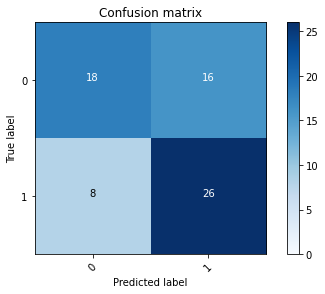

2022-08-03 21:27:03 - [Epoch Train: 144] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:27:03 - [Epoch Valid: 144] loss: 2.2791, auc: 0.7115, acc: 0.6471, time: 7.00 s


 96%|█████████████████████████████████████▍ | 144/150 [1:12:33<03:09, 31.53s/it]

2022-08-03 21:27:03 - EPOCH: 145
2022-08-03 21:27:07 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:27:11 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:27:15 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:27:19 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:27:23 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:27:27 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:27:29 - Valid Step 5/17, valid_loss: 1.0616
2022-08-03 21:27:31 - Valid Step 10/17, valid_loss: 1.0653
2022-08-03 21:27:34 - Valid Step 15/17, valid_loss: 1.8403
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
63  UPENN-GBM-00092_11_T1w                0           1
39  UPENN-GBM-00093_11_T1w                0           0
49  UPENN-GBM-00094_11_T1w                0           1
56  UPENN-GBM-00115_11_T1w                1           1
54  UPENN-GBM-00117_11_T1w                0           1
35  UPENN-GBM-00128_11_T1w       

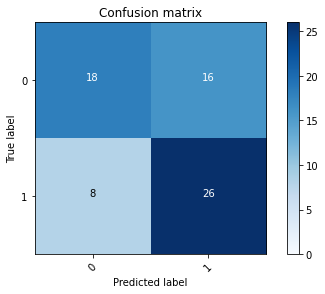

2022-08-03 21:27:35 - [Epoch Train: 145] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:27:35 - [Epoch Valid: 145] loss: 2.1405, auc: 0.7154, acc: 0.6471, time: 7.00 s


 97%|█████████████████████████████████████▋ | 145/150 [1:13:05<02:38, 31.61s/it]

2022-08-03 21:27:35 - EPOCH: 146
2022-08-03 21:27:39 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:27:43 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:27:47 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:27:51 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:27:55 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:27:59 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:28:02 - Valid Step 5/17, valid_loss: 1.7399
2022-08-03 21:28:04 - Valid Step 10/17, valid_loss: 1.9638
2022-08-03 21:28:06 - Valid Step 15/17, valid_loss: 1.9766
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
16  UPENN-GBM-00092_11_T1w                0           1
34  UPENN-GBM-00093_11_T1w                0           0
26  UPENN-GBM-00094_11_T1w                0           1
8   UPENN-GBM-00115_11_T1w                1           1
55  UPENN-GBM-00117_11_T1w                0           1
22  UPENN-GBM-00128_11_T1w       

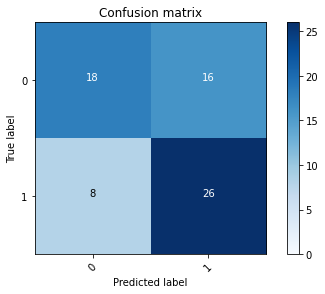

2022-08-03 21:28:07 - [Epoch Train: 146] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:28:07 - [Epoch Valid: 146] loss: 2.2161, auc: 0.7106, acc: 0.6471, time: 7.00 s


 97%|█████████████████████████████████████▉ | 146/150 [1:13:37<02:06, 31.74s/it]

2022-08-03 21:28:07 - EPOCH: 147
2022-08-03 21:28:11 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:28:15 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:28:19 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:28:23 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:28:27 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:28:30 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:28:33 - Valid Step 5/17, valid_loss: 2.1339
2022-08-03 21:28:35 - Valid Step 10/17, valid_loss: 2.0405
2022-08-03 21:28:37 - Valid Step 15/17, valid_loss: 2.1358
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
62  UPENN-GBM-00092_11_T1w                0           1
36  UPENN-GBM-00093_11_T1w                0           0
31  UPENN-GBM-00094_11_T1w                0           1
48  UPENN-GBM-00115_11_T1w                1           1
64  UPENN-GBM-00117_11_T1w                0           1
12  UPENN-GBM-00128_11_T1w       

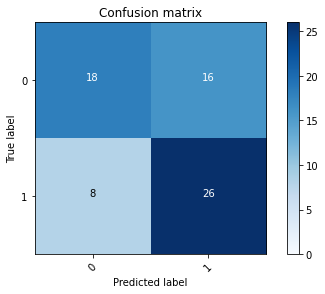

2022-08-03 21:28:38 - [Epoch Train: 147] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:28:38 - [Epoch Valid: 147] loss: 2.1901, auc: 0.7150, acc: 0.6471, time: 7.00 s


 98%|██████████████████████████████████████▏| 147/150 [1:14:08<01:34, 31.61s/it]

2022-08-03 21:28:38 - EPOCH: 148
2022-08-03 21:28:42 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:28:46 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:28:50 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:28:54 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:28:58 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:29:01 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:29:04 - Valid Step 5/17, valid_loss: 1.0490
2022-08-03 21:29:06 - Valid Step 10/17, valid_loss: 1.7330
2022-08-03 21:29:08 - Valid Step 15/17, valid_loss: 2.0541
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
22  UPENN-GBM-00092_11_T1w                0           1
0   UPENN-GBM-00093_11_T1w                0           0
54  UPENN-GBM-00094_11_T1w                0           1
42  UPENN-GBM-00115_11_T1w                1           1
62  UPENN-GBM-00117_11_T1w                0           1
12  UPENN-GBM-00128_11_T1w       

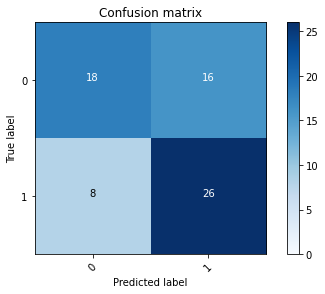

2022-08-03 21:29:09 - [Epoch Train: 148] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-03 21:29:09 - [Epoch Valid: 148] loss: 2.2697, auc: 0.7124, acc: 0.6471, time: 7.00 s


 99%|██████████████████████████████████████▍| 148/150 [1:14:39<01:02, 31.43s/it]

2022-08-03 21:29:09 - EPOCH: 149
2022-08-03 21:29:13 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:29:17 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:29:22 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:29:25 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:29:30 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:29:33 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:29:36 - Valid Step 5/17, valid_loss: 2.0400
2022-08-03 21:29:38 - Valid Step 10/17, valid_loss: 2.3328
2022-08-03 21:29:40 - Valid Step 15/17, valid_loss: 2.3506
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
12  UPENN-GBM-00092_11_T1w                0           1
29  UPENN-GBM-00093_11_T1w                0           0
27  UPENN-GBM-00094_11_T1w                0           1
31  UPENN-GBM-00115_11_T1w                1           1
42  UPENN-GBM-00117_11_T1w                0           1
24  UPENN-GBM-00128_11_T1w       

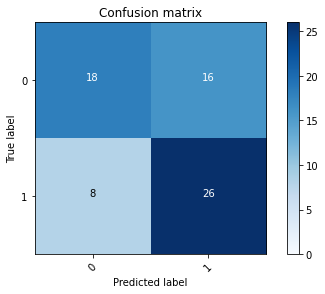

2022-08-03 21:29:41 - [Epoch Train: 149] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:29:41 - [Epoch Valid: 149] loss: 2.3579, auc: 0.7124, acc: 0.6471, time: 7.00 s


 99%|██████████████████████████████████████▋| 149/150 [1:15:11<00:31, 31.64s/it]

2022-08-03 21:29:41 - EPOCH: 150
2022-08-03 21:29:46 - Train Step 10/60, train_loss: 0.0000
2022-08-03 21:29:50 - Train Step 20/60, train_loss: 0.0000
2022-08-03 21:29:53 - Train Step 30/60, train_loss: 0.0000
2022-08-03 21:29:57 - Train Step 40/60, train_loss: 0.0000
2022-08-03 21:30:01 - Train Step 50/60, train_loss: 0.0000
2022-08-03 21:30:05 - Train Step 60/60, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-03 21:30:08 - Valid Step 5/17, valid_loss: 0.5478
2022-08-03 21:30:10 - Valid Step 10/17, valid_loss: 1.5381
2022-08-03 21:30:12 - Valid Step 15/17, valid_loss: 1.9785
First 64 results:
                 BraTS21ID  MGMT_real_value  MGMT_value
34  UPENN-GBM-00092_11_T1w                0           1
41  UPENN-GBM-00093_11_T1w                0           0
66  UPENN-GBM-00094_11_T1w                0           1
3   UPENN-GBM-00115_11_T1w                1           1
23  UPENN-GBM-00117_11_T1w                0           1
44  UPENN-GBM-00128_11_T1w       

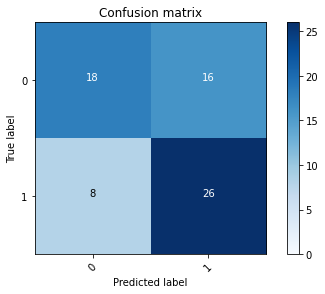

2022-08-03 21:30:13 - [Epoch Train: 150] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-03 21:30:13 - [Epoch Valid: 150] loss: 2.1838, auc: 0.7102, acc: 0.6471, time: 7.00 s


100%|███████████████████████████████████████| 150/150 [1:15:43<00:00, 30.29s/it]


In [24]:
print(info)
m_modelfile = train_mri_type(m_model, device, info, epochs=150, pat=30, 
                       train_loader=train_loader, valid_loader=val_loader)
##m_modelfile = train_mri_type(m_model, device, info, epochs=150, pat=30, 
##                       train_loader=m_train_loader, valid_loader=m_val_loader)

#m_modelfile = train_mri_type(m_model, device, info, epochs=150, pat=30, 
#                       train_loader=n_train_loader, valid_loader=n_val_loader)

In [11]:
print(m_modelfile)

../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug05_17-47-49/RSNAClassifierSingle3D-DW-SO-KLF-e6-loss0.449-acc0.852-auc0.902.pth


2022-07-10 21:37:55 - Predict: ../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul10_20-59-21/RSNAClassifierSingle3D-DW-SO-KLF-e4-loss1.238-acc0.550-auc0.591.pth 340
Dataset: Labeled Test Set
             BraTS21ID  MGMT_real_value  MGMT_value
18  UPENN-GBM-00131_11                1           0
27  UPENN-GBM-00133_11                0           0
0   UPENN-GBM-00136_11                0           0
12  UPENN-GBM-00143_11                0           0
28  UPENN-GBM-00148_21                0           0
9   UPENN-GBM-00260_11                1           0
32  UPENN-GBM-00302_11                1           0
6   UPENN-GBM-00350_11                1           1
13  UPENN-GBM-00354_11                0           0
23  UPENN-GBM-00413_11                0           1
14  UPENN-GBM-00430_11                1           1
7   UPENN-GBM-00445_11                1           1
31  UPENN-GBM-00457_11                0           1
10  UPENN-GBM-00461_11                1           0
26  UPENN-G

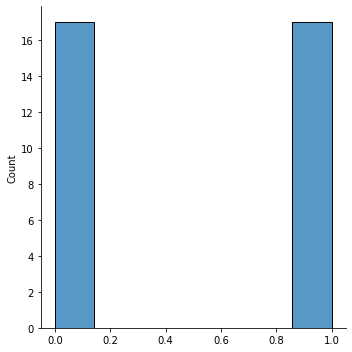

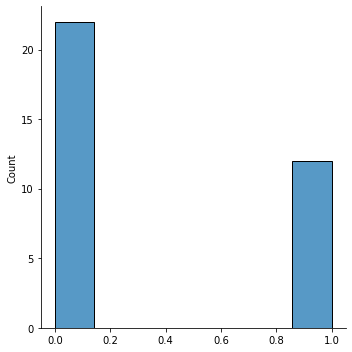

In [13]:
# C+N
#cn_test_pred, X, y, y_pred, y_prob = predict(m_model, device, m_modelfile, n_test_loader, size)

In [42]:
print(cc_test_pred)

2022-07-08 23:24:15 - Predict: ../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Jul08_22-51-18/RSNAClassifierSingle3D-DW-SO-e19-loss1.062-acc0.706-auc0.789.pth 606
Dataset: Labeled Test Set
   BraTS21ID  MGMT_real_value  MGMT_value
15     00022                0           1
12     00030                0           1
46     00031                1           1
27     00032                0           0
34     00035                1           1
8      00068                1           1
20     00077                1           0
13     00085                1           1
9      00096                1           1
38     00110                0           0
31     00124                0           1
18     00165                0           1
28     00206                0           0
19     00216                0           0
44     00234                1           1
6      00254                1           1
17     00258                0           1
54     00270                1           1


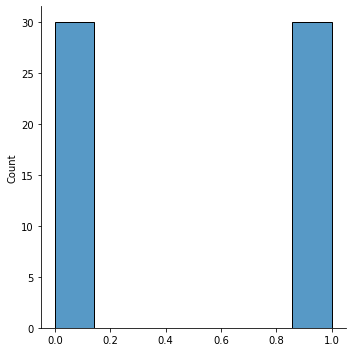

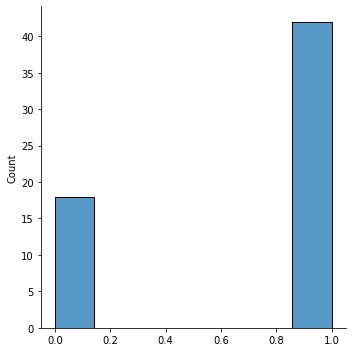

In [43]:
# N+C
nc_test_pred, X, y, y_pred, y_prob = predict(m_model, device, m_modelfile, m_test_loader, size)

In [7]:
from sklearn.metrics import roc_auc_score
def plot_confusion_matrix(y_valid, y_pred,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_valid, y_pred)
    classes = ["0", "1"]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.clim(0,cm.max())
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

2022-08-02 21:45:31 - Predict: ../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Aug02_18-42-47/RSNAClassifierSingle3D-DW-SO-KLF-e65-loss1.880-acc0.757-auc0.848.pth 1092
Dataset: Labeled Test Set
              BraTS21ID  MGMT_real_value  MGMT_value
91                00043                1           1
56                00053                0           0
80                00063                1           1
81                00064                0           1
76                00066                1           0
78                00072                0           0
34                00090                0           0
83                00133                0           0
52                00140                1           1
49                00150                0           0
103               00154                0           0
16                00166                1           0
92                00167                0           0
54                00183                0       

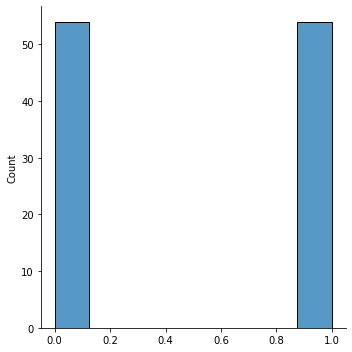

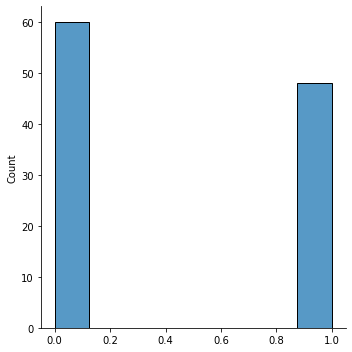

In [228]:
#m_old_modelfile = "../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul07_16-02-56/RSNAClassifierSingle3D-DW-SO-KLF-e59-loss2.968-acc0.617-auc0.553.pth"
#m_old_modelfile = "../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Jul07_17-25-17/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e137-loss2.965-acc0.675-auc0.667.pth"
#m_old_modelfile = "../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Jan27_10-46-07/RSNAClassifierSingle3D-DW-SO-e13-loss0.012-acc1.000-auc1.000.pth"
#m_old_modelfile = "../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jan27_19-25-03/RSNAClassifierSingle3D-DW-SO-KLF-e65-loss0.004-acc1.000-auc1.000.pth"
#m_modelfile = "../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul10_20-59-21/RSNAClassifierSingle3D-DW-SO-KLF-e4-loss1.238-acc0.550-auc0.591.pth"
# C+N
#cn_test_pred, X, y, y_pred, y_prob = predict(m_model, device, m_modelfile, n_test_loader, size)
#cn_test_pred_f, X_f, y_f, y_pred_f, y_prob_f = predict(m_model, device, m_modelfile, loader_packs['FLAIR']['n_dataloaders'][2], size)
# C+C
test_loader = fn_test_loader
cc_test_pred, ids, X, y, y_pred, y_prob = classifier_utils.predict(m_model, device, m_modelfile, test_loader, size)

2022-08-03 21:30:37 - Predict: ../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Aug03_20-14-30/RSNAClassifierSingle3D-DW-SO-e142-loss2.144-acc0.662-auc0.712.pth 340
Dataset: Labeled Test Set
             BraTS21ID  MGMT_real_value  MGMT_value
4   UPENN-GBM-00131_11                1           0
26  UPENN-GBM-00131_11                1           0
8   UPENN-GBM-00133_11                0           0
1   UPENN-GBM-00136_11                0           0
21  UPENN-GBM-00143_11                0           0
27  UPENN-GBM-00148_21                0           0
9   UPENN-GBM-00260_11                1           1
11  UPENN-GBM-00302_11                1           1
19  UPENN-GBM-00350_11                1           0
13  UPENN-GBM-00350_11                1           0
20  UPENN-GBM-00354_11                0           1
24  UPENN-GBM-00413_11                0           0
22  UPENN-GBM-00445_11                1           1
6   UPENN-GBM-00457_11                0           0
3   UPENN-GBM-004

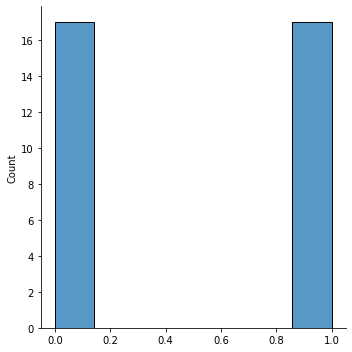

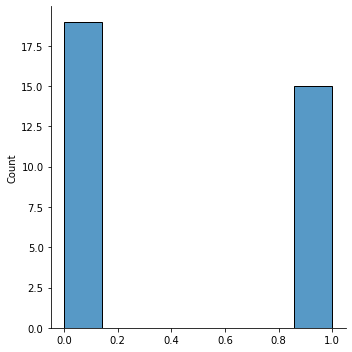

In [26]:
test_loader = n_test_loader
cc_test_pred, ids, X, y, y_pred, y_prob = predict(m_model, device, m_modelfile, test_loader, size)

2022-08-02 22:01:13 - Predict: ../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jan27_19-25-03/RSNAClassifierSingle3D-DW-SO-KLF-e65-loss0.004-acc1.000-auc1.000.pth 606
Dataset: Labeled Test Set
   BraTS21ID  MGMT_real_value  MGMT_value
13     00002                1           0
54     00005                1           0
29     00026                1           1
4      00043                1           0
37     00064                0           0
12     00090                0           1
5      00106                1           1
40     00111                0           0
47     00138                1           1
38     00142                0           0
2      00160                1           0
0      00167                0           1
1      00217                0           0
3      00230                1           0
21     00238                0           0
46     00239                0           0
56     00242                0           0
11     00275                0     

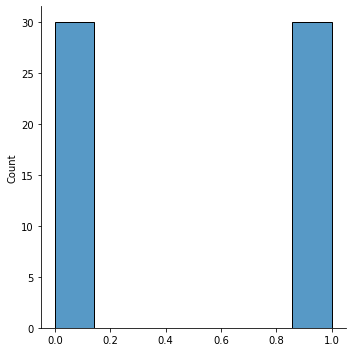

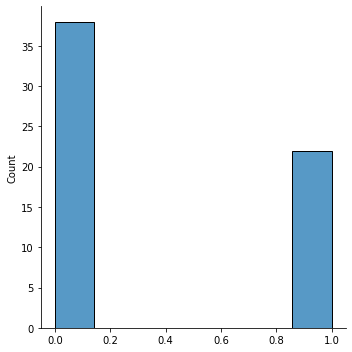

In [234]:
import importlib
importlib.reload(classifier_utils)

test_loader = m_test_loader
cc_test_pred, ids, X, y, y_pred, y_prob = classifier_utils.predict(m_model, device, m_modelfile, test_loader, size)

In [215]:
#test_loader = h_test_loader
#cc_test_pred, ids, X, y, y_pred, y_prob = classifier_utils.predict(m_model, device, m_modelfile, test_loader, size)

0.7300000000000001
Best Threshold: 0.9312999844551086 with G-Mean: 0.7333
FPR: 0.2667, TPR: 0.7333


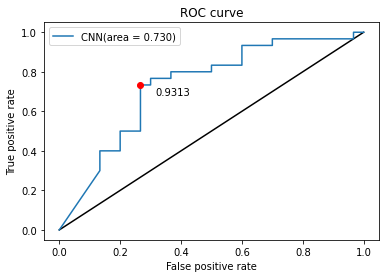

<Figure size 432x288 with 0 Axes>

In [192]:
#plot_confusion_matrix(y, y_pred)
auc = roc_auc_score(y, y_prob)
print(auc)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y, y_prob)

# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(auc))
plt.plot(fprOpt, tprOpt, 'ro')
plt.text(fprOpt+0.05,tprOpt-0.05,thresholdOpt)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.savefig("/home/salvatorecapuozzo/Scrivania/ROC_curve_m.png")

In [190]:
for i in range(1,10):
    j = 0.1*i
    y_pred_new = (np.array(y_prob) > j).astype(int)
    print(f"{j:.1f}")
    #print(y_pred)
    acc = [1 if yy == out else 0 for (yy,out) in zip(y,y_pred_new)].count(1)/len(y_pred_new)
    total_0_count = y.count(0)
    total_1_count = y.count(1)
    total_1_pred_count = list(y_pred_new).count(1)
    true_0 = [1 if yy == out and yy == 0 else 0 for (yy,out) in zip(y,y_pred_new)].count(1)
    true_1 = [1 if yy == out and yy == 1 else 0 for (yy,out) in zip(y,y_pred_new)].count(1)
    spec = true_0/total_0_count
    sens = true_1/total_1_count
    if total_1_pred_count != 0:
        prec = true_1/total_1_pred_count
    else:
        prec = 0
    print(f"Prediction Accuracy: {acc:.4f}")
    print(f"Prediction Specificity: {spec:.4f}")
    print(f"Prediction Sensitivity: {sens:.4f}")
    print(f"Prediction Precision: {prec:.4f}")

0.1
Prediction Accuracy: 0.8269
Prediction Specificity: 0.7037
Prediction Sensitivity: 0.9600
Prediction Precision: 0.7500
0.2
Prediction Accuracy: 0.8077
Prediction Specificity: 0.7037
Prediction Sensitivity: 0.9200
Prediction Precision: 0.7419
0.3
Prediction Accuracy: 0.8269
Prediction Specificity: 0.7407
Prediction Sensitivity: 0.9200
Prediction Precision: 0.7667
0.4
Prediction Accuracy: 0.8269
Prediction Specificity: 0.7407
Prediction Sensitivity: 0.9200
Prediction Precision: 0.7667
0.5
Prediction Accuracy: 0.8269
Prediction Specificity: 0.7407
Prediction Sensitivity: 0.9200
Prediction Precision: 0.7667
0.6
Prediction Accuracy: 0.7500
Prediction Specificity: 0.8148
Prediction Sensitivity: 0.6800
Prediction Precision: 0.7727
0.7
Prediction Accuracy: 0.7692
Prediction Specificity: 0.8519
Prediction Sensitivity: 0.6800
Prediction Precision: 0.8095
0.8
Prediction Accuracy: 0.7885
Prediction Specificity: 0.8889
Prediction Sensitivity: 0.6800
Prediction Precision: 0.8500
0.9
Prediction A

In [168]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import sys
from PIL import Image
import json
import numpy as np
from captum.attr import IntegratedGradients
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import GuidedGradCam, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
from captum.attr import Occlusion
import matplotlib.pyplot as plt

%matplotlib inline

list_tumor = [18, 19, 21, 22, 30, 36, 53, 64, 72, 84, 88, 90, 95, 97, 99, 116, 121, 122, 124, 130, 133, 142, 150, 
             154, 157, 158, 165, 167, 169, 172, 176, 183, 184, 191, 192, 194, 195, 201, 206, 209, 211, 214, 216, 
             221, 231, 237, 238, 239, 242, 247, 249, 259, 261, 266, 267, 283, 289, 290, 297, 300, 301, 309, 310, 
             312, 316, 320, 324, 325, 327, 336, 347, 351, 356, 373, 382, 388, 391, 392, 395, 397, 399, 401, 402, 
             414, 417, 421, 430, 433, 445, 446, 452, 455, 477, 481, 495, 498, 512, 538, 563, 565, 568, 569, 587, 
             588, 589, 591, 596, 601, 605, 616, 641, 649, 651, 654, 663, 668, 682, 683, 685, 686, 687, 706, 724, 
             727, 730, 733, 742, 747, 751, 756, 759, 764, 767, 774, 780, 792, 796, 797, 800, 803, 804, 810, 814, 
             818, 830, 1004, 1009]

tumor_y = []

test_origin = "m" #n

if test_origin == "m":
    for elem in ids:
        val = cc_test_pred.loc[cc_test_pred["BraTS21ID"]==elem]["MGMT_real_value"]
        if val.values[0] == 1 or int(elem[:5]) in list_tumor:
            tumor_y.append(1)
        else:
            tumor_y.append(0)
else:
    for elem in ids:
        tumor_y.append(1)

#print(cc_test_pred)
print(len(X))
print("Ids:")
print(list(ids))
print("Predictions:")
print(y_pred)
print("Real:")
print(y)
print("Probabilities:")
print(y_prob)
print("Tumors:")
print(tumor_y)

sel_idx = 19 #54,27,17,2
pred = y_pred[sel_idx]
real = y[sel_idx]
prob = y_prob[sel_idx]
tumor = tumor_y[sel_idx]

#print(X[sel_idx].shape)
#img_test = X[sel_idx].unsqueeze(0)
#print(img_test.shape)
#print("Methylation pred value: "+str(pred))
#print("Methylation real value: "+str(real))
#print("Methylation prob value: "+str(prob))
#print("Tumor real value: "+str(tumor))

Ids:
['UPENN-GBM-00442_11', 'UPENN-GBM-00260_11', 'UPENN-GBM-00344_11', 'UPENN-GBM-00430_11', 'UPENN-GBM-00605_11', 'UPENN-GBM-00183_21', 'UPENN-GBM-00596_11', 'UPENN-GBM-00522_11', 'UPENN-GBM-00409_11', 'UPENN-GBM-00377_11', 'UPENN-GBM-00120_11', 'UPENN-GBM-00425_11', 'UPENN-GBM-00447_11', 'UPENN-GBM-00379_11', 'UPENN-GBM-00287_11', 'UPENN-GBM-00411_11', 'UPENN-GBM-00616_21', 'UPENN-GBM-00093_21', 'UPENN-GBM-00534_11', 'UPENN-GBM-00461_11', 'UPENN-GBM-00413_11', 'UPENN-GBM-00518_11', 'UPENN-GBM-00566_11', 'UPENN-GBM-00546_11', 'UPENN-GBM-00350_11', 'UPENN-GBM-00539_11', 'UPENN-GBM-00426_11', 'UPENN-GBM-00629_21', 'UPENN-GBM-00463_11', 'UPENN-GBM-00134_11', 'UPENN-GBM-00554_11', 'UPENN-GBM-00630_21', 'UPENN-GBM-00612_21', 'UPENN-GBM-00519_11', 'UPENN-GBM-00549_11', 'UPENN-GBM-00563_11', 'UPENN-GBM-00401_11', 'UPENN-GBM-00375_11', 'UPENN-GBM-00140_21', 'UPENN-GBM-00575_11', 'UPENN-GBM-00393_11', 'UPENN-GBM-00565_11', 'UPENN-GBM-00310_11', 'UPENN-GBM-00454_11', 'UPENN-GBM-00579_11', 'UPE

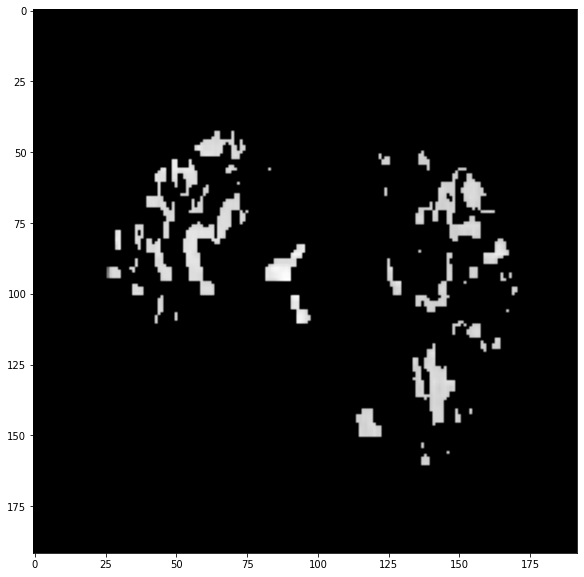

In [99]:
%matplotlib inline
if chosen_net == "sim":
    if selected_type == "KLF":
        orig = img_test.squeeze().cpu().detach().numpy().transpose(1,2,0)
    else:
        orig = img_test.squeeze().cpu().detach().numpy()
else:
    orig = img_test.squeeze().cpu().detach().numpy().transpose(1,0)
    
if chosen_net == "sim":
    slice_num = 96
    fig, axs = plt.subplots(1,1,figsize = (10,10))
    axs.imshow(orig[slice_num,:,:], cmap=cm.Greys_r)
    plt.show()
else:
    fig, axs = plt.subplots(1,1,figsize = (10,10))
    axs.imshow(orig, cmap=cm.Greys_r)
    plt.show()

Idx: UPENN-GBM-00442_11
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 0.999734
Tumor real value: 1


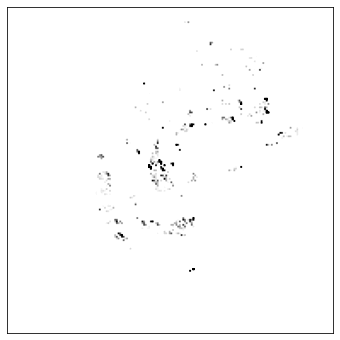

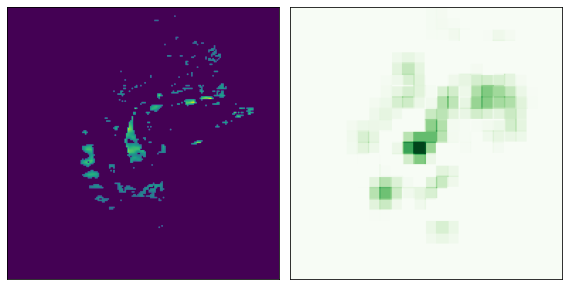

Idx: UPENN-GBM-00260_11
Methylation pred value: 0
Methylation real value: 1
Methylation prob value: 0.19126083
Tumor real value: 1


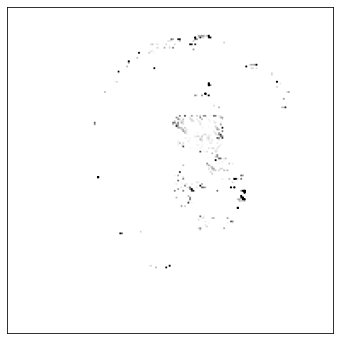

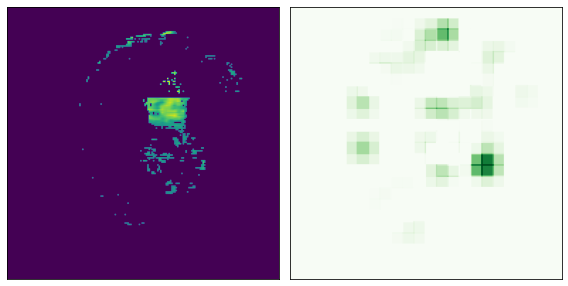

Idx: UPENN-GBM-00344_11
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 0.99988127
Tumor real value: 1


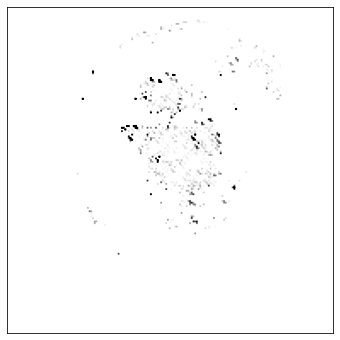

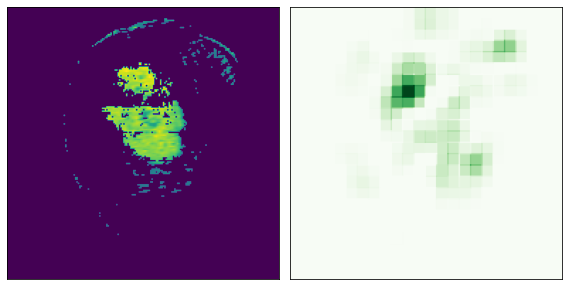

Idx: UPENN-GBM-00430_11
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 0.99953735
Tumor real value: 1


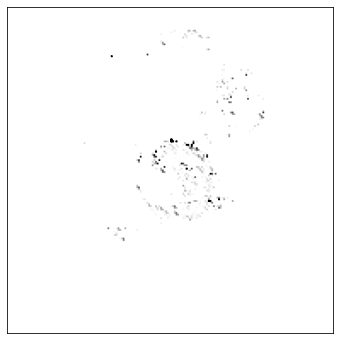

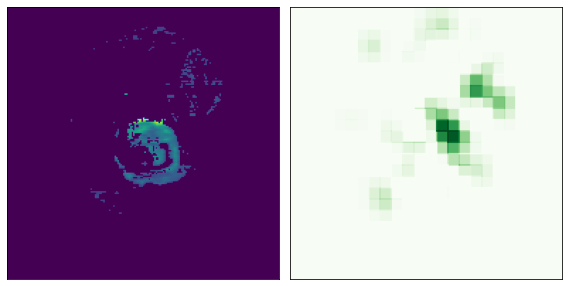

Idx: UPENN-GBM-00605_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.050682314
Tumor real value: 1


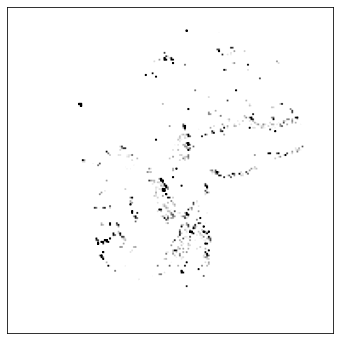

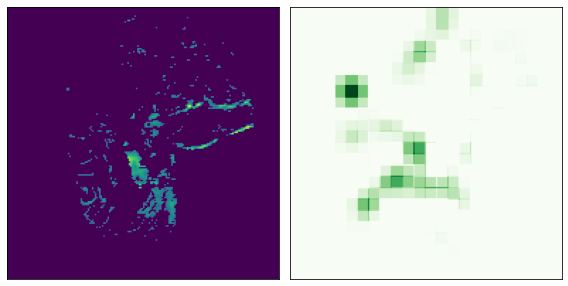

Idx: UPENN-GBM-00183_21
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 0.99894756
Tumor real value: 1


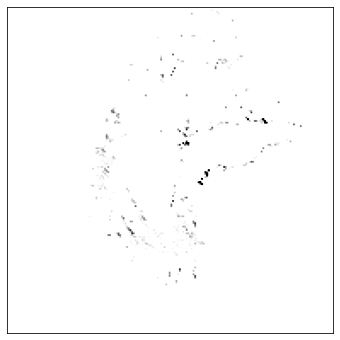

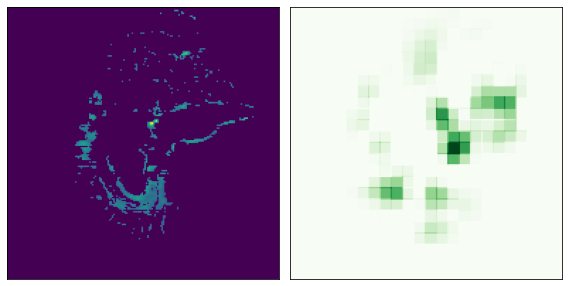

Idx: UPENN-GBM-00596_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.024481002
Tumor real value: 1


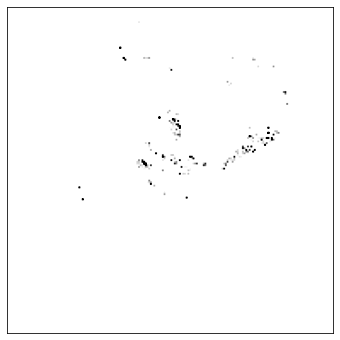

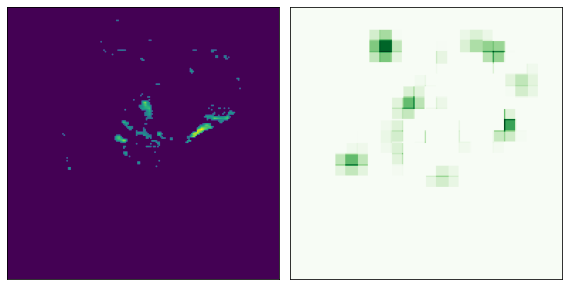

Idx: UPENN-GBM-00522_11
Methylation pred value: 1
Methylation real value: 0
Methylation prob value: 0.6527679
Tumor real value: 1


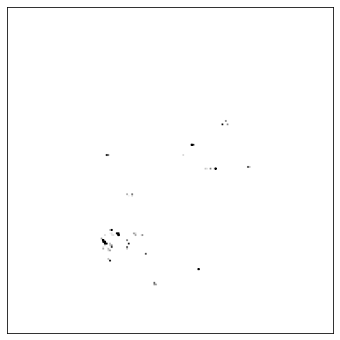

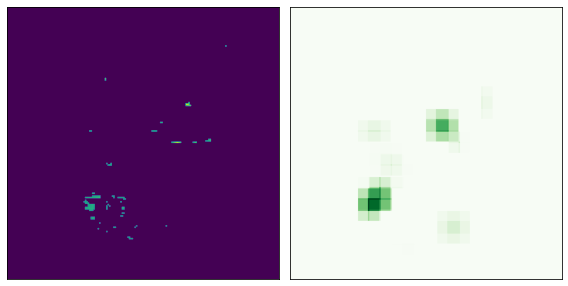

Idx: UPENN-GBM-00409_11
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 0.94339055
Tumor real value: 1


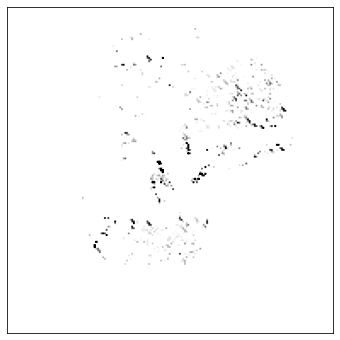

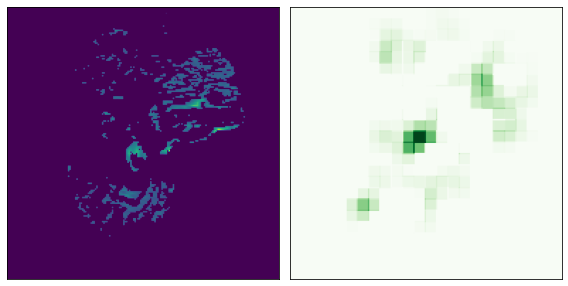

Idx: UPENN-GBM-00377_11
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 1.0
Tumor real value: 1


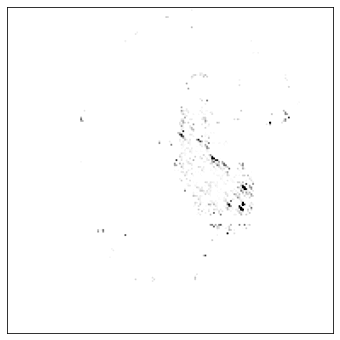

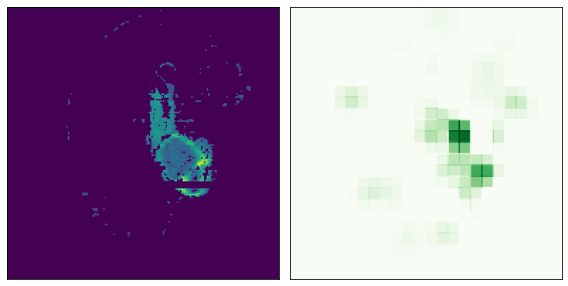

Idx: UPENN-GBM-00120_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 1.2766598e-12
Tumor real value: 1


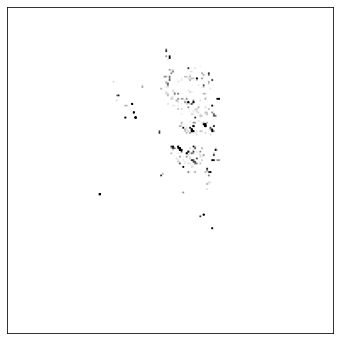

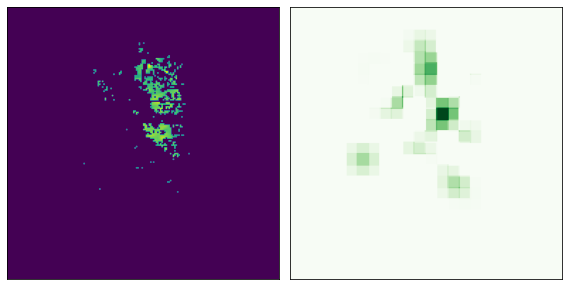

Idx: UPENN-GBM-00425_11
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 0.9999887
Tumor real value: 1


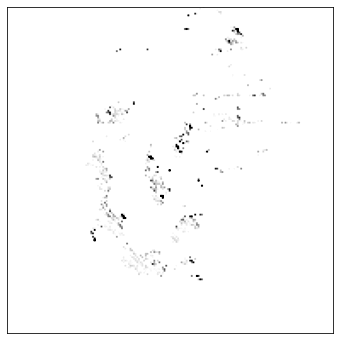

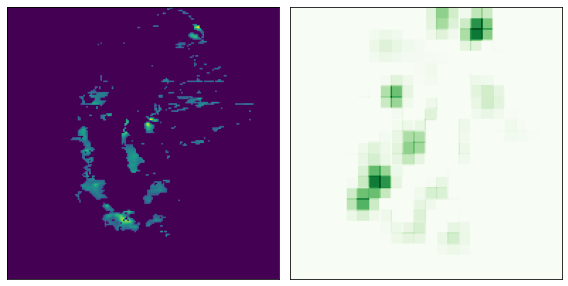

Idx: UPENN-GBM-00447_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.010958192
Tumor real value: 1


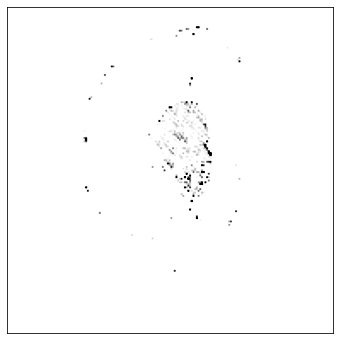

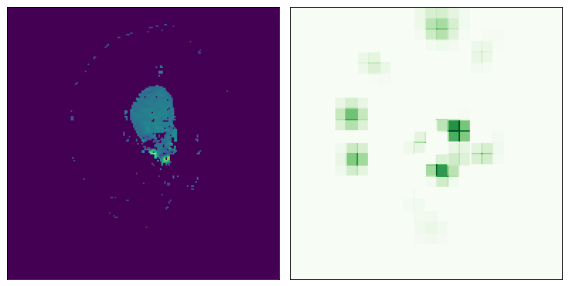

Idx: UPENN-GBM-00379_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 8.8960136e-05
Tumor real value: 1


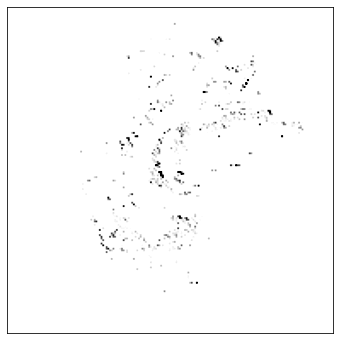

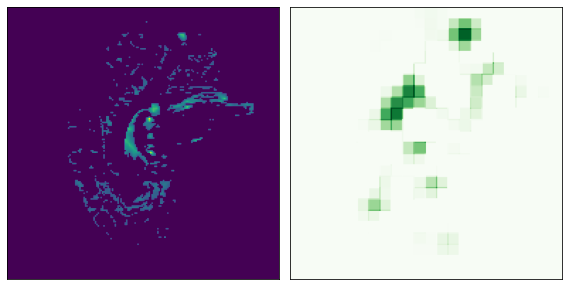

Idx: UPENN-GBM-00287_11
Methylation pred value: 0
Methylation real value: 1
Methylation prob value: 0.5702977
Tumor real value: 1


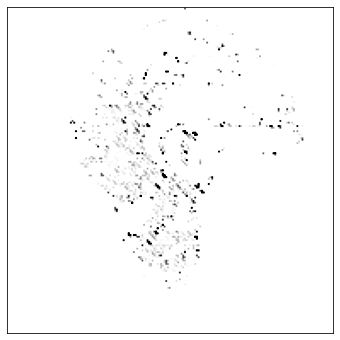

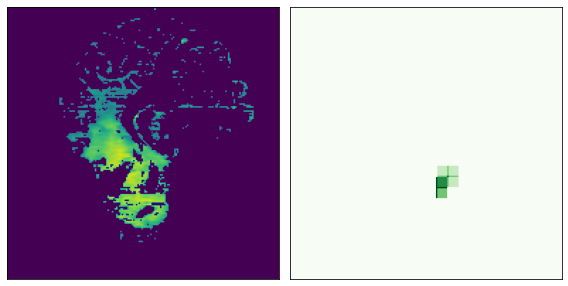

Idx: UPENN-GBM-00411_11
Methylation pred value: 1
Methylation real value: 0
Methylation prob value: 0.8547846
Tumor real value: 1


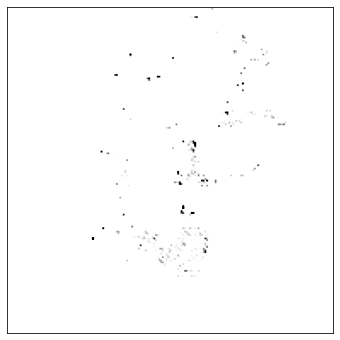

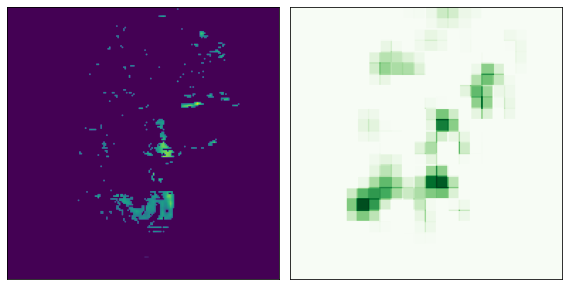

Idx: UPENN-GBM-00616_21
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.22017574
Tumor real value: 1


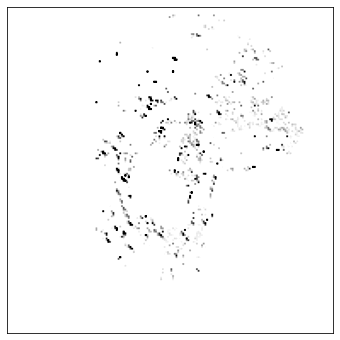

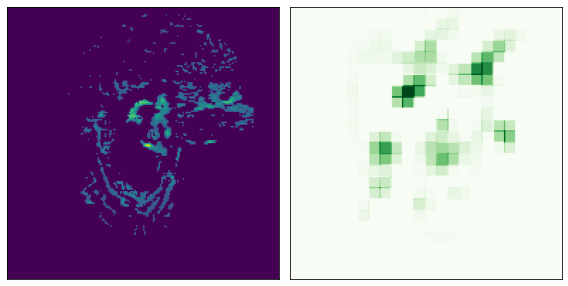

Idx: UPENN-GBM-00093_21
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.00016761056
Tumor real value: 1


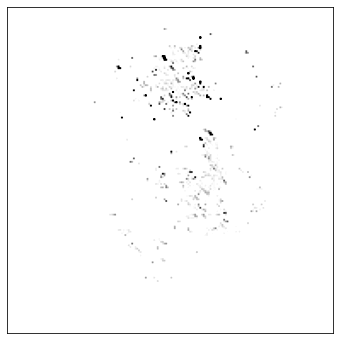

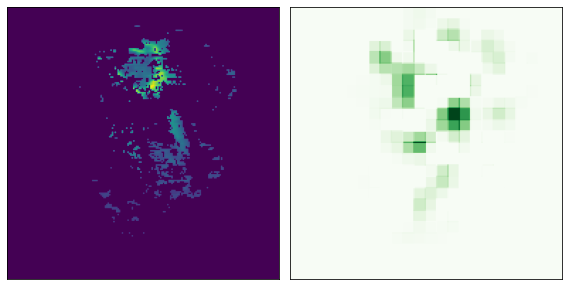

Idx: UPENN-GBM-00534_11
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 0.9985561
Tumor real value: 1


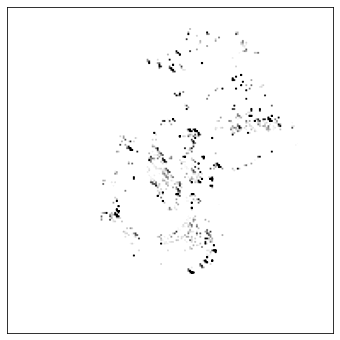

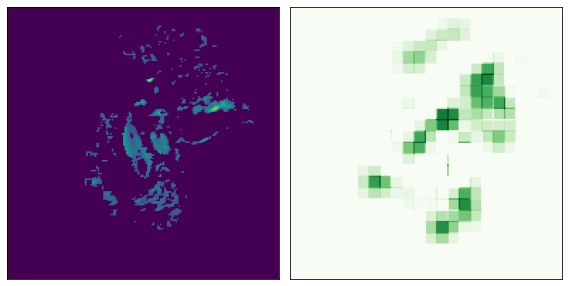

Idx: UPENN-GBM-00461_11
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 0.9417229
Tumor real value: 1


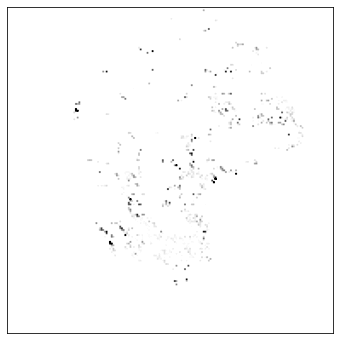

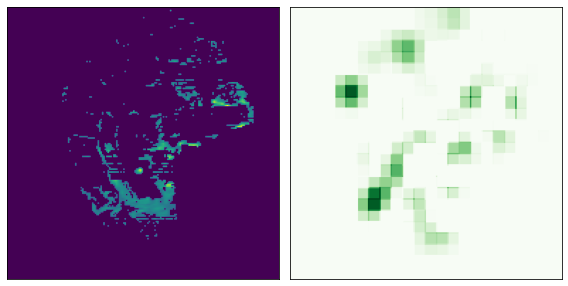

Idx: UPENN-GBM-00413_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.08524597
Tumor real value: 1


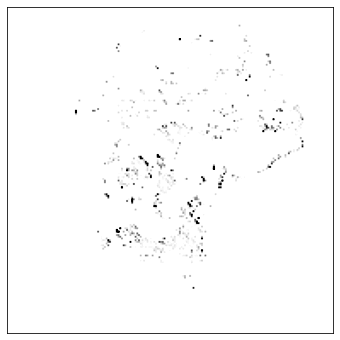

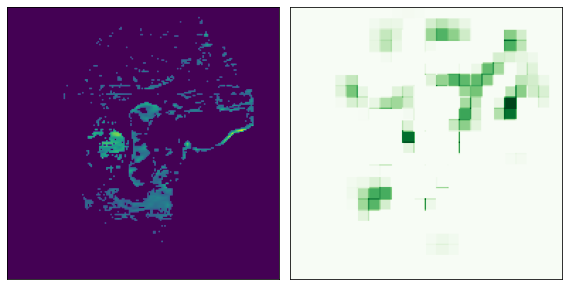

Idx: UPENN-GBM-00518_11
Methylation pred value: 0
Methylation real value: 1
Methylation prob value: 0.5702977
Tumor real value: 1


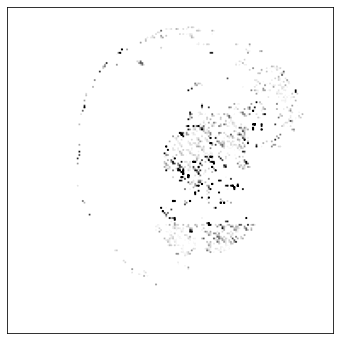

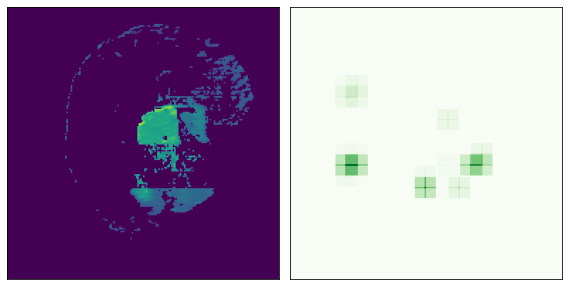

Idx: UPENN-GBM-00566_11
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 0.99516857
Tumor real value: 1


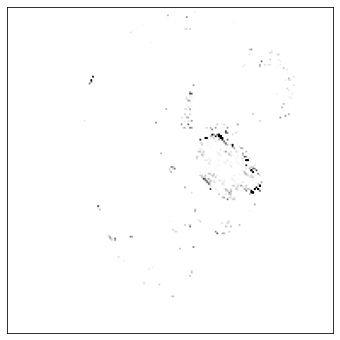

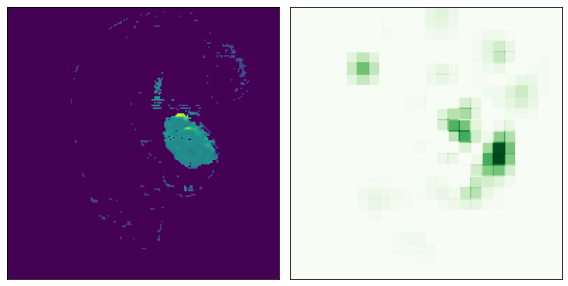

Idx: UPENN-GBM-00546_11
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 0.9972709
Tumor real value: 1


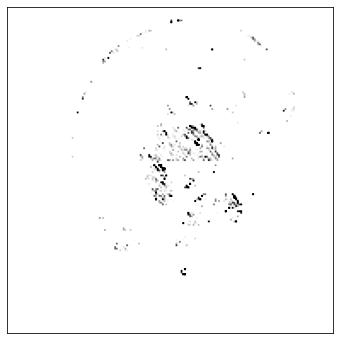

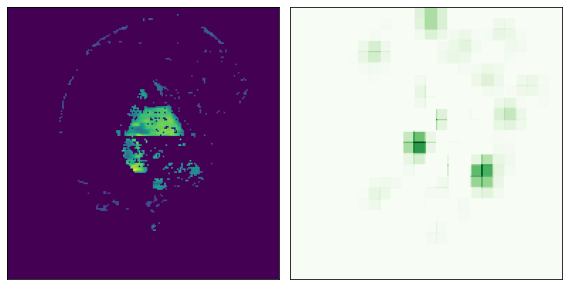

Idx: UPENN-GBM-00350_11
Methylation pred value: 0
Methylation real value: 1
Methylation prob value: 0.5702977
Tumor real value: 1


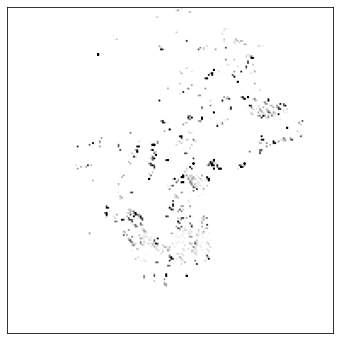

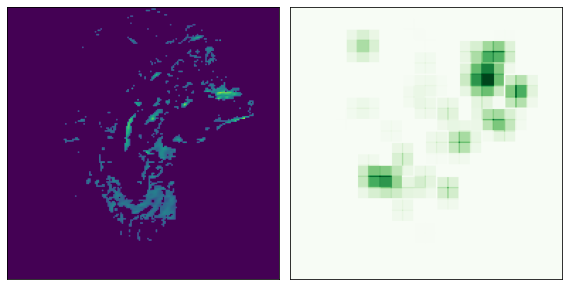

Idx: UPENN-GBM-00539_11
Methylation pred value: 0
Methylation real value: 1
Methylation prob value: 0.5702977
Tumor real value: 1


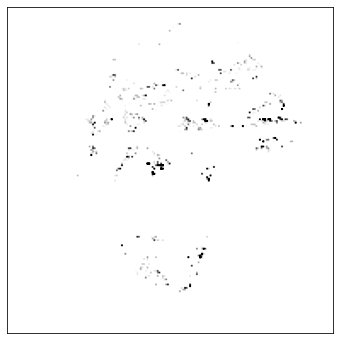

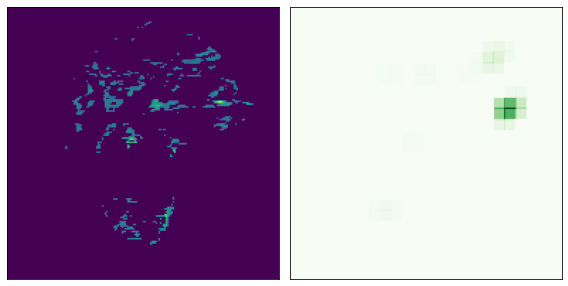

Idx: UPENN-GBM-00426_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 4.3822365e-06
Tumor real value: 1


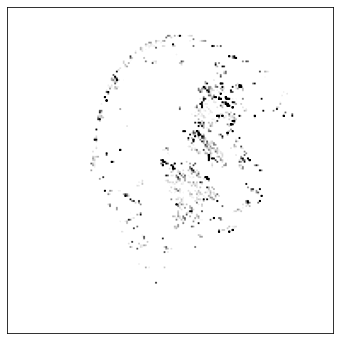

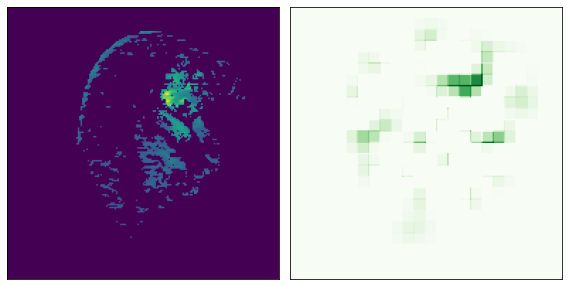

Idx: UPENN-GBM-00629_21
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.0021673185
Tumor real value: 1


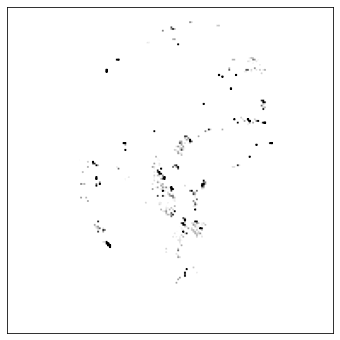

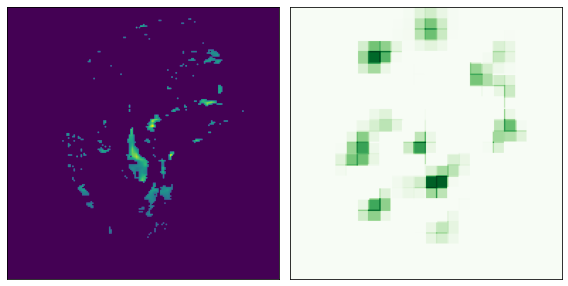

Idx: UPENN-GBM-00463_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.05877506
Tumor real value: 1


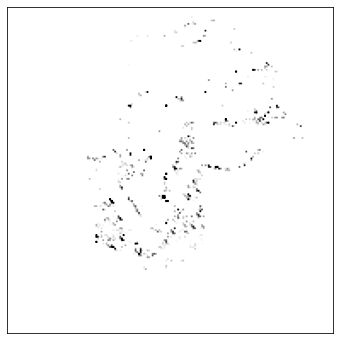

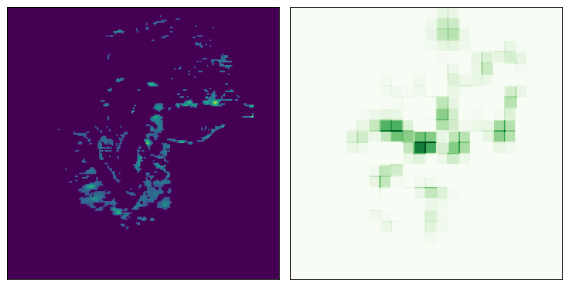

Idx: UPENN-GBM-00134_11
Methylation pred value: 1
Methylation real value: 0
Methylation prob value: 0.86549073
Tumor real value: 1


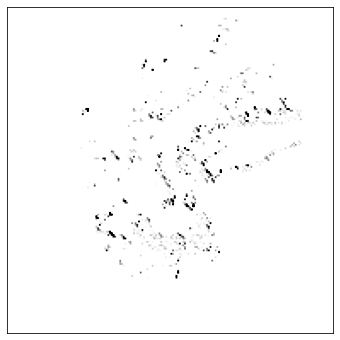

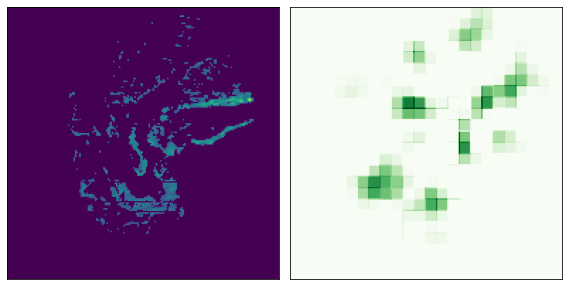

Idx: UPENN-GBM-00554_11
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 0.9999869
Tumor real value: 1


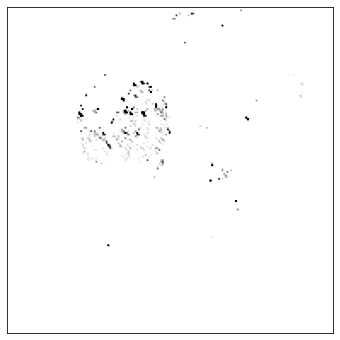

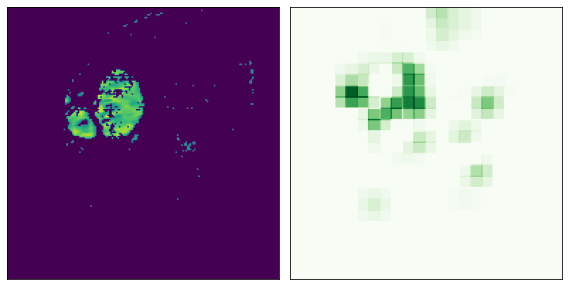

Idx: UPENN-GBM-00630_21
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 0.99999654
Tumor real value: 1


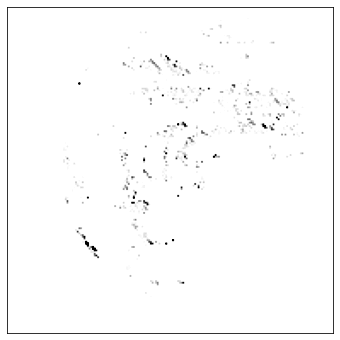

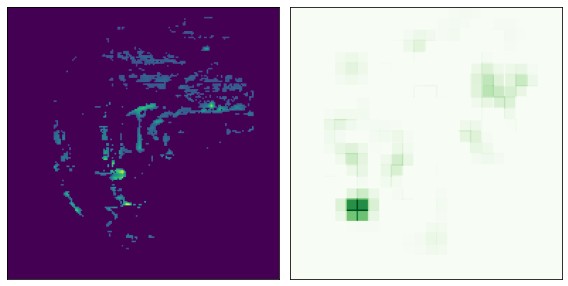

Idx: UPENN-GBM-00612_21
Methylation pred value: 0
Methylation real value: 1
Methylation prob value: 0.5702977
Tumor real value: 1


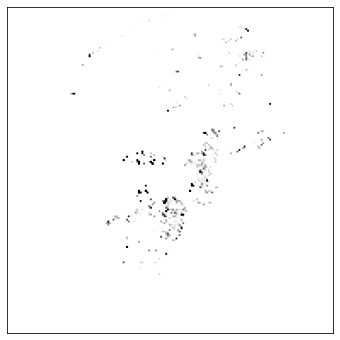

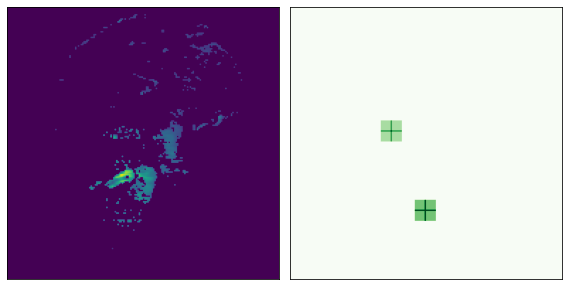

Idx: UPENN-GBM-00519_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.004559885
Tumor real value: 1


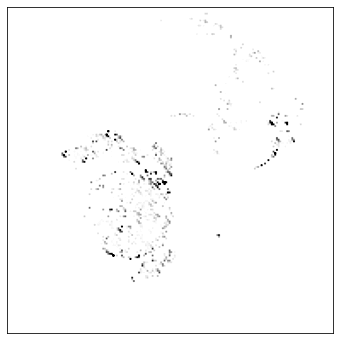

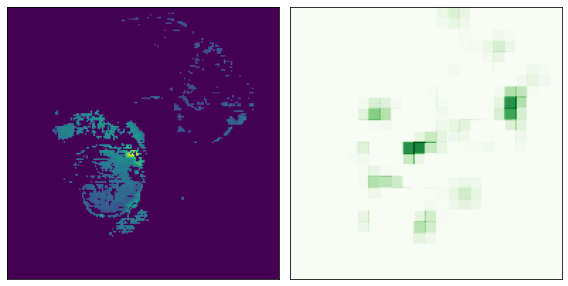

Idx: UPENN-GBM-00549_11
Methylation pred value: 1
Methylation real value: 0
Methylation prob value: 0.97397023
Tumor real value: 1


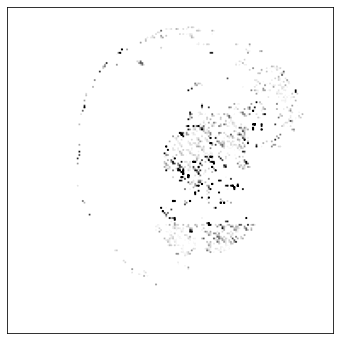

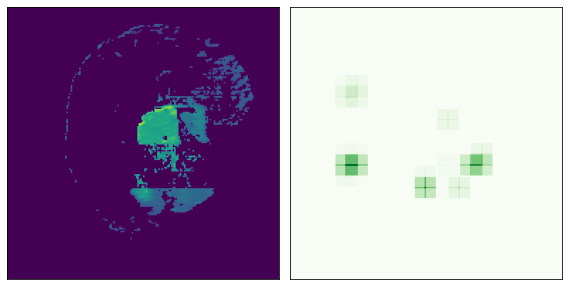

Idx: UPENN-GBM-00563_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.5702977
Tumor real value: 1


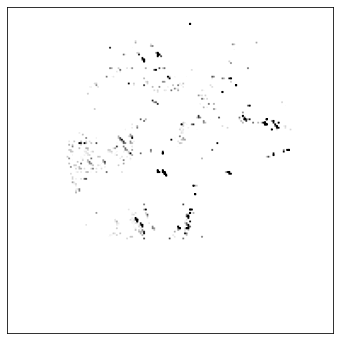

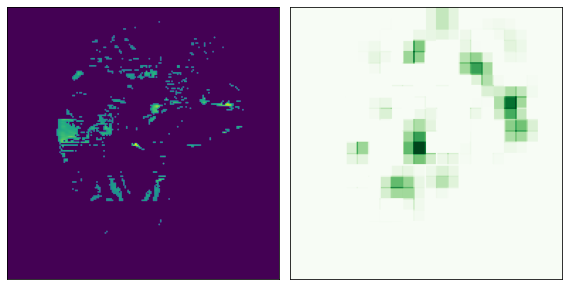

Idx: UPENN-GBM-00401_11
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 0.9999987
Tumor real value: 1


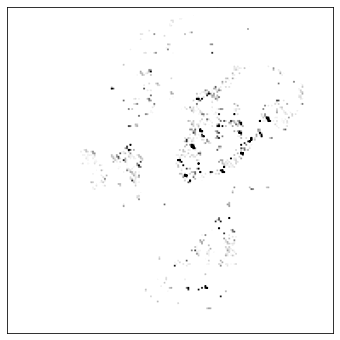

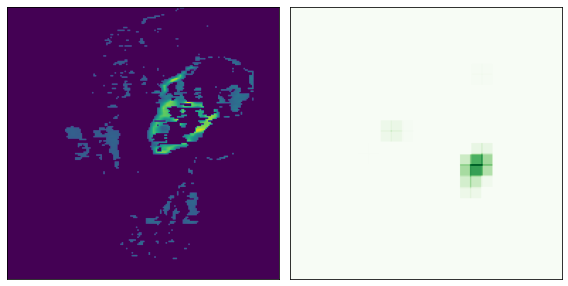

Idx: UPENN-GBM-00375_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.0027761052
Tumor real value: 1


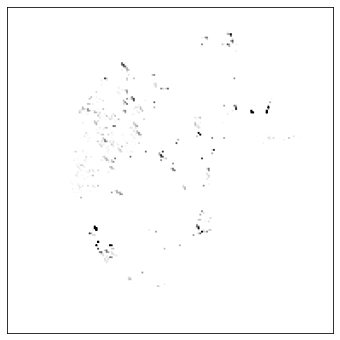

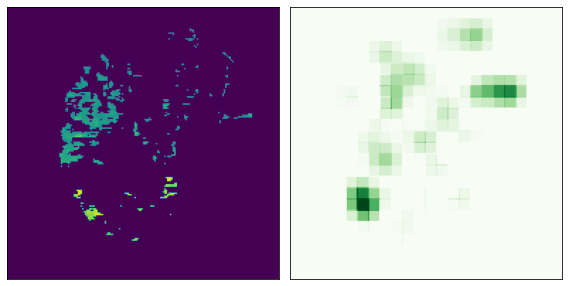

Idx: UPENN-GBM-00140_21
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.09320587
Tumor real value: 1


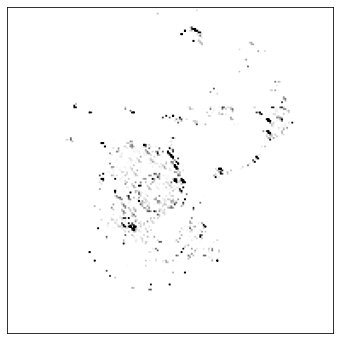

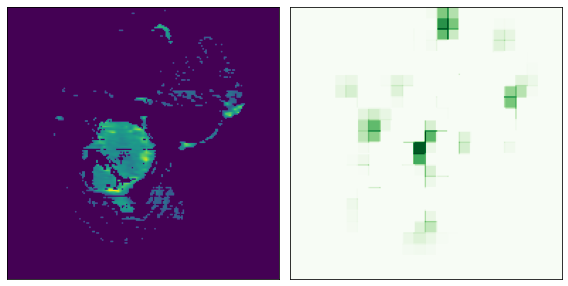

Idx: UPENN-GBM-00575_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 1.3784698e-08
Tumor real value: 1


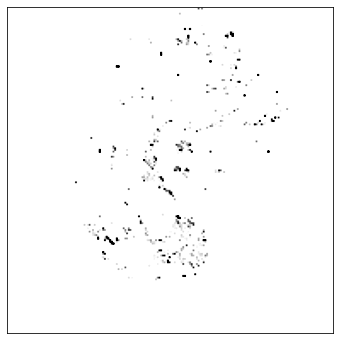

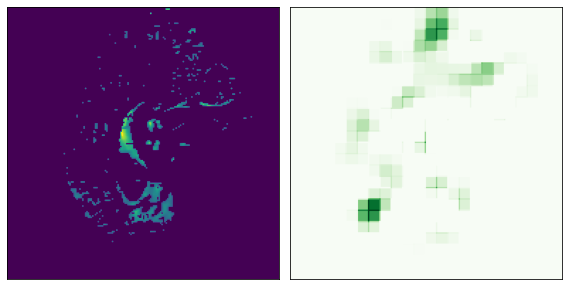

Idx: UPENN-GBM-00393_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.5702977
Tumor real value: 1


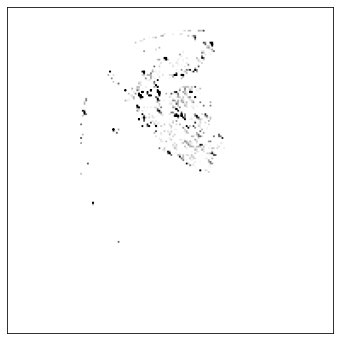

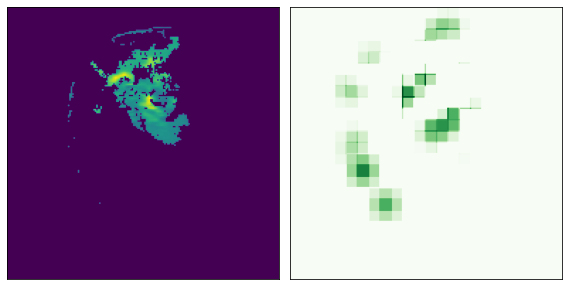

Idx: UPENN-GBM-00565_11
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 0.99816555
Tumor real value: 1


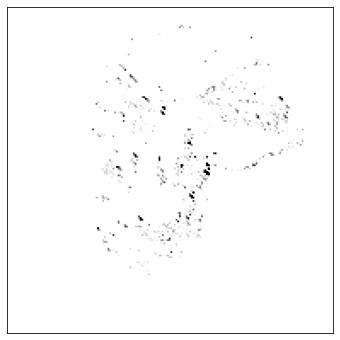

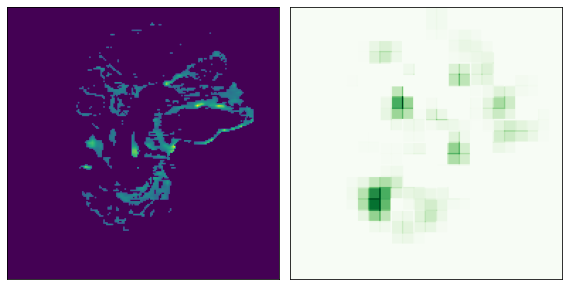

Idx: UPENN-GBM-00310_11
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 0.99887973
Tumor real value: 1


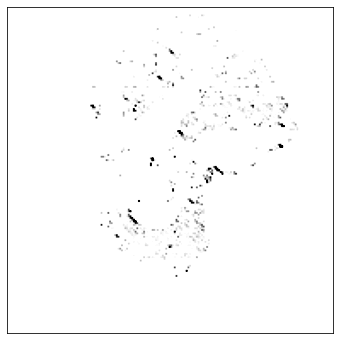

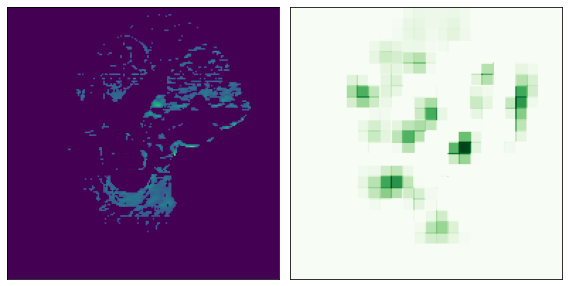

Idx: UPENN-GBM-00454_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.033877872
Tumor real value: 1


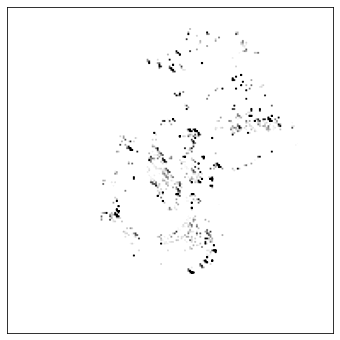

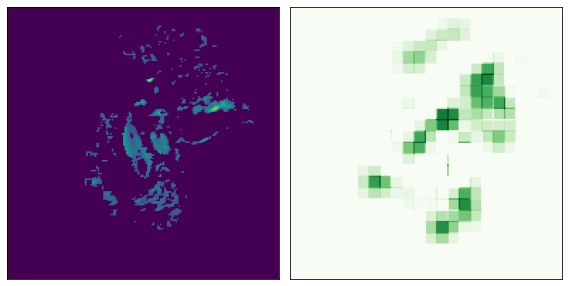

Idx: UPENN-GBM-00579_11
Methylation pred value: 0
Methylation real value: 1
Methylation prob value: 6.875352e-07
Tumor real value: 1


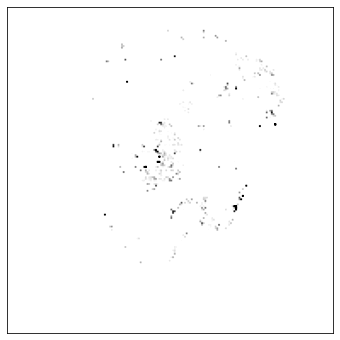

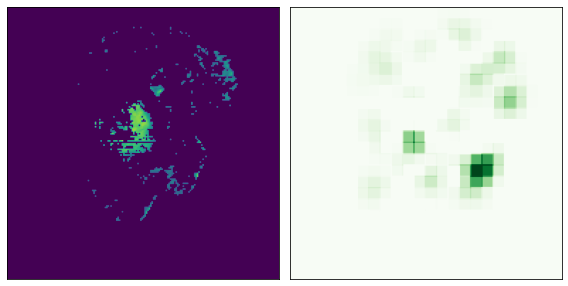

Idx: UPENN-GBM-00144_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.0011154918
Tumor real value: 1


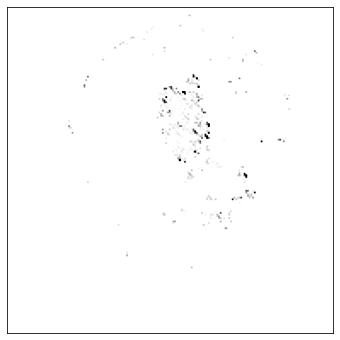

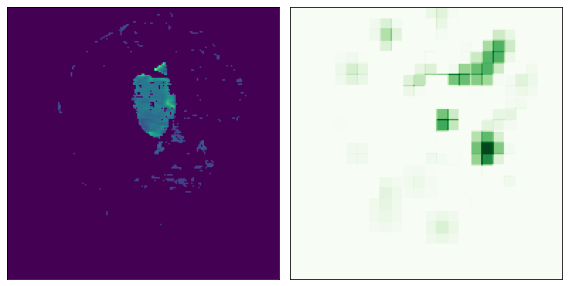

Idx: UPENN-GBM-00384_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.008473361
Tumor real value: 1


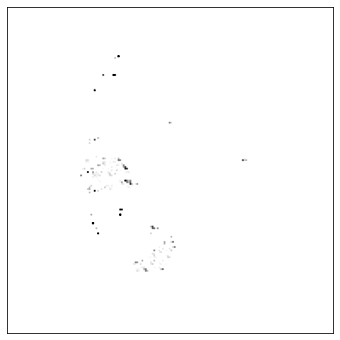

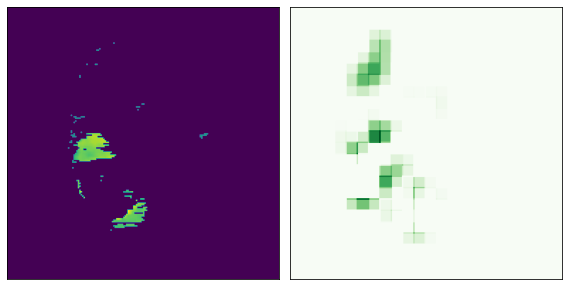

Idx: UPENN-GBM-00351_11
Methylation pred value: 0
Methylation real value: 1
Methylation prob value: 0.518271
Tumor real value: 1


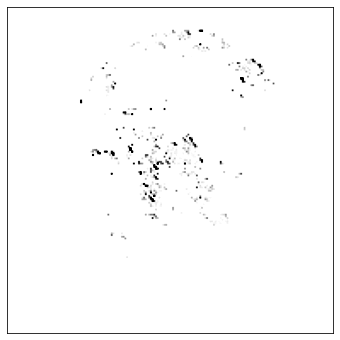

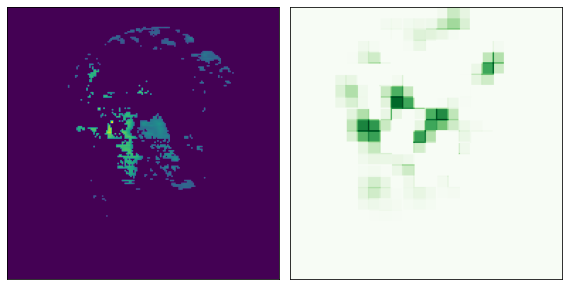

Idx: UPENN-GBM-00362_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.026605558
Tumor real value: 1


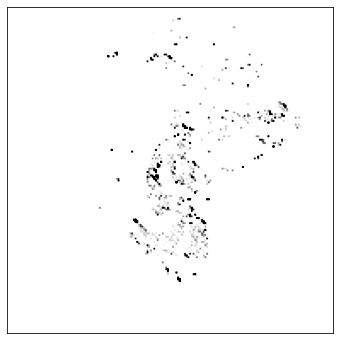

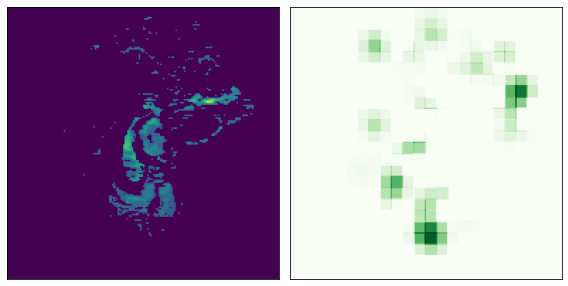

Idx: UPENN-GBM-00240_11
Methylation pred value: 1
Methylation real value: 1
Methylation prob value: 1.0
Tumor real value: 1


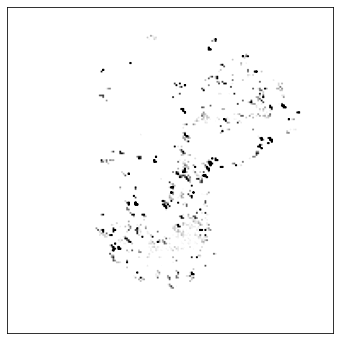

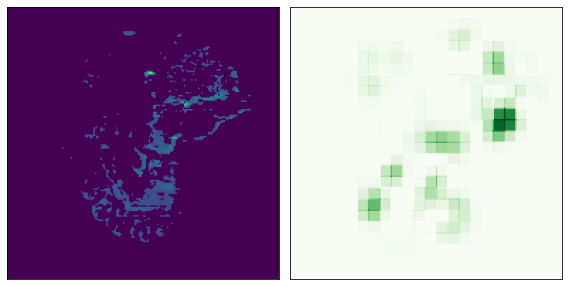

Idx: UPENN-GBM-00570_11
Methylation pred value: 0
Methylation real value: 0
Methylation prob value: 0.0006482843
Tumor real value: 1


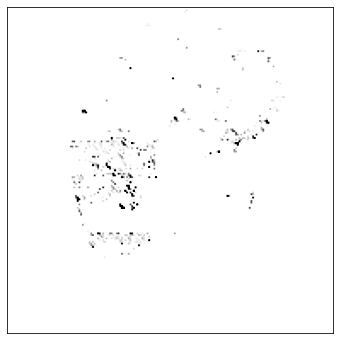

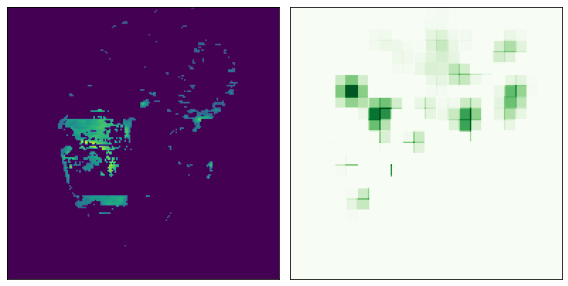

Idx: UPENN-GBM-00246_11
Methylation pred value: 1
Methylation real value: 0
Methylation prob value: 0.74094176
Tumor real value: 1


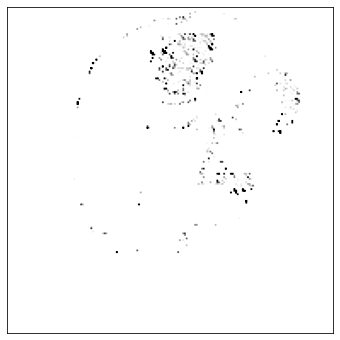

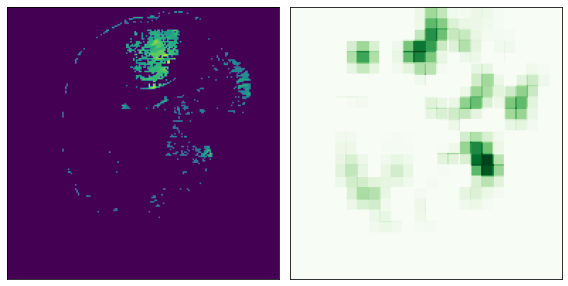

IndexError: list index out of range

In [169]:
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                   [(0, '#ffffff'),
                                                    (0.25, '#000000'),
                                                    (1, '#000000')], N=256)
integrated_gradients = IntegratedGradients(m_model)
occlusion = Occlusion(m_model)

for i in range(len(X)):
    idx = list(ids)[i]
    print("Idx: "+idx)
    pred = y_pred[i]
    real = y[i]
    prob = y_prob[i][0]
    tumor = tumor_y[i]
    img_test = X[i].unsqueeze(0)
    print("Methylation pred value: "+str(pred))
    print("Methylation real value: "+str(real))
    print("Methylation prob value: "+str(prob))
    print("Tumor real value: "+str(tumor))
    
    attributions_ig = integrated_gradients.attribute(img_test, target=0, n_steps=10)
    if chosen_net == "sim":
        attributions_occ = occlusion.attribute(img_test,
                                             strides=(1, 8, 8, 8),
                                             target=0,
                                             sliding_window_shapes=(1, 8, 8, 8), #1,15,15,15
                                             baselines=0)
    else:
        attributions_occ = occlusion.attribute(img_test,
                                             strides=(1, 8, 8),
                                             target=0,
                                             sliding_window_shapes=(1, 15, 15), #1,15,15,15
                                             baselines=0)
    if chosen_net == "alt":
        fig, axs = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze(0).cpu().detach().numpy(), (1, 2, 0)), #1,2,0
                               img_test.cpu().detach().numpy().transpose(2, 3, 1, 0)[:, :, :, 0], #2,3,1,0
                               method='heat_map',
                               cmap=default_cmap,
                               show_colorbar=False,
                               sign='positive',
                               outlier_perc=1)
        fig.savefig(f"/home/salvatorecapuozzo/Scrivania/captum_results/n/ig_{idx}_pred{pred}_real{real}_tumor{tumor}_prob{prob}.png")
        try:
            fig, axs = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze(0).cpu().detach().numpy(), (1, 2, 0)),
                                    img_test.cpu().detach().numpy().transpose(2, 3, 1, 0)[:, :, :, 0],
                                    ["original_image", "heat_map"],
                                    ["all", "positive"],
                                    show_colorbar=False,
                                    outlier_perc=2,
                                    )
            fig.savefig(f"/home/salvatorecapuozzo/Scrivania/captum_results/n/occ_{idx}_pred{pred}_real{real}_tumor{tumor}_prob{prob}.png")
        except: continue

In [100]:
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                   [(0, '#ffffff'),
                                                    (0.25, '#000000'),
                                                    (1, '#000000')], N=256)

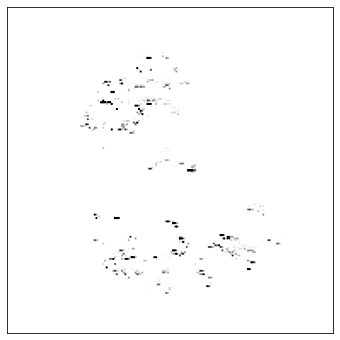

In [101]:
integrated_gradients = IntegratedGradients(m_model)
attributions_ig = integrated_gradients.attribute(img_test, target=0, n_steps=10)
if chosen_net == "alt":
    fig, axs = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze(0).cpu().detach().numpy(), (1, 2, 0)), #1,2,0
                           img_test.cpu().detach().numpy().transpose(2, 3, 1, 0)[:, :, :, 0], #2,3,1,0
                           method='heat_map',
                           cmap=default_cmap,
                           show_colorbar=False,
                           sign='positive',
                           outlier_perc=1)
    fig.savefig("/home/salvatorecapuozzo/Scrivania/KBF_interpr/ig_2_t.png")

-0.5698399661576637 0.32813825804390745
0.0 0.9999999998886387
<class 'numpy.ndarray'>


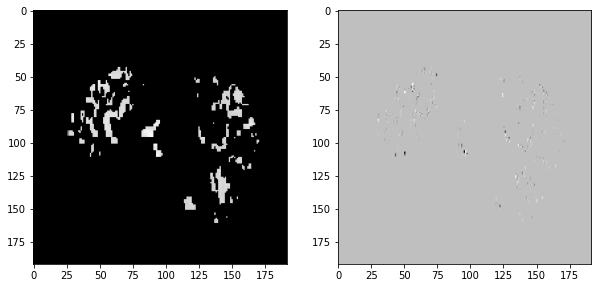

In [102]:
%matplotlib inline
if chosen_net == "sim":
    if selected_type == "KLF":
        ig = attributions_ig.squeeze().cpu().detach().numpy().transpose(1,2,0)
        orig = img_test.squeeze().cpu().detach().numpy().transpose(1,2,0)
    else:
        ig = attributions_ig.squeeze().cpu().detach().numpy()
        orig = img_test.squeeze().cpu().detach().numpy()
else:
    ig = attributions_ig.squeeze().cpu().detach().numpy().transpose(1,0)
    orig = img_test.squeeze().cpu().detach().numpy().transpose(1,0)
    
norm_ig = (ig-ig.min())/(ig.max()-ig.min()+0.0000000001)
print(ig.min(), ig.max())
print(norm_ig.min(), norm_ig.max())
cmap = cm.get_cmap('jet',256)
#cmap = cm.Greys_r
print(type(ig))
if chosen_net == "sim":
    slice_num = 96
    fig, axs = plt.subplots(1,2,figsize = (10,30))
    axs[0].imshow(orig[slice_num,:,:], cmap=cm.Greys_r)
    #axs[1].imshow(orig_f[slice_num,:,:], cmap=cm.Greys_r)
    axs[1].imshow(ig[slice_num,:,:], cmap=cm.Greys_r)
    plt.show()
else:
    fig, axs = plt.subplots(1,2,figsize = (10,30))
    axs[0].imshow(orig, cmap=cm.Greys_r)
    #axs[1].imshow(orig_f[slice_num,:,:], cmap=cm.Greys_r)
    axs[1].imshow(ig, cmap=cm.Greys_r)
    plt.show()

<IPython.core.display.Javascript object>


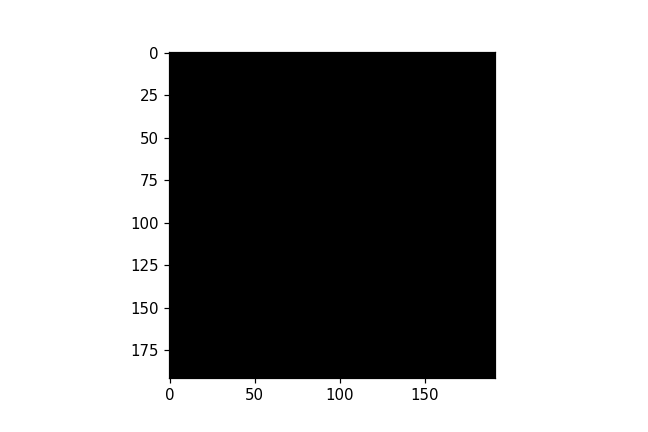

In [15]:
%matplotlib notebook

j = 0
fig = plt.figure()
frames = []
img = orig
while (j < len(img)):
    frames.append([plt.imshow(img[j], cmap=cm.Greys_r, animated=True)])
    j += 1

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
plt.show()
#%matplotlib inline

<IPython.core.display.Javascript object>


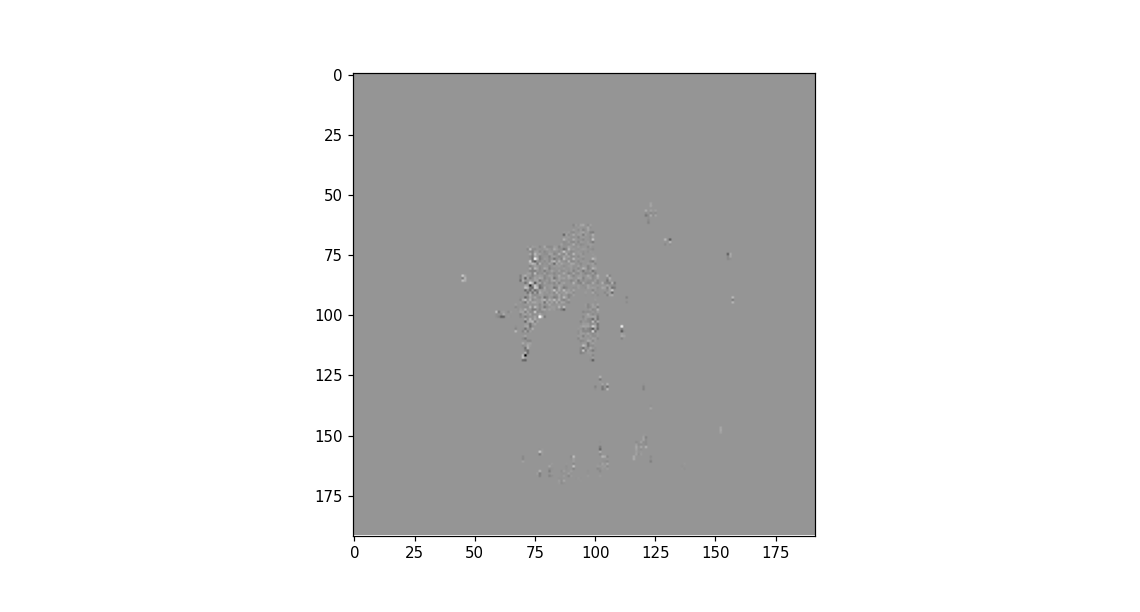

In [16]:
%matplotlib notebook

j = 0
fig = plt.figure()
frames = []
img = ig
while (j < len(img)):
    frames.append([plt.imshow(img[j], cmap=cm.Greys_r, animated=True)])
    j += 1

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
plt.show()
#%matplotlib inline

In [18]:
#savemat("/home/salvatorecapuozzo/Scrivania/prova.mat", {'X': ig} )

In [103]:
%matplotlib inline
occlusion = Occlusion(m_model)
if chosen_net == "sim":
    attributions_occ = occlusion.attribute(img_test,
                                         strides=(1, 8, 8, 8),
                                         target=0,
                                         sliding_window_shapes=(1, 8, 8, 8), #1,15,15,15
                                         baselines=0)
else:
    attributions_occ = occlusion.attribute(img_test,
                                         strides=(1, 8, 8),
                                         target=0,
                                         sliding_window_shapes=(1, 15, 15), #1,15,15,15
                                         baselines=0)

AssertionError: Cannot normalize by scale factor = 0

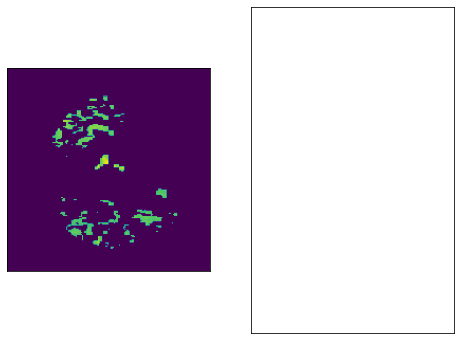

In [104]:
%matplotlib inline

if chosen_net == "alt":
    fig, axs = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze(0).cpu().detach().numpy(), (1, 2, 0)),
                                    img_test.cpu().detach().numpy().transpose(2, 3, 1, 0)[:, :, :, 0],
                                    ["original_image", "heat_map"],
                                    ["all", "positive"],
                                    show_colorbar=False,
                                    outlier_perc=2,
                                    )
    fig.savefig("/home/salvatorecapuozzo/Scrivania/KBF_interpr/occ_2_t.png")

(192, 192)
(192, 192)


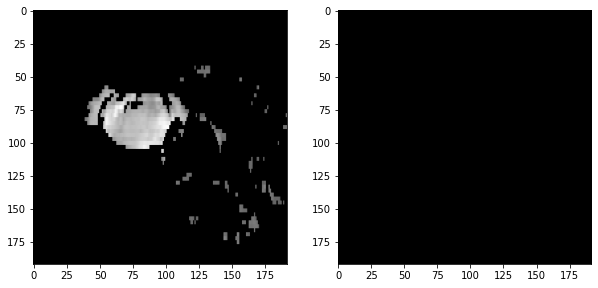

In [44]:
%matplotlib inline
if chosen_net == "sim":
    if selected_type == "KLF":
        occ = attributions_occ.squeeze().cpu().detach().numpy().transpose(1,2,0)
        orig = img_test.squeeze().cpu().detach().numpy().transpose(1,2,0)
    else:
        occ = attributions_occ.squeeze().cpu().detach().numpy()
        orig = img_test.squeeze().cpu().detach().numpy()
else:
    occ = attributions_occ.squeeze().cpu().detach().numpy().transpose(1,0)
    orig = img_test.squeeze().cpu().detach().numpy().transpose(1,0)
#orig = np.rot90(orig, k=3)
#orig = np.flip(orig, axis=1)
#orig_f = img_test_f.squeeze().cpu().detach().numpy()
print(occ.shape)
print(orig.shape)

cmap = cm.get_cmap('jet',256)
#cmap = cm.Greys_r
if chosen_net == "sim":
    slice_num = 96
    fig, axs = plt.subplots(1,2,figsize = (10,30))
    axs[0].imshow(orig[slice_num,:,:], cmap=cm.Greys_r)
    #axs[1].imshow(orig_f[slice_num,:,:], cmap=cm.Greys_r)
    axs[1].imshow(occ[slice_num,:,:], cmap=cm.Greys_r)
    plt.show()
    #plt.imshow(occ[slice_num,:,:], cmap=cmap)
    #plt.show()
else:
    fig, axs = plt.subplots(1,2,figsize = (10,30))
    axs[0].imshow(orig, cmap=cm.Greys_r)
    #axs[1].imshow(orig_f[slice_num,:,:], cmap=cm.Greys_r)
    axs[1].imshow(occ, cmap=cm.Greys_r)
    plt.show()

<IPython.core.display.Javascript object>


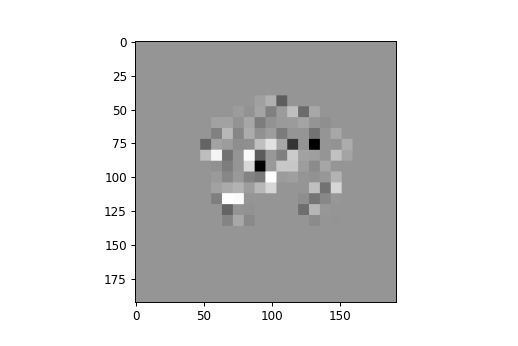

192


In [106]:
%matplotlib notebook

j = 0
fig = plt.figure()
frames = []
img = occ
print(len(img))
while (j < len(img)):
    frames.append([plt.imshow(img[j], cmap=cm.Greys_r, animated=True)])
    j += 1

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
plt.show()
#%matplotlib inline

In [122]:
from medcam import medcam

In [125]:
model = medcam.inject(m_model, label=0, backend="gcam", output_dir="attention_maps", save_maps=True)

2022-08-01 16:24:13 - Predict: ../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Jan27_10-46-07/RSNAClassifierSingle3D-DW-SO-e13-loss0.012-acc1.000-auc1.000.pth 606
Dataset: Labeled Test Set
   BraTS21ID  MGMT_real_value  MGMT_value
54     00020                1           0
27     00059                1           0
13     00062                1           0
9      00077                1           0
33     00102                0           0
11     00110                0           0
18     00117                1           0
43     00134                1           0
49     00139                1           0
46     00158                0           1
16     00177                1           1
5      00186                1           0
28     00194                0           1
31     00195                0           1
1      00217                0           1
37     00218                0           0
59     00219                0           0
56     00249                0           1


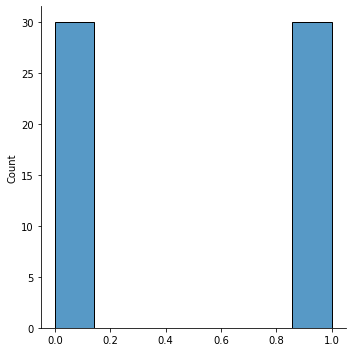

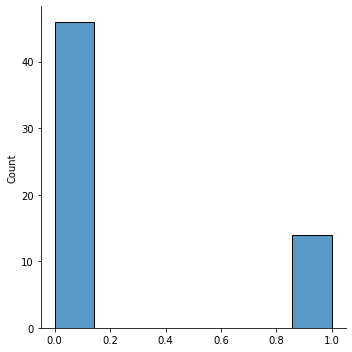

In [127]:
test_pred, X, y, y_pred, y_prob = predict(model, device, m_modelfile, m_test_loader, size)

(2, 2, 2, 1)


TypeError: Invalid shape (2, 2, 2, 1) for image data

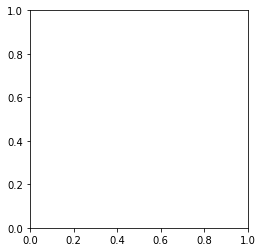

In [128]:
path = "attention_maps/part1/attention_map_34_0_0.nii.gz"
y, _ = loader_fc_3d_nifti(path)
print(y.shape)
img = y
fig = "Attention map"
slice_num = 96
plt.imshow(img, cmap=cm.Greys_r)
plt.show()